# **Google Runoff Reanalysis & Reforecast dataset (GRRR) analysis**

This notebook contains an analysis of the Google Runoff Reanalysis & Reforecast dataset (GRRR) (riverine) flood forecasting skill for Mali. Data is first downloaded manually from an complementary online colab environment (https://colab.research.google.com/drive/1FnXXSEQqU1TJhMPiNeWUTr9LnbJwZzMm?usp=sharing) with access to the GRRR, and then ran through the pipeline with a configuration of choice. Options are different lead times (1-7), trigger thresholds (1.5 to 10-year return period or 95th to 99th-percentiles), or the data to verify the forecasts with (i.e. either impact data or observational data).

The impact and observational data are available upon request, see the README.

#### **GRRR data**

The GRRR consists of hydrologic predictions by Google state-of-the-art (SOTA) hydrologic model, an improved version of the model described in the Nature article (https://www.nature.com/articles/s41586-024-07145-1), with full global coverage and daily resolution. It includes:
* Streamflow reanalysis data for ±1M hydrobasins (hybases) (hydrological basin) for 1980 - 2023, on which, too, return period values are based and calculated (the ‘severity threshold levels’ from the API);
* Streamflow reforecast data for ±1M hybases for 2016 - 2022, with 7-day lead times.

Of all these hybases, some are so-called "verified" and others are "unverified," meaning they have been verified according to certain standard with e.g. discharge or satellite data by the Google Research team, or not. The ratio [verified : unverified] for Mali is around [1 : 100]. All predictions, however, are made with the same model. In this analysis, we consider all hybas locations for Mali, with priority for verified gauges when appropriate and available.

#### **Methods**

A high-level written explanation of the workings of the code is available at [INSERT LINK].

## **Downloading the data**

In [1]:
import analyse

import numpy as np
import pandas as pd
import xarray as xr


Running __init__.py for GoogleFloodHub-data-analyser

Running __init__.py for GoogleFloodHub-data-extractor
GoogleFloodHub-data-extractor initialized

GoogleFloodHub-data-analyser initialized



In [48]:
df_Mali_gauges, df_Mali_gauge_models, df_Mali_forecasts = \
    analyse.get_country_data('Mali','2024-07-08', '2024-10-08', True)

print(df_Mali_gauges['gaugeId'])

0       hybas_1120040380
1       hybas_1120040400
2       hybas_1120040850
3       hybas_1120040860
4       hybas_1120040960
              ...       
1659    hybas_1121945470
1660    hybas_1121947460
1661    hybas_1121947780
1662    hybas_1121948560
1663    hybas_1121948660
Name: gaugeId, Length: 1664, dtype: object


In [3]:
df_Mali_verified = pd.read_csv('../data/processed/ListGauges/Mali_gauges_listed.csv', sep = ';')
print(df_Mali_verified['gaugeId'])

0     hybas_1120641660
1     hybas_1120650110
2     hybas_1120661040
3     hybas_1120679780
4     hybas_1120689830
5     hybas_1120705070
6     hybas_1120737100
7     hybas_1120739110
8     hybas_1120758950
9     hybas_1120766460
10    hybas_1121890140
11    hybas_1121893090
12    hybas_1121895840
13    hybas_1121900350
14    hybas_1121905290
15    hybas_1121919510
Name: gaugeId, dtype: object


In [4]:
# check whether all gaugeId in df_Mali_verified are in df_all_virtual_gauges
print(df_Mali_verified['gaugeId'].isin(df_Mali_gauges['gaugeId']).value_counts())

gaugeId
True    16
Name: count, dtype: int64


In [5]:
df_all_virtual_gauges = pd.read_csv('../data/GRRR/metadata/Mali_virtual_gauges_metadata.csv')

print(df_all_virtual_gauges['gauge_id'])

0       hybas_1120040380
1       hybas_1120040400
2       hybas_1120040850
3       hybas_1120040860
4       hybas_1120040960
              ...       
9544    hybas_1121953810
9545    hybas_1121953990
9546    hybas_1121954390
9547    hybas_1121954870
9548    hybas_1121955370
Name: gauge_id, Length: 9549, dtype: object


In [6]:
df_Mali_gauges

,siteName,source,river,gaugeId,qualityVerified,hasModel,latitude,longitude
0,NaN,HYBAS,NaN,hybas_1120040380,False,True,16.552083,-4.918750
1,NaN,HYBAS,NaN,hybas_1120040400,False,True,19.314583,-3.122917
2,NaN,HYBAS,NaN,hybas_1120040850,False,True,18.510417,-2.464583
3,NaN,HYBAS,NaN,hybas_1120040860,False,True,17.460417,-2.672917
4,NaN,HYBAS,NaN,hybas_1120040960,False,True,20.702083,-5.006250
...,...,...,...,...,...,...,...,...
1659,NaN,HYBAS,Bale,hybas_1121945470,False,True,10.764583,-8.081250
1660,NaN,HYBAS,NaN,hybas_1121947460,False,True,10.652083,-7.410417
1661,NaN,HYBAS,NaN,hybas_1121947780,False,True,10.631250,-7.481250
1662,NaN,HYBAS,NaN,hybas_1121948560,False,True,10.581250,-7.364583


In [7]:
print(len(df_Mali_gauges[df_Mali_gauges['gaugeId'].isin(set(df_Mali_gauges['gaugeId']).difference(set(df_all_virtual_gauges['gauge_id'])))]))

53


In [8]:
def print_gauge_IDs(df: pd.DataFrame, width = 1):
    """
    Prints the gauge IDs in the dataframe in a pretty format

    :param df: dataframe containing gauge IDs
    :param width: width of the columns to print with
    """
    print("Mali_hybases = [")
    for idx in range(0, len(df), width):
        print("    " + ", ".join([f"'{g}'" for g in df[idx : idx + width]]) + ",")
    print("]")

In [9]:
print_gauge_IDs(df_Mali_gauges['gaugeId'], 64)

Mali_hybases = [
    'hybas_1120040380', 'hybas_1120040400', 'hybas_1120040850', 'hybas_1120040860', 'hybas_1120040960', 'hybas_1120041110', 'hybas_1120041510', 'hybas_1120041730', 'hybas_1120043640', 'hybas_1120303190', 'hybas_1120303810', 'hybas_1120397600', 'hybas_1120410560', 'hybas_1120411350', 'hybas_1120412240', 'hybas_1120429260', 'hybas_1120432960', 'hybas_1120466750', 'hybas_1120470630', 'hybas_1120471020', 'hybas_1120471030', 'hybas_1120471950', 'hybas_1120471970', 'hybas_1120472120', 'hybas_1120472270', 'hybas_1120472580', 'hybas_1120472590', 'hybas_1120473940', 'hybas_1120475600', 'hybas_1120477150', 'hybas_1120477170', 'hybas_1120478130', 'hybas_1120479380', 'hybas_1120479830', 'hybas_1120481330', 'hybas_1120482130', 'hybas_1120483990', 'hybas_1120484930', 'hybas_1120487900', 'hybas_1120488260', 'hybas_1120491030', 'hybas_1120491690', 'hybas_1120492490', 'hybas_1120493530', 'hybas_1120494590', 'hybas_1120496140', 'hybas_1120498360', 'hybas_1120504370', 'hybas_1120504470',

In [10]:
print_gauge_IDs(df_all_virtual_gauges['gauge_id'], 374)

Mali_hybases = [
    'hybas_1120040380', 'hybas_1120040400', 'hybas_1120040850', 'hybas_1120040860', 'hybas_1120040960', 'hybas_1120041000', 'hybas_1120041110', 'hybas_1120041220', 'hybas_1120041500', 'hybas_1120041510', 'hybas_1120041580', 'hybas_1120041680', 'hybas_1120041690', 'hybas_1120041720', 'hybas_1120041730', 'hybas_1120041740', 'hybas_1120041750', 'hybas_1120041830', 'hybas_1120041980', 'hybas_1120042050', 'hybas_1120042420', 'hybas_1120042510', 'hybas_1120042530', 'hybas_1120042770', 'hybas_1120042790', 'hybas_1120043450', 'hybas_1120043480', 'hybas_1120043500', 'hybas_1120043640', 'hybas_1120043860', 'hybas_1120043950', 'hybas_1120044090', 'hybas_1120044230', 'hybas_1120044610', 'hybas_1120044720', 'hybas_1120044830', 'hybas_1120044840', 'hybas_1120044990', 'hybas_1120045360', 'hybas_1120045740', 'hybas_1120045850', 'hybas_1120046050', 'hybas_1120046360', 'hybas_1120046390', 'hybas_1120046500', 'hybas_1120046730', 'hybas_1120046850', 'hybas_1120046940', 'hybas_1120047090',

**To download the GRRR data for a specific location**, we need to access it through the online environment (of the aforementioned URL). In there, replace the cell with code equal to comment-block (1) with the code in comment-block (2) for the verified gauges and comment-block (3) for the unverified gauges. Then, paste comment-block (4) in the colab as well for the Mali data to download locally in the colab environment. When the data is placed into a folder there (and if all is processed correctly), download it manually as a .zip (by converting: ``!zip -r gauge_data.zip /content/gauge_data`` -- and downloading: ``from google.colab import files`` and ``files.download('gauge_data.zip'))``.

With the current comment-blocks with the Mali gauge IDs, all Mali data will be downloaded. To download data for another country, generate the gauge IDs with the API's ListGauges() call.

In [11]:
""" comment-block (1): replace this with (2) or (3)
gauge_reforecast_ds = reforecast_ds.sel(gauge_id=hybas_id).compute()
gauge_reanalysis_ds = reanalysis_ds.sel(gauge_id=hybas_id).compute()
gauge_return_periods_ds = return_periods_ds.sel(gauge_id=hybas_id).compute()
"""

' comment-block (1): replace this with (2) or (3)\ngauge_reforecast_ds = reforecast_ds.sel(gauge_id=hybas_id).compute()\ngauge_reanalysis_ds = reanalysis_ds.sel(gauge_id=hybas_id).compute()\ngauge_return_periods_ds = return_periods_ds.sel(gauge_id=hybas_id).compute()\n'

In [12]:
""" comment-block (2): verified IDs
Mali_hybases = [
  'hybas_1120641660',
  'hybas_1120650110',
  'hybas_1120661040',
  'hybas_1120679780',
  'hybas_1120689830',
  'hybas_1120705070',
  'hybas_1120737100',
  'hybas_1120739110',
  'hybas_1120758950',
  'hybas_1120766460',
  'hybas_1121890140',
  'hybas_1121893090',
  'hybas_1121895840',
  'hybas_1121900350',
  'hybas_1121905290',
  'hybas_1121919510'
]
"""

" comment-block (2): verified IDs\nMali_hybases = [\n  'hybas_1120641660',\n  'hybas_1120650110',\n  'hybas_1120661040',\n  'hybas_1120679780',\n  'hybas_1120689830',\n  'hybas_1120705070',\n  'hybas_1120737100',\n  'hybas_1120739110',\n  'hybas_1120758950',\n  'hybas_1120766460',\n  'hybas_1121890140',\n  'hybas_1121893090',\n  'hybas_1121895840',\n  'hybas_1121900350',\n  'hybas_1121905290',\n  'hybas_1121919510'\n]\n"

In [13]:
""" comment-block (3) virtual IDs
Mali_hybases = [
    'hybas_1120040380', 'hybas_1120040400', 'hybas_1120040850', 'hybas_1120040860', 'hybas_1120040960', 'hybas_1120041110', 'hybas_1120041510', 'hybas_1120041730', 'hybas_1120043640', 'hybas_1120303190', 'hybas_1120303810', 'hybas_1120397600', 'hybas_1120410560', 'hybas_1120411350', 'hybas_1120412240', 'hybas_1120429260', 'hybas_1120432960', 'hybas_1120466750', 'hybas_1120470630', 'hybas_1120471020', 'hybas_1120471030', 'hybas_1120471950', 'hybas_1120471970', 'hybas_1120472120', 'hybas_1120472270', 'hybas_1120472580', 'hybas_1120472590', 'hybas_1120473940', 'hybas_1120475600', 'hybas_1120477150', 'hybas_1120477170', 'hybas_1120478130', 'hybas_1120479380', 'hybas_1120479830', 'hybas_1120481330', 'hybas_1120482130', 'hybas_1120483990', 'hybas_1120484930', 'hybas_1120487900', 'hybas_1120488260', 'hybas_1120491030', 'hybas_1120491690', 'hybas_1120492490', 'hybas_1120493530', 'hybas_1120494590', 'hybas_1120496140', 'hybas_1120498360', 'hybas_1120504370', 'hybas_1120504470', 'hybas_1120504640', 'hybas_1120505610', 'hybas_1120509630', 'hybas_1120510390', 'hybas_1120510890', 'hybas_1120512060', 'hybas_1120512280', 'hybas_1120512460', 'hybas_1120513470', 'hybas_1120515750', 'hybas_1120517670', 'hybas_1120518390', 'hybas_1120518600', 'hybas_1120519840', 'hybas_1120520690',
    'hybas_1120520940', 'hybas_1120521780', 'hybas_1120522540', 'hybas_1120523280', 'hybas_1120523380', 'hybas_1120523420', 'hybas_1120523620', 'hybas_1120523630', 'hybas_1120524850', 'hybas_1120525450', 'hybas_1120525650', 'hybas_1120527140', 'hybas_1120527350', 'hybas_1120527680', 'hybas_1120528640', 'hybas_1120529240', 'hybas_1120529440', 'hybas_1120529940', 'hybas_1120530060', 'hybas_1120530160', 'hybas_1120530300', 'hybas_1120531120', 'hybas_1120531460', 'hybas_1120531880', 'hybas_1120532050', 'hybas_1120532230', 'hybas_1120532750', 'hybas_1120532960', 'hybas_1120533300', 'hybas_1120533310', 'hybas_1120533700', 'hybas_1120533720', 'hybas_1120533810', 'hybas_1120534130', 'hybas_1120534140', 'hybas_1120536810', 'hybas_1120538130', 'hybas_1120538290', 'hybas_1120539270', 'hybas_1120540030', 'hybas_1120540480', 'hybas_1120540500', 'hybas_1120540680', 'hybas_1120540820', 'hybas_1120540830', 'hybas_1120544610', 'hybas_1120545390', 'hybas_1120545620', 'hybas_1120547920', 'hybas_1120547940', 'hybas_1120548470', 'hybas_1120549740', 'hybas_1120550010', 'hybas_1120550020', 'hybas_1120550030', 'hybas_1120550230', 'hybas_1120550380', 'hybas_1120550540', 'hybas_1120550770', 'hybas_1120550780', 'hybas_1120551370', 'hybas_1120551410', 'hybas_1120551560', 'hybas_1120551770',
    'hybas_1120551780', 'hybas_1120552270', 'hybas_1120552280', 'hybas_1120552460', 'hybas_1120552650', 'hybas_1120553250', 'hybas_1120553570', 'hybas_1120553740', 'hybas_1120553750', 'hybas_1120554320', 'hybas_1120554770', 'hybas_1120554930', 'hybas_1120554940', 'hybas_1120555140', 'hybas_1120555550', 'hybas_1120555730', 'hybas_1120556160', 'hybas_1120556480', 'hybas_1120556700', 'hybas_1120556990', 'hybas_1120557110', 'hybas_1120557170', 'hybas_1120557770', 'hybas_1120557870', 'hybas_1120558440', 'hybas_1120558570', 'hybas_1120558910', 'hybas_1120559030', 'hybas_1120559430', 'hybas_1120559460', 'hybas_1120559600', 'hybas_1120559630', 'hybas_1120560050', 'hybas_1120560230', 'hybas_1120560390', 'hybas_1120560420', 'hybas_1120560430', 'hybas_1120560650', 'hybas_1120561470', 'hybas_1120561650', 'hybas_1120561810', 'hybas_1120561830', 'hybas_1120562900', 'hybas_1120562920', 'hybas_1120563590', 'hybas_1120563820', 'hybas_1120564590', 'hybas_1120564740', 'hybas_1120564860', 'hybas_1120564960', 'hybas_1120564980', 'hybas_1120565220', 'hybas_1120565330', 'hybas_1120565450', 'hybas_1120565570', 'hybas_1120565730', 'hybas_1120565890', 'hybas_1120565930', 'hybas_1120566540', 'hybas_1120566570', 'hybas_1120566910', 'hybas_1120567030', 'hybas_1120567200', 'hybas_1120567210',
    'hybas_1120567350', 'hybas_1120567380', 'hybas_1120567860', 'hybas_1120567870', 'hybas_1120567880', 'hybas_1120568290', 'hybas_1120568530', 'hybas_1120568560', 'hybas_1120568750', 'hybas_1120568760', 'hybas_1120569130', 'hybas_1120569140', 'hybas_1120569160', 'hybas_1120569550', 'hybas_1120569730', 'hybas_1120570200', 'hybas_1120570310', 'hybas_1120570840', 'hybas_1120571020', 'hybas_1120571170', 'hybas_1120571190', 'hybas_1120571210', 'hybas_1120571400', 'hybas_1120571780', 'hybas_1120571790', 'hybas_1120571810', 'hybas_1120571920', 'hybas_1120572020', 'hybas_1120572030', 'hybas_1120572190', 'hybas_1120572200', 'hybas_1120572390', 'hybas_1120572870', 'hybas_1120573290', 'hybas_1120573670', 'hybas_1120574720', 'hybas_1120574930', 'hybas_1120575020', 'hybas_1120575340', 'hybas_1120575820', 'hybas_1120575840', 'hybas_1120576250', 'hybas_1120576260', 'hybas_1120576370', 'hybas_1120576380', 'hybas_1120576510', 'hybas_1120577130', 'hybas_1120577220', 'hybas_1120577230', 'hybas_1120577590', 'hybas_1120577630', 'hybas_1120577750', 'hybas_1120577880', 'hybas_1120578220', 'hybas_1120579520', 'hybas_1120580940', 'hybas_1120581610', 'hybas_1120582050', 'hybas_1120582390', 'hybas_1120582680', 'hybas_1120582840', 'hybas_1120582940', 'hybas_1120582950', 'hybas_1120583150',
    'hybas_1120583620', 'hybas_1120583640', 'hybas_1120584260', 'hybas_1120584350', 'hybas_1120584360', 'hybas_1120584370', 'hybas_1120584500', 'hybas_1120585080', 'hybas_1120585100', 'hybas_1120585450', 'hybas_1120585480', 'hybas_1120585920', 'hybas_1120586040', 'hybas_1120586210', 'hybas_1120587030', 'hybas_1120587040', 'hybas_1120587440', 'hybas_1120587780', 'hybas_1120587790', 'hybas_1120587880', 'hybas_1120588270', 'hybas_1120588310', 'hybas_1120588700', 'hybas_1120588980', 'hybas_1120589130', 'hybas_1120589730', 'hybas_1120589740', 'hybas_1120589750', 'hybas_1120590180', 'hybas_1120590190', 'hybas_1120590750', 'hybas_1120591050', 'hybas_1120591190', 'hybas_1120591200', 'hybas_1120591220', 'hybas_1120591420', 'hybas_1120591560', 'hybas_1120591740', 'hybas_1120591770', 'hybas_1120592240', 'hybas_1120592250', 'hybas_1120592350', 'hybas_1120592790', 'hybas_1120593030', 'hybas_1120593040', 'hybas_1120593050', 'hybas_1120593470', 'hybas_1120594180', 'hybas_1120594190', 'hybas_1120594490', 'hybas_1120594520', 'hybas_1120595390', 'hybas_1120595410', 'hybas_1120595660', 'hybas_1120595690', 'hybas_1120595820', 'hybas_1120595960', 'hybas_1120596090', 'hybas_1120596100', 'hybas_1120596260', 'hybas_1120596300', 'hybas_1120596680', 'hybas_1120596900', 'hybas_1120596910',
    'hybas_1120597170', 'hybas_1120597370', 'hybas_1120597480', 'hybas_1120597500', 'hybas_1120597890', 'hybas_1120598090', 'hybas_1120598250', 'hybas_1120598480', 'hybas_1120599220', 'hybas_1120599600', 'hybas_1120599620', 'hybas_1120600140', 'hybas_1120600480', 'hybas_1120600830', 'hybas_1120601080', 'hybas_1120601110', 'hybas_1120601830', 'hybas_1120602200', 'hybas_1120602230', 'hybas_1120602680', 'hybas_1120602870', 'hybas_1120603030', 'hybas_1120603340', 'hybas_1120603370', 'hybas_1120603580', 'hybas_1120603600', 'hybas_1120603890', 'hybas_1120603910', 'hybas_1120604170', 'hybas_1120604190', 'hybas_1120604370', 'hybas_1120604770', 'hybas_1120605370', 'hybas_1120605610', 'hybas_1120605720', 'hybas_1120605730', 'hybas_1120605790', 'hybas_1120605800', 'hybas_1120605930', 'hybas_1120606420', 'hybas_1120606590', 'hybas_1120606620', 'hybas_1120606800', 'hybas_1120606910', 'hybas_1120606920', 'hybas_1120607100', 'hybas_1120607120', 'hybas_1120607270', 'hybas_1120608260', 'hybas_1120608270', 'hybas_1120608280', 'hybas_1120608450', 'hybas_1120609020', 'hybas_1120609100', 'hybas_1120609250', 'hybas_1120609270', 'hybas_1120609400', 'hybas_1120609580', 'hybas_1120609590', 'hybas_1120609790', 'hybas_1120609940', 'hybas_1120609950', 'hybas_1120610400', 'hybas_1120610540',
    'hybas_1120610710', 'hybas_1120610850', 'hybas_1120611050', 'hybas_1120611180', 'hybas_1120611190', 'hybas_1120611200', 'hybas_1120611650', 'hybas_1120611660', 'hybas_1120612020', 'hybas_1120612370', 'hybas_1120613290', 'hybas_1120613300', 'hybas_1120613430', 'hybas_1120613460', 'hybas_1120614120', 'hybas_1120614290', 'hybas_1120614820', 'hybas_1120614850', 'hybas_1120614860', 'hybas_1120615070', 'hybas_1120615200', 'hybas_1120615740', 'hybas_1120616130', 'hybas_1120616150', 'hybas_1120616250', 'hybas_1120616410', 'hybas_1120616420', 'hybas_1120616500', 'hybas_1120616670', 'hybas_1120616690', 'hybas_1120616700', 'hybas_1120617070', 'hybas_1120617160', 'hybas_1120617360', 'hybas_1120617570', 'hybas_1120617870', 'hybas_1120617880', 'hybas_1120617930', 'hybas_1120618270', 'hybas_1120618560', 'hybas_1120618570', 'hybas_1120618670', 'hybas_1120618790', 'hybas_1120618800', 'hybas_1120619400', 'hybas_1120619810', 'hybas_1120619820', 'hybas_1120619920', 'hybas_1120619930', 'hybas_1120620140', 'hybas_1120620420', 'hybas_1120620550', 'hybas_1120620950', 'hybas_1120620980', 'hybas_1120621160', 'hybas_1120621340', 'hybas_1120621490', 'hybas_1120621510', 'hybas_1120621520', 'hybas_1120621820', 'hybas_1120621980', 'hybas_1120622370', 'hybas_1120622540', 'hybas_1120623020',
    'hybas_1120623040', 'hybas_1120623900', 'hybas_1120623920', 'hybas_1120623930', 'hybas_1120624050', 'hybas_1120624420', 'hybas_1120624560', 'hybas_1120624690', 'hybas_1120624700', 'hybas_1120624920', 'hybas_1120625000', 'hybas_1120625010', 'hybas_1120625310', 'hybas_1120625570', 'hybas_1120625970', 'hybas_1120626120', 'hybas_1120626130', 'hybas_1120626240', 'hybas_1120626260', 'hybas_1120626430', 'hybas_1120626460', 'hybas_1120626560', 'hybas_1120626670', 'hybas_1120626700', 'hybas_1120626730', 'hybas_1120626740', 'hybas_1120626870', 'hybas_1120627060', 'hybas_1120627170', 'hybas_1120627280', 'hybas_1120627290', 'hybas_1120627430', 'hybas_1120627450', 'hybas_1120627460', 'hybas_1120627470', 'hybas_1120627480', 'hybas_1120627660', 'hybas_1120627670', 'hybas_1120627850', 'hybas_1120627860', 'hybas_1120627960', 'hybas_1120627980', 'hybas_1120628110', 'hybas_1120628120', 'hybas_1120628260', 'hybas_1120628330', 'hybas_1120628350', 'hybas_1120628510', 'hybas_1120628520', 'hybas_1120628530', 'hybas_1120628540', 'hybas_1120628550', 'hybas_1120628680', 'hybas_1120628730', 'hybas_1120629420', 'hybas_1120629430', 'hybas_1120630150', 'hybas_1120630290', 'hybas_1120630440', 'hybas_1120630620', 'hybas_1120630640', 'hybas_1120630800', 'hybas_1120630930', 'hybas_1120631400',
    'hybas_1120631550', 'hybas_1120631730', 'hybas_1120631740', 'hybas_1120631890', 'hybas_1120632060', 'hybas_1120632070', 'hybas_1120632490', 'hybas_1120632620', 'hybas_1120632630', 'hybas_1120633370', 'hybas_1120633580', 'hybas_1120633600', 'hybas_1120634230', 'hybas_1120634240', 'hybas_1120634440', 'hybas_1120634800', 'hybas_1120634810', 'hybas_1120635400', 'hybas_1120635720', 'hybas_1120635740', 'hybas_1120636080', 'hybas_1120636160', 'hybas_1120636170', 'hybas_1120636660', 'hybas_1120636820', 'hybas_1120636970', 'hybas_1120637330', 'hybas_1120637340', 'hybas_1120637510', 'hybas_1120637690', 'hybas_1120637880', 'hybas_1120638180', 'hybas_1120638320', 'hybas_1120638470', 'hybas_1120638490', 'hybas_1120638510', 'hybas_1120638530', 'hybas_1120638640', 'hybas_1120638930', 'hybas_1120639070', 'hybas_1120639310', 'hybas_1120639320', 'hybas_1120639330', 'hybas_1120639350', 'hybas_1120639370', 'hybas_1120639480', 'hybas_1120639620', 'hybas_1120639840', 'hybas_1120639850', 'hybas_1120639990', 'hybas_1120640000', 'hybas_1120640160', 'hybas_1120640190', 'hybas_1120640350', 'hybas_1120640370', 'hybas_1120640580', 'hybas_1120640680', 'hybas_1120640840', 'hybas_1120641440', 'hybas_1120641630', 'hybas_1120641640', 'hybas_1120641660', 'hybas_1120641680', 'hybas_1120642000',
    'hybas_1120642010', 'hybas_1120642020', 'hybas_1120642140', 'hybas_1120642160', 'hybas_1120642490', 'hybas_1120642990', 'hybas_1120643020', 'hybas_1120643170', 'hybas_1120643390', 'hybas_1120643540', 'hybas_1120643800', 'hybas_1120643820', 'hybas_1120643950', 'hybas_1120644110', 'hybas_1120644270', 'hybas_1120644470', 'hybas_1120644480', 'hybas_1120644490', 'hybas_1120644500', 'hybas_1120644510', 'hybas_1120644620', 'hybas_1120644920', 'hybas_1120645180', 'hybas_1120645190', 'hybas_1120645630', 'hybas_1120645770', 'hybas_1120646000', 'hybas_1120646230', 'hybas_1120646630', 'hybas_1120646780', 'hybas_1120646950', 'hybas_1120646960', 'hybas_1120646970', 'hybas_1120647210', 'hybas_1120647330', 'hybas_1120647580', 'hybas_1120647600', 'hybas_1120647730', 'hybas_1120647860', 'hybas_1120647880', 'hybas_1120647910', 'hybas_1120648120', 'hybas_1120648650', 'hybas_1120648910', 'hybas_1120649070', 'hybas_1120649770', 'hybas_1120650110', 'hybas_1120650150', 'hybas_1120650510', 'hybas_1120650760', 'hybas_1120650770', 'hybas_1120650880', 'hybas_1120651040', 'hybas_1120651140', 'hybas_1120651160', 'hybas_1120652080', 'hybas_1120652110', 'hybas_1120652930', 'hybas_1120653070', 'hybas_1120653220', 'hybas_1120653430', 'hybas_1120653920', 'hybas_1120653930', 'hybas_1120653940',
    'hybas_1120654250', 'hybas_1120654440', 'hybas_1120654450', 'hybas_1120655200', 'hybas_1120655490', 'hybas_1120655670', 'hybas_1120655680', 'hybas_1120655880', 'hybas_1120656040', 'hybas_1120656050', 'hybas_1120656400', 'hybas_1120656520', 'hybas_1120656740', 'hybas_1120656870', 'hybas_1120657320', 'hybas_1120657440', 'hybas_1120657550', 'hybas_1120657740', 'hybas_1120657830', 'hybas_1120657850', 'hybas_1120657960', 'hybas_1120657990', 'hybas_1120658110', 'hybas_1120658270', 'hybas_1120658280', 'hybas_1120658790', 'hybas_1120659170', 'hybas_1120659180', 'hybas_1120659570', 'hybas_1120659990', 'hybas_1120660180', 'hybas_1120660330', 'hybas_1120660570', 'hybas_1120660580', 'hybas_1120660860', 'hybas_1120661020', 'hybas_1120661040', 'hybas_1120661190', 'hybas_1120661200', 'hybas_1120661220', 'hybas_1120661290', 'hybas_1120661440', 'hybas_1120661550', 'hybas_1120661570', 'hybas_1120661810', 'hybas_1120661820', 'hybas_1120662020', 'hybas_1120662030', 'hybas_1120662040', 'hybas_1120662150', 'hybas_1120662160', 'hybas_1120662170', 'hybas_1120662370', 'hybas_1120662450', 'hybas_1120662460', 'hybas_1120662570', 'hybas_1120662940', 'hybas_1120663010', 'hybas_1120663210', 'hybas_1120663220', 'hybas_1120663330', 'hybas_1120663340', 'hybas_1120663550', 'hybas_1120664010',
    'hybas_1120664030', 'hybas_1120664620', 'hybas_1120664760', 'hybas_1120664890', 'hybas_1120665270', 'hybas_1120665450', 'hybas_1120665680', 'hybas_1120665690', 'hybas_1120665700', 'hybas_1120665730', 'hybas_1120665930', 'hybas_1120666250', 'hybas_1120666260', 'hybas_1120666270', 'hybas_1120666450', 'hybas_1120666460', 'hybas_1120666470', 'hybas_1120666620', 'hybas_1120666640', 'hybas_1120666890', 'hybas_1120666920', 'hybas_1120667130', 'hybas_1120667360', 'hybas_1120667560', 'hybas_1120667570', 'hybas_1120667880', 'hybas_1120668080', 'hybas_1120668110', 'hybas_1120668220', 'hybas_1120668310', 'hybas_1120668430', 'hybas_1120668580', 'hybas_1120668750', 'hybas_1120668890', 'hybas_1120668900', 'hybas_1120669370', 'hybas_1120669410', 'hybas_1120669420', 'hybas_1120669690', 'hybas_1120669700', 'hybas_1120669950', 'hybas_1120670290', 'hybas_1120670530', 'hybas_1120670650', 'hybas_1120671040', 'hybas_1120671050', 'hybas_1120671150', 'hybas_1120671380', 'hybas_1120671410', 'hybas_1120671550', 'hybas_1120671560', 'hybas_1120671750', 'hybas_1120671900', 'hybas_1120671910', 'hybas_1120671920', 'hybas_1120672510', 'hybas_1120673030', 'hybas_1120673060', 'hybas_1120673240', 'hybas_1120673440', 'hybas_1120673450', 'hybas_1120673460', 'hybas_1120673470', 'hybas_1120673740',
    'hybas_1120673890', 'hybas_1120673900', 'hybas_1120674630', 'hybas_1120674800', 'hybas_1120674900', 'hybas_1120674920', 'hybas_1120674930', 'hybas_1120675110', 'hybas_1120675120', 'hybas_1120675320', 'hybas_1120675440', 'hybas_1120675450', 'hybas_1120675460', 'hybas_1120675470', 'hybas_1120676440', 'hybas_1120676680', 'hybas_1120676810', 'hybas_1120676840', 'hybas_1120677030', 'hybas_1120677520', 'hybas_1120677670', 'hybas_1120677900', 'hybas_1120677910', 'hybas_1120678060', 'hybas_1120678070', 'hybas_1120679250', 'hybas_1120679750', 'hybas_1120679780', 'hybas_1120679900', 'hybas_1120680040', 'hybas_1120680250', 'hybas_1120680440', 'hybas_1120681230', 'hybas_1120681490', 'hybas_1120681510', 'hybas_1120681700', 'hybas_1120681730', 'hybas_1120681900', 'hybas_1120682030', 'hybas_1120682040', 'hybas_1120682230', 'hybas_1120682720', 'hybas_1120682870', 'hybas_1120682900', 'hybas_1120683000', 'hybas_1120683440', 'hybas_1120683450', 'hybas_1120683650', 'hybas_1120683670', 'hybas_1120683750', 'hybas_1120684180', 'hybas_1120684520', 'hybas_1120684640', 'hybas_1120684820', 'hybas_1120684830', 'hybas_1120685060', 'hybas_1120685070', 'hybas_1120685220', 'hybas_1120685600', 'hybas_1120685890', 'hybas_1120686300', 'hybas_1120686430', 'hybas_1120687330', 'hybas_1120687340',
    'hybas_1120687350', 'hybas_1120687650', 'hybas_1120688060', 'hybas_1120688340', 'hybas_1120688460', 'hybas_1120688690', 'hybas_1120688870', 'hybas_1120688880', 'hybas_1120689060', 'hybas_1120689070', 'hybas_1120689080', 'hybas_1120689090', 'hybas_1120689180', 'hybas_1120689210', 'hybas_1120689430', 'hybas_1120689440', 'hybas_1120689470', 'hybas_1120689480', 'hybas_1120689830', 'hybas_1120689850', 'hybas_1120689980', 'hybas_1120690000', 'hybas_1120690130', 'hybas_1120690300', 'hybas_1120690510', 'hybas_1120690730', 'hybas_1120690900', 'hybas_1120691130', 'hybas_1120691160', 'hybas_1120691400', 'hybas_1120691540', 'hybas_1120691660', 'hybas_1120692310', 'hybas_1120692440', 'hybas_1120692550', 'hybas_1120692570', 'hybas_1120692820', 'hybas_1120693340', 'hybas_1120693600', 'hybas_1120693800', 'hybas_1120693950', 'hybas_1120694100', 'hybas_1120694110', 'hybas_1120694300', 'hybas_1120694600', 'hybas_1120694610', 'hybas_1120694990', 'hybas_1120695240', 'hybas_1120695630', 'hybas_1120696030', 'hybas_1120696310', 'hybas_1120696830', 'hybas_1120696840', 'hybas_1120697160', 'hybas_1120697620', 'hybas_1120697630', 'hybas_1120697730', 'hybas_1120697740', 'hybas_1120697760', 'hybas_1120698040', 'hybas_1120698390', 'hybas_1120698600', 'hybas_1120698610', 'hybas_1120699220',
    'hybas_1120699410', 'hybas_1120699620', 'hybas_1120699850', 'hybas_1120700000', 'hybas_1120700030', 'hybas_1120700210', 'hybas_1120700220', 'hybas_1120700240', 'hybas_1120700250', 'hybas_1120700420', 'hybas_1120700680', 'hybas_1120700840', 'hybas_1120701160', 'hybas_1120701180', 'hybas_1120701570', 'hybas_1120702100', 'hybas_1120702240', 'hybas_1120702250', 'hybas_1120702620', 'hybas_1120702630', 'hybas_1120702650', 'hybas_1120703110', 'hybas_1120703660', 'hybas_1120703670', 'hybas_1120703920', 'hybas_1120704050', 'hybas_1120704600', 'hybas_1120704610', 'hybas_1120704760', 'hybas_1120704900', 'hybas_1120705070', 'hybas_1120705080', 'hybas_1120705240', 'hybas_1120705440', 'hybas_1120705580', 'hybas_1120705730', 'hybas_1120705940', 'hybas_1120705950', 'hybas_1120706170', 'hybas_1120706180', 'hybas_1120706350', 'hybas_1120706520', 'hybas_1120706530', 'hybas_1120706730', 'hybas_1120706900', 'hybas_1120707170', 'hybas_1120707570', 'hybas_1120707730', 'hybas_1120707850', 'hybas_1120707970', 'hybas_1120707980', 'hybas_1120707990', 'hybas_1120708000', 'hybas_1120708130', 'hybas_1120708810', 'hybas_1120709490', 'hybas_1120709510', 'hybas_1120709750', 'hybas_1120709950', 'hybas_1120710240', 'hybas_1120710930', 'hybas_1120711110', 'hybas_1120711120', 'hybas_1120711150',
    'hybas_1120711290', 'hybas_1120711310', 'hybas_1120712000', 'hybas_1120712100', 'hybas_1120712360', 'hybas_1120712710', 'hybas_1120712740', 'hybas_1120712890', 'hybas_1120712910', 'hybas_1120713090', 'hybas_1120713430', 'hybas_1120713810', 'hybas_1120713990', 'hybas_1120714260', 'hybas_1120714560', 'hybas_1120714730', 'hybas_1120714890', 'hybas_1120714900', 'hybas_1120715340', 'hybas_1120715970', 'hybas_1120715980', 'hybas_1120716000', 'hybas_1120716140', 'hybas_1120716370', 'hybas_1120716510', 'hybas_1120716930', 'hybas_1120717080', 'hybas_1120717590', 'hybas_1120717700', 'hybas_1120717710', 'hybas_1120717720', 'hybas_1120717980', 'hybas_1120718150', 'hybas_1120718190', 'hybas_1120718200', 'hybas_1120718480', 'hybas_1120718500', 'hybas_1120718910', 'hybas_1120718920', 'hybas_1120719200', 'hybas_1120719300', 'hybas_1120719310', 'hybas_1120719480', 'hybas_1120719720', 'hybas_1120719840', 'hybas_1120720050', 'hybas_1120720250', 'hybas_1120721160', 'hybas_1120721290', 'hybas_1120721300', 'hybas_1120721460', 'hybas_1120721770', 'hybas_1120722020', 'hybas_1120722180', 'hybas_1120722200', 'hybas_1120722400', 'hybas_1120722680', 'hybas_1120722900', 'hybas_1120722910', 'hybas_1120722920', 'hybas_1120723030', 'hybas_1120723040', 'hybas_1120723240', 'hybas_1120723250',
    'hybas_1120723380', 'hybas_1120724310', 'hybas_1120724320', 'hybas_1120724330', 'hybas_1120724680', 'hybas_1120724830', 'hybas_1120726130', 'hybas_1120726300', 'hybas_1120726500', 'hybas_1120726900', 'hybas_1120726910', 'hybas_1120727280', 'hybas_1120727290', 'hybas_1120727300', 'hybas_1120727660', 'hybas_1120727970', 'hybas_1120728250', 'hybas_1120728560', 'hybas_1120728760', 'hybas_1120728770', 'hybas_1120728930', 'hybas_1120728950', 'hybas_1120728960', 'hybas_1120729190', 'hybas_1120729430', 'hybas_1120729570', 'hybas_1120729580', 'hybas_1120729590', 'hybas_1120729700', 'hybas_1120729940', 'hybas_1120729950', 'hybas_1120729960', 'hybas_1120730140', 'hybas_1120730150', 'hybas_1120730460', 'hybas_1120730650', 'hybas_1120730840', 'hybas_1120731010', 'hybas_1120731020', 'hybas_1120731270', 'hybas_1120731410', 'hybas_1120731570', 'hybas_1120731720', 'hybas_1120731730', 'hybas_1120732080', 'hybas_1120732390', 'hybas_1120732420', 'hybas_1120732970', 'hybas_1120732980', 'hybas_1120733370', 'hybas_1120733820', 'hybas_1120733900', 'hybas_1120733920', 'hybas_1120734100', 'hybas_1120734770', 'hybas_1120734820', 'hybas_1120734990', 'hybas_1120735330', 'hybas_1120735660', 'hybas_1120735680', 'hybas_1120735690', 'hybas_1120735950', 'hybas_1120736230', 'hybas_1120736540',
    'hybas_1120736800', 'hybas_1120737100', 'hybas_1120737520', 'hybas_1120738120', 'hybas_1120738140', 'hybas_1120738150', 'hybas_1120738320', 'hybas_1120738560', 'hybas_1120739050', 'hybas_1120739060', 'hybas_1120739090', 'hybas_1120739110', 'hybas_1120739380', 'hybas_1120739800', 'hybas_1120739910', 'hybas_1120740080', 'hybas_1120741580', 'hybas_1120741590', 'hybas_1120741710', 'hybas_1120741720', 'hybas_1120741790', 'hybas_1120742920', 'hybas_1120743410', 'hybas_1120743810', 'hybas_1120744170', 'hybas_1120744580', 'hybas_1120744600', 'hybas_1120744740', 'hybas_1120744750', 'hybas_1120744990', 'hybas_1120745160', 'hybas_1120745390', 'hybas_1120746520', 'hybas_1120747090', 'hybas_1120747780', 'hybas_1120748210', 'hybas_1120748220', 'hybas_1120748680', 'hybas_1120748690', 'hybas_1120749670', 'hybas_1120750740', 'hybas_1120751120', 'hybas_1120751340', 'hybas_1120751610', 'hybas_1120751630', 'hybas_1120751750', 'hybas_1120752200', 'hybas_1120752860', 'hybas_1120753110', 'hybas_1120753120', 'hybas_1120753520', 'hybas_1120753530', 'hybas_1120753720', 'hybas_1120753730', 'hybas_1120754480', 'hybas_1120755450', 'hybas_1120756360', 'hybas_1120758320', 'hybas_1120758440', 'hybas_1120758950', 'hybas_1120759390', 'hybas_1120759680', 'hybas_1120760490', 'hybas_1120760630',
    'hybas_1120760640', 'hybas_1120760650', 'hybas_1120761040', 'hybas_1120763240', 'hybas_1120764070', 'hybas_1120764530', 'hybas_1120764550', 'hybas_1120764870', 'hybas_1120764880', 'hybas_1120765350', 'hybas_1120765840', 'hybas_1120766460', 'hybas_1120766700', 'hybas_1120766810', 'hybas_1120769340', 'hybas_1120769890', 'hybas_1120770210', 'hybas_1120771040', 'hybas_1120771890', 'hybas_1120772020', 'hybas_1120772260', 'hybas_1120772580', 'hybas_1120774270', 'hybas_1120775120', 'hybas_1120775680', 'hybas_1120775880', 'hybas_1120776340', 'hybas_1120776760', 'hybas_1120777580', 'hybas_1120777590', 'hybas_1120778600', 'hybas_1120779390', 'hybas_1120779510', 'hybas_1120779770', 'hybas_1120779870', 'hybas_1120779990', 'hybas_1120780240', 'hybas_1120780250', 'hybas_1120780530', 'hybas_1120780540', 'hybas_1120780550', 'hybas_1120780560', 'hybas_1120780900', 'hybas_1120781290', 'hybas_1120781490', 'hybas_1120782480', 'hybas_1120783050', 'hybas_1120783740', 'hybas_1120784270', 'hybas_1120784430', 'hybas_1120784440', 'hybas_1120784660', 'hybas_1120784870', 'hybas_1120785340', 'hybas_1120785350', 'hybas_1120785520', 'hybas_1120785540', 'hybas_1120785950', 'hybas_1120786380', 'hybas_1120786990', 'hybas_1120787010', 'hybas_1120787150', 'hybas_1120787170', 'hybas_1120788300',
    'hybas_1120788560', 'hybas_1120788820', 'hybas_1120789240', 'hybas_1120789450', 'hybas_1120791410', 'hybas_1120791820', 'hybas_1120793000', 'hybas_1120793010', 'hybas_1120793460', 'hybas_1120794380', 'hybas_1120796030', 'hybas_1120796190', 'hybas_1120797430', 'hybas_1120797630', 'hybas_1120797940', 'hybas_1120798710', 'hybas_1120799330', 'hybas_1121749330', 'hybas_1121801600', 'hybas_1121816480', 'hybas_1121818730', 'hybas_1121819310', 'hybas_1121830390', 'hybas_1121830470', 'hybas_1121834830', 'hybas_1121835270', 'hybas_1121836460', 'hybas_1121838070', 'hybas_1121839340', 'hybas_1121840160', 'hybas_1121840170', 'hybas_1121841450', 'hybas_1121841500', 'hybas_1121842020', 'hybas_1121842590', 'hybas_1121843060', 'hybas_1121843470', 'hybas_1121844840', 'hybas_1121844910', 'hybas_1121845300', 'hybas_1121847490', 'hybas_1121847590', 'hybas_1121848030', 'hybas_1121848210', 'hybas_1121848430', 'hybas_1121849050', 'hybas_1121849550', 'hybas_1121850030', 'hybas_1121850580', 'hybas_1121850950', 'hybas_1121851680', 'hybas_1121852270', 'hybas_1121852820', 'hybas_1121853410', 'hybas_1121853780', 'hybas_1121854000', 'hybas_1121854220', 'hybas_1121854350', 'hybas_1121854820', 'hybas_1121855010', 'hybas_1121855120', 'hybas_1121855250', 'hybas_1121855570', 'hybas_1121855830',
    'hybas_1121856220', 'hybas_1121856440', 'hybas_1121856490', 'hybas_1121856630', 'hybas_1121857000', 'hybas_1121857220', 'hybas_1121857430', 'hybas_1121857720', 'hybas_1121857860', 'hybas_1121858150', 'hybas_1121858650', 'hybas_1121859400', 'hybas_1121859690', 'hybas_1121859700', 'hybas_1121859890', 'hybas_1121860750', 'hybas_1121861150', 'hybas_1121862050', 'hybas_1121862110', 'hybas_1121862400', 'hybas_1121862720', 'hybas_1121863320', 'hybas_1121864920', 'hybas_1121865150', 'hybas_1121865370', 'hybas_1121865950', 'hybas_1121866060', 'hybas_1121866140', 'hybas_1121867220', 'hybas_1121867500', 'hybas_1121867640', 'hybas_1121869140', 'hybas_1121869890', 'hybas_1121869980', 'hybas_1121870020', 'hybas_1121870490', 'hybas_1121870500', 'hybas_1121870830', 'hybas_1121872260', 'hybas_1121872360', 'hybas_1121872840', 'hybas_1121872870', 'hybas_1121873010', 'hybas_1121873350', 'hybas_1121873650', 'hybas_1121874520', 'hybas_1121874830', 'hybas_1121874880', 'hybas_1121875740', 'hybas_1121875790', 'hybas_1121876500', 'hybas_1121876780', 'hybas_1121876860', 'hybas_1121877040', 'hybas_1121877200', 'hybas_1121877770', 'hybas_1121877900', 'hybas_1121878070', 'hybas_1121878260', 'hybas_1121878870', 'hybas_1121879220', 'hybas_1121879830', 'hybas_1121879860', 'hybas_1121879870',
    'hybas_1121879920', 'hybas_1121879970', 'hybas_1121879980', 'hybas_1121880270', 'hybas_1121880360', 'hybas_1121880500', 'hybas_1121880720', 'hybas_1121880730', 'hybas_1121880840', 'hybas_1121880970', 'hybas_1121881070', 'hybas_1121881080', 'hybas_1121881440', 'hybas_1121881700', 'hybas_1121882160', 'hybas_1121882230', 'hybas_1121882410', 'hybas_1121882790', 'hybas_1121882940', 'hybas_1121882950', 'hybas_1121883200', 'hybas_1121883210', 'hybas_1121883310', 'hybas_1121883900', 'hybas_1121884010', 'hybas_1121884390', 'hybas_1121884590', 'hybas_1121884990', 'hybas_1121885010', 'hybas_1121885080', 'hybas_1121885290', 'hybas_1121885370', 'hybas_1121885420', 'hybas_1121885620', 'hybas_1121886020', 'hybas_1121886030', 'hybas_1121886210', 'hybas_1121886260', 'hybas_1121886330', 'hybas_1121886340', 'hybas_1121887040', 'hybas_1121887260', 'hybas_1121887380', 'hybas_1121887460', 'hybas_1121887780', 'hybas_1121887790', 'hybas_1121887900', 'hybas_1121887990', 'hybas_1121888000', 'hybas_1121888050', 'hybas_1121888250', 'hybas_1121888350', 'hybas_1121888360', 'hybas_1121888470', 'hybas_1121888710', 'hybas_1121888730', 'hybas_1121888820', 'hybas_1121889070', 'hybas_1121889260', 'hybas_1121889380', 'hybas_1121889530', 'hybas_1121889650', 'hybas_1121889730', 'hybas_1121889810',
    'hybas_1121890090', 'hybas_1121890100', 'hybas_1121890110', 'hybas_1121890140', 'hybas_1121890200', 'hybas_1121890500', 'hybas_1121890510', 'hybas_1121890720', 'hybas_1121890800', 'hybas_1121891110', 'hybas_1121891280', 'hybas_1121891450', 'hybas_1121891570', 'hybas_1121891870', 'hybas_1121891920', 'hybas_1121892020', 'hybas_1121892440', 'hybas_1121892630', 'hybas_1121892640', 'hybas_1121892850', 'hybas_1121892910', 'hybas_1121893090', 'hybas_1121893130', 'hybas_1121893280', 'hybas_1121893390', 'hybas_1121893580', 'hybas_1121893730', 'hybas_1121893740', 'hybas_1121893880', 'hybas_1121893950', 'hybas_1121894010', 'hybas_1121894460', 'hybas_1121894470', 'hybas_1121894900', 'hybas_1121894970', 'hybas_1121895430', 'hybas_1121895500', 'hybas_1121895580', 'hybas_1121895690', 'hybas_1121895840', 'hybas_1121895950', 'hybas_1121896100', 'hybas_1121896230', 'hybas_1121896320', 'hybas_1121896370', 'hybas_1121896390', 'hybas_1121896450', 'hybas_1121896810', 'hybas_1121896880', 'hybas_1121897330', 'hybas_1121897340', 'hybas_1121897430', 'hybas_1121897510', 'hybas_1121897620', 'hybas_1121897710', 'hybas_1121898220', 'hybas_1121898390', 'hybas_1121898520', 'hybas_1121898580', 'hybas_1121898650', 'hybas_1121898720', 'hybas_1121898800', 'hybas_1121898920', 'hybas_1121899050',
    'hybas_1121899110', 'hybas_1121899210', 'hybas_1121899250', 'hybas_1121899510', 'hybas_1121899570', 'hybas_1121899800', 'hybas_1121900020', 'hybas_1121900350', 'hybas_1121900400', 'hybas_1121900510', 'hybas_1121900570', 'hybas_1121900700', 'hybas_1121900800', 'hybas_1121901020', 'hybas_1121901130', 'hybas_1121901200', 'hybas_1121901370', 'hybas_1121901670', 'hybas_1121901680', 'hybas_1121901820', 'hybas_1121901960', 'hybas_1121902020', 'hybas_1121902250', 'hybas_1121902260', 'hybas_1121902270', 'hybas_1121902350', 'hybas_1121902580', 'hybas_1121902750', 'hybas_1121902930', 'hybas_1121903010', 'hybas_1121903350', 'hybas_1121903540', 'hybas_1121903600', 'hybas_1121903900', 'hybas_1121904080', 'hybas_1121904180', 'hybas_1121904990', 'hybas_1121905090', 'hybas_1121905180', 'hybas_1121905290', 'hybas_1121905350', 'hybas_1121905590', 'hybas_1121905730', 'hybas_1121905800', 'hybas_1121905810', 'hybas_1121905840', 'hybas_1121906240', 'hybas_1121906460', 'hybas_1121906660', 'hybas_1121907090', 'hybas_1121907100', 'hybas_1121907480', 'hybas_1121907650', 'hybas_1121907760', 'hybas_1121907960', 'hybas_1121907970', 'hybas_1121907980', 'hybas_1121908100', 'hybas_1121908920', 'hybas_1121909060', 'hybas_1121909160', 'hybas_1121910100', 'hybas_1121910110', 'hybas_1121910560',
    'hybas_1121910650', 'hybas_1121910970', 'hybas_1121910980', 'hybas_1121911290', 'hybas_1121911430', 'hybas_1121911680', 'hybas_1121911810', 'hybas_1121911950', 'hybas_1121912140', 'hybas_1121912180', 'hybas_1121912970', 'hybas_1121913580', 'hybas_1121914060', 'hybas_1121914080', 'hybas_1121914430', 'hybas_1121914440', 'hybas_1121914740', 'hybas_1121914860', 'hybas_1121914930', 'hybas_1121915130', 'hybas_1121915140', 'hybas_1121915150', 'hybas_1121915390', 'hybas_1121915430', 'hybas_1121915620', 'hybas_1121915900', 'hybas_1121915910', 'hybas_1121915970', 'hybas_1121916030', 'hybas_1121916060', 'hybas_1121916080', 'hybas_1121916250', 'hybas_1121916400', 'hybas_1121916500', 'hybas_1121916600', 'hybas_1121916680', 'hybas_1121916910', 'hybas_1121917110', 'hybas_1121917290', 'hybas_1121917300', 'hybas_1121917810', 'hybas_1121917830', 'hybas_1121917850', 'hybas_1121917860', 'hybas_1121918190', 'hybas_1121918200', 'hybas_1121918320', 'hybas_1121919510', 'hybas_1121919710', 'hybas_1121919720', 'hybas_1121919800', 'hybas_1121920380', 'hybas_1121920590', 'hybas_1121920790', 'hybas_1121921020', 'hybas_1121921100', 'hybas_1121921400', 'hybas_1121922550', 'hybas_1121922880', 'hybas_1121923140', 'hybas_1121923150', 'hybas_1121923300', 'hybas_1121924160', 'hybas_1121924260',
    'hybas_1121924350', 'hybas_1121924610', 'hybas_1121924810', 'hybas_1121924970', 'hybas_1121925500', 'hybas_1121925740', 'hybas_1121926130', 'hybas_1121926190', 'hybas_1121926260', 'hybas_1121926670', 'hybas_1121927280', 'hybas_1121927360', 'hybas_1121927400', 'hybas_1121927640', 'hybas_1121927840', 'hybas_1121928280', 'hybas_1121928360', 'hybas_1121928500', 'hybas_1121928630', 'hybas_1121928830', 'hybas_1121929040', 'hybas_1121929140', 'hybas_1121929680', 'hybas_1121929850', 'hybas_1121929860', 'hybas_1121930330', 'hybas_1121930790', 'hybas_1121930800', 'hybas_1121931200', 'hybas_1121931460', 'hybas_1121931640', 'hybas_1121931980', 'hybas_1121932130', 'hybas_1121932420', 'hybas_1121932550', 'hybas_1121933410', 'hybas_1121933800', 'hybas_1121934500', 'hybas_1121934670', 'hybas_1121935030', 'hybas_1121935350', 'hybas_1121936790', 'hybas_1121937030', 'hybas_1121938800', 'hybas_1121939410', 'hybas_1121939420', 'hybas_1121939430', 'hybas_1121939720', 'hybas_1121939780', 'hybas_1121940130', 'hybas_1121940450', 'hybas_1121940880', 'hybas_1121942020', 'hybas_1121942570', 'hybas_1121942910', 'hybas_1121943580', 'hybas_1121943810', 'hybas_1121944140', 'hybas_1121944430', 'hybas_1121945470', 'hybas_1121947460', 'hybas_1121947780', 'hybas_1121948560', 'hybas_1121948660',
]
"""

" comment-block (3) virtual IDs\nMali_hybases = [\n    'hybas_1120040380', 'hybas_1120040400', 'hybas_1120040850', 'hybas_1120040860', 'hybas_1120040960', 'hybas_1120041110', 'hybas_1120041510', 'hybas_1120041730', 'hybas_1120043640', 'hybas_1120303190', 'hybas_1120303810', 'hybas_1120397600', 'hybas_1120410560', 'hybas_1120411350', 'hybas_1120412240', 'hybas_1120429260', 'hybas_1120432960', 'hybas_1120466750', 'hybas_1120470630', 'hybas_1120471020', 'hybas_1120471030', 'hybas_1120471950', 'hybas_1120471970', 'hybas_1120472120', 'hybas_1120472270', 'hybas_1120472580', 'hybas_1120472590', 'hybas_1120473940', 'hybas_1120475600', 'hybas_1120477150', 'hybas_1120477170', 'hybas_1120478130', 'hybas_1120479380', 'hybas_1120479830', 'hybas_1120481330', 'hybas_1120482130', 'hybas_1120483990', 'hybas_1120484930', 'hybas_1120487900', 'hybas_1120488260', 'hybas_1120491030', 'hybas_1120491690', 'hybas_1120492490', 'hybas_1120493530', 'hybas_1120494590', 'hybas_1120496140', 'hybas_1120498360', 'hyba

In [14]:
""" comment-block (3-v2): all gauges (9548 in total)
Mali_hybases = [
    'hybas_1120040380', 'hybas_1120040400', 'hybas_1120040850', 'hybas_1120040860', 'hybas_1120040960', 'hybas_1120041000', 'hybas_1120041110', 'hybas_1120041220', 'hybas_1120041500', 'hybas_1120041510', 'hybas_1120041580', 'hybas_1120041680', 'hybas_1120041690', 'hybas_1120041720', 'hybas_1120041730', 'hybas_1120041740', 'hybas_1120041750', 'hybas_1120041830', 'hybas_1120041980', 'hybas_1120042050', 'hybas_1120042420', 'hybas_1120042510', 'hybas_1120042530', 'hybas_1120042770', 'hybas_1120042790', 'hybas_1120043450', 'hybas_1120043480', 'hybas_1120043500', 'hybas_1120043640', 'hybas_1120043860', 'hybas_1120043950', 'hybas_1120044090', 'hybas_1120044230', 'hybas_1120044610', 'hybas_1120044720', 'hybas_1120044830', 'hybas_1120044840', 'hybas_1120044990', 'hybas_1120045360', 'hybas_1120045740', 'hybas_1120045850', 'hybas_1120046050', 'hybas_1120046360', 'hybas_1120046390', 'hybas_1120046500', 'hybas_1120046730', 'hybas_1120046850', 'hybas_1120046940', 'hybas_1120047090', 'hybas_1120047200', 'hybas_1120047560', 'hybas_1120047780', 'hybas_1120047850', 'hybas_1120047950', 'hybas_1120048030', 'hybas_1120048330', 'hybas_1120048360', 'hybas_1120048860', 'hybas_1120048940', 'hybas_1120048990', 'hybas_1120049110', 'hybas_1120049520', 'hybas_1120049560', 'hybas_1120049610', 'hybas_1120049670', 'hybas_1120050020', 'hybas_1120050050', 'hybas_1120050280', 'hybas_1120050400', 'hybas_1120050420', 'hybas_1120050670', 'hybas_1120050720', 'hybas_1120050740', 'hybas_1120050800', 'hybas_1120050910', 'hybas_1120050930', 'hybas_1120050940', 'hybas_1120051080', 'hybas_1120051140', 'hybas_1120051380', 'hybas_1120051450', 'hybas_1120051820', 'hybas_1120051880', 'hybas_1120052070', 'hybas_1120052260', 'hybas_1120052520', 'hybas_1120052620', 'hybas_1120052680', 'hybas_1120052820', 'hybas_1120052880', 'hybas_1120052920', 'hybas_1120052930', 'hybas_1120052960', 'hybas_1120053100', 'hybas_1120053120', 'hybas_1120053260', 'hybas_1120053300', 'hybas_1120053530', 'hybas_1120053610', 'hybas_1120053650', 'hybas_1120053860', 'hybas_1120053950', 'hybas_1120054000', 'hybas_1120054250', 'hybas_1120054290', 'hybas_1120054360', 'hybas_1120054440', 'hybas_1120054540', 'hybas_1120054680', 'hybas_1120054720', 'hybas_1120054790', 'hybas_1120054800', 'hybas_1120054820', 'hybas_1120055100', 'hybas_1120055220', 'hybas_1120055690', 'hybas_1120055730', 'hybas_1120055800', 'hybas_1120055930', 'hybas_1120055950', 'hybas_1120055960', 'hybas_1120056090', 'hybas_1120056180', 'hybas_1120056500', 'hybas_1120056550', 'hybas_1120056610', 'hybas_1120056820', 'hybas_1120056830', 'hybas_1120056900', 'hybas_1120056960', 'hybas_1120057050', 'hybas_1120057200', 'hybas_1120057230', 'hybas_1120057300', 'hybas_1120057510', 'hybas_1120057520', 'hybas_1120057590', 'hybas_1120057610', 'hybas_1120057670', 'hybas_1120057880', 'hybas_1120057970', 'hybas_1120057980', 'hybas_1120058110', 'hybas_1120058230', 'hybas_1120058350', 'hybas_1120058400', 'hybas_1120058410', 'hybas_1120058430', 'hybas_1120058500', 'hybas_1120058560', 'hybas_1120058710', 'hybas_1120058760', 'hybas_1120058900', 'hybas_1120058940', 'hybas_1120059180', 'hybas_1120059210', 'hybas_1120059260', 'hybas_1120059410', 'hybas_1120059490', 'hybas_1120059630', 'hybas_1120059660', 'hybas_1120059690', 'hybas_1120060040', 'hybas_1120060170', 'hybas_1120060360', 'hybas_1120060370', 'hybas_1120060510', 'hybas_1120060540', 'hybas_1120060550', 'hybas_1120060650', 'hybas_1120060700', 'hybas_1120060860', 'hybas_1120060970', 'hybas_1120061060', 'hybas_1120061080', 'hybas_1120061120', 'hybas_1120061150', 'hybas_1120061300', 'hybas_1120061390', 'hybas_1120061460', 'hybas_1120061510', 'hybas_1120061640', 'hybas_1120061830', 'hybas_1120061860', 'hybas_1120062220', 'hybas_1120062300', 'hybas_1120062550', 'hybas_1120062600', 'hybas_1120062800', 'hybas_1120062910', 'hybas_1120063100', 'hybas_1120063310', 'hybas_1120063330', 'hybas_1120063520', 'hybas_1120063550', 'hybas_1120063590', 'hybas_1120063650', 'hybas_1120063750', 'hybas_1120063810', 'hybas_1120063830', 'hybas_1120063860', 'hybas_1120063880', 'hybas_1120064020', 'hybas_1120064200', 'hybas_1120064320', 'hybas_1120064360', 'hybas_1120064670', 'hybas_1120064720', 'hybas_1120064810', 'hybas_1120064890', 'hybas_1120065140', 'hybas_1120065340', 'hybas_1120065400', 'hybas_1120065420', 'hybas_1120065440', 'hybas_1120065530', 'hybas_1120065570', 'hybas_1120065580', 'hybas_1120065590', 'hybas_1120065720', 'hybas_1120065860', 'hybas_1120066170', 'hybas_1120066500', 'hybas_1120066540', 'hybas_1120066670', 'hybas_1120066910', 'hybas_1120067160', 'hybas_1120067410', 'hybas_1120067430', 'hybas_1120067670', 'hybas_1120067770', 'hybas_1120068230', 'hybas_1120068280', 'hybas_1120068970', 'hybas_1120069140', 'hybas_1120069470', 'hybas_1120069670', 'hybas_1120069870', 'hybas_1120070080', 'hybas_1120070720', 'hybas_1120070740', 'hybas_1120070880', 'hybas_1120071000', 'hybas_1120071040', 'hybas_1120071300', 'hybas_1120071540', 'hybas_1120071650', 'hybas_1120071670', 'hybas_1120071750', 'hybas_1120071800', 'hybas_1120071900', 'hybas_1120071970', 'hybas_1120072010', 'hybas_1120072110', 'hybas_1120072240', 'hybas_1120072370', 'hybas_1120072440', 'hybas_1120072590', 'hybas_1120073280', 'hybas_1120073430', 'hybas_1120073790', 'hybas_1120074080', 'hybas_1120074100', 'hybas_1120074990', 'hybas_1120076220', 'hybas_1120076550', 'hybas_1120077390', 'hybas_1120077750', 'hybas_1120078900', 'hybas_1120079060', 'hybas_1120079070', 'hybas_1120079430', 'hybas_1120079720', 'hybas_1120080300', 'hybas_1120080600', 'hybas_1120080940', 'hybas_1120081040', 'hybas_1120081220', 'hybas_1120081350', 'hybas_1120297770', 'hybas_1120297960', 'hybas_1120298230', 'hybas_1120298240', 'hybas_1120298380', 'hybas_1120298390', 'hybas_1120300680', 'hybas_1120300950', 'hybas_1120301300', 'hybas_1120301400', 'hybas_1120303190', 'hybas_1120303200', 'hybas_1120303210', 'hybas_1120303300', 'hybas_1120303310', 'hybas_1120303380', 'hybas_1120303390', 'hybas_1120303400', 'hybas_1120303810', 'hybas_1120304080', 'hybas_1120304380', 'hybas_1120304640', 'hybas_1120305310', 'hybas_1120305320', 'hybas_1120306170', 'hybas_1120306320', 'hybas_1120306330', 'hybas_1120306340', 'hybas_1120306500', 'hybas_1120306920', 'hybas_1120306990', 'hybas_1120307110', 'hybas_1120307200', 'hybas_1120307500', 'hybas_1120307640', 'hybas_1120307650', 'hybas_1120307660', 'hybas_1120307760', 'hybas_1120307770', 'hybas_1120307930', 'hybas_1120307940', 'hybas_1120308120', 'hybas_1120308130', 'hybas_1120308270', 'hybas_1120308280', 'hybas_1120308290', 'hybas_1120308420', 'hybas_1120308540', 'hybas_1120308620', 'hybas_1120308630', 'hybas_1120308680', 'hybas_1120308690', 'hybas_1120308700', 'hybas_1120308810', 'hybas_1120308820', 'hybas_1120308970', 'hybas_1120308980', 'hybas_1120309050', 'hybas_1120309060', 'hybas_1120309070', 'hybas_1120309180', 'hybas_1120309190', 'hybas_1120309340', 'hybas_1120309490', 'hybas_1120309560', 'hybas_1120309700', 'hybas_1120309810', 'hybas_1120309960', 'hybas_1120309970', 'hybas_1120310350', 'hybas_1120310460', 'hybas_1120310820', 'hybas_1120310920', 'hybas_1120311020', 'hybas_1120311030', 'hybas_1120311150', 'hybas_1120311240', 'hybas_1120311580', 'hybas_1120311690', 'hybas_1120312090', 'hybas_1120312100', 'hybas_1120312340', 'hybas_1120312350', 'hybas_1120312360', 'hybas_1120312370', 'hybas_1120312500', 'hybas_1120312620', 'hybas_1120313070', 'hybas_1120313130', 'hybas_1120313140', 'hybas_1120313150', 'hybas_1120313340', 'hybas_1120313410', 'hybas_1120313420', 'hybas_1120313530',
    'hybas_1120313630', 'hybas_1120313780', 'hybas_1120314810', 'hybas_1120314990', 'hybas_1120315000', 'hybas_1120315370', 'hybas_1120317250', 'hybas_1120317370', 'hybas_1120317380', 'hybas_1120317390', 'hybas_1120317520', 'hybas_1120317790', 'hybas_1120317800', 'hybas_1120318050', 'hybas_1120318180', 'hybas_1120318190', 'hybas_1120318200', 'hybas_1120318380', 'hybas_1120318530', 'hybas_1120318540', 'hybas_1120319510', 'hybas_1120319560', 'hybas_1120320430', 'hybas_1120320440', 'hybas_1120320590', 'hybas_1120320600', 'hybas_1120321120', 'hybas_1120321260', 'hybas_1120321610', 'hybas_1120321620', 'hybas_1120321730', 'hybas_1120321880', 'hybas_1120321890', 'hybas_1120322010', 'hybas_1120322020', 'hybas_1120322030', 'hybas_1120322280', 'hybas_1120322540', 'hybas_1120323020', 'hybas_1120323290', 'hybas_1120323760', 'hybas_1120323860', 'hybas_1120323980', 'hybas_1120324120', 'hybas_1120324230', 'hybas_1120324240', 'hybas_1120324310', 'hybas_1120324500', 'hybas_1120325480', 'hybas_1120325550', 'hybas_1120326710', 'hybas_1120326720', 'hybas_1120327670', 'hybas_1120327680', 'hybas_1120328990', 'hybas_1120329130', 'hybas_1120329780', 'hybas_1120329970', 'hybas_1120330430', 'hybas_1120330570', 'hybas_1120330690', 'hybas_1120330700', 'hybas_1120330710', 'hybas_1120330820', 'hybas_1120331810', 'hybas_1120331820', 'hybas_1120331930', 'hybas_1120331940', 'hybas_1120331950', 'hybas_1120332160', 'hybas_1120332260', 'hybas_1120332490', 'hybas_1120332850', 'hybas_1120333050', 'hybas_1120333210', 'hybas_1120333220', 'hybas_1120334770', 'hybas_1120334780', 'hybas_1120334790', 'hybas_1120334800', 'hybas_1120334950', 'hybas_1120335050', 'hybas_1120335060', 'hybas_1120335260', 'hybas_1120335340', 'hybas_1120335350', 'hybas_1120335480', 'hybas_1120335560', 'hybas_1120335570', 'hybas_1120335690', 'hybas_1120335700', 'hybas_1120335780', 'hybas_1120335790', 'hybas_1120335880', 'hybas_1120336060', 'hybas_1120336180', 'hybas_1120336190', 'hybas_1120336370', 'hybas_1120336380', 'hybas_1120336460', 'hybas_1120336470', 'hybas_1120336890', 'hybas_1120337060', 'hybas_1120337440', 'hybas_1120337450', 'hybas_1120337710', 'hybas_1120337720', 'hybas_1120337730', 'hybas_1120337740', 'hybas_1120337850', 'hybas_1120337860', 'hybas_1120337870', 'hybas_1120337960', 'hybas_1120337970', 'hybas_1120337980', 'hybas_1120337990', 'hybas_1120338400', 'hybas_1120338590', 'hybas_1120338780', 'hybas_1120339020', 'hybas_1120339030', 'hybas_1120339040', 'hybas_1120340680', 'hybas_1120340790', 'hybas_1120341140', 'hybas_1120341300', 'hybas_1120342770', 'hybas_1120342780', 'hybas_1120343280', 'hybas_1120343430', 'hybas_1120343440', 'hybas_1120343710', 'hybas_1120343720', 'hybas_1120343880', 'hybas_1120343890', 'hybas_1120343900', 'hybas_1120344650', 'hybas_1120344660', 'hybas_1120345160', 'hybas_1120345390', 'hybas_1120346580', 'hybas_1120346760', 'hybas_1120346940', 'hybas_1120347150', 'hybas_1120347160', 'hybas_1120347170', 'hybas_1120347400', 'hybas_1120347410', 'hybas_1120347570', 'hybas_1120347580', 'hybas_1120347590', 'hybas_1120347600', 'hybas_1120347910', 'hybas_1120348030', 'hybas_1120348040', 'hybas_1120348180', 'hybas_1120348190', 'hybas_1120348290', 'hybas_1120349130', 'hybas_1120349140', 'hybas_1120349790', 'hybas_1120349800', 'hybas_1120349810', 'hybas_1120349950', 'hybas_1120350100', 'hybas_1120350300', 'hybas_1120350530', 'hybas_1120350840', 'hybas_1120350950', 'hybas_1120350960', 'hybas_1120351090', 'hybas_1120351230', 'hybas_1120351820', 'hybas_1120351990', 'hybas_1120352190', 'hybas_1120352390', 'hybas_1120352400', 'hybas_1120352520', 'hybas_1120352530', 'hybas_1120352640', 'hybas_1120352650', 'hybas_1120352800', 'hybas_1120352810', 'hybas_1120352820', 'hybas_1120352830', 'hybas_1120353270', 'hybas_1120353280', 'hybas_1120353290', 'hybas_1120353580', 'hybas_1120353630', 'hybas_1120353640', 'hybas_1120353650', 'hybas_1120353740', 'hybas_1120353750', 'hybas_1120354700', 'hybas_1120354950', 'hybas_1120354960', 'hybas_1120355050', 'hybas_1120355060', 'hybas_1120355360', 'hybas_1120356120', 'hybas_1120356220', 'hybas_1120356290', 'hybas_1120356300', 'hybas_1120356400', 'hybas_1120356410', 'hybas_1120356490', 'hybas_1120356500', 'hybas_1120356510', 'hybas_1120356590', 'hybas_1120356600', 'hybas_1120356610', 'hybas_1120356620', 'hybas_1120356800', 'hybas_1120356810', 'hybas_1120356980', 'hybas_1120356990', 'hybas_1120357000', 'hybas_1120357040', 'hybas_1120357230', 'hybas_1120357780', 'hybas_1120357920', 'hybas_1120357930', 'hybas_1120357940', 'hybas_1120358010', 'hybas_1120358150', 'hybas_1120358700', 'hybas_1120358790', 'hybas_1120358800', 'hybas_1120358930', 'hybas_1120358940', 'hybas_1120359030', 'hybas_1120359040', 'hybas_1120359140', 'hybas_1120359150', 'hybas_1120359160', 'hybas_1120359370', 'hybas_1120359540', 'hybas_1120359550', 'hybas_1120359720', 'hybas_1120360020', 'hybas_1120360030', 'hybas_1120360200', 'hybas_1120360310', 'hybas_1120360320', 'hybas_1120360430', 'hybas_1120360440', 'hybas_1120360530', 'hybas_1120360800', 'hybas_1120360940', 'hybas_1120361110', 'hybas_1120361180', 'hybas_1120361280', 'hybas_1120361360', 'hybas_1120361370', 'hybas_1120361380', 'hybas_1120361460', 'hybas_1120361470', 'hybas_1120361590', 'hybas_1120361850', 'hybas_1120361860', 'hybas_1120361870', 'hybas_1120362040', 'hybas_1120362050', 'hybas_1120362120', 'hybas_1120362280', 'hybas_1120362450', 'hybas_1120362620', 'hybas_1120362630', 'hybas_1120362640', 'hybas_1120362880', 'hybas_1120362890', 'hybas_1120363040', 'hybas_1120363050', 'hybas_1120363060', 'hybas_1120363200', 'hybas_1120363210', 'hybas_1120363220', 'hybas_1120363770', 'hybas_1120363880', 'hybas_1120363890', 'hybas_1120364030', 'hybas_1120364390', 'hybas_1120364510', 'hybas_1120364750', 'hybas_1120364760', 'hybas_1120364770', 'hybas_1120364970', 'hybas_1120364980', 'hybas_1120365150', 'hybas_1120365160', 'hybas_1120365310', 'hybas_1120365320', 'hybas_1120365470', 'hybas_1120365480', 'hybas_1120365570', 'hybas_1120365580', 'hybas_1120365590', 'hybas_1120365600', 'hybas_1120365720', 'hybas_1120365730', 'hybas_1120365800', 'hybas_1120365810', 'hybas_1120365860', 'hybas_1120365870', 'hybas_1120365880', 'hybas_1120365890', 'hybas_1120365980', 'hybas_1120365990', 'hybas_1120366000', 'hybas_1120366110', 'hybas_1120366120', 'hybas_1120366250', 'hybas_1120366260', 'hybas_1120366270', 'hybas_1120366280', 'hybas_1120366290', 'hybas_1120366300', 'hybas_1120366440', 'hybas_1120366450', 'hybas_1120366640', 'hybas_1120366750', 'hybas_1120367010', 'hybas_1120367190', 'hybas_1120367320', 'hybas_1120367330', 'hybas_1120367550', 'hybas_1120367840', 'hybas_1120367850', 'hybas_1120367980', 'hybas_1120367990', 'hybas_1120368090', 'hybas_1120368100', 'hybas_1120368110', 'hybas_1120368210', 'hybas_1120368290', 'hybas_1120368420', 'hybas_1120368430', 'hybas_1120368440', 'hybas_1120368450', 'hybas_1120368460', 'hybas_1120368560', 'hybas_1120368570', 'hybas_1120368660', 'hybas_1120368740', 'hybas_1120368830', 'hybas_1120368900', 'hybas_1120368910', 'hybas_1120369030', 'hybas_1120369040', 'hybas_1120369150', 'hybas_1120369280', 'hybas_1120369290', 'hybas_1120369500', 'hybas_1120369760', 'hybas_1120369900', 'hybas_1120370010', 'hybas_1120370020', 'hybas_1120370030', 'hybas_1120370160', 'hybas_1120370310', 'hybas_1120370320', 'hybas_1120371310', 'hybas_1120371320', 'hybas_1120371330', 'hybas_1120371550', 'hybas_1120371560', 'hybas_1120371570', 'hybas_1120371580', 'hybas_1120371590', 'hybas_1120371770', 'hybas_1120371780', 'hybas_1120372170', 'hybas_1120372180',
    'hybas_1120372340', 'hybas_1120372400', 'hybas_1120372410', 'hybas_1120372550', 'hybas_1120372610', 'hybas_1120372690', 'hybas_1120372700', 'hybas_1120372710', 'hybas_1120372800', 'hybas_1120372810', 'hybas_1120372910', 'hybas_1120372920', 'hybas_1120373070', 'hybas_1120373080', 'hybas_1120373680', 'hybas_1120373850', 'hybas_1120373860', 'hybas_1120373870', 'hybas_1120373880', 'hybas_1120374030', 'hybas_1120374040', 'hybas_1120374220', 'hybas_1120374230', 'hybas_1120374240', 'hybas_1120374250', 'hybas_1120374350', 'hybas_1120374360', 'hybas_1120374560', 'hybas_1120374570', 'hybas_1120374580', 'hybas_1120374590', 'hybas_1120374760', 'hybas_1120374770', 'hybas_1120374780', 'hybas_1120374900', 'hybas_1120374910', 'hybas_1120374920', 'hybas_1120375070', 'hybas_1120375210', 'hybas_1120375220', 'hybas_1120375230', 'hybas_1120375240', 'hybas_1120375390', 'hybas_1120375400', 'hybas_1120375560', 'hybas_1120375570', 'hybas_1120375670', 'hybas_1120375680', 'hybas_1120376080', 'hybas_1120376400', 'hybas_1120376410', 'hybas_1120376420', 'hybas_1120376430', 'hybas_1120376550', 'hybas_1120376560', 'hybas_1120376870', 'hybas_1120376880', 'hybas_1120376940', 'hybas_1120377280', 'hybas_1120377370', 'hybas_1120377680', 'hybas_1120377830', 'hybas_1120377840', 'hybas_1120377850', 'hybas_1120377990', 'hybas_1120378000', 'hybas_1120378140', 'hybas_1120378150', 'hybas_1120378260', 'hybas_1120378270', 'hybas_1120378280', 'hybas_1120378460', 'hybas_1120378470', 'hybas_1120378650', 'hybas_1120378950', 'hybas_1120379060', 'hybas_1120379070', 'hybas_1120379230', 'hybas_1120379390', 'hybas_1120379400', 'hybas_1120379410', 'hybas_1120379540', 'hybas_1120379650', 'hybas_1120379660', 'hybas_1120379670', 'hybas_1120379680', 'hybas_1120380270', 'hybas_1120380280', 'hybas_1120381050', 'hybas_1120381060', 'hybas_1120381760', 'hybas_1120381880', 'hybas_1120382160', 'hybas_1120382170', 'hybas_1120382400', 'hybas_1120382410', 'hybas_1120382750', 'hybas_1120382840', 'hybas_1120383000', 'hybas_1120383010', 'hybas_1120383020', 'hybas_1120383110', 'hybas_1120383120', 'hybas_1120383250', 'hybas_1120383600', 'hybas_1120383610', 'hybas_1120383730', 'hybas_1120383740', 'hybas_1120383960', 'hybas_1120384080', 'hybas_1120384090', 'hybas_1120384270', 'hybas_1120384280', 'hybas_1120384470', 'hybas_1120384570', 'hybas_1120384690', 'hybas_1120384840', 'hybas_1120384850', 'hybas_1120384860', 'hybas_1120385000', 'hybas_1120385330', 'hybas_1120385500', 'hybas_1120385610', 'hybas_1120385620', 'hybas_1120385770', 'hybas_1120385900', 'hybas_1120386020', 'hybas_1120386030', 'hybas_1120386280', 'hybas_1120386290', 'hybas_1120386300', 'hybas_1120386310', 'hybas_1120386420', 'hybas_1120386430', 'hybas_1120386610', 'hybas_1120386780', 'hybas_1120386790', 'hybas_1120386830', 'hybas_1120386900', 'hybas_1120387000', 'hybas_1120387010', 'hybas_1120387120', 'hybas_1120387700', 'hybas_1120387810', 'hybas_1120387820', 'hybas_1120387900', 'hybas_1120387910', 'hybas_1120387990', 'hybas_1120388000', 'hybas_1120388010', 'hybas_1120388020', 'hybas_1120388110', 'hybas_1120388120', 'hybas_1120388130', 'hybas_1120388140', 'hybas_1120388250', 'hybas_1120388260', 'hybas_1120388350', 'hybas_1120388430', 'hybas_1120388590', 'hybas_1120389010', 'hybas_1120389020', 'hybas_1120389190', 'hybas_1120389200', 'hybas_1120389350', 'hybas_1120389470', 'hybas_1120389480', 'hybas_1120389580', 'hybas_1120389790', 'hybas_1120389800', 'hybas_1120389810', 'hybas_1120389960', 'hybas_1120389970', 'hybas_1120389980', 'hybas_1120390100', 'hybas_1120390110', 'hybas_1120390190', 'hybas_1120390310', 'hybas_1120390510', 'hybas_1120390670', 'hybas_1120390680', 'hybas_1120390690', 'hybas_1120390860', 'hybas_1120391130', 'hybas_1120391240', 'hybas_1120391790', 'hybas_1120391800', 'hybas_1120392020', 'hybas_1120392070', 'hybas_1120392280', 'hybas_1120392290', 'hybas_1120392300', 'hybas_1120392310', 'hybas_1120392440', 'hybas_1120392450', 'hybas_1120392460', 'hybas_1120392680', 'hybas_1120392690', 'hybas_1120392840', 'hybas_1120392850', 'hybas_1120392970', 'hybas_1120392980', 'hybas_1120393150', 'hybas_1120393160', 'hybas_1120393170', 'hybas_1120393270', 'hybas_1120393280', 'hybas_1120393290', 'hybas_1120393300', 'hybas_1120393470', 'hybas_1120393680', 'hybas_1120393690', 'hybas_1120393850', 'hybas_1120394000', 'hybas_1120394110', 'hybas_1120394120', 'hybas_1120395090', 'hybas_1120395210', 'hybas_1120395220', 'hybas_1120395230', 'hybas_1120395240', 'hybas_1120395330', 'hybas_1120395340', 'hybas_1120395520', 'hybas_1120395670', 'hybas_1120395860', 'hybas_1120395870', 'hybas_1120395880', 'hybas_1120396190', 'hybas_1120396380', 'hybas_1120396390', 'hybas_1120396400', 'hybas_1120396520', 'hybas_1120396530', 'hybas_1120396640', 'hybas_1120396650', 'hybas_1120396740', 'hybas_1120396910', 'hybas_1120397030', 'hybas_1120397120', 'hybas_1120397130', 'hybas_1120397270', 'hybas_1120397280', 'hybas_1120397290', 'hybas_1120397300', 'hybas_1120397310', 'hybas_1120397470', 'hybas_1120397480', 'hybas_1120397600', 'hybas_1120397610', 'hybas_1120397620', 'hybas_1120397630', 'hybas_1120397640', 'hybas_1120397790', 'hybas_1120397800', 'hybas_1120397810', 'hybas_1120397880', 'hybas_1120397890', 'hybas_1120397900', 'hybas_1120397910', 'hybas_1120397920', 'hybas_1120398030', 'hybas_1120398040', 'hybas_1120398050', 'hybas_1120398240', 'hybas_1120398390', 'hybas_1120398400', 'hybas_1120398410', 'hybas_1120398760', 'hybas_1120398770', 'hybas_1120398780', 'hybas_1120398930', 'hybas_1120398990', 'hybas_1120399000', 'hybas_1120399510', 'hybas_1120399520', 'hybas_1120399530', 'hybas_1120399700', 'hybas_1120399710', 'hybas_1120399850', 'hybas_1120399860', 'hybas_1120399870', 'hybas_1120400000', 'hybas_1120400010', 'hybas_1120400020', 'hybas_1120400030', 'hybas_1120400220', 'hybas_1120400250', 'hybas_1120400260', 'hybas_1120400320', 'hybas_1120400330', 'hybas_1120400340', 'hybas_1120400490', 'hybas_1120400500', 'hybas_1120400510', 'hybas_1120400520', 'hybas_1120400530', 'hybas_1120400540', 'hybas_1120400550', 'hybas_1120400560', 'hybas_1120400710', 'hybas_1120400720', 'hybas_1120400730', 'hybas_1120400740', 'hybas_1120400750', 'hybas_1120400940', 'hybas_1120401060', 'hybas_1120401220', 'hybas_1120401230', 'hybas_1120401280', 'hybas_1120401290', 'hybas_1120401300', 'hybas_1120401420', 'hybas_1120401430', 'hybas_1120401440', 'hybas_1120401550', 'hybas_1120401560', 'hybas_1120401570', 'hybas_1120401740', 'hybas_1120401890', 'hybas_1120401900', 'hybas_1120401910', 'hybas_1120401920', 'hybas_1120402210', 'hybas_1120402220', 'hybas_1120402300', 'hybas_1120402310', 'hybas_1120402320', 'hybas_1120402330', 'hybas_1120402430', 'hybas_1120402600', 'hybas_1120402740', 'hybas_1120402750', 'hybas_1120402760', 'hybas_1120402930', 'hybas_1120402940', 'hybas_1120402950', 'hybas_1120402960', 'hybas_1120402970', 'hybas_1120403130', 'hybas_1120403140', 'hybas_1120403430', 'hybas_1120403440', 'hybas_1120403560', 'hybas_1120403570', 'hybas_1120403680', 'hybas_1120403690', 'hybas_1120403700', 'hybas_1120403770', 'hybas_1120403780', 'hybas_1120403890', 'hybas_1120403900', 'hybas_1120403910', 'hybas_1120404130', 'hybas_1120404140', 'hybas_1120404150', 'hybas_1120404160', 'hybas_1120404720', 'hybas_1120404920', 'hybas_1120404930', 'hybas_1120404940', 'hybas_1120405080', 'hybas_1120405210', 'hybas_1120405410', 'hybas_1120405520', 'hybas_1120406420', 'hybas_1120406550', 'hybas_1120406560', 'hybas_1120406930', 'hybas_1120406940', 'hybas_1120407100', 'hybas_1120407110', 'hybas_1120407220', 'hybas_1120407330',
    'hybas_1120407340', 'hybas_1120407480', 'hybas_1120407490', 'hybas_1120407590', 'hybas_1120407600', 'hybas_1120407610', 'hybas_1120407940', 'hybas_1120408140', 'hybas_1120408280', 'hybas_1120408290', 'hybas_1120408300', 'hybas_1120408390', 'hybas_1120408460', 'hybas_1120408470', 'hybas_1120408480', 'hybas_1120408580', 'hybas_1120408590', 'hybas_1120408890', 'hybas_1120408900', 'hybas_1120409040', 'hybas_1120409050', 'hybas_1120409060', 'hybas_1120409240', 'hybas_1120409250', 'hybas_1120409400', 'hybas_1120409570', 'hybas_1120409580', 'hybas_1120409590', 'hybas_1120409600', 'hybas_1120409950', 'hybas_1120409960', 'hybas_1120410050', 'hybas_1120410060', 'hybas_1120410390', 'hybas_1120410400', 'hybas_1120410470', 'hybas_1120410560', 'hybas_1120410570', 'hybas_1120410580', 'hybas_1120410660', 'hybas_1120410670', 'hybas_1120410750', 'hybas_1120410760', 'hybas_1120410770', 'hybas_1120410890', 'hybas_1120410900', 'hybas_1120410910', 'hybas_1120410920', 'hybas_1120410930', 'hybas_1120410940', 'hybas_1120411060', 'hybas_1120411070', 'hybas_1120411080', 'hybas_1120411090', 'hybas_1120411100', 'hybas_1120411110', 'hybas_1120411120', 'hybas_1120411240', 'hybas_1120411250', 'hybas_1120411260', 'hybas_1120411270', 'hybas_1120411280', 'hybas_1120411290', 'hybas_1120411350', 'hybas_1120411360', 'hybas_1120411370', 'hybas_1120411380', 'hybas_1120411490', 'hybas_1120411500', 'hybas_1120411620', 'hybas_1120411730', 'hybas_1120411740', 'hybas_1120411900', 'hybas_1120412060', 'hybas_1120412150', 'hybas_1120412240', 'hybas_1120412320', 'hybas_1120412330', 'hybas_1120412480', 'hybas_1120412490', 'hybas_1120412500', 'hybas_1120412510', 'hybas_1120412520', 'hybas_1120412710', 'hybas_1120412720', 'hybas_1120412810', 'hybas_1120412820', 'hybas_1120412960', 'hybas_1120412970', 'hybas_1120412980', 'hybas_1120413120', 'hybas_1120413130', 'hybas_1120413140', 'hybas_1120413150', 'hybas_1120413160', 'hybas_1120413350', 'hybas_1120413360', 'hybas_1120413370', 'hybas_1120413380', 'hybas_1120413390', 'hybas_1120413590', 'hybas_1120413600', 'hybas_1120413610', 'hybas_1120413620', 'hybas_1120413630', 'hybas_1120413780', 'hybas_1120413930', 'hybas_1120413940', 'hybas_1120414080', 'hybas_1120414090', 'hybas_1120414230', 'hybas_1120414360', 'hybas_1120414510', 'hybas_1120414520', 'hybas_1120414530', 'hybas_1120414700', 'hybas_1120414710', 'hybas_1120414720', 'hybas_1120414830', 'hybas_1120414840', 'hybas_1120414850', 'hybas_1120414860', 'hybas_1120414870', 'hybas_1120414880', 'hybas_1120415040', 'hybas_1120415050', 'hybas_1120415060', 'hybas_1120415130', 'hybas_1120415140', 'hybas_1120415280', 'hybas_1120415510', 'hybas_1120415520', 'hybas_1120415650', 'hybas_1120415660', 'hybas_1120415670', 'hybas_1120415830', 'hybas_1120415840', 'hybas_1120415850', 'hybas_1120415860', 'hybas_1120415870', 'hybas_1120415990', 'hybas_1120416000', 'hybas_1120416010', 'hybas_1120416120', 'hybas_1120416130', 'hybas_1120416140', 'hybas_1120416150', 'hybas_1120416160', 'hybas_1120416200', 'hybas_1120416210', 'hybas_1120416220', 'hybas_1120416230', 'hybas_1120416400', 'hybas_1120416410', 'hybas_1120416420', 'hybas_1120416600', 'hybas_1120416610', 'hybas_1120416620', 'hybas_1120416630', 'hybas_1120416830', 'hybas_1120416840', 'hybas_1120416850', 'hybas_1120416860', 'hybas_1120416870', 'hybas_1120416970', 'hybas_1120416980', 'hybas_1120417120', 'hybas_1120417340', 'hybas_1120417450', 'hybas_1120417460', 'hybas_1120417560', 'hybas_1120417570', 'hybas_1120417580', 'hybas_1120417700', 'hybas_1120417850', 'hybas_1120417860', 'hybas_1120417870', 'hybas_1120417880', 'hybas_1120418020', 'hybas_1120418030', 'hybas_1120418040', 'hybas_1120418180', 'hybas_1120418540', 'hybas_1120418720', 'hybas_1120419270', 'hybas_1120419280', 'hybas_1120419720', 'hybas_1120419900', 'hybas_1120420020', 'hybas_1120420030', 'hybas_1120420250', 'hybas_1120420260', 'hybas_1120420270', 'hybas_1120420280', 'hybas_1120420290', 'hybas_1120420370', 'hybas_1120420380', 'hybas_1120420390', 'hybas_1120420400', 'hybas_1120420560', 'hybas_1120420570', 'hybas_1120420580', 'hybas_1120420730', 'hybas_1120420860', 'hybas_1120420870', 'hybas_1120420920', 'hybas_1120420930', 'hybas_1120421010', 'hybas_1120421020', 'hybas_1120421030', 'hybas_1120421110', 'hybas_1120421120', 'hybas_1120421130', 'hybas_1120421270', 'hybas_1120421280', 'hybas_1120421290', 'hybas_1120421500', 'hybas_1120421670', 'hybas_1120421680', 'hybas_1120421690', 'hybas_1120421700', 'hybas_1120421840', 'hybas_1120422040', 'hybas_1120422050', 'hybas_1120422060', 'hybas_1120422210', 'hybas_1120422380', 'hybas_1120422390', 'hybas_1120422400', 'hybas_1120422410', 'hybas_1120422420', 'hybas_1120422430', 'hybas_1120422440', 'hybas_1120422550', 'hybas_1120422560', 'hybas_1120422690', 'hybas_1120422820', 'hybas_1120422830', 'hybas_1120422840', 'hybas_1120422850', 'hybas_1120422860', 'hybas_1120422980', 'hybas_1120422990', 'hybas_1120423000', 'hybas_1120423010', 'hybas_1120423020', 'hybas_1120423030', 'hybas_1120423040', 'hybas_1120423160', 'hybas_1120423170', 'hybas_1120423290', 'hybas_1120423300', 'hybas_1120423350', 'hybas_1120423360', 'hybas_1120423370', 'hybas_1120423380', 'hybas_1120423520', 'hybas_1120423530', 'hybas_1120423540', 'hybas_1120423550', 'hybas_1120423560', 'hybas_1120423960', 'hybas_1120424060', 'hybas_1120424070', 'hybas_1120424080', 'hybas_1120424200', 'hybas_1120424210', 'hybas_1120424220', 'hybas_1120424230', 'hybas_1120424380', 'hybas_1120424390', 'hybas_1120424400', 'hybas_1120424680', 'hybas_1120424690', 'hybas_1120424700', 'hybas_1120424710', 'hybas_1120424840', 'hybas_1120424970', 'hybas_1120424980', 'hybas_1120424990', 'hybas_1120425000', 'hybas_1120425210', 'hybas_1120425310', 'hybas_1120425320', 'hybas_1120425330', 'hybas_1120425450', 'hybas_1120425460', 'hybas_1120425600', 'hybas_1120425610', 'hybas_1120425790', 'hybas_1120425870', 'hybas_1120425880', 'hybas_1120426070', 'hybas_1120426170', 'hybas_1120426180', 'hybas_1120426530', 'hybas_1120426710', 'hybas_1120426810', 'hybas_1120426820', 'hybas_1120426890', 'hybas_1120426900', 'hybas_1120426910', 'hybas_1120427040', 'hybas_1120427160', 'hybas_1120427170', 'hybas_1120427350', 'hybas_1120427360', 'hybas_1120427480', 'hybas_1120427490', 'hybas_1120427590', 'hybas_1120427600', 'hybas_1120427730', 'hybas_1120427740', 'hybas_1120427860', 'hybas_1120427870', 'hybas_1120427880', 'hybas_1120427890', 'hybas_1120428020', 'hybas_1120428030', 'hybas_1120428040', 'hybas_1120428050', 'hybas_1120428250', 'hybas_1120428260', 'hybas_1120428270', 'hybas_1120428280', 'hybas_1120428500', 'hybas_1120428510', 'hybas_1120428520', 'hybas_1120428530', 'hybas_1120428540', 'hybas_1120428630', 'hybas_1120428640', 'hybas_1120428650', 'hybas_1120428660', 'hybas_1120428760', 'hybas_1120428770', 'hybas_1120428780', 'hybas_1120428790', 'hybas_1120428910', 'hybas_1120428920', 'hybas_1120428930', 'hybas_1120428940', 'hybas_1120428950', 'hybas_1120428960', 'hybas_1120428970', 'hybas_1120428980', 'hybas_1120428990', 'hybas_1120429100', 'hybas_1120429110', 'hybas_1120429250', 'hybas_1120429260', 'hybas_1120429270', 'hybas_1120429280', 'hybas_1120429420', 'hybas_1120429520', 'hybas_1120429530', 'hybas_1120429540', 'hybas_1120429630', 'hybas_1120429640', 'hybas_1120429650', 'hybas_1120429660', 'hybas_1120429850', 'hybas_1120429990', 'hybas_1120430000', 'hybas_1120430110', 'hybas_1120430270', 'hybas_1120430280', 'hybas_1120430290', 'hybas_1120430390', 'hybas_1120430400', 'hybas_1120430490', 'hybas_1120430500', 'hybas_1120430510', 'hybas_1120430520',
    'hybas_1120430530', 'hybas_1120430540', 'hybas_1120430630', 'hybas_1120430790', 'hybas_1120430990', 'hybas_1120431190', 'hybas_1120431200', 'hybas_1120431380', 'hybas_1120431390', 'hybas_1120431400', 'hybas_1120431540', 'hybas_1120431550', 'hybas_1120431560', 'hybas_1120431740', 'hybas_1120431870', 'hybas_1120431880', 'hybas_1120431890', 'hybas_1120431900', 'hybas_1120431910', 'hybas_1120431920', 'hybas_1120431930', 'hybas_1120432070', 'hybas_1120432080', 'hybas_1120432090', 'hybas_1120432100', 'hybas_1120432220', 'hybas_1120432230', 'hybas_1120432240', 'hybas_1120432300', 'hybas_1120432310', 'hybas_1120432320', 'hybas_1120432330', 'hybas_1120432340', 'hybas_1120432450', 'hybas_1120432460', 'hybas_1120432470', 'hybas_1120432480', 'hybas_1120432650', 'hybas_1120432660', 'hybas_1120432720', 'hybas_1120432730', 'hybas_1120432740', 'hybas_1120432750', 'hybas_1120432960', 'hybas_1120432970', 'hybas_1120433080', 'hybas_1120433090', 'hybas_1120433100', 'hybas_1120433110', 'hybas_1120433120', 'hybas_1120433130', 'hybas_1120433280', 'hybas_1120433290', 'hybas_1120433300', 'hybas_1120433380', 'hybas_1120433390', 'hybas_1120433400', 'hybas_1120433410', 'hybas_1120433420', 'hybas_1120433560', 'hybas_1120433570', 'hybas_1120433670', 'hybas_1120433840', 'hybas_1120433850', 'hybas_1120433900', 'hybas_1120433910', 'hybas_1120433980', 'hybas_1120434030', 'hybas_1120434110', 'hybas_1120434210', 'hybas_1120434270', 'hybas_1120434280', 'hybas_1120434290', 'hybas_1120434300', 'hybas_1120434310', 'hybas_1120434400', 'hybas_1120434410', 'hybas_1120434420', 'hybas_1120434430', 'hybas_1120434520', 'hybas_1120434730', 'hybas_1120435050', 'hybas_1120435320', 'hybas_1120435450', 'hybas_1120435460', 'hybas_1120435600', 'hybas_1120435610', 'hybas_1120435620', 'hybas_1120435740', 'hybas_1120435870', 'hybas_1120435880', 'hybas_1120435890', 'hybas_1120435900', 'hybas_1120436010', 'hybas_1120436020', 'hybas_1120436030', 'hybas_1120436040', 'hybas_1120436110', 'hybas_1120436200', 'hybas_1120436210', 'hybas_1120436300', 'hybas_1120436310', 'hybas_1120436320', 'hybas_1120436460', 'hybas_1120436470', 'hybas_1120436620', 'hybas_1120436740', 'hybas_1120436750', 'hybas_1120436760', 'hybas_1120436770', 'hybas_1120436890', 'hybas_1120436900', 'hybas_1120436910', 'hybas_1120436920', 'hybas_1120437060', 'hybas_1120437070', 'hybas_1120437080', 'hybas_1120437090', 'hybas_1120437100', 'hybas_1120437220', 'hybas_1120437230', 'hybas_1120437360', 'hybas_1120437370', 'hybas_1120437380', 'hybas_1120437490', 'hybas_1120437500', 'hybas_1120437510', 'hybas_1120437650', 'hybas_1120437660', 'hybas_1120437670', 'hybas_1120437680', 'hybas_1120437690', 'hybas_1120437850', 'hybas_1120437860', 'hybas_1120437960', 'hybas_1120438080', 'hybas_1120438090', 'hybas_1120438230', 'hybas_1120438240', 'hybas_1120438250', 'hybas_1120438260', 'hybas_1120438270', 'hybas_1120438420', 'hybas_1120438430', 'hybas_1120438510', 'hybas_1120438610', 'hybas_1120438620', 'hybas_1120438630', 'hybas_1120438640', 'hybas_1120438730', 'hybas_1120438740', 'hybas_1120438750', 'hybas_1120438760', 'hybas_1120438840', 'hybas_1120438850', 'hybas_1120438860', 'hybas_1120439060', 'hybas_1120439070', 'hybas_1120439080', 'hybas_1120439230', 'hybas_1120439240', 'hybas_1120439250', 'hybas_1120439260', 'hybas_1120439270', 'hybas_1120439390', 'hybas_1120439400', 'hybas_1120439410', 'hybas_1120439420', 'hybas_1120439430', 'hybas_1120439540', 'hybas_1120439550', 'hybas_1120439560', 'hybas_1120439640', 'hybas_1120439650', 'hybas_1120439770', 'hybas_1120439780', 'hybas_1120439790', 'hybas_1120439910', 'hybas_1120439920', 'hybas_1120440040', 'hybas_1120440050', 'hybas_1120440180', 'hybas_1120440190', 'hybas_1120440200', 'hybas_1120440210', 'hybas_1120440400', 'hybas_1120440410', 'hybas_1120440420', 'hybas_1120440430', 'hybas_1120440630', 'hybas_1120440640', 'hybas_1120440650', 'hybas_1120440800', 'hybas_1120440810', 'hybas_1120440820', 'hybas_1120440830', 'hybas_1120440840', 'hybas_1120440950', 'hybas_1120440960', 'hybas_1120440970', 'hybas_1120441100', 'hybas_1120441220', 'hybas_1120441760', 'hybas_1120441850', 'hybas_1120441860', 'hybas_1120442110', 'hybas_1120442120', 'hybas_1120442130', 'hybas_1120442140', 'hybas_1120442200', 'hybas_1120442210', 'hybas_1120442270', 'hybas_1120442280', 'hybas_1120442290', 'hybas_1120442410', 'hybas_1120442420', 'hybas_1120442780', 'hybas_1120442900', 'hybas_1120443000', 'hybas_1120443100', 'hybas_1120443340', 'hybas_1120443430', 'hybas_1120443550', 'hybas_1120443670', 'hybas_1120443680', 'hybas_1120443690', 'hybas_1120443700', 'hybas_1120443940', 'hybas_1120443950', 'hybas_1120444080', 'hybas_1120444090', 'hybas_1120444100', 'hybas_1120444110', 'hybas_1120444120', 'hybas_1120444260', 'hybas_1120444270', 'hybas_1120444280', 'hybas_1120444380', 'hybas_1120444390', 'hybas_1120444470', 'hybas_1120444580', 'hybas_1120444730', 'hybas_1120444740', 'hybas_1120444750', 'hybas_1120444900', 'hybas_1120444910', 'hybas_1120445220', 'hybas_1120445230', 'hybas_1120445380', 'hybas_1120445390', 'hybas_1120445400', 'hybas_1120445660', 'hybas_1120445670', 'hybas_1120445680', 'hybas_1120446110', 'hybas_1120446330', 'hybas_1120446340', 'hybas_1120446350', 'hybas_1120446450', 'hybas_1120446570', 'hybas_1120446580', 'hybas_1120446590', 'hybas_1120446600', 'hybas_1120446710', 'hybas_1120446720', 'hybas_1120446870', 'hybas_1120446880', 'hybas_1120446890', 'hybas_1120446900', 'hybas_1120447030', 'hybas_1120447240', 'hybas_1120447370', 'hybas_1120447380', 'hybas_1120447460', 'hybas_1120447540', 'hybas_1120447550', 'hybas_1120447560', 'hybas_1120447570', 'hybas_1120447630', 'hybas_1120447640', 'hybas_1120447760', 'hybas_1120447770', 'hybas_1120447780', 'hybas_1120447910', 'hybas_1120447920', 'hybas_1120447930', 'hybas_1120447940', 'hybas_1120448110', 'hybas_1120448260', 'hybas_1120448470', 'hybas_1120448620', 'hybas_1120448630', 'hybas_1120448640', 'hybas_1120448650', 'hybas_1120448660', 'hybas_1120448750', 'hybas_1120448760', 'hybas_1120448770', 'hybas_1120448950', 'hybas_1120449050', 'hybas_1120449060', 'hybas_1120449070', 'hybas_1120449080', 'hybas_1120449210', 'hybas_1120449220', 'hybas_1120449230', 'hybas_1120449350', 'hybas_1120449520', 'hybas_1120449640', 'hybas_1120449650', 'hybas_1120449900', 'hybas_1120449910', 'hybas_1120449920', 'hybas_1120449930', 'hybas_1120449940', 'hybas_1120449950', 'hybas_1120450080', 'hybas_1120450090', 'hybas_1120450100', 'hybas_1120450110', 'hybas_1120450120', 'hybas_1120450220', 'hybas_1120450230', 'hybas_1120450320', 'hybas_1120450380', 'hybas_1120450390', 'hybas_1120450520', 'hybas_1120450530', 'hybas_1120450540', 'hybas_1120450870', 'hybas_1120451250', 'hybas_1120451390', 'hybas_1120451400', 'hybas_1120451410', 'hybas_1120451520', 'hybas_1120451530', 'hybas_1120451540', 'hybas_1120451650', 'hybas_1120451660', 'hybas_1120451670', 'hybas_1120451680', 'hybas_1120451690', 'hybas_1120451700', 'hybas_1120451830', 'hybas_1120451840', 'hybas_1120451850', 'hybas_1120451860', 'hybas_1120452010', 'hybas_1120452130', 'hybas_1120452140', 'hybas_1120452150', 'hybas_1120452160', 'hybas_1120452760', 'hybas_1120452770', 'hybas_1120452910', 'hybas_1120452920', 'hybas_1120452930', 'hybas_1120453040', 'hybas_1120453190', 'hybas_1120453370', 'hybas_1120453550', 'hybas_1120453560', 'hybas_1120453660', 'hybas_1120453670', 'hybas_1120453740', 'hybas_1120453750', 'hybas_1120453760', 'hybas_1120453770', 'hybas_1120453840', 'hybas_1120453940', 'hybas_1120454060', 'hybas_1120454070', 'hybas_1120454430', 'hybas_1120454440',
    'hybas_1120454450', 'hybas_1120454660', 'hybas_1120454670', 'hybas_1120454680', 'hybas_1120454740', 'hybas_1120454750', 'hybas_1120454850', 'hybas_1120454860', 'hybas_1120454870', 'hybas_1120454880', 'hybas_1120454980', 'hybas_1120455090', 'hybas_1120455100', 'hybas_1120455170', 'hybas_1120455180', 'hybas_1120455280', 'hybas_1120455290', 'hybas_1120455300', 'hybas_1120455450', 'hybas_1120455460', 'hybas_1120455470', 'hybas_1120455560', 'hybas_1120455570', 'hybas_1120455580', 'hybas_1120455700', 'hybas_1120455870', 'hybas_1120455880', 'hybas_1120455890', 'hybas_1120455900', 'hybas_1120456040', 'hybas_1120456050', 'hybas_1120456060', 'hybas_1120456070', 'hybas_1120456160', 'hybas_1120456170', 'hybas_1120456340', 'hybas_1120456350', 'hybas_1120456580', 'hybas_1120456790', 'hybas_1120456800', 'hybas_1120456810', 'hybas_1120456960', 'hybas_1120456970', 'hybas_1120456980', 'hybas_1120457130', 'hybas_1120457530', 'hybas_1120457540', 'hybas_1120457550', 'hybas_1120457670', 'hybas_1120457680', 'hybas_1120457690', 'hybas_1120457840', 'hybas_1120457850', 'hybas_1120458000', 'hybas_1120458010', 'hybas_1120458150', 'hybas_1120458160', 'hybas_1120458170', 'hybas_1120458180', 'hybas_1120458190', 'hybas_1120458320', 'hybas_1120458330', 'hybas_1120458340', 'hybas_1120458350', 'hybas_1120458360', 'hybas_1120458450', 'hybas_1120458460', 'hybas_1120458470', 'hybas_1120458480', 'hybas_1120458590', 'hybas_1120458600', 'hybas_1120458700', 'hybas_1120458710', 'hybas_1120458800', 'hybas_1120458810', 'hybas_1120458940', 'hybas_1120458950', 'hybas_1120459050', 'hybas_1120459200', 'hybas_1120459300', 'hybas_1120459310', 'hybas_1120459320', 'hybas_1120459330', 'hybas_1120459340', 'hybas_1120459470', 'hybas_1120459480', 'hybas_1120459640', 'hybas_1120459650', 'hybas_1120459660', 'hybas_1120459670', 'hybas_1120459680', 'hybas_1120459690', 'hybas_1120459800', 'hybas_1120459810', 'hybas_1120459820', 'hybas_1120459830', 'hybas_1120459840', 'hybas_1120459850', 'hybas_1120460050', 'hybas_1120460060', 'hybas_1120460230', 'hybas_1120460240', 'hybas_1120460250', 'hybas_1120460370', 'hybas_1120460380', 'hybas_1120460390', 'hybas_1120460400', 'hybas_1120460510', 'hybas_1120460640', 'hybas_1120460650', 'hybas_1120460780', 'hybas_1120460790', 'hybas_1120460800', 'hybas_1120460810', 'hybas_1120460820', 'hybas_1120460830', 'hybas_1120460960', 'hybas_1120460970', 'hybas_1120460980', 'hybas_1120461180', 'hybas_1120461190', 'hybas_1120461200', 'hybas_1120461300', 'hybas_1120461310', 'hybas_1120461320', 'hybas_1120461330', 'hybas_1120461410', 'hybas_1120461420', 'hybas_1120461540', 'hybas_1120461610', 'hybas_1120461620', 'hybas_1120461630', 'hybas_1120461640', 'hybas_1120461750', 'hybas_1120461760', 'hybas_1120461990', 'hybas_1120462000', 'hybas_1120462010', 'hybas_1120462200', 'hybas_1120462210', 'hybas_1120462220', 'hybas_1120462300', 'hybas_1120462380', 'hybas_1120462390', 'hybas_1120462500', 'hybas_1120462510', 'hybas_1120462520', 'hybas_1120462690', 'hybas_1120462800', 'hybas_1120463040', 'hybas_1120463050', 'hybas_1120463060', 'hybas_1120463160', 'hybas_1120463170', 'hybas_1120463180', 'hybas_1120463190', 'hybas_1120463200', 'hybas_1120463210', 'hybas_1120463220', 'hybas_1120463330', 'hybas_1120463340', 'hybas_1120463500', 'hybas_1120463510', 'hybas_1120463520', 'hybas_1120463530', 'hybas_1120463660', 'hybas_1120463720', 'hybas_1120463730', 'hybas_1120463900', 'hybas_1120464010', 'hybas_1120464020', 'hybas_1120464080', 'hybas_1120464090', 'hybas_1120464100', 'hybas_1120464110', 'hybas_1120464120', 'hybas_1120464290', 'hybas_1120464300', 'hybas_1120464310', 'hybas_1120464320', 'hybas_1120464470', 'hybas_1120464480', 'hybas_1120464490', 'hybas_1120464500', 'hybas_1120464510', 'hybas_1120464640', 'hybas_1120464650', 'hybas_1120464660', 'hybas_1120464670', 'hybas_1120464960', 'hybas_1120465060', 'hybas_1120465070', 'hybas_1120465170', 'hybas_1120465180', 'hybas_1120465190', 'hybas_1120465440', 'hybas_1120465600', 'hybas_1120466060', 'hybas_1120466310', 'hybas_1120466750', 'hybas_1120466760', 'hybas_1120466770', 'hybas_1120466970', 'hybas_1120466980', 'hybas_1120466990', 'hybas_1120467160', 'hybas_1120467170', 'hybas_1120467180', 'hybas_1120467310', 'hybas_1120467390', 'hybas_1120467400', 'hybas_1120467480', 'hybas_1120467490', 'hybas_1120467500', 'hybas_1120467510', 'hybas_1120467580', 'hybas_1120467590', 'hybas_1120467600', 'hybas_1120467610', 'hybas_1120467730', 'hybas_1120467740', 'hybas_1120467750', 'hybas_1120467840', 'hybas_1120467920', 'hybas_1120467930', 'hybas_1120468070', 'hybas_1120468080', 'hybas_1120468090', 'hybas_1120468260', 'hybas_1120468460', 'hybas_1120468540', 'hybas_1120468690', 'hybas_1120468700', 'hybas_1120468710', 'hybas_1120468770', 'hybas_1120468780', 'hybas_1120468790', 'hybas_1120468900', 'hybas_1120468910', 'hybas_1120468920', 'hybas_1120468990', 'hybas_1120469000', 'hybas_1120469160', 'hybas_1120469260', 'hybas_1120469270', 'hybas_1120469390', 'hybas_1120469400', 'hybas_1120469410', 'hybas_1120469480', 'hybas_1120469490', 'hybas_1120469500', 'hybas_1120469510', 'hybas_1120469520', 'hybas_1120469530', 'hybas_1120469540', 'hybas_1120469640', 'hybas_1120469650', 'hybas_1120469660', 'hybas_1120469670', 'hybas_1120469680', 'hybas_1120469830', 'hybas_1120469840', 'hybas_1120469850', 'hybas_1120470060', 'hybas_1120470190', 'hybas_1120470200', 'hybas_1120470210', 'hybas_1120470220', 'hybas_1120470430', 'hybas_1120470440', 'hybas_1120470450', 'hybas_1120470460', 'hybas_1120470630', 'hybas_1120470640', 'hybas_1120470650', 'hybas_1120470660', 'hybas_1120470670', 'hybas_1120470810', 'hybas_1120470820', 'hybas_1120470830', 'hybas_1120471020', 'hybas_1120471030', 'hybas_1120471040', 'hybas_1120471050', 'hybas_1120471160', 'hybas_1120471170', 'hybas_1120471180', 'hybas_1120471330', 'hybas_1120471340', 'hybas_1120471350', 'hybas_1120471570', 'hybas_1120471750', 'hybas_1120471760', 'hybas_1120471770', 'hybas_1120471950', 'hybas_1120471960', 'hybas_1120471970', 'hybas_1120472110', 'hybas_1120472120', 'hybas_1120472130', 'hybas_1120472270', 'hybas_1120472280', 'hybas_1120472460', 'hybas_1120472470', 'hybas_1120472480', 'hybas_1120472490', 'hybas_1120472580', 'hybas_1120472590', 'hybas_1120472600', 'hybas_1120472610', 'hybas_1120472700', 'hybas_1120472710', 'hybas_1120472720', 'hybas_1120472730', 'hybas_1120472890', 'hybas_1120473070', 'hybas_1120473350', 'hybas_1120473440', 'hybas_1120473740', 'hybas_1120473750', 'hybas_1120473800', 'hybas_1120473810', 'hybas_1120473820', 'hybas_1120473930', 'hybas_1120473940', 'hybas_1120473970', 'hybas_1120473980', 'hybas_1120474080', 'hybas_1120474090', 'hybas_1120474100', 'hybas_1120474110', 'hybas_1120474190', 'hybas_1120474200', 'hybas_1120474210', 'hybas_1120474320', 'hybas_1120474330', 'hybas_1120474490', 'hybas_1120474500', 'hybas_1120474620', 'hybas_1120474800', 'hybas_1120474810', 'hybas_1120474820', 'hybas_1120474830', 'hybas_1120474900', 'hybas_1120475030', 'hybas_1120475180', 'hybas_1120475190', 'hybas_1120475200', 'hybas_1120475280', 'hybas_1120475430', 'hybas_1120475440', 'hybas_1120475590', 'hybas_1120475600', 'hybas_1120475610', 'hybas_1120475620', 'hybas_1120475710', 'hybas_1120475720', 'hybas_1120475730', 'hybas_1120475840', 'hybas_1120475850', 'hybas_1120475860', 'hybas_1120476020', 'hybas_1120476160', 'hybas_1120476170', 'hybas_1120476320', 'hybas_1120476330', 'hybas_1120476460', 'hybas_1120476470', 'hybas_1120476480', 'hybas_1120476560', 'hybas_1120476570', 'hybas_1120476580', 'hybas_1120476710', 'hybas_1120476820',
    'hybas_1120476830', 'hybas_1120476960', 'hybas_1120477150', 'hybas_1120477160', 'hybas_1120477170', 'hybas_1120477180', 'hybas_1120477340', 'hybas_1120477460', 'hybas_1120477520', 'hybas_1120477530', 'hybas_1120477540', 'hybas_1120477700', 'hybas_1120477710', 'hybas_1120477720', 'hybas_1120477860', 'hybas_1120477870', 'hybas_1120477880', 'hybas_1120478060', 'hybas_1120478130', 'hybas_1120478270', 'hybas_1120478410', 'hybas_1120478520', 'hybas_1120478530', 'hybas_1120478540', 'hybas_1120478550', 'hybas_1120478640', 'hybas_1120478650', 'hybas_1120478800', 'hybas_1120478810', 'hybas_1120478980', 'hybas_1120478990', 'hybas_1120479000', 'hybas_1120479150', 'hybas_1120479160', 'hybas_1120479170', 'hybas_1120479180', 'hybas_1120479190', 'hybas_1120479380', 'hybas_1120479390', 'hybas_1120479400', 'hybas_1120479410', 'hybas_1120479540', 'hybas_1120479550', 'hybas_1120479560', 'hybas_1120479570', 'hybas_1120479710', 'hybas_1120479830', 'hybas_1120479840', 'hybas_1120479850', 'hybas_1120479860', 'hybas_1120479870', 'hybas_1120479880', 'hybas_1120479950', 'hybas_1120479960', 'hybas_1120480100', 'hybas_1120480210', 'hybas_1120480220', 'hybas_1120480230', 'hybas_1120480340', 'hybas_1120480350', 'hybas_1120480520', 'hybas_1120480650', 'hybas_1120480660', 'hybas_1120480670', 'hybas_1120481040', 'hybas_1120481220', 'hybas_1120481330', 'hybas_1120481410', 'hybas_1120481420', 'hybas_1120481430', 'hybas_1120481440', 'hybas_1120481450', 'hybas_1120481520', 'hybas_1120481530', 'hybas_1120481540', 'hybas_1120481650', 'hybas_1120481660', 'hybas_1120481670', 'hybas_1120481680', 'hybas_1120481690', 'hybas_1120481700', 'hybas_1120481870', 'hybas_1120481880', 'hybas_1120481890', 'hybas_1120481900', 'hybas_1120481910', 'hybas_1120482130', 'hybas_1120482140', 'hybas_1120482150', 'hybas_1120482160', 'hybas_1120482380', 'hybas_1120482510', 'hybas_1120482520', 'hybas_1120482530', 'hybas_1120482610', 'hybas_1120482620', 'hybas_1120482750', 'hybas_1120482760', 'hybas_1120482770', 'hybas_1120482780', 'hybas_1120482790', 'hybas_1120482940', 'hybas_1120483050', 'hybas_1120483060', 'hybas_1120483070', 'hybas_1120483080', 'hybas_1120483440', 'hybas_1120483450', 'hybas_1120483460', 'hybas_1120483470', 'hybas_1120483620', 'hybas_1120483630', 'hybas_1120483740', 'hybas_1120483870', 'hybas_1120483880', 'hybas_1120483890', 'hybas_1120483990', 'hybas_1120484000', 'hybas_1120484010', 'hybas_1120484020', 'hybas_1120484030', 'hybas_1120484120', 'hybas_1120484130', 'hybas_1120484140', 'hybas_1120484220', 'hybas_1120484230', 'hybas_1120484240', 'hybas_1120484300', 'hybas_1120484370', 'hybas_1120484410', 'hybas_1120484420', 'hybas_1120484500', 'hybas_1120484560', 'hybas_1120484570', 'hybas_1120484580', 'hybas_1120484590', 'hybas_1120484680', 'hybas_1120484930', 'hybas_1120484940', 'hybas_1120485030', 'hybas_1120485040', 'hybas_1120485150', 'hybas_1120485210', 'hybas_1120485290', 'hybas_1120485380', 'hybas_1120485390', 'hybas_1120485400', 'hybas_1120485410', 'hybas_1120485420', 'hybas_1120485430', 'hybas_1120485540', 'hybas_1120485550', 'hybas_1120485710', 'hybas_1120485720', 'hybas_1120485730', 'hybas_1120485740', 'hybas_1120485750', 'hybas_1120485760', 'hybas_1120485910', 'hybas_1120485920', 'hybas_1120485930', 'hybas_1120485940', 'hybas_1120486040', 'hybas_1120486050', 'hybas_1120486060', 'hybas_1120486070', 'hybas_1120486190', 'hybas_1120486200', 'hybas_1120486210', 'hybas_1120486220', 'hybas_1120486340', 'hybas_1120486430', 'hybas_1120486660', 'hybas_1120486750', 'hybas_1120486840', 'hybas_1120486850', 'hybas_1120486860', 'hybas_1120486960', 'hybas_1120487090', 'hybas_1120487100', 'hybas_1120487110', 'hybas_1120487120', 'hybas_1120487130', 'hybas_1120487140', 'hybas_1120487150', 'hybas_1120487300', 'hybas_1120487310', 'hybas_1120487320', 'hybas_1120487330', 'hybas_1120487340', 'hybas_1120487350', 'hybas_1120487360', 'hybas_1120487480', 'hybas_1120487490', 'hybas_1120487500', 'hybas_1120487510', 'hybas_1120487620', 'hybas_1120487630', 'hybas_1120487640', 'hybas_1120487650', 'hybas_1120487660', 'hybas_1120487670', 'hybas_1120487800', 'hybas_1120487810', 'hybas_1120487900', 'hybas_1120487910', 'hybas_1120487920', 'hybas_1120487930', 'hybas_1120487940', 'hybas_1120487950', 'hybas_1120488060', 'hybas_1120488070', 'hybas_1120488080', 'hybas_1120488090', 'hybas_1120488260', 'hybas_1120488270', 'hybas_1120488280', 'hybas_1120488390', 'hybas_1120488480', 'hybas_1120488490', 'hybas_1120488500', 'hybas_1120488510', 'hybas_1120488690', 'hybas_1120488700', 'hybas_1120488710', 'hybas_1120488850', 'hybas_1120488920', 'hybas_1120489070', 'hybas_1120489080', 'hybas_1120489090', 'hybas_1120489100', 'hybas_1120489110', 'hybas_1120489310', 'hybas_1120489320', 'hybas_1120489460', 'hybas_1120489600', 'hybas_1120489610', 'hybas_1120489730', 'hybas_1120489740', 'hybas_1120489990', 'hybas_1120490170', 'hybas_1120490180', 'hybas_1120490190', 'hybas_1120490290', 'hybas_1120490300', 'hybas_1120490440', 'hybas_1120490450', 'hybas_1120490460', 'hybas_1120490470', 'hybas_1120490480', 'hybas_1120490630', 'hybas_1120490770', 'hybas_1120490850', 'hybas_1120490860', 'hybas_1120490960', 'hybas_1120490970', 'hybas_1120491020', 'hybas_1120491030', 'hybas_1120491100', 'hybas_1120491110', 'hybas_1120491120', 'hybas_1120491130', 'hybas_1120491190', 'hybas_1120491260', 'hybas_1120491270', 'hybas_1120491400', 'hybas_1120491410', 'hybas_1120491420', 'hybas_1120491530', 'hybas_1120491540', 'hybas_1120491550', 'hybas_1120491670', 'hybas_1120491680', 'hybas_1120491690', 'hybas_1120491700', 'hybas_1120491820', 'hybas_1120491830', 'hybas_1120491840', 'hybas_1120491960', 'hybas_1120491970', 'hybas_1120491980', 'hybas_1120491990', 'hybas_1120492070', 'hybas_1120492150', 'hybas_1120492160', 'hybas_1120492170', 'hybas_1120492280', 'hybas_1120492290', 'hybas_1120492300', 'hybas_1120492380', 'hybas_1120492390', 'hybas_1120492400', 'hybas_1120492410', 'hybas_1120492490', 'hybas_1120492500', 'hybas_1120492510', 'hybas_1120492520', 'hybas_1120492530', 'hybas_1120492680', 'hybas_1120492690', 'hybas_1120492940', 'hybas_1120492950', 'hybas_1120493120', 'hybas_1120493130', 'hybas_1120493140', 'hybas_1120493270', 'hybas_1120493280', 'hybas_1120493290', 'hybas_1120493300', 'hybas_1120493430', 'hybas_1120493520', 'hybas_1120493530', 'hybas_1120493540', 'hybas_1120493680', 'hybas_1120493690', 'hybas_1120493830', 'hybas_1120493840', 'hybas_1120493850', 'hybas_1120493960', 'hybas_1120493970', 'hybas_1120493980', 'hybas_1120494110', 'hybas_1120494120', 'hybas_1120494130', 'hybas_1120494280', 'hybas_1120494290', 'hybas_1120494430', 'hybas_1120494440', 'hybas_1120494590', 'hybas_1120494600', 'hybas_1120494720', 'hybas_1120494730', 'hybas_1120494740', 'hybas_1120494750', 'hybas_1120494760', 'hybas_1120495200', 'hybas_1120495330', 'hybas_1120495340', 'hybas_1120495440', 'hybas_1120495450', 'hybas_1120495460', 'hybas_1120495470', 'hybas_1120495600', 'hybas_1120495610', 'hybas_1120495620', 'hybas_1120495630', 'hybas_1120495760', 'hybas_1120495770', 'hybas_1120495890', 'hybas_1120495990', 'hybas_1120496130', 'hybas_1120496140', 'hybas_1120496150', 'hybas_1120496250', 'hybas_1120496260', 'hybas_1120496270', 'hybas_1120496380', 'hybas_1120496390', 'hybas_1120496400', 'hybas_1120496410', 'hybas_1120496720', 'hybas_1120496730', 'hybas_1120496880', 'hybas_1120496970', 'hybas_1120496980', 'hybas_1120496990', 'hybas_1120497070', 'hybas_1120497140', 'hybas_1120497150', 'hybas_1120497280', 'hybas_1120497290', 'hybas_1120497480', 'hybas_1120497490', 'hybas_1120497500',
    'hybas_1120497720', 'hybas_1120497950', 'hybas_1120497960', 'hybas_1120497970', 'hybas_1120498080', 'hybas_1120498270', 'hybas_1120498280', 'hybas_1120498350', 'hybas_1120498360', 'hybas_1120498490', 'hybas_1120498500', 'hybas_1120498600', 'hybas_1120498610', 'hybas_1120498620', 'hybas_1120498630', 'hybas_1120498640', 'hybas_1120498650', 'hybas_1120498730', 'hybas_1120498740', 'hybas_1120498750', 'hybas_1120498760', 'hybas_1120498770', 'hybas_1120498780', 'hybas_1120498790', 'hybas_1120498800', 'hybas_1120498900', 'hybas_1120498910', 'hybas_1120498920', 'hybas_1120499070', 'hybas_1120499450', 'hybas_1120499460', 'hybas_1120499530', 'hybas_1120499710', 'hybas_1120500070', 'hybas_1120500080', 'hybas_1120500260', 'hybas_1120500270', 'hybas_1120500280', 'hybas_1120500290', 'hybas_1120500390', 'hybas_1120500400', 'hybas_1120500410', 'hybas_1120500420', 'hybas_1120500430', 'hybas_1120500530', 'hybas_1120500540', 'hybas_1120500550', 'hybas_1120500620', 'hybas_1120500630', 'hybas_1120500730', 'hybas_1120500850', 'hybas_1120500860', 'hybas_1120500990', 'hybas_1120501080', 'hybas_1120501090', 'hybas_1120501100', 'hybas_1120501110', 'hybas_1120501230', 'hybas_1120501240', 'hybas_1120501250', 'hybas_1120501260', 'hybas_1120501440', 'hybas_1120501450', 'hybas_1120501460', 'hybas_1120501470', 'hybas_1120501480', 'hybas_1120501580', 'hybas_1120501590', 'hybas_1120501600', 'hybas_1120501610', 'hybas_1120501620', 'hybas_1120501630', 'hybas_1120501720', 'hybas_1120501850', 'hybas_1120501860', 'hybas_1120501870', 'hybas_1120501880', 'hybas_1120501890', 'hybas_1120501900', 'hybas_1120502050', 'hybas_1120502060', 'hybas_1120502210', 'hybas_1120502220', 'hybas_1120502230', 'hybas_1120502360', 'hybas_1120502370', 'hybas_1120502380', 'hybas_1120502470', 'hybas_1120502600', 'hybas_1120502610', 'hybas_1120502620', 'hybas_1120502810', 'hybas_1120502820', 'hybas_1120502830', 'hybas_1120502840', 'hybas_1120502850', 'hybas_1120502860', 'hybas_1120503030', 'hybas_1120503040', 'hybas_1120503050', 'hybas_1120503060', 'hybas_1120503070', 'hybas_1120503080', 'hybas_1120503090', 'hybas_1120503260', 'hybas_1120503270', 'hybas_1120503280', 'hybas_1120503380', 'hybas_1120503390', 'hybas_1120503620', 'hybas_1120503630', 'hybas_1120503760', 'hybas_1120503770', 'hybas_1120503960', 'hybas_1120503970', 'hybas_1120503980', 'hybas_1120503990', 'hybas_1120504170', 'hybas_1120504180', 'hybas_1120504340', 'hybas_1120504350', 'hybas_1120504360', 'hybas_1120504370', 'hybas_1120504470', 'hybas_1120504480', 'hybas_1120504490', 'hybas_1120504500', 'hybas_1120504510', 'hybas_1120504600', 'hybas_1120504610', 'hybas_1120504620', 'hybas_1120504630', 'hybas_1120504640', 'hybas_1120504740', 'hybas_1120504750', 'hybas_1120504760', 'hybas_1120504770', 'hybas_1120504780', 'hybas_1120504790', 'hybas_1120504930', 'hybas_1120504940', 'hybas_1120504950', 'hybas_1120504960', 'hybas_1120505070', 'hybas_1120505080', 'hybas_1120505090', 'hybas_1120505100', 'hybas_1120505240', 'hybas_1120505250', 'hybas_1120505340', 'hybas_1120505350', 'hybas_1120505360', 'hybas_1120505440', 'hybas_1120505450', 'hybas_1120505460', 'hybas_1120505470', 'hybas_1120505480', 'hybas_1120505580', 'hybas_1120505590', 'hybas_1120505600', 'hybas_1120505610', 'hybas_1120505620', 'hybas_1120505740', 'hybas_1120505750', 'hybas_1120505760', 'hybas_1120505770', 'hybas_1120505860', 'hybas_1120506260', 'hybas_1120506340', 'hybas_1120506620', 'hybas_1120506630', 'hybas_1120506640', 'hybas_1120506650', 'hybas_1120506750', 'hybas_1120506760', 'hybas_1120506870', 'hybas_1120506880', 'hybas_1120507060', 'hybas_1120507140', 'hybas_1120507150', 'hybas_1120507230', 'hybas_1120507240', 'hybas_1120507250', 'hybas_1120507260', 'hybas_1120507270', 'hybas_1120507280', 'hybas_1120507360', 'hybas_1120507370', 'hybas_1120507490', 'hybas_1120507500', 'hybas_1120507510', 'hybas_1120507600', 'hybas_1120507610', 'hybas_1120507730', 'hybas_1120507740', 'hybas_1120508110', 'hybas_1120508120', 'hybas_1120508190', 'hybas_1120508200', 'hybas_1120508210', 'hybas_1120508270', 'hybas_1120508380', 'hybas_1120508490', 'hybas_1120508650', 'hybas_1120508660', 'hybas_1120508860', 'hybas_1120509060', 'hybas_1120509070', 'hybas_1120509200', 'hybas_1120509210', 'hybas_1120509340', 'hybas_1120509350', 'hybas_1120509360', 'hybas_1120509370', 'hybas_1120509470', 'hybas_1120509630', 'hybas_1120509640', 'hybas_1120509650', 'hybas_1120509740', 'hybas_1120509750', 'hybas_1120509790', 'hybas_1120509800', 'hybas_1120509810', 'hybas_1120509940', 'hybas_1120510070', 'hybas_1120510080', 'hybas_1120510210', 'hybas_1120510380', 'hybas_1120510390', 'hybas_1120510400', 'hybas_1120510410', 'hybas_1120510560', 'hybas_1120510570', 'hybas_1120510580', 'hybas_1120510710', 'hybas_1120510770', 'hybas_1120510780', 'hybas_1120510790', 'hybas_1120510850', 'hybas_1120510860', 'hybas_1120510870', 'hybas_1120510880', 'hybas_1120510890', 'hybas_1120511160', 'hybas_1120511170', 'hybas_1120511180', 'hybas_1120511190', 'hybas_1120511350', 'hybas_1120511360', 'hybas_1120511370', 'hybas_1120511380', 'hybas_1120511390', 'hybas_1120511400', 'hybas_1120511530', 'hybas_1120511540', 'hybas_1120511550', 'hybas_1120511560', 'hybas_1120511570', 'hybas_1120511580', 'hybas_1120511710', 'hybas_1120511780', 'hybas_1120511890', 'hybas_1120511900', 'hybas_1120511910', 'hybas_1120512030', 'hybas_1120512040', 'hybas_1120512050', 'hybas_1120512060', 'hybas_1120512260', 'hybas_1120512270', 'hybas_1120512280', 'hybas_1120512290', 'hybas_1120512400', 'hybas_1120512410', 'hybas_1120512420', 'hybas_1120512430', 'hybas_1120512440', 'hybas_1120512450', 'hybas_1120512460', 'hybas_1120512580', 'hybas_1120512590', 'hybas_1120512690', 'hybas_1120512880', 'hybas_1120512890', 'hybas_1120512970', 'hybas_1120512980', 'hybas_1120513070', 'hybas_1120513080', 'hybas_1120513200', 'hybas_1120513210', 'hybas_1120513220', 'hybas_1120513370', 'hybas_1120513380', 'hybas_1120513470', 'hybas_1120513600', 'hybas_1120513780', 'hybas_1120513890', 'hybas_1120513900', 'hybas_1120513980', 'hybas_1120513990', 'hybas_1120514000', 'hybas_1120514010', 'hybas_1120514160', 'hybas_1120514170', 'hybas_1120514370', 'hybas_1120514380', 'hybas_1120514390', 'hybas_1120514400', 'hybas_1120514630', 'hybas_1120514800', 'hybas_1120514810', 'hybas_1120514820', 'hybas_1120514830', 'hybas_1120514990', 'hybas_1120515000', 'hybas_1120515160', 'hybas_1120515170', 'hybas_1120515180', 'hybas_1120515190', 'hybas_1120515460', 'hybas_1120515470', 'hybas_1120515480', 'hybas_1120515740', 'hybas_1120515750', 'hybas_1120515870', 'hybas_1120515880', 'hybas_1120516060', 'hybas_1120516070', 'hybas_1120516080', 'hybas_1120516090', 'hybas_1120516200', 'hybas_1120516210', 'hybas_1120516220', 'hybas_1120516370', 'hybas_1120516480', 'hybas_1120516490', 'hybas_1120516500', 'hybas_1120516510', 'hybas_1120516520', 'hybas_1120516530', 'hybas_1120516710', 'hybas_1120516720', 'hybas_1120516730', 'hybas_1120516850', 'hybas_1120516860', 'hybas_1120517020', 'hybas_1120517280', 'hybas_1120517400', 'hybas_1120517410', 'hybas_1120517420', 'hybas_1120517490', 'hybas_1120517640', 'hybas_1120517650', 'hybas_1120517660', 'hybas_1120517670', 'hybas_1120517750', 'hybas_1120517760', 'hybas_1120517860', 'hybas_1120518080', 'hybas_1120518090', 'hybas_1120518370', 'hybas_1120518380', 'hybas_1120518390', 'hybas_1120518580', 'hybas_1120518590', 'hybas_1120518600', 'hybas_1120518750', 'hybas_1120518760', 'hybas_1120518770', 'hybas_1120518780', 'hybas_1120518920', 'hybas_1120519030', 'hybas_1120519040', 'hybas_1120519170',
    'hybas_1120519180', 'hybas_1120519260', 'hybas_1120519480', 'hybas_1120519490', 'hybas_1120519500', 'hybas_1120519580', 'hybas_1120519590', 'hybas_1120519600', 'hybas_1120519610', 'hybas_1120519620', 'hybas_1120519630', 'hybas_1120519640', 'hybas_1120519650', 'hybas_1120519780', 'hybas_1120519790', 'hybas_1120519800', 'hybas_1120519810', 'hybas_1120519820', 'hybas_1120519830', 'hybas_1120519840', 'hybas_1120519850', 'hybas_1120520100', 'hybas_1120520250', 'hybas_1120520330', 'hybas_1120520390', 'hybas_1120520400', 'hybas_1120520410', 'hybas_1120520520', 'hybas_1120520530', 'hybas_1120520540', 'hybas_1120520680', 'hybas_1120520690', 'hybas_1120520940', 'hybas_1120521080', 'hybas_1120521090', 'hybas_1120521100', 'hybas_1120521190', 'hybas_1120521200', 'hybas_1120521370', 'hybas_1120521380', 'hybas_1120521390', 'hybas_1120521400', 'hybas_1120521410', 'hybas_1120521420', 'hybas_1120521500', 'hybas_1120521510', 'hybas_1120521520', 'hybas_1120521530', 'hybas_1120521630', 'hybas_1120521640', 'hybas_1120521650', 'hybas_1120521660', 'hybas_1120521770', 'hybas_1120521780', 'hybas_1120521790', 'hybas_1120521800', 'hybas_1120521810', 'hybas_1120521860', 'hybas_1120521870', 'hybas_1120521880', 'hybas_1120521980', 'hybas_1120521990', 'hybas_1120522000', 'hybas_1120522070', 'hybas_1120522200', 'hybas_1120522210', 'hybas_1120522220', 'hybas_1120522330', 'hybas_1120522340', 'hybas_1120522350', 'hybas_1120522530', 'hybas_1120522540', 'hybas_1120522550', 'hybas_1120522650', 'hybas_1120522660', 'hybas_1120522670', 'hybas_1120522680', 'hybas_1120522690', 'hybas_1120522830', 'hybas_1120522840', 'hybas_1120522850', 'hybas_1120522980', 'hybas_1120523080', 'hybas_1120523090', 'hybas_1120523100', 'hybas_1120523110', 'hybas_1120523240', 'hybas_1120523250', 'hybas_1120523260', 'hybas_1120523270', 'hybas_1120523280', 'hybas_1120523380', 'hybas_1120523390', 'hybas_1120523400', 'hybas_1120523410', 'hybas_1120523420', 'hybas_1120523580', 'hybas_1120523590', 'hybas_1120523600', 'hybas_1120523610', 'hybas_1120523620', 'hybas_1120523630', 'hybas_1120523770', 'hybas_1120523780', 'hybas_1120523790', 'hybas_1120523910', 'hybas_1120523920', 'hybas_1120524050', 'hybas_1120524120', 'hybas_1120524200', 'hybas_1120524210', 'hybas_1120524350', 'hybas_1120524530', 'hybas_1120524540', 'hybas_1120524600', 'hybas_1120524680', 'hybas_1120524690', 'hybas_1120524850', 'hybas_1120524970', 'hybas_1120524980', 'hybas_1120524990', 'hybas_1120525080', 'hybas_1120525090', 'hybas_1120525100', 'hybas_1120525110', 'hybas_1120525120', 'hybas_1120525320', 'hybas_1120525450', 'hybas_1120525460', 'hybas_1120525470', 'hybas_1120525480', 'hybas_1120525490', 'hybas_1120525500', 'hybas_1120525510', 'hybas_1120525520', 'hybas_1120525630', 'hybas_1120525640', 'hybas_1120525650', 'hybas_1120525910', 'hybas_1120525920', 'hybas_1120526050', 'hybas_1120526060', 'hybas_1120526160', 'hybas_1120526170', 'hybas_1120526300', 'hybas_1120526410', 'hybas_1120526420', 'hybas_1120526560', 'hybas_1120526570', 'hybas_1120526640', 'hybas_1120526750', 'hybas_1120526760', 'hybas_1120526860', 'hybas_1120526870', 'hybas_1120527140', 'hybas_1120527150', 'hybas_1120527160', 'hybas_1120527340', 'hybas_1120527350', 'hybas_1120527550', 'hybas_1120527560', 'hybas_1120527670', 'hybas_1120527680', 'hybas_1120527810', 'hybas_1120527820', 'hybas_1120527930', 'hybas_1120527940', 'hybas_1120527950', 'hybas_1120528050', 'hybas_1120528060', 'hybas_1120528210', 'hybas_1120528430', 'hybas_1120528440', 'hybas_1120528450', 'hybas_1120528460', 'hybas_1120528620', 'hybas_1120528630', 'hybas_1120528640', 'hybas_1120528650', 'hybas_1120528660', 'hybas_1120528670', 'hybas_1120528800', 'hybas_1120528810', 'hybas_1120528820', 'hybas_1120528830', 'hybas_1120529040', 'hybas_1120529240', 'hybas_1120529440', 'hybas_1120529450', 'hybas_1120529670', 'hybas_1120529780', 'hybas_1120529790', 'hybas_1120529930', 'hybas_1120529940', 'hybas_1120529950', 'hybas_1120530040', 'hybas_1120530050', 'hybas_1120530060', 'hybas_1120530140', 'hybas_1120530150', 'hybas_1120530160', 'hybas_1120530170', 'hybas_1120530270', 'hybas_1120530280', 'hybas_1120530290', 'hybas_1120530300', 'hybas_1120530450', 'hybas_1120530460', 'hybas_1120530470', 'hybas_1120530540', 'hybas_1120530550', 'hybas_1120530560', 'hybas_1120530570', 'hybas_1120530680', 'hybas_1120530690', 'hybas_1120531120', 'hybas_1120531290', 'hybas_1120531300', 'hybas_1120531460', 'hybas_1120531880', 'hybas_1120531890', 'hybas_1120532040', 'hybas_1120532050', 'hybas_1120532060', 'hybas_1120532070', 'hybas_1120532210', 'hybas_1120532220', 'hybas_1120532230', 'hybas_1120532240', 'hybas_1120532380', 'hybas_1120532390', 'hybas_1120532400', 'hybas_1120532570', 'hybas_1120532580', 'hybas_1120532750', 'hybas_1120532760', 'hybas_1120532770', 'hybas_1120532780', 'hybas_1120532790', 'hybas_1120532950', 'hybas_1120532960', 'hybas_1120532970', 'hybas_1120532980', 'hybas_1120532990', 'hybas_1120533000', 'hybas_1120533010', 'hybas_1120533160', 'hybas_1120533170', 'hybas_1120533180', 'hybas_1120533190', 'hybas_1120533300', 'hybas_1120533310', 'hybas_1120533380', 'hybas_1120533390', 'hybas_1120533400', 'hybas_1120533410', 'hybas_1120533420', 'hybas_1120533530', 'hybas_1120533540', 'hybas_1120533550', 'hybas_1120533700', 'hybas_1120533710', 'hybas_1120533720', 'hybas_1120533730', 'hybas_1120533810', 'hybas_1120533820', 'hybas_1120533830', 'hybas_1120533910', 'hybas_1120533920', 'hybas_1120533930', 'hybas_1120534010', 'hybas_1120534020', 'hybas_1120534030', 'hybas_1120534040', 'hybas_1120534050', 'hybas_1120534130', 'hybas_1120534140', 'hybas_1120534150', 'hybas_1120534160', 'hybas_1120534300', 'hybas_1120534310', 'hybas_1120534320', 'hybas_1120534400', 'hybas_1120534410', 'hybas_1120534650', 'hybas_1120534660', 'hybas_1120534760', 'hybas_1120534770', 'hybas_1120534780', 'hybas_1120534790', 'hybas_1120534800', 'hybas_1120534810', 'hybas_1120534960', 'hybas_1120534970', 'hybas_1120535530', 'hybas_1120535540', 'hybas_1120535550', 'hybas_1120535660', 'hybas_1120535670', 'hybas_1120535680', 'hybas_1120535860', 'hybas_1120535870', 'hybas_1120536120', 'hybas_1120536130', 'hybas_1120536140', 'hybas_1120536150', 'hybas_1120536160', 'hybas_1120536280', 'hybas_1120536290', 'hybas_1120536300', 'hybas_1120536310', 'hybas_1120536320', 'hybas_1120536330', 'hybas_1120536340', 'hybas_1120536440', 'hybas_1120536450', 'hybas_1120536460', 'hybas_1120536470', 'hybas_1120536570', 'hybas_1120536670', 'hybas_1120536780', 'hybas_1120536790', 'hybas_1120536800', 'hybas_1120536810', 'hybas_1120536950', 'hybas_1120536960', 'hybas_1120536970', 'hybas_1120536980', 'hybas_1120536990', 'hybas_1120537160', 'hybas_1120537350', 'hybas_1120537360', 'hybas_1120537480', 'hybas_1120537490', 'hybas_1120537500', 'hybas_1120537650', 'hybas_1120537790', 'hybas_1120537800', 'hybas_1120537810', 'hybas_1120537820', 'hybas_1120537830', 'hybas_1120537960', 'hybas_1120537970', 'hybas_1120538120', 'hybas_1120538130', 'hybas_1120538270', 'hybas_1120538280', 'hybas_1120538290', 'hybas_1120538300', 'hybas_1120538500', 'hybas_1120538510', 'hybas_1120538810', 'hybas_1120538820', 'hybas_1120538830', 'hybas_1120538840', 'hybas_1120538980', 'hybas_1120539250', 'hybas_1120539260', 'hybas_1120539270', 'hybas_1120539380', 'hybas_1120539460', 'hybas_1120539470', 'hybas_1120539600', 'hybas_1120539610', 'hybas_1120539620', 'hybas_1120539630', 'hybas_1120539640', 'hybas_1120539690', 'hybas_1120539700', 'hybas_1120539860', 'hybas_1120539870', 'hybas_1120540030', 'hybas_1120540210', 'hybas_1120540220',
    'hybas_1120540230', 'hybas_1120540240', 'hybas_1120540370', 'hybas_1120540380', 'hybas_1120540390', 'hybas_1120540470', 'hybas_1120540480', 'hybas_1120540490', 'hybas_1120540500', 'hybas_1120540580', 'hybas_1120540670', 'hybas_1120540680', 'hybas_1120540690', 'hybas_1120540840', 'hybas_1120540970', 'hybas_1120540980', 'hybas_1120540990', 'hybas_1120541000', 'hybas_1120541110', 'hybas_1120541120', 'hybas_1120541130', 'hybas_1120541260', 'hybas_1120541270', 'hybas_1120541280', 'hybas_1120541290', 'hybas_1120541300', 'hybas_1120541420', 'hybas_1120541430', 'hybas_1120541610', 'hybas_1120541620', 'hybas_1120541630', 'hybas_1120541640', 'hybas_1120541810', 'hybas_1120541820', 'hybas_1120541830', 'hybas_1120541840', 'hybas_1120541980', 'hybas_1120541990', 'hybas_1120542170', 'hybas_1120542180', 'hybas_1120542190', 'hybas_1120542510', 'hybas_1120542520', 'hybas_1120542530', 'hybas_1120542540', 'hybas_1120542550', 'hybas_1120542670', 'hybas_1120542680', 'hybas_1120542690', 'hybas_1120542700', 'hybas_1120542710', 'hybas_1120542820', 'hybas_1120542830', 'hybas_1120542840', 'hybas_1120542850', 'hybas_1120542940', 'hybas_1120542950', 'hybas_1120542960', 'hybas_1120543090', 'hybas_1120543290', 'hybas_1120543400', 'hybas_1120543410', 'hybas_1120543580', 'hybas_1120543590', 'hybas_1120543600', 'hybas_1120543740', 'hybas_1120543750', 'hybas_1120543760', 'hybas_1120543980', 'hybas_1120543990', 'hybas_1120544000', 'hybas_1120544180', 'hybas_1120544190', 'hybas_1120544290', 'hybas_1120544300', 'hybas_1120544420', 'hybas_1120544430', 'hybas_1120544440', 'hybas_1120544450', 'hybas_1120544460', 'hybas_1120544610', 'hybas_1120544620', 'hybas_1120544740', 'hybas_1120544910', 'hybas_1120545070', 'hybas_1120545080', 'hybas_1120545090', 'hybas_1120545100', 'hybas_1120545190', 'hybas_1120545200', 'hybas_1120545210', 'hybas_1120545220', 'hybas_1120545390', 'hybas_1120545400', 'hybas_1120545410', 'hybas_1120545510', 'hybas_1120545520', 'hybas_1120545620', 'hybas_1120545790', 'hybas_1120546000', 'hybas_1120546140', 'hybas_1120546150', 'hybas_1120546240', 'hybas_1120546250', 'hybas_1120546360', 'hybas_1120546490', 'hybas_1120546500', 'hybas_1120546650', 'hybas_1120546660', 'hybas_1120546750', 'hybas_1120546940', 'hybas_1120546950', 'hybas_1120547120', 'hybas_1120547380', 'hybas_1120547530', 'hybas_1120547540', 'hybas_1120547550', 'hybas_1120547760', 'hybas_1120547920', 'hybas_1120547930', 'hybas_1120547940', 'hybas_1120548090', 'hybas_1120548100', 'hybas_1120548360', 'hybas_1120548370', 'hybas_1120548470', 'hybas_1120548530', 'hybas_1120548540', 'hybas_1120548620', 'hybas_1120548710', 'hybas_1120548880', 'hybas_1120548890', 'hybas_1120548900', 'hybas_1120548910', 'hybas_1120549020', 'hybas_1120549030', 'hybas_1120549040', 'hybas_1120549260', 'hybas_1120549270', 'hybas_1120549280', 'hybas_1120549430', 'hybas_1120549540', 'hybas_1120549550', 'hybas_1120549640', 'hybas_1120549650', 'hybas_1120549660', 'hybas_1120549720', 'hybas_1120549730', 'hybas_1120549740', 'hybas_1120549810', 'hybas_1120549820', 'hybas_1120549830', 'hybas_1120549840', 'hybas_1120549850', 'hybas_1120549970', 'hybas_1120549980', 'hybas_1120549990', 'hybas_1120550000', 'hybas_1120550010', 'hybas_1120550020', 'hybas_1120550030', 'hybas_1120550040', 'hybas_1120550170', 'hybas_1120550180', 'hybas_1120550190', 'hybas_1120550200', 'hybas_1120550210', 'hybas_1120550220', 'hybas_1120550230', 'hybas_1120550380', 'hybas_1120550530', 'hybas_1120550540', 'hybas_1120550740', 'hybas_1120550750', 'hybas_1120550760', 'hybas_1120550770', 'hybas_1120550780', 'hybas_1120550970', 'hybas_1120550980', 'hybas_1120550990', 'hybas_1120551000', 'hybas_1120551010', 'hybas_1120551020', 'hybas_1120551160', 'hybas_1120551170', 'hybas_1120551180', 'hybas_1120551190', 'hybas_1120551200', 'hybas_1120551210', 'hybas_1120551370', 'hybas_1120551380', 'hybas_1120551390', 'hybas_1120551400', 'hybas_1120551410', 'hybas_1120551550', 'hybas_1120551560', 'hybas_1120551570', 'hybas_1120551580', 'hybas_1120551750', 'hybas_1120551760', 'hybas_1120551770', 'hybas_1120551780', 'hybas_1120551920', 'hybas_1120551930', 'hybas_1120551940', 'hybas_1120551950', 'hybas_1120552110', 'hybas_1120552120', 'hybas_1120552250', 'hybas_1120552260', 'hybas_1120552270', 'hybas_1120552280', 'hybas_1120552290', 'hybas_1120552300', 'hybas_1120552310', 'hybas_1120552320', 'hybas_1120552330', 'hybas_1120552460', 'hybas_1120552470', 'hybas_1120552480', 'hybas_1120552490', 'hybas_1120552500', 'hybas_1120552650', 'hybas_1120552780', 'hybas_1120552790', 'hybas_1120552800', 'hybas_1120552810', 'hybas_1120552910', 'hybas_1120552920', 'hybas_1120553070', 'hybas_1120553080', 'hybas_1120553090', 'hybas_1120553230', 'hybas_1120553240', 'hybas_1120553250', 'hybas_1120553260', 'hybas_1120553270', 'hybas_1120553280', 'hybas_1120553380', 'hybas_1120553390', 'hybas_1120553400', 'hybas_1120553410', 'hybas_1120553560', 'hybas_1120553570', 'hybas_1120553580', 'hybas_1120553710', 'hybas_1120553720', 'hybas_1120553730', 'hybas_1120553740', 'hybas_1120553750', 'hybas_1120553760', 'hybas_1120553900', 'hybas_1120553910', 'hybas_1120554110', 'hybas_1120554120', 'hybas_1120554310', 'hybas_1120554320', 'hybas_1120554330', 'hybas_1120554560', 'hybas_1120554570', 'hybas_1120554730', 'hybas_1120554740', 'hybas_1120554750', 'hybas_1120554760', 'hybas_1120554770', 'hybas_1120554780', 'hybas_1120554790', 'hybas_1120554910', 'hybas_1120554920', 'hybas_1120554930', 'hybas_1120554940', 'hybas_1120554950', 'hybas_1120555110', 'hybas_1120555120', 'hybas_1120555130', 'hybas_1120555140', 'hybas_1120555150', 'hybas_1120555160', 'hybas_1120555170', 'hybas_1120555300', 'hybas_1120555310', 'hybas_1120555320', 'hybas_1120555330', 'hybas_1120555340', 'hybas_1120555350', 'hybas_1120555530', 'hybas_1120555540', 'hybas_1120555550', 'hybas_1120555710', 'hybas_1120555720', 'hybas_1120555730', 'hybas_1120555930', 'hybas_1120555940', 'hybas_1120555950', 'hybas_1120556160', 'hybas_1120556350', 'hybas_1120556360', 'hybas_1120556480', 'hybas_1120556490', 'hybas_1120556500', 'hybas_1120556700', 'hybas_1120556820', 'hybas_1120556830', 'hybas_1120556970', 'hybas_1120556980', 'hybas_1120556990', 'hybas_1120557110', 'hybas_1120557120', 'hybas_1120557130', 'hybas_1120557140', 'hybas_1120557150', 'hybas_1120557160', 'hybas_1120557170', 'hybas_1120557180', 'hybas_1120557190', 'hybas_1120557270', 'hybas_1120557420', 'hybas_1120557430', 'hybas_1120557520', 'hybas_1120557530', 'hybas_1120557540', 'hybas_1120557550', 'hybas_1120557760', 'hybas_1120557770', 'hybas_1120557870', 'hybas_1120557880', 'hybas_1120557970', 'hybas_1120558150', 'hybas_1120558250', 'hybas_1120558260', 'hybas_1120558270', 'hybas_1120558280', 'hybas_1120558440', 'hybas_1120558550', 'hybas_1120558560', 'hybas_1120558570', 'hybas_1120558750', 'hybas_1120558760', 'hybas_1120558770', 'hybas_1120558780', 'hybas_1120558900', 'hybas_1120558910', 'hybas_1120559010', 'hybas_1120559020', 'hybas_1120559030', 'hybas_1120559110', 'hybas_1120559120', 'hybas_1120559130', 'hybas_1120559140', 'hybas_1120559150', 'hybas_1120559340', 'hybas_1120559420', 'hybas_1120559430', 'hybas_1120559440', 'hybas_1120559450', 'hybas_1120559460', 'hybas_1120559590', 'hybas_1120559600', 'hybas_1120559610', 'hybas_1120559620', 'hybas_1120559630', 'hybas_1120559640', 'hybas_1120559650', 'hybas_1120559730', 'hybas_1120559740', 'hybas_1120559750', 'hybas_1120559760', 'hybas_1120559830', 'hybas_1120559930', 'hybas_1120560040', 'hybas_1120560050', 'hybas_1120560230', 'hybas_1120560240', 'hybas_1120560390',
    'hybas_1120560400', 'hybas_1120560410', 'hybas_1120560420', 'hybas_1120560430', 'hybas_1120560630', 'hybas_1120560640', 'hybas_1120560650', 'hybas_1120560750', 'hybas_1120560890', 'hybas_1120560900', 'hybas_1120560910', 'hybas_1120560920', 'hybas_1120561120', 'hybas_1120561130', 'hybas_1120561260', 'hybas_1120561270', 'hybas_1120561280', 'hybas_1120561470', 'hybas_1120561480', 'hybas_1120561490', 'hybas_1120561500', 'hybas_1120561630', 'hybas_1120561640', 'hybas_1120561650', 'hybas_1120561810', 'hybas_1120561820', 'hybas_1120561830', 'hybas_1120561840', 'hybas_1120561850', 'hybas_1120561940', 'hybas_1120561950', 'hybas_1120561960', 'hybas_1120562120', 'hybas_1120562550', 'hybas_1120562770', 'hybas_1120562780', 'hybas_1120562890', 'hybas_1120562900', 'hybas_1120562910', 'hybas_1120562920', 'hybas_1120563080', 'hybas_1120563090', 'hybas_1120563100', 'hybas_1120563260', 'hybas_1120563270', 'hybas_1120563400', 'hybas_1120563410', 'hybas_1120563560', 'hybas_1120563570', 'hybas_1120563580', 'hybas_1120563590', 'hybas_1120563700', 'hybas_1120563710', 'hybas_1120563820', 'hybas_1120563830', 'hybas_1120563840', 'hybas_1120563850', 'hybas_1120563860', 'hybas_1120564040', 'hybas_1120564050', 'hybas_1120564060', 'hybas_1120564070', 'hybas_1120564080', 'hybas_1120564180', 'hybas_1120564190', 'hybas_1120564340', 'hybas_1120564350', 'hybas_1120564360', 'hybas_1120564550', 'hybas_1120564560', 'hybas_1120564570', 'hybas_1120564580', 'hybas_1120564590', 'hybas_1120564740', 'hybas_1120564750', 'hybas_1120564760', 'hybas_1120564860', 'hybas_1120564870', 'hybas_1120564880', 'hybas_1120564950', 'hybas_1120564960', 'hybas_1120564970', 'hybas_1120564980', 'hybas_1120564990', 'hybas_1120565080', 'hybas_1120565090', 'hybas_1120565200', 'hybas_1120565210', 'hybas_1120565220', 'hybas_1120565310', 'hybas_1120565320', 'hybas_1120565330', 'hybas_1120565440', 'hybas_1120565450', 'hybas_1120565460', 'hybas_1120565570', 'hybas_1120565730', 'hybas_1120565740', 'hybas_1120565750', 'hybas_1120565760', 'hybas_1120565860', 'hybas_1120565870', 'hybas_1120565880', 'hybas_1120565890', 'hybas_1120565900', 'hybas_1120565910', 'hybas_1120565920', 'hybas_1120565930', 'hybas_1120565940', 'hybas_1120566100', 'hybas_1120566110', 'hybas_1120566120', 'hybas_1120566130', 'hybas_1120566140', 'hybas_1120566150', 'hybas_1120566160', 'hybas_1120566310', 'hybas_1120566320', 'hybas_1120566330', 'hybas_1120566340', 'hybas_1120566350', 'hybas_1120566360', 'hybas_1120566370', 'hybas_1120566540', 'hybas_1120566550', 'hybas_1120566560', 'hybas_1120566570', 'hybas_1120566580', 'hybas_1120566730', 'hybas_1120566740', 'hybas_1120566880', 'hybas_1120566890', 'hybas_1120566900', 'hybas_1120566910', 'hybas_1120567030', 'hybas_1120567040', 'hybas_1120567050', 'hybas_1120567190', 'hybas_1120567200', 'hybas_1120567210', 'hybas_1120567300', 'hybas_1120567340', 'hybas_1120567350', 'hybas_1120567360', 'hybas_1120567370', 'hybas_1120567380', 'hybas_1120567390', 'hybas_1120567530', 'hybas_1120567540', 'hybas_1120567680', 'hybas_1120567690', 'hybas_1120567700', 'hybas_1120567860', 'hybas_1120567870', 'hybas_1120567880', 'hybas_1120568030', 'hybas_1120568040', 'hybas_1120568050', 'hybas_1120568290', 'hybas_1120568300', 'hybas_1120568310', 'hybas_1120568320', 'hybas_1120568330', 'hybas_1120568340', 'hybas_1120568520', 'hybas_1120568530', 'hybas_1120568540', 'hybas_1120568550', 'hybas_1120568560', 'hybas_1120568750', 'hybas_1120568760', 'hybas_1120568770', 'hybas_1120568860', 'hybas_1120568870', 'hybas_1120569010', 'hybas_1120569020', 'hybas_1120569030', 'hybas_1120569130', 'hybas_1120569140', 'hybas_1120569150', 'hybas_1120569160', 'hybas_1120569170', 'hybas_1120569310', 'hybas_1120569320', 'hybas_1120569530', 'hybas_1120569540', 'hybas_1120569550', 'hybas_1120569560', 'hybas_1120569570', 'hybas_1120569730', 'hybas_1120569940', 'hybas_1120569950', 'hybas_1120569960', 'hybas_1120570180', 'hybas_1120570190', 'hybas_1120570200', 'hybas_1120570310', 'hybas_1120570320', 'hybas_1120570330', 'hybas_1120570470', 'hybas_1120570480', 'hybas_1120570490', 'hybas_1120570640', 'hybas_1120570650', 'hybas_1120570820', 'hybas_1120570830', 'hybas_1120570840', 'hybas_1120570850', 'hybas_1120571010', 'hybas_1120571020', 'hybas_1120571170', 'hybas_1120571180', 'hybas_1120571190', 'hybas_1120571200', 'hybas_1120571210', 'hybas_1120571400', 'hybas_1120571410', 'hybas_1120571420', 'hybas_1120571600', 'hybas_1120571610', 'hybas_1120571620', 'hybas_1120571780', 'hybas_1120571790', 'hybas_1120571800', 'hybas_1120571810', 'hybas_1120571920', 'hybas_1120572020', 'hybas_1120572030', 'hybas_1120572190', 'hybas_1120572200', 'hybas_1120572210', 'hybas_1120572220', 'hybas_1120572360', 'hybas_1120572370', 'hybas_1120572380', 'hybas_1120572390', 'hybas_1120572400', 'hybas_1120572410', 'hybas_1120572420', 'hybas_1120572550', 'hybas_1120572690', 'hybas_1120572700', 'hybas_1120572710', 'hybas_1120572870', 'hybas_1120573020', 'hybas_1120573130', 'hybas_1120573280', 'hybas_1120573290', 'hybas_1120573490', 'hybas_1120573500', 'hybas_1120573660', 'hybas_1120573670', 'hybas_1120573770', 'hybas_1120573780', 'hybas_1120573920', 'hybas_1120574030', 'hybas_1120574040', 'hybas_1120574120', 'hybas_1120574270', 'hybas_1120574350', 'hybas_1120574360', 'hybas_1120574370', 'hybas_1120574490', 'hybas_1120574500', 'hybas_1120574720', 'hybas_1120574730', 'hybas_1120574740', 'hybas_1120574910', 'hybas_1120574920', 'hybas_1120574930', 'hybas_1120575020', 'hybas_1120575140', 'hybas_1120575150', 'hybas_1120575160', 'hybas_1120575170', 'hybas_1120575340', 'hybas_1120575500', 'hybas_1120575600', 'hybas_1120575610', 'hybas_1120575620', 'hybas_1120575630', 'hybas_1120575640', 'hybas_1120575740', 'hybas_1120575820', 'hybas_1120575830', 'hybas_1120575840', 'hybas_1120575990', 'hybas_1120576120', 'hybas_1120576240', 'hybas_1120576250', 'hybas_1120576260', 'hybas_1120576360', 'hybas_1120576370', 'hybas_1120576380', 'hybas_1120576390', 'hybas_1120576400', 'hybas_1120576510', 'hybas_1120576610', 'hybas_1120576620', 'hybas_1120576790', 'hybas_1120576800', 'hybas_1120576920', 'hybas_1120576930', 'hybas_1120577110', 'hybas_1120577120', 'hybas_1120577130', 'hybas_1120577140', 'hybas_1120577220', 'hybas_1120577230', 'hybas_1120577360', 'hybas_1120577370', 'hybas_1120577480', 'hybas_1120577580', 'hybas_1120577590', 'hybas_1120577600', 'hybas_1120577610', 'hybas_1120577620', 'hybas_1120577630', 'hybas_1120577750', 'hybas_1120577760', 'hybas_1120577870', 'hybas_1120577880', 'hybas_1120578030', 'hybas_1120578040', 'hybas_1120578210', 'hybas_1120578220', 'hybas_1120578400', 'hybas_1120578410', 'hybas_1120578570', 'hybas_1120578580', 'hybas_1120578590', 'hybas_1120578840', 'hybas_1120578850', 'hybas_1120579370', 'hybas_1120579500', 'hybas_1120579510', 'hybas_1120579520', 'hybas_1120579640', 'hybas_1120579650', 'hybas_1120579660', 'hybas_1120579670', 'hybas_1120579780', 'hybas_1120579790', 'hybas_1120580090', 'hybas_1120580250', 'hybas_1120580260', 'hybas_1120580350', 'hybas_1120580640', 'hybas_1120580650', 'hybas_1120580660', 'hybas_1120580770', 'hybas_1120580780', 'hybas_1120580790', 'hybas_1120580940', 'hybas_1120580950', 'hybas_1120580960', 'hybas_1120580970', 'hybas_1120581140', 'hybas_1120581150', 'hybas_1120581160', 'hybas_1120581400', 'hybas_1120581410', 'hybas_1120581600', 'hybas_1120581610', 'hybas_1120581620', 'hybas_1120581800', 'hybas_1120581890', 'hybas_1120582050', 'hybas_1120582060', 'hybas_1120582070', 'hybas_1120582210', 'hybas_1120582220', 'hybas_1120582380', 'hybas_1120582390',
    'hybas_1120582400', 'hybas_1120582660', 'hybas_1120582670', 'hybas_1120582680', 'hybas_1120582690', 'hybas_1120582810', 'hybas_1120582820', 'hybas_1120582830', 'hybas_1120582840', 'hybas_1120582940', 'hybas_1120582950', 'hybas_1120582960', 'hybas_1120582970', 'hybas_1120582980', 'hybas_1120582990', 'hybas_1120583150', 'hybas_1120583290', 'hybas_1120583300', 'hybas_1120583420', 'hybas_1120583430', 'hybas_1120583580', 'hybas_1120583590', 'hybas_1120583600', 'hybas_1120583610', 'hybas_1120583620', 'hybas_1120583630', 'hybas_1120583640', 'hybas_1120583650', 'hybas_1120583830', 'hybas_1120583960', 'hybas_1120583970', 'hybas_1120583980', 'hybas_1120584100', 'hybas_1120584110', 'hybas_1120584120', 'hybas_1120584240', 'hybas_1120584250', 'hybas_1120584260', 'hybas_1120584350', 'hybas_1120584360', 'hybas_1120584470', 'hybas_1120584480', 'hybas_1120584490', 'hybas_1120584500', 'hybas_1120584620', 'hybas_1120584630', 'hybas_1120584640', 'hybas_1120584650', 'hybas_1120584790', 'hybas_1120584800', 'hybas_1120584810', 'hybas_1120584930', 'hybas_1120585050', 'hybas_1120585060', 'hybas_1120585070', 'hybas_1120585080', 'hybas_1120585090', 'hybas_1120585100', 'hybas_1120585210', 'hybas_1120585220', 'hybas_1120585290', 'hybas_1120585300', 'hybas_1120585310', 'hybas_1120585320', 'hybas_1120585450', 'hybas_1120585460', 'hybas_1120585470', 'hybas_1120585480', 'hybas_1120585610', 'hybas_1120585720', 'hybas_1120585730', 'hybas_1120585740', 'hybas_1120585900', 'hybas_1120585910', 'hybas_1120585920', 'hybas_1120586040', 'hybas_1120586050', 'hybas_1120586060', 'hybas_1120586070', 'hybas_1120586200', 'hybas_1120586210', 'hybas_1120586220', 'hybas_1120586350', 'hybas_1120587030', 'hybas_1120587040', 'hybas_1120587140', 'hybas_1120587280', 'hybas_1120587290', 'hybas_1120587300', 'hybas_1120587440', 'hybas_1120587600', 'hybas_1120587770', 'hybas_1120587780', 'hybas_1120587790', 'hybas_1120587800', 'hybas_1120587880', 'hybas_1120587890', 'hybas_1120587900', 'hybas_1120587940', 'hybas_1120587950', 'hybas_1120588090', 'hybas_1120588100', 'hybas_1120588180', 'hybas_1120588270', 'hybas_1120588280', 'hybas_1120588290', 'hybas_1120588300', 'hybas_1120588310', 'hybas_1120588400', 'hybas_1120588410', 'hybas_1120588420', 'hybas_1120588500', 'hybas_1120588600', 'hybas_1120588690', 'hybas_1120588700', 'hybas_1120588860', 'hybas_1120588870', 'hybas_1120588880', 'hybas_1120588890', 'hybas_1120588980', 'hybas_1120589120', 'hybas_1120589220', 'hybas_1120589360', 'hybas_1120589440', 'hybas_1120589600', 'hybas_1120589610', 'hybas_1120589730', 'hybas_1120589740', 'hybas_1120589750', 'hybas_1120589760', 'hybas_1120589890', 'hybas_1120589900', 'hybas_1120589910', 'hybas_1120589920', 'hybas_1120589930', 'hybas_1120590030', 'hybas_1120590040', 'hybas_1120590180', 'hybas_1120590190', 'hybas_1120590340', 'hybas_1120590350', 'hybas_1120590460', 'hybas_1120590470', 'hybas_1120590750', 'hybas_1120590760', 'hybas_1120590770', 'hybas_1120590880', 'hybas_1120591040', 'hybas_1120591050', 'hybas_1120591060', 'hybas_1120591190', 'hybas_1120591200', 'hybas_1120591320', 'hybas_1120591400', 'hybas_1120591410', 'hybas_1120591420', 'hybas_1120591430', 'hybas_1120591560', 'hybas_1120591570', 'hybas_1120591740', 'hybas_1120591750', 'hybas_1120591760', 'hybas_1120591770', 'hybas_1120591890', 'hybas_1120591900', 'hybas_1120591910', 'hybas_1120592020', 'hybas_1120592030', 'hybas_1120592040', 'hybas_1120592050', 'hybas_1120592060', 'hybas_1120592240', 'hybas_1120592250', 'hybas_1120592350', 'hybas_1120592480', 'hybas_1120592490', 'hybas_1120592630', 'hybas_1120592780', 'hybas_1120592790', 'hybas_1120592800', 'hybas_1120593020', 'hybas_1120593030', 'hybas_1120593040', 'hybas_1120593050', 'hybas_1120593220', 'hybas_1120593230', 'hybas_1120593350', 'hybas_1120593470', 'hybas_1120593590', 'hybas_1120593780', 'hybas_1120593870', 'hybas_1120593880', 'hybas_1120593890', 'hybas_1120593900', 'hybas_1120593910', 'hybas_1120594010', 'hybas_1120594020', 'hybas_1120594030', 'hybas_1120594160', 'hybas_1120594170', 'hybas_1120594180', 'hybas_1120594190', 'hybas_1120594320', 'hybas_1120594490', 'hybas_1120594500', 'hybas_1120594510', 'hybas_1120594770', 'hybas_1120594970', 'hybas_1120595110', 'hybas_1120595120', 'hybas_1120595280', 'hybas_1120595390', 'hybas_1120595400', 'hybas_1120595480', 'hybas_1120595580', 'hybas_1120595660', 'hybas_1120595670', 'hybas_1120595680', 'hybas_1120595690', 'hybas_1120595820', 'hybas_1120595830', 'hybas_1120595840', 'hybas_1120595920', 'hybas_1120595930', 'hybas_1120595940', 'hybas_1120595950', 'hybas_1120595960', 'hybas_1120595970', 'hybas_1120596040', 'hybas_1120596050', 'hybas_1120596060', 'hybas_1120596070', 'hybas_1120596080', 'hybas_1120596090', 'hybas_1120596100', 'hybas_1120596260', 'hybas_1120596270', 'hybas_1120596280', 'hybas_1120596290', 'hybas_1120596300', 'hybas_1120596490', 'hybas_1120596670', 'hybas_1120596680', 'hybas_1120596690', 'hybas_1120596900', 'hybas_1120596910', 'hybas_1120596920', 'hybas_1120597170', 'hybas_1120597250', 'hybas_1120597260', 'hybas_1120597270', 'hybas_1120597280', 'hybas_1120597370', 'hybas_1120597480', 'hybas_1120597490', 'hybas_1120597500', 'hybas_1120597650', 'hybas_1120597660', 'hybas_1120597670', 'hybas_1120597680', 'hybas_1120597690', 'hybas_1120597890', 'hybas_1120598050', 'hybas_1120598060', 'hybas_1120598070', 'hybas_1120598080', 'hybas_1120598090', 'hybas_1120598250', 'hybas_1120598260', 'hybas_1120598270', 'hybas_1120598280', 'hybas_1120598290', 'hybas_1120598300', 'hybas_1120598480', 'hybas_1120598490', 'hybas_1120598640', 'hybas_1120598790', 'hybas_1120599080', 'hybas_1120599220', 'hybas_1120599230', 'hybas_1120599240', 'hybas_1120599450', 'hybas_1120599460', 'hybas_1120599590', 'hybas_1120599600', 'hybas_1120599610', 'hybas_1120599720', 'hybas_1120599960', 'hybas_1120600140', 'hybas_1120600270', 'hybas_1120600280', 'hybas_1120600470', 'hybas_1120600480', 'hybas_1120600490', 'hybas_1120600500', 'hybas_1120600510', 'hybas_1120600640', 'hybas_1120600820', 'hybas_1120600830', 'hybas_1120600940', 'hybas_1120600950', 'hybas_1120601080', 'hybas_1120601090', 'hybas_1120601100', 'hybas_1120601260', 'hybas_1120601660', 'hybas_1120601820', 'hybas_1120601830', 'hybas_1120601990', 'hybas_1120602000', 'hybas_1120602200', 'hybas_1120602210', 'hybas_1120602220', 'hybas_1120602230', 'hybas_1120602390', 'hybas_1120602630', 'hybas_1120602640', 'hybas_1120602650', 'hybas_1120602660', 'hybas_1120602670', 'hybas_1120602680', 'hybas_1120602820', 'hybas_1120602830', 'hybas_1120602840', 'hybas_1120602850', 'hybas_1120603020', 'hybas_1120603030', 'hybas_1120603210', 'hybas_1120603220', 'hybas_1120603340', 'hybas_1120603350', 'hybas_1120603360', 'hybas_1120603370', 'hybas_1120603470', 'hybas_1120603480', 'hybas_1120603490', 'hybas_1120603500', 'hybas_1120603580', 'hybas_1120603590', 'hybas_1120603750', 'hybas_1120603870', 'hybas_1120603880', 'hybas_1120603890', 'hybas_1120603900', 'hybas_1120603910', 'hybas_1120604170', 'hybas_1120604180', 'hybas_1120604190', 'hybas_1120604200', 'hybas_1120604370', 'hybas_1120604380', 'hybas_1120604390', 'hybas_1120604530', 'hybas_1120604540', 'hybas_1120604550', 'hybas_1120604560', 'hybas_1120604760', 'hybas_1120604770', 'hybas_1120604960', 'hybas_1120605120', 'hybas_1120605130', 'hybas_1120605330', 'hybas_1120605340', 'hybas_1120605350', 'hybas_1120605360', 'hybas_1120605370', 'hybas_1120605610', 'hybas_1120605700', 'hybas_1120605710', 'hybas_1120605720', 'hybas_1120605730', 'hybas_1120605790', 'hybas_1120605800', 'hybas_1120605810',
    'hybas_1120605890', 'hybas_1120605900', 'hybas_1120605910', 'hybas_1120605920', 'hybas_1120605930', 'hybas_1120605940', 'hybas_1120606090', 'hybas_1120606260', 'hybas_1120606270', 'hybas_1120606410', 'hybas_1120606420', 'hybas_1120606430', 'hybas_1120606440', 'hybas_1120606580', 'hybas_1120606590', 'hybas_1120606600', 'hybas_1120606610', 'hybas_1120606620', 'hybas_1120606760', 'hybas_1120606770', 'hybas_1120606780', 'hybas_1120606790', 'hybas_1120606800', 'hybas_1120606810', 'hybas_1120606880', 'hybas_1120606890', 'hybas_1120606900', 'hybas_1120606910', 'hybas_1120606920', 'hybas_1120606930', 'hybas_1120606940', 'hybas_1120607090', 'hybas_1120607100', 'hybas_1120607110', 'hybas_1120607120', 'hybas_1120607270', 'hybas_1120607280', 'hybas_1120607290', 'hybas_1120607300', 'hybas_1120607310', 'hybas_1120607490', 'hybas_1120607500', 'hybas_1120607510', 'hybas_1120607630', 'hybas_1120607720', 'hybas_1120607730', 'hybas_1120607820', 'hybas_1120607830', 'hybas_1120607840', 'hybas_1120607960', 'hybas_1120608100', 'hybas_1120608110', 'hybas_1120608120', 'hybas_1120608230', 'hybas_1120608240', 'hybas_1120608250', 'hybas_1120608260', 'hybas_1120608270', 'hybas_1120608280', 'hybas_1120608290', 'hybas_1120608360', 'hybas_1120608370', 'hybas_1120608380', 'hybas_1120608450', 'hybas_1120608460', 'hybas_1120608470', 'hybas_1120608740', 'hybas_1120608810', 'hybas_1120608820', 'hybas_1120608920', 'hybas_1120609020', 'hybas_1120609090', 'hybas_1120609100', 'hybas_1120609110', 'hybas_1120609120', 'hybas_1120609130', 'hybas_1120609210', 'hybas_1120609220', 'hybas_1120609230', 'hybas_1120609240', 'hybas_1120609250', 'hybas_1120609260', 'hybas_1120609270', 'hybas_1120609400', 'hybas_1120609410', 'hybas_1120609420', 'hybas_1120609430', 'hybas_1120609560', 'hybas_1120609570', 'hybas_1120609580', 'hybas_1120609590', 'hybas_1120609760', 'hybas_1120609770', 'hybas_1120609780', 'hybas_1120609790', 'hybas_1120609800', 'hybas_1120609810', 'hybas_1120609820', 'hybas_1120609830', 'hybas_1120609940', 'hybas_1120610060', 'hybas_1120610070', 'hybas_1120610270', 'hybas_1120610280', 'hybas_1120610350', 'hybas_1120610380', 'hybas_1120610390', 'hybas_1120610540', 'hybas_1120610550', 'hybas_1120610560', 'hybas_1120610570', 'hybas_1120610700', 'hybas_1120610710', 'hybas_1120610830', 'hybas_1120610840', 'hybas_1120610850', 'hybas_1120610860', 'hybas_1120610970', 'hybas_1120610980', 'hybas_1120610990', 'hybas_1120611030', 'hybas_1120611040', 'hybas_1120611050', 'hybas_1120611060', 'hybas_1120611170', 'hybas_1120611180', 'hybas_1120611190', 'hybas_1120611200', 'hybas_1120611270', 'hybas_1120611360', 'hybas_1120611370', 'hybas_1120611490', 'hybas_1120611500', 'hybas_1120611510', 'hybas_1120611630', 'hybas_1120611640', 'hybas_1120611650', 'hybas_1120611660', 'hybas_1120611830', 'hybas_1120611840', 'hybas_1120611900', 'hybas_1120611970', 'hybas_1120611980', 'hybas_1120611990', 'hybas_1120612000', 'hybas_1120612010', 'hybas_1120612020', 'hybas_1120612180', 'hybas_1120612190', 'hybas_1120612200', 'hybas_1120612350', 'hybas_1120612360', 'hybas_1120612370', 'hybas_1120612560', 'hybas_1120612710', 'hybas_1120612720', 'hybas_1120612840', 'hybas_1120612850', 'hybas_1120612860', 'hybas_1120612980', 'hybas_1120612990', 'hybas_1120613000', 'hybas_1120613010', 'hybas_1120613120', 'hybas_1120613130', 'hybas_1120613140', 'hybas_1120613150', 'hybas_1120613270', 'hybas_1120613280', 'hybas_1120613290', 'hybas_1120613300', 'hybas_1120613310', 'hybas_1120613320', 'hybas_1120613420', 'hybas_1120613430', 'hybas_1120613440', 'hybas_1120613450', 'hybas_1120613460', 'hybas_1120613620', 'hybas_1120613630', 'hybas_1120613740', 'hybas_1120613750', 'hybas_1120613930', 'hybas_1120614100', 'hybas_1120614110', 'hybas_1120614120', 'hybas_1120614280', 'hybas_1120614290', 'hybas_1120614450', 'hybas_1120614460', 'hybas_1120614470', 'hybas_1120614540', 'hybas_1120614550', 'hybas_1120614700', 'hybas_1120614810', 'hybas_1120614820', 'hybas_1120614830', 'hybas_1120614840', 'hybas_1120614850', 'hybas_1120614860', 'hybas_1120614950', 'hybas_1120614960', 'hybas_1120615060', 'hybas_1120615070', 'hybas_1120615080', 'hybas_1120615190', 'hybas_1120615200', 'hybas_1120615300', 'hybas_1120615640', 'hybas_1120615650', 'hybas_1120615740', 'hybas_1120615960', 'hybas_1120615970', 'hybas_1120615980', 'hybas_1120615990', 'hybas_1120616000', 'hybas_1120616100', 'hybas_1120616110', 'hybas_1120616120', 'hybas_1120616130', 'hybas_1120616140', 'hybas_1120616150', 'hybas_1120616230', 'hybas_1120616240', 'hybas_1120616250', 'hybas_1120616260', 'hybas_1120616270', 'hybas_1120616400', 'hybas_1120616410', 'hybas_1120616420', 'hybas_1120616490', 'hybas_1120616500', 'hybas_1120616510', 'hybas_1120616520', 'hybas_1120616530', 'hybas_1120616540', 'hybas_1120616670', 'hybas_1120616680', 'hybas_1120616690', 'hybas_1120616700', 'hybas_1120616710', 'hybas_1120616850', 'hybas_1120616860', 'hybas_1120616920', 'hybas_1120616930', 'hybas_1120616940', 'hybas_1120616950', 'hybas_1120616960', 'hybas_1120617060', 'hybas_1120617070', 'hybas_1120617160', 'hybas_1120617330', 'hybas_1120617340', 'hybas_1120617350', 'hybas_1120617360', 'hybas_1120617570', 'hybas_1120617580', 'hybas_1120617590', 'hybas_1120617730', 'hybas_1120617870', 'hybas_1120617880', 'hybas_1120617920', 'hybas_1120617930', 'hybas_1120617940', 'hybas_1120618040', 'hybas_1120618150', 'hybas_1120618160', 'hybas_1120618170', 'hybas_1120618180', 'hybas_1120618190', 'hybas_1120618270', 'hybas_1120618330', 'hybas_1120618440', 'hybas_1120618450', 'hybas_1120618530', 'hybas_1120618540', 'hybas_1120618550', 'hybas_1120618560', 'hybas_1120618570', 'hybas_1120618670', 'hybas_1120618680', 'hybas_1120618690', 'hybas_1120618700', 'hybas_1120618790', 'hybas_1120618800', 'hybas_1120618810', 'hybas_1120618820', 'hybas_1120618950', 'hybas_1120618960', 'hybas_1120619070', 'hybas_1120619080', 'hybas_1120619220', 'hybas_1120619230', 'hybas_1120619240', 'hybas_1120619390', 'hybas_1120619400', 'hybas_1120619410', 'hybas_1120619420', 'hybas_1120619660', 'hybas_1120619670', 'hybas_1120619680', 'hybas_1120619690', 'hybas_1120619700', 'hybas_1120619810', 'hybas_1120619820', 'hybas_1120619830', 'hybas_1120619910', 'hybas_1120619920', 'hybas_1120619930', 'hybas_1120620010', 'hybas_1120620020', 'hybas_1120620030', 'hybas_1120620120', 'hybas_1120620130', 'hybas_1120620140', 'hybas_1120620150', 'hybas_1120620250', 'hybas_1120620260', 'hybas_1120620270', 'hybas_1120620280', 'hybas_1120620410', 'hybas_1120620420', 'hybas_1120620430', 'hybas_1120620550', 'hybas_1120620560', 'hybas_1120620690', 'hybas_1120620700', 'hybas_1120620820', 'hybas_1120620940', 'hybas_1120620950', 'hybas_1120620960', 'hybas_1120620970', 'hybas_1120620980', 'hybas_1120620990', 'hybas_1120621150', 'hybas_1120621160', 'hybas_1120621170', 'hybas_1120621180', 'hybas_1120621320', 'hybas_1120621330', 'hybas_1120621340', 'hybas_1120621350', 'hybas_1120621360', 'hybas_1120621370', 'hybas_1120621490', 'hybas_1120621500', 'hybas_1120621510', 'hybas_1120621520', 'hybas_1120621630', 'hybas_1120621640', 'hybas_1120621650', 'hybas_1120621820', 'hybas_1120621830', 'hybas_1120621840', 'hybas_1120621930', 'hybas_1120621940', 'hybas_1120621950', 'hybas_1120621960', 'hybas_1120621970', 'hybas_1120621980', 'hybas_1120622120', 'hybas_1120622130', 'hybas_1120622140', 'hybas_1120622350', 'hybas_1120622360', 'hybas_1120622370', 'hybas_1120622530', 'hybas_1120622540', 'hybas_1120622550', 'hybas_1120622560', 'hybas_1120622570', 'hybas_1120622690', 'hybas_1120622700', 'hybas_1120622710',
    'hybas_1120622900', 'hybas_1120623010', 'hybas_1120623020', 'hybas_1120623030', 'hybas_1120623040', 'hybas_1120623220', 'hybas_1120623230', 'hybas_1120623360', 'hybas_1120623370', 'hybas_1120623380', 'hybas_1120623540', 'hybas_1120623550', 'hybas_1120623740', 'hybas_1120623750', 'hybas_1120623760', 'hybas_1120623770', 'hybas_1120623890', 'hybas_1120623900', 'hybas_1120623910', 'hybas_1120623920', 'hybas_1120624050', 'hybas_1120624060', 'hybas_1120624200', 'hybas_1120624210', 'hybas_1120624240', 'hybas_1120624250', 'hybas_1120624420', 'hybas_1120624430', 'hybas_1120624550', 'hybas_1120624560', 'hybas_1120624570', 'hybas_1120624690', 'hybas_1120624700', 'hybas_1120624710', 'hybas_1120624760', 'hybas_1120624770', 'hybas_1120624780', 'hybas_1120624790', 'hybas_1120624810', 'hybas_1120624890', 'hybas_1120624900', 'hybas_1120624910', 'hybas_1120624920', 'hybas_1120624930', 'hybas_1120625000', 'hybas_1120625130', 'hybas_1120625280', 'hybas_1120625290', 'hybas_1120625300', 'hybas_1120625310', 'hybas_1120625320', 'hybas_1120625540', 'hybas_1120625550', 'hybas_1120625560', 'hybas_1120625570', 'hybas_1120625580', 'hybas_1120625780', 'hybas_1120625790', 'hybas_1120625800', 'hybas_1120625960', 'hybas_1120625970', 'hybas_1120626090', 'hybas_1120626100', 'hybas_1120626110', 'hybas_1120626120', 'hybas_1120626130', 'hybas_1120626140', 'hybas_1120626150', 'hybas_1120626160', 'hybas_1120626170', 'hybas_1120626230', 'hybas_1120626240', 'hybas_1120626250', 'hybas_1120626260', 'hybas_1120626410', 'hybas_1120626420', 'hybas_1120626430', 'hybas_1120626440', 'hybas_1120626450', 'hybas_1120626560', 'hybas_1120626570', 'hybas_1120626580', 'hybas_1120626590', 'hybas_1120626600', 'hybas_1120626670', 'hybas_1120626680', 'hybas_1120626690', 'hybas_1120626700', 'hybas_1120626710', 'hybas_1120626720', 'hybas_1120626730', 'hybas_1120626740', 'hybas_1120626850', 'hybas_1120626860', 'hybas_1120626870', 'hybas_1120626970', 'hybas_1120627050', 'hybas_1120627060', 'hybas_1120627170', 'hybas_1120627180', 'hybas_1120627280', 'hybas_1120627290', 'hybas_1120627430', 'hybas_1120627440', 'hybas_1120627450', 'hybas_1120627460', 'hybas_1120627470', 'hybas_1120627620', 'hybas_1120627630', 'hybas_1120627640', 'hybas_1120627650', 'hybas_1120627660', 'hybas_1120627670', 'hybas_1120627730', 'hybas_1120627740', 'hybas_1120627750', 'hybas_1120627840', 'hybas_1120627850', 'hybas_1120627860', 'hybas_1120627960', 'hybas_1120627970', 'hybas_1120627980', 'hybas_1120627990', 'hybas_1120628110', 'hybas_1120628120', 'hybas_1120628130', 'hybas_1120628140', 'hybas_1120628150', 'hybas_1120628160', 'hybas_1120628250', 'hybas_1120628260', 'hybas_1120628270', 'hybas_1120628330', 'hybas_1120628340', 'hybas_1120628350', 'hybas_1120628360', 'hybas_1120628370', 'hybas_1120628380', 'hybas_1120628390', 'hybas_1120628510', 'hybas_1120628520', 'hybas_1120628530', 'hybas_1120628540', 'hybas_1120628550', 'hybas_1120628560', 'hybas_1120628670', 'hybas_1120628680', 'hybas_1120628690', 'hybas_1120628700', 'hybas_1120628710', 'hybas_1120628720', 'hybas_1120628730', 'hybas_1120628900', 'hybas_1120629030', 'hybas_1120629040', 'hybas_1120629050', 'hybas_1120629060', 'hybas_1120629190', 'hybas_1120629200', 'hybas_1120629210', 'hybas_1120629390', 'hybas_1120629400', 'hybas_1120629410', 'hybas_1120629420', 'hybas_1120629540', 'hybas_1120629550', 'hybas_1120629560', 'hybas_1120629570', 'hybas_1120629870', 'hybas_1120629880', 'hybas_1120629980', 'hybas_1120629990', 'hybas_1120630140', 'hybas_1120630150', 'hybas_1120630160', 'hybas_1120630280', 'hybas_1120630440', 'hybas_1120630610', 'hybas_1120630620', 'hybas_1120630630', 'hybas_1120630640', 'hybas_1120630650', 'hybas_1120630660', 'hybas_1120630780', 'hybas_1120630790', 'hybas_1120630800', 'hybas_1120630810', 'hybas_1120630930', 'hybas_1120630940', 'hybas_1120631090', 'hybas_1120631260', 'hybas_1120631270', 'hybas_1120631280', 'hybas_1120631380', 'hybas_1120631390', 'hybas_1120631400', 'hybas_1120631530', 'hybas_1120631540', 'hybas_1120631550', 'hybas_1120631560', 'hybas_1120631570', 'hybas_1120631730', 'hybas_1120631740', 'hybas_1120631870', 'hybas_1120631880', 'hybas_1120632060', 'hybas_1120632070', 'hybas_1120632280', 'hybas_1120632290', 'hybas_1120632300', 'hybas_1120632470', 'hybas_1120632480', 'hybas_1120632610', 'hybas_1120632620', 'hybas_1120632630', 'hybas_1120632640', 'hybas_1120632800', 'hybas_1120632980', 'hybas_1120633130', 'hybas_1120633370', 'hybas_1120633380', 'hybas_1120633390', 'hybas_1120633400', 'hybas_1120633410', 'hybas_1120633550', 'hybas_1120633560', 'hybas_1120633570', 'hybas_1120633580', 'hybas_1120633590', 'hybas_1120633600', 'hybas_1120633610', 'hybas_1120633620', 'hybas_1120633750', 'hybas_1120633760', 'hybas_1120633910', 'hybas_1120633920', 'hybas_1120634020', 'hybas_1120634030', 'hybas_1120634230', 'hybas_1120634240', 'hybas_1120634250', 'hybas_1120634260', 'hybas_1120634440', 'hybas_1120634660', 'hybas_1120634670', 'hybas_1120634800', 'hybas_1120634810', 'hybas_1120634970', 'hybas_1120635230', 'hybas_1120635240', 'hybas_1120635390', 'hybas_1120635400', 'hybas_1120635570', 'hybas_1120635720', 'hybas_1120635730', 'hybas_1120635740', 'hybas_1120635890', 'hybas_1120635900', 'hybas_1120636060', 'hybas_1120636070', 'hybas_1120636080', 'hybas_1120636160', 'hybas_1120636170', 'hybas_1120636180', 'hybas_1120636190', 'hybas_1120636460', 'hybas_1120636660', 'hybas_1120636670', 'hybas_1120636680', 'hybas_1120636810', 'hybas_1120636820', 'hybas_1120636830', 'hybas_1120636960', 'hybas_1120636970', 'hybas_1120636980', 'hybas_1120636990', 'hybas_1120637170', 'hybas_1120637180', 'hybas_1120637190', 'hybas_1120637200', 'hybas_1120637210', 'hybas_1120637330', 'hybas_1120637340', 'hybas_1120637480', 'hybas_1120637490', 'hybas_1120637500', 'hybas_1120637510', 'hybas_1120637520', 'hybas_1120637530', 'hybas_1120637670', 'hybas_1120637680', 'hybas_1120637690', 'hybas_1120637700', 'hybas_1120637870', 'hybas_1120638050', 'hybas_1120638170', 'hybas_1120638180', 'hybas_1120638320', 'hybas_1120638330', 'hybas_1120638340', 'hybas_1120638350', 'hybas_1120638360', 'hybas_1120638460', 'hybas_1120638470', 'hybas_1120638480', 'hybas_1120638490', 'hybas_1120638500', 'hybas_1120638510', 'hybas_1120638520', 'hybas_1120638530', 'hybas_1120638630', 'hybas_1120638640', 'hybas_1120638650', 'hybas_1120638660', 'hybas_1120638790', 'hybas_1120638930', 'hybas_1120638940', 'hybas_1120639060', 'hybas_1120639070', 'hybas_1120639080', 'hybas_1120639090', 'hybas_1120639100', 'hybas_1120639190', 'hybas_1120639200', 'hybas_1120639210', 'hybas_1120639310', 'hybas_1120639320', 'hybas_1120639330', 'hybas_1120639340', 'hybas_1120639350', 'hybas_1120639360', 'hybas_1120639460', 'hybas_1120639470', 'hybas_1120639480', 'hybas_1120639610', 'hybas_1120639620', 'hybas_1120639630', 'hybas_1120639640', 'hybas_1120639840', 'hybas_1120639850', 'hybas_1120639990', 'hybas_1120640000', 'hybas_1120640160', 'hybas_1120640170', 'hybas_1120640180', 'hybas_1120640190', 'hybas_1120640200', 'hybas_1120640210', 'hybas_1120640340', 'hybas_1120640350', 'hybas_1120640360', 'hybas_1120640370', 'hybas_1120640480', 'hybas_1120640560', 'hybas_1120640570', 'hybas_1120640580', 'hybas_1120640680', 'hybas_1120640840', 'hybas_1120640850', 'hybas_1120640860', 'hybas_1120641020', 'hybas_1120641030', 'hybas_1120641230', 'hybas_1120641240', 'hybas_1120641410', 'hybas_1120641420', 'hybas_1120641430', 'hybas_1120641440', 'hybas_1120641450', 'hybas_1120641460', 'hybas_1120641630', 'hybas_1120641640', 'hybas_1120641650', 'hybas_1120641660',
    'hybas_1120641670', 'hybas_1120641680', 'hybas_1120641690', 'hybas_1120641890', 'hybas_1120641990', 'hybas_1120642000', 'hybas_1120642010', 'hybas_1120642020', 'hybas_1120642030', 'hybas_1120642040', 'hybas_1120642130', 'hybas_1120642140', 'hybas_1120642150', 'hybas_1120642160', 'hybas_1120642310', 'hybas_1120642490', 'hybas_1120642500', 'hybas_1120642650', 'hybas_1120642660', 'hybas_1120642770', 'hybas_1120642780', 'hybas_1120642990', 'hybas_1120643000', 'hybas_1120643010', 'hybas_1120643020', 'hybas_1120643030', 'hybas_1120643170', 'hybas_1120643180', 'hybas_1120643370', 'hybas_1120643380', 'hybas_1120643390', 'hybas_1120643540', 'hybas_1120643670', 'hybas_1120643680', 'hybas_1120643800', 'hybas_1120643810', 'hybas_1120643820', 'hybas_1120643830', 'hybas_1120643940', 'hybas_1120643950', 'hybas_1120644090', 'hybas_1120644100', 'hybas_1120644110', 'hybas_1120644120', 'hybas_1120644270', 'hybas_1120644280', 'hybas_1120644290', 'hybas_1120644300', 'hybas_1120644310', 'hybas_1120644320', 'hybas_1120644460', 'hybas_1120644470', 'hybas_1120644480', 'hybas_1120644490', 'hybas_1120644500', 'hybas_1120644510', 'hybas_1120644600', 'hybas_1120644610', 'hybas_1120644620', 'hybas_1120644790', 'hybas_1120644800', 'hybas_1120644920', 'hybas_1120644930', 'hybas_1120644940', 'hybas_1120644950', 'hybas_1120645180', 'hybas_1120645190', 'hybas_1120645200', 'hybas_1120645210', 'hybas_1120645410', 'hybas_1120645420', 'hybas_1120645430', 'hybas_1120645440', 'hybas_1120645630', 'hybas_1120645770', 'hybas_1120645780', 'hybas_1120645890', 'hybas_1120645900', 'hybas_1120645910', 'hybas_1120646000', 'hybas_1120646010', 'hybas_1120646110', 'hybas_1120646230', 'hybas_1120646360', 'hybas_1120646630', 'hybas_1120646640', 'hybas_1120646770', 'hybas_1120646780', 'hybas_1120646940', 'hybas_1120646950', 'hybas_1120646960', 'hybas_1120646970', 'hybas_1120647090', 'hybas_1120647100', 'hybas_1120647210', 'hybas_1120647220', 'hybas_1120647230', 'hybas_1120647240', 'hybas_1120647330', 'hybas_1120647340', 'hybas_1120647350', 'hybas_1120647360', 'hybas_1120647370', 'hybas_1120647480', 'hybas_1120647580', 'hybas_1120647590', 'hybas_1120647600', 'hybas_1120647610', 'hybas_1120647730', 'hybas_1120647740', 'hybas_1120647860', 'hybas_1120647870', 'hybas_1120647880', 'hybas_1120647890', 'hybas_1120647900', 'hybas_1120647910', 'hybas_1120648090', 'hybas_1120648100', 'hybas_1120648110', 'hybas_1120648120', 'hybas_1120648130', 'hybas_1120648310', 'hybas_1120648320', 'hybas_1120648330', 'hybas_1120648490', 'hybas_1120648500', 'hybas_1120648650', 'hybas_1120648790', 'hybas_1120648900', 'hybas_1120648910', 'hybas_1120648920', 'hybas_1120649070', 'hybas_1120649080', 'hybas_1120649270', 'hybas_1120649400', 'hybas_1120649410', 'hybas_1120649580', 'hybas_1120649750', 'hybas_1120649760', 'hybas_1120649770', 'hybas_1120649780', 'hybas_1120649910', 'hybas_1120649920', 'hybas_1120649930', 'hybas_1120649940', 'hybas_1120650110', 'hybas_1120650120', 'hybas_1120650130', 'hybas_1120650140', 'hybas_1120650150', 'hybas_1120650260', 'hybas_1120650370', 'hybas_1120650380', 'hybas_1120650510', 'hybas_1120650600', 'hybas_1120650750', 'hybas_1120650760', 'hybas_1120650770', 'hybas_1120650780', 'hybas_1120650880', 'hybas_1120650890', 'hybas_1120650900', 'hybas_1120650910', 'hybas_1120650920', 'hybas_1120651010', 'hybas_1120651020', 'hybas_1120651030', 'hybas_1120651040', 'hybas_1120651140', 'hybas_1120651150', 'hybas_1120651160', 'hybas_1120651170', 'hybas_1120651460', 'hybas_1120651470', 'hybas_1120651690', 'hybas_1120651900', 'hybas_1120652080', 'hybas_1120652090', 'hybas_1120652100', 'hybas_1120652110', 'hybas_1120652620', 'hybas_1120652630', 'hybas_1120652750', 'hybas_1120652920', 'hybas_1120652930', 'hybas_1120653060', 'hybas_1120653070', 'hybas_1120653080', 'hybas_1120653090', 'hybas_1120653210', 'hybas_1120653220', 'hybas_1120653230', 'hybas_1120653410', 'hybas_1120653420', 'hybas_1120653430', 'hybas_1120653440', 'hybas_1120653620', 'hybas_1120653630', 'hybas_1120653640', 'hybas_1120653650', 'hybas_1120653780', 'hybas_1120653790', 'hybas_1120653800', 'hybas_1120653920', 'hybas_1120653930', 'hybas_1120653940', 'hybas_1120654090', 'hybas_1120654230', 'hybas_1120654240', 'hybas_1120654250', 'hybas_1120654260', 'hybas_1120654430', 'hybas_1120654440', 'hybas_1120654450', 'hybas_1120654460', 'hybas_1120654470', 'hybas_1120654620', 'hybas_1120654630', 'hybas_1120654640', 'hybas_1120654880', 'hybas_1120655040', 'hybas_1120655200', 'hybas_1120655490', 'hybas_1120655500', 'hybas_1120655510', 'hybas_1120655670', 'hybas_1120655680', 'hybas_1120655860', 'hybas_1120655870', 'hybas_1120655880', 'hybas_1120655890', 'hybas_1120656040', 'hybas_1120656050', 'hybas_1120656060', 'hybas_1120656070', 'hybas_1120656080', 'hybas_1120656230', 'hybas_1120656240', 'hybas_1120656250', 'hybas_1120656390', 'hybas_1120656400', 'hybas_1120656520', 'hybas_1120656530', 'hybas_1120656640', 'hybas_1120656650', 'hybas_1120656740', 'hybas_1120656870', 'hybas_1120656880', 'hybas_1120656890', 'hybas_1120657040', 'hybas_1120657160', 'hybas_1120657320', 'hybas_1120657440', 'hybas_1120657450', 'hybas_1120657550', 'hybas_1120657560', 'hybas_1120657700', 'hybas_1120657710', 'hybas_1120657720', 'hybas_1120657730', 'hybas_1120657740', 'hybas_1120657830', 'hybas_1120657840', 'hybas_1120657850', 'hybas_1120657860', 'hybas_1120657950', 'hybas_1120657960', 'hybas_1120657970', 'hybas_1120657980', 'hybas_1120657990', 'hybas_1120658100', 'hybas_1120658110', 'hybas_1120658120', 'hybas_1120658270', 'hybas_1120658280', 'hybas_1120658290', 'hybas_1120658410', 'hybas_1120658420', 'hybas_1120658790', 'hybas_1120658800', 'hybas_1120659160', 'hybas_1120659170', 'hybas_1120659180', 'hybas_1120659330', 'hybas_1120659570', 'hybas_1120659580', 'hybas_1120659660', 'hybas_1120659670', 'hybas_1120659680', 'hybas_1120659810', 'hybas_1120659820', 'hybas_1120659970', 'hybas_1120659980', 'hybas_1120659990', 'hybas_1120660180', 'hybas_1120660190', 'hybas_1120660200', 'hybas_1120660320', 'hybas_1120660330', 'hybas_1120660340', 'hybas_1120660350', 'hybas_1120660360', 'hybas_1120660450', 'hybas_1120660460', 'hybas_1120660570', 'hybas_1120660580', 'hybas_1120660590', 'hybas_1120660690', 'hybas_1120660840', 'hybas_1120660850', 'hybas_1120660860', 'hybas_1120661020', 'hybas_1120661030', 'hybas_1120661040', 'hybas_1120661050', 'hybas_1120661060', 'hybas_1120661190', 'hybas_1120661200', 'hybas_1120661210', 'hybas_1120661220', 'hybas_1120661280', 'hybas_1120661290', 'hybas_1120661300', 'hybas_1120661310', 'hybas_1120661420', 'hybas_1120661430', 'hybas_1120661440', 'hybas_1120661450', 'hybas_1120661460', 'hybas_1120661470', 'hybas_1120661550', 'hybas_1120661560', 'hybas_1120661570', 'hybas_1120661580', 'hybas_1120661590', 'hybas_1120661800', 'hybas_1120661810', 'hybas_1120661820', 'hybas_1120661830', 'hybas_1120662020', 'hybas_1120662030', 'hybas_1120662040', 'hybas_1120662150', 'hybas_1120662160', 'hybas_1120662170', 'hybas_1120662180', 'hybas_1120662350', 'hybas_1120662360', 'hybas_1120662370', 'hybas_1120662450', 'hybas_1120662460', 'hybas_1120662470', 'hybas_1120662550', 'hybas_1120662560', 'hybas_1120662570', 'hybas_1120662580', 'hybas_1120662680', 'hybas_1120662780', 'hybas_1120662790', 'hybas_1120662800', 'hybas_1120662930', 'hybas_1120662940', 'hybas_1120663000', 'hybas_1120663010', 'hybas_1120663020', 'hybas_1120663030', 'hybas_1120663200', 'hybas_1120663210', 'hybas_1120663220', 'hybas_1120663330', 'hybas_1120663340', 'hybas_1120663550', 'hybas_1120663560', 'hybas_1120663570',
    'hybas_1120663740', 'hybas_1120663750', 'hybas_1120664010', 'hybas_1120664020', 'hybas_1120664030', 'hybas_1120664250', 'hybas_1120664620', 'hybas_1120664630', 'hybas_1120664750', 'hybas_1120664760', 'hybas_1120664770', 'hybas_1120664780', 'hybas_1120664890', 'hybas_1120664900', 'hybas_1120665260', 'hybas_1120665270', 'hybas_1120665280', 'hybas_1120665290', 'hybas_1120665450', 'hybas_1120665460', 'hybas_1120665680', 'hybas_1120665690', 'hybas_1120665700', 'hybas_1120665710', 'hybas_1120665720', 'hybas_1120665730', 'hybas_1120665740', 'hybas_1120665920', 'hybas_1120665930', 'hybas_1120665940', 'hybas_1120665950', 'hybas_1120666160', 'hybas_1120666240', 'hybas_1120666250', 'hybas_1120666260', 'hybas_1120666270', 'hybas_1120666450', 'hybas_1120666460', 'hybas_1120666470', 'hybas_1120666480', 'hybas_1120666490', 'hybas_1120666620', 'hybas_1120666630', 'hybas_1120666640', 'hybas_1120666770', 'hybas_1120666780', 'hybas_1120666790', 'hybas_1120666890', 'hybas_1120666900', 'hybas_1120666910', 'hybas_1120666920', 'hybas_1120666930', 'hybas_1120667130', 'hybas_1120667360', 'hybas_1120667560', 'hybas_1120667570', 'hybas_1120667720', 'hybas_1120667730', 'hybas_1120667740', 'hybas_1120667880', 'hybas_1120667890', 'hybas_1120667900', 'hybas_1120667910', 'hybas_1120668070', 'hybas_1120668080', 'hybas_1120668090', 'hybas_1120668100', 'hybas_1120668110', 'hybas_1120668220', 'hybas_1120668310', 'hybas_1120668320', 'hybas_1120668430', 'hybas_1120668560', 'hybas_1120668570', 'hybas_1120668580', 'hybas_1120668750', 'hybas_1120668890', 'hybas_1120668900', 'hybas_1120669050', 'hybas_1120669120', 'hybas_1120669130', 'hybas_1120669140', 'hybas_1120669220', 'hybas_1120669370', 'hybas_1120669380', 'hybas_1120669390', 'hybas_1120669400', 'hybas_1120669410', 'hybas_1120669420', 'hybas_1120669580', 'hybas_1120669680', 'hybas_1120669690', 'hybas_1120669700', 'hybas_1120669950', 'hybas_1120669960', 'hybas_1120670130', 'hybas_1120670140', 'hybas_1120670150', 'hybas_1120670290', 'hybas_1120670510', 'hybas_1120670520', 'hybas_1120670530', 'hybas_1120670650', 'hybas_1120670930', 'hybas_1120670940', 'hybas_1120671040', 'hybas_1120671050', 'hybas_1120671150', 'hybas_1120671160', 'hybas_1120671370', 'hybas_1120671380', 'hybas_1120671390', 'hybas_1120671400', 'hybas_1120671410', 'hybas_1120671420', 'hybas_1120671550', 'hybas_1120671560', 'hybas_1120671740', 'hybas_1120671750', 'hybas_1120671760', 'hybas_1120671890', 'hybas_1120671900', 'hybas_1120671910', 'hybas_1120671920', 'hybas_1120672120', 'hybas_1120672130', 'hybas_1120672140', 'hybas_1120672150', 'hybas_1120672300', 'hybas_1120672310', 'hybas_1120672320', 'hybas_1120672510', 'hybas_1120672520', 'hybas_1120672530', 'hybas_1120672670', 'hybas_1120673020', 'hybas_1120673030', 'hybas_1120673040', 'hybas_1120673050', 'hybas_1120673060', 'hybas_1120673230', 'hybas_1120673240', 'hybas_1120673250', 'hybas_1120673260', 'hybas_1120673440', 'hybas_1120673450', 'hybas_1120673460', 'hybas_1120673470', 'hybas_1120673480', 'hybas_1120673490', 'hybas_1120673500', 'hybas_1120673720', 'hybas_1120673730', 'hybas_1120673740', 'hybas_1120673750', 'hybas_1120673890', 'hybas_1120673900', 'hybas_1120674140', 'hybas_1120674150', 'hybas_1120674620', 'hybas_1120674630', 'hybas_1120674640', 'hybas_1120674800', 'hybas_1120674810', 'hybas_1120674900', 'hybas_1120674910', 'hybas_1120674920', 'hybas_1120674930', 'hybas_1120674940', 'hybas_1120675090', 'hybas_1120675100', 'hybas_1120675110', 'hybas_1120675120', 'hybas_1120675300', 'hybas_1120675310', 'hybas_1120675320', 'hybas_1120675440', 'hybas_1120675450', 'hybas_1120675460', 'hybas_1120675470', 'hybas_1120675630', 'hybas_1120675640', 'hybas_1120675650', 'hybas_1120675660', 'hybas_1120676020', 'hybas_1120676440', 'hybas_1120676540', 'hybas_1120676680', 'hybas_1120676800', 'hybas_1120676810', 'hybas_1120676820', 'hybas_1120676830', 'hybas_1120676840', 'hybas_1120676850', 'hybas_1120677030', 'hybas_1120677520', 'hybas_1120677530', 'hybas_1120677540', 'hybas_1120677650', 'hybas_1120677660', 'hybas_1120677670', 'hybas_1120677680', 'hybas_1120677690', 'hybas_1120677870', 'hybas_1120677880', 'hybas_1120677890', 'hybas_1120677900', 'hybas_1120677910', 'hybas_1120678060', 'hybas_1120678070', 'hybas_1120678080', 'hybas_1120678270', 'hybas_1120678280', 'hybas_1120678290', 'hybas_1120678450', 'hybas_1120678460', 'hybas_1120678600', 'hybas_1120678960', 'hybas_1120678970', 'hybas_1120679250', 'hybas_1120679260', 'hybas_1120679650', 'hybas_1120679740', 'hybas_1120679750', 'hybas_1120679760', 'hybas_1120679770', 'hybas_1120679780', 'hybas_1120679900', 'hybas_1120679910', 'hybas_1120680040', 'hybas_1120680050', 'hybas_1120680130', 'hybas_1120680250', 'hybas_1120680260', 'hybas_1120680430', 'hybas_1120680440', 'hybas_1120680450', 'hybas_1120681220', 'hybas_1120681230', 'hybas_1120681460', 'hybas_1120681470', 'hybas_1120681480', 'hybas_1120681490', 'hybas_1120681500', 'hybas_1120681510', 'hybas_1120681570', 'hybas_1120681580', 'hybas_1120681700', 'hybas_1120681710', 'hybas_1120681720', 'hybas_1120681730', 'hybas_1120681740', 'hybas_1120681750', 'hybas_1120681760', 'hybas_1120681890', 'hybas_1120681900', 'hybas_1120681910', 'hybas_1120681920', 'hybas_1120682030', 'hybas_1120682040', 'hybas_1120682190', 'hybas_1120682200', 'hybas_1120682210', 'hybas_1120682220', 'hybas_1120682230', 'hybas_1120682360', 'hybas_1120682370', 'hybas_1120682480', 'hybas_1120682490', 'hybas_1120682720', 'hybas_1120682730', 'hybas_1120682740', 'hybas_1120682870', 'hybas_1120682880', 'hybas_1120682890', 'hybas_1120682900', 'hybas_1120682980', 'hybas_1120682990', 'hybas_1120683000', 'hybas_1120683010', 'hybas_1120683020', 'hybas_1120683110', 'hybas_1120683120', 'hybas_1120683130', 'hybas_1120683290', 'hybas_1120683440', 'hybas_1120683450', 'hybas_1120683470', 'hybas_1120683480', 'hybas_1120683580', 'hybas_1120683650', 'hybas_1120683660', 'hybas_1120683670', 'hybas_1120683750', 'hybas_1120683870', 'hybas_1120683880', 'hybas_1120683890', 'hybas_1120683900', 'hybas_1120684010', 'hybas_1120684020', 'hybas_1120684170', 'hybas_1120684180', 'hybas_1120684190', 'hybas_1120684320', 'hybas_1120684330', 'hybas_1120684340', 'hybas_1120684510', 'hybas_1120684520', 'hybas_1120684530', 'hybas_1120684640', 'hybas_1120684650', 'hybas_1120684820', 'hybas_1120684830', 'hybas_1120685040', 'hybas_1120685050', 'hybas_1120685060', 'hybas_1120685070', 'hybas_1120685210', 'hybas_1120685220', 'hybas_1120685230', 'hybas_1120685240', 'hybas_1120685400', 'hybas_1120685580', 'hybas_1120685590', 'hybas_1120685600', 'hybas_1120685610', 'hybas_1120685900', 'hybas_1120685910', 'hybas_1120686130', 'hybas_1120686140', 'hybas_1120686300', 'hybas_1120686430', 'hybas_1120686590', 'hybas_1120687330', 'hybas_1120687340', 'hybas_1120687350', 'hybas_1120687640', 'hybas_1120687650', 'hybas_1120687660', 'hybas_1120687880', 'hybas_1120687890', 'hybas_1120687900', 'hybas_1120688040', 'hybas_1120688050', 'hybas_1120688060', 'hybas_1120688330', 'hybas_1120688460', 'hybas_1120688680', 'hybas_1120688690', 'hybas_1120688870', 'hybas_1120688880', 'hybas_1120689060', 'hybas_1120689070', 'hybas_1120689080', 'hybas_1120689090', 'hybas_1120689180', 'hybas_1120689190', 'hybas_1120689200', 'hybas_1120689210', 'hybas_1120689220', 'hybas_1120689420', 'hybas_1120689430', 'hybas_1120689440', 'hybas_1120689450', 'hybas_1120689460', 'hybas_1120689470', 'hybas_1120689480', 'hybas_1120689630', 'hybas_1120689640', 'hybas_1120689650', 'hybas_1120689660', 'hybas_1120689670', 'hybas_1120689830', 'hybas_1120689840',
    'hybas_1120689850', 'hybas_1120689980', 'hybas_1120689990', 'hybas_1120690000', 'hybas_1120690110', 'hybas_1120690120', 'hybas_1120690130', 'hybas_1120690290', 'hybas_1120690300', 'hybas_1120690490', 'hybas_1120690500', 'hybas_1120690510', 'hybas_1120690520', 'hybas_1120690530', 'hybas_1120690730', 'hybas_1120690890', 'hybas_1120690900', 'hybas_1120691130', 'hybas_1120691140', 'hybas_1120691150', 'hybas_1120691160', 'hybas_1120691360', 'hybas_1120691370', 'hybas_1120691380', 'hybas_1120691390', 'hybas_1120691540', 'hybas_1120691660', 'hybas_1120691940', 'hybas_1120691950', 'hybas_1120692100', 'hybas_1120692110', 'hybas_1120692120', 'hybas_1120692300', 'hybas_1120692310', 'hybas_1120692430', 'hybas_1120692440', 'hybas_1120692450', 'hybas_1120692460', 'hybas_1120692470', 'hybas_1120692550', 'hybas_1120692560', 'hybas_1120692570', 'hybas_1120692580', 'hybas_1120692820', 'hybas_1120692830', 'hybas_1120692930', 'hybas_1120693200', 'hybas_1120693340', 'hybas_1120693350', 'hybas_1120693490', 'hybas_1120693600', 'hybas_1120693800', 'hybas_1120693810', 'hybas_1120693950', 'hybas_1120693960', 'hybas_1120693970', 'hybas_1120693980', 'hybas_1120694080', 'hybas_1120694090', 'hybas_1120694100', 'hybas_1120694110', 'hybas_1120694290', 'hybas_1120694300', 'hybas_1120694310', 'hybas_1120694320', 'hybas_1120694330', 'hybas_1120694340', 'hybas_1120694600', 'hybas_1120694610', 'hybas_1120694790', 'hybas_1120694800', 'hybas_1120694810', 'hybas_1120694820', 'hybas_1120694990', 'hybas_1120695230', 'hybas_1120695240', 'hybas_1120695470', 'hybas_1120695480', 'hybas_1120695630', 'hybas_1120695830', 'hybas_1120695840', 'hybas_1120696030', 'hybas_1120696040', 'hybas_1120696050', 'hybas_1120696310', 'hybas_1120696320', 'hybas_1120696520', 'hybas_1120696660', 'hybas_1120696820', 'hybas_1120696830', 'hybas_1120696840', 'hybas_1120696990', 'hybas_1120697000', 'hybas_1120697010', 'hybas_1120697160', 'hybas_1120697310', 'hybas_1120697420', 'hybas_1120697610', 'hybas_1120697620', 'hybas_1120697630', 'hybas_1120697640', 'hybas_1120697650', 'hybas_1120697720', 'hybas_1120697730', 'hybas_1120697740', 'hybas_1120697750', 'hybas_1120697760', 'hybas_1120697890', 'hybas_1120698040', 'hybas_1120698390', 'hybas_1120698400', 'hybas_1120698600', 'hybas_1120698610', 'hybas_1120698850', 'hybas_1120699030', 'hybas_1120699040', 'hybas_1120699050', 'hybas_1120699210', 'hybas_1120699220', 'hybas_1120699400', 'hybas_1120699410', 'hybas_1120699420', 'hybas_1120699610', 'hybas_1120699620', 'hybas_1120699630', 'hybas_1120699640', 'hybas_1120699650', 'hybas_1120699840', 'hybas_1120699850', 'hybas_1120700000', 'hybas_1120700010', 'hybas_1120700020', 'hybas_1120700030', 'hybas_1120700210', 'hybas_1120700220', 'hybas_1120700230', 'hybas_1120700240', 'hybas_1120700250', 'hybas_1120700420', 'hybas_1120700430', 'hybas_1120700440', 'hybas_1120700660', 'hybas_1120700670', 'hybas_1120700680', 'hybas_1120700840', 'hybas_1120700850', 'hybas_1120700970', 'hybas_1120700980', 'hybas_1120700990', 'hybas_1120701160', 'hybas_1120701170', 'hybas_1120701180', 'hybas_1120701330', 'hybas_1120701450', 'hybas_1120701460', 'hybas_1120701470', 'hybas_1120701570', 'hybas_1120701710', 'hybas_1120701790', 'hybas_1120702100', 'hybas_1120702110', 'hybas_1120702240', 'hybas_1120702250', 'hybas_1120702440', 'hybas_1120702610', 'hybas_1120702620', 'hybas_1120702630', 'hybas_1120702640', 'hybas_1120702650', 'hybas_1120702660', 'hybas_1120702800', 'hybas_1120702940', 'hybas_1120703110', 'hybas_1120703660', 'hybas_1120703670', 'hybas_1120703680', 'hybas_1120703690', 'hybas_1120703780', 'hybas_1120703790', 'hybas_1120703910', 'hybas_1120703920', 'hybas_1120703930', 'hybas_1120704050', 'hybas_1120704510', 'hybas_1120704520', 'hybas_1120704600', 'hybas_1120704610', 'hybas_1120704760', 'hybas_1120704770', 'hybas_1120704890', 'hybas_1120704900', 'hybas_1120704910', 'hybas_1120705070', 'hybas_1120705080', 'hybas_1120705240', 'hybas_1120705250', 'hybas_1120705430', 'hybas_1120705440', 'hybas_1120705580', 'hybas_1120705730', 'hybas_1120705740', 'hybas_1120705940', 'hybas_1120705950', 'hybas_1120706170', 'hybas_1120706180', 'hybas_1120706190', 'hybas_1120706350', 'hybas_1120706520', 'hybas_1120706530', 'hybas_1120706540', 'hybas_1120706730', 'hybas_1120706900', 'hybas_1120706910', 'hybas_1120706920', 'hybas_1120707160', 'hybas_1120707170', 'hybas_1120707180', 'hybas_1120707390', 'hybas_1120707400', 'hybas_1120707570', 'hybas_1120707730', 'hybas_1120707740', 'hybas_1120707840', 'hybas_1120707850', 'hybas_1120707970', 'hybas_1120707980', 'hybas_1120707990', 'hybas_1120708000', 'hybas_1120708130', 'hybas_1120708140', 'hybas_1120708240', 'hybas_1120708380', 'hybas_1120708580', 'hybas_1120708790', 'hybas_1120708800', 'hybas_1120708810', 'hybas_1120709250', 'hybas_1120709260', 'hybas_1120709270', 'hybas_1120709480', 'hybas_1120709490', 'hybas_1120709500', 'hybas_1120709510', 'hybas_1120709520', 'hybas_1120709710', 'hybas_1120709720', 'hybas_1120709730', 'hybas_1120709740', 'hybas_1120709750', 'hybas_1120709760', 'hybas_1120709950', 'hybas_1120710220', 'hybas_1120710230', 'hybas_1120710240', 'hybas_1120710380', 'hybas_1120710590', 'hybas_1120710770', 'hybas_1120710930', 'hybas_1120710940', 'hybas_1120711100', 'hybas_1120711110', 'hybas_1120711120', 'hybas_1120711130', 'hybas_1120711140', 'hybas_1120711150', 'hybas_1120711290', 'hybas_1120711300', 'hybas_1120711310', 'hybas_1120711320', 'hybas_1120711330', 'hybas_1120711340', 'hybas_1120711510', 'hybas_1120711670', 'hybas_1120711860', 'hybas_1120711990', 'hybas_1120712000', 'hybas_1120712100', 'hybas_1120712110', 'hybas_1120712120', 'hybas_1120712200', 'hybas_1120712210', 'hybas_1120712350', 'hybas_1120712360', 'hybas_1120712370', 'hybas_1120712520', 'hybas_1120712530', 'hybas_1120712540', 'hybas_1120712550', 'hybas_1120712700', 'hybas_1120712710', 'hybas_1120712720', 'hybas_1120712730', 'hybas_1120712740', 'hybas_1120712880', 'hybas_1120712890', 'hybas_1120712900', 'hybas_1120712910', 'hybas_1120713080', 'hybas_1120713090', 'hybas_1120713420', 'hybas_1120713430', 'hybas_1120713790', 'hybas_1120713800', 'hybas_1120713810', 'hybas_1120713980', 'hybas_1120713990', 'hybas_1120714000', 'hybas_1120714170', 'hybas_1120714260', 'hybas_1120714270', 'hybas_1120714280', 'hybas_1120714430', 'hybas_1120714550', 'hybas_1120714560', 'hybas_1120714570', 'hybas_1120714710', 'hybas_1120714720', 'hybas_1120714730', 'hybas_1120714890', 'hybas_1120714900', 'hybas_1120715090', 'hybas_1120715100', 'hybas_1120715340', 'hybas_1120715760', 'hybas_1120715770', 'hybas_1120715780', 'hybas_1120715970', 'hybas_1120715980', 'hybas_1120715990', 'hybas_1120716000', 'hybas_1120716140', 'hybas_1120716290', 'hybas_1120716370', 'hybas_1120716380', 'hybas_1120716510', 'hybas_1120716920', 'hybas_1120716930', 'hybas_1120717070', 'hybas_1120717080', 'hybas_1120717090', 'hybas_1120717290', 'hybas_1120717440', 'hybas_1120717450', 'hybas_1120717590', 'hybas_1120717600', 'hybas_1120717700', 'hybas_1120717710', 'hybas_1120717720', 'hybas_1120717970', 'hybas_1120717980', 'hybas_1120717990', 'hybas_1120718000', 'hybas_1120718150', 'hybas_1120718160', 'hybas_1120718170', 'hybas_1120718180', 'hybas_1120718190', 'hybas_1120718200', 'hybas_1120718480', 'hybas_1120718490', 'hybas_1120718500', 'hybas_1120718670', 'hybas_1120718680', 'hybas_1120718910', 'hybas_1120718920', 'hybas_1120718930', 'hybas_1120719190', 'hybas_1120719200', 'hybas_1120719210', 'hybas_1120719300', 'hybas_1120719310', 'hybas_1120719480', 'hybas_1120719570', 'hybas_1120719720',
    'hybas_1120719730', 'hybas_1120719740', 'hybas_1120719840', 'hybas_1120719850', 'hybas_1120719860', 'hybas_1120719870', 'hybas_1120720020', 'hybas_1120720030', 'hybas_1120720040', 'hybas_1120720050', 'hybas_1120720060', 'hybas_1120720240', 'hybas_1120720250', 'hybas_1120721150', 'hybas_1120721160', 'hybas_1120721170', 'hybas_1120721180', 'hybas_1120721190', 'hybas_1120721280', 'hybas_1120721290', 'hybas_1120721300', 'hybas_1120721460', 'hybas_1120721470', 'hybas_1120721760', 'hybas_1120721770', 'hybas_1120722020', 'hybas_1120722180', 'hybas_1120722190', 'hybas_1120722200', 'hybas_1120722400', 'hybas_1120722410', 'hybas_1120722680', 'hybas_1120722690', 'hybas_1120722900', 'hybas_1120722910', 'hybas_1120722920', 'hybas_1120723020', 'hybas_1120723030', 'hybas_1120723040', 'hybas_1120723050', 'hybas_1120723060', 'hybas_1120723070', 'hybas_1120723080', 'hybas_1120723210', 'hybas_1120723220', 'hybas_1120723230', 'hybas_1120723240', 'hybas_1120723250', 'hybas_1120723380', 'hybas_1120723650', 'hybas_1120723660', 'hybas_1120724120', 'hybas_1120724130', 'hybas_1120724140', 'hybas_1120724310', 'hybas_1120724320', 'hybas_1120724330', 'hybas_1120724610', 'hybas_1120724680', 'hybas_1120724820', 'hybas_1120724830', 'hybas_1120725200', 'hybas_1120725470', 'hybas_1120725790', 'hybas_1120725960', 'hybas_1120726300', 'hybas_1120726480', 'hybas_1120726490', 'hybas_1120726500', 'hybas_1120726510', 'hybas_1120726730', 'hybas_1120726740', 'hybas_1120726750', 'hybas_1120726900', 'hybas_1120726910', 'hybas_1120727280', 'hybas_1120727290', 'hybas_1120727300', 'hybas_1120727310', 'hybas_1120727320', 'hybas_1120727450', 'hybas_1120727460', 'hybas_1120727470', 'hybas_1120727650', 'hybas_1120727660', 'hybas_1120727790', 'hybas_1120727970', 'hybas_1120728240', 'hybas_1120728250', 'hybas_1120728570', 'hybas_1120728750', 'hybas_1120728760', 'hybas_1120728770', 'hybas_1120728930', 'hybas_1120728940', 'hybas_1120728950', 'hybas_1120728960', 'hybas_1120729050', 'hybas_1120729190', 'hybas_1120729200', 'hybas_1120729300', 'hybas_1120729310', 'hybas_1120729420', 'hybas_1120729430', 'hybas_1120729570', 'hybas_1120729580', 'hybas_1120729590', 'hybas_1120729700', 'hybas_1120729710', 'hybas_1120729720', 'hybas_1120729730', 'hybas_1120729930', 'hybas_1120729940', 'hybas_1120729950', 'hybas_1120729960', 'hybas_1120730150', 'hybas_1120730160', 'hybas_1120730170', 'hybas_1120730250', 'hybas_1120730350', 'hybas_1120730470', 'hybas_1120730480', 'hybas_1120730650', 'hybas_1120730660', 'hybas_1120730670', 'hybas_1120731010', 'hybas_1120731020', 'hybas_1120731100', 'hybas_1120731260', 'hybas_1120731270', 'hybas_1120731410', 'hybas_1120731420', 'hybas_1120731560', 'hybas_1120731570', 'hybas_1120731580', 'hybas_1120731720', 'hybas_1120731730', 'hybas_1120731790', 'hybas_1120731910', 'hybas_1120732080', 'hybas_1120732090', 'hybas_1120732220', 'hybas_1120732230', 'hybas_1120732390', 'hybas_1120732400', 'hybas_1120732410', 'hybas_1120732420', 'hybas_1120732640', 'hybas_1120732650', 'hybas_1120732660', 'hybas_1120732780', 'hybas_1120732970', 'hybas_1120732980', 'hybas_1120733180', 'hybas_1120733190', 'hybas_1120733370', 'hybas_1120733820', 'hybas_1120733830', 'hybas_1120733840', 'hybas_1120733920', 'hybas_1120733930', 'hybas_1120733940', 'hybas_1120734100', 'hybas_1120734110', 'hybas_1120734530', 'hybas_1120734770', 'hybas_1120734780', 'hybas_1120734790', 'hybas_1120734800', 'hybas_1120734810', 'hybas_1120734820', 'hybas_1120734990', 'hybas_1120735190', 'hybas_1120735330', 'hybas_1120735670', 'hybas_1120735680', 'hybas_1120735690', 'hybas_1120735870', 'hybas_1120736100', 'hybas_1120736230', 'hybas_1120736540', 'hybas_1120736680', 'hybas_1120736690', 'hybas_1120736800', 'hybas_1120736810', 'hybas_1120737070', 'hybas_1120737100', 'hybas_1120737110', 'hybas_1120737530', 'hybas_1120737710', 'hybas_1120737940', 'hybas_1120737950', 'hybas_1120738120', 'hybas_1120738130', 'hybas_1120738140', 'hybas_1120738150', 'hybas_1120738310', 'hybas_1120738320', 'hybas_1120738330', 'hybas_1120738550', 'hybas_1120738560', 'hybas_1120738720', 'hybas_1120738730', 'hybas_1120738900', 'hybas_1120738910', 'hybas_1120738930', 'hybas_1120739050', 'hybas_1120739060', 'hybas_1120739070', 'hybas_1120739090', 'hybas_1120739100', 'hybas_1120739110', 'hybas_1120739120', 'hybas_1120739130', 'hybas_1120739240', 'hybas_1120739250', 'hybas_1120739260', 'hybas_1120739270', 'hybas_1120739360', 'hybas_1120739370', 'hybas_1120739380', 'hybas_1120739390', 'hybas_1120739400', 'hybas_1120739620', 'hybas_1120739800', 'hybas_1120739910', 'hybas_1120740080', 'hybas_1120740090', 'hybas_1120740100', 'hybas_1120740230', 'hybas_1120741430', 'hybas_1120741580', 'hybas_1120741590', 'hybas_1120741710', 'hybas_1120741720', 'hybas_1120741790', 'hybas_1120742920', 'hybas_1120742930', 'hybas_1120743210', 'hybas_1120743270', 'hybas_1120743280', 'hybas_1120743290', 'hybas_1120743410', 'hybas_1120743420', 'hybas_1120743580', 'hybas_1120743590', 'hybas_1120743810', 'hybas_1120743820', 'hybas_1120744000', 'hybas_1120744170', 'hybas_1120744340', 'hybas_1120744570', 'hybas_1120744580', 'hybas_1120744590', 'hybas_1120744600', 'hybas_1120744740', 'hybas_1120744750', 'hybas_1120744760', 'hybas_1120744990', 'hybas_1120745160', 'hybas_1120745390', 'hybas_1120745550', 'hybas_1120746030', 'hybas_1120746240', 'hybas_1120746370', 'hybas_1120746520', 'hybas_1120746900', 'hybas_1120747080', 'hybas_1120747090', 'hybas_1120747340', 'hybas_1120747610', 'hybas_1120747770', 'hybas_1120747780', 'hybas_1120747790', 'hybas_1120747920', 'hybas_1120747930', 'hybas_1120748080', 'hybas_1120748090', 'hybas_1120748210', 'hybas_1120748220', 'hybas_1120748490', 'hybas_1120748500', 'hybas_1120748680', 'hybas_1120748690', 'hybas_1120749460', 'hybas_1120749660', 'hybas_1120749670', 'hybas_1120749910', 'hybas_1120750350', 'hybas_1120750530', 'hybas_1120750540', 'hybas_1120750730', 'hybas_1120750740', 'hybas_1120750870', 'hybas_1120751110', 'hybas_1120751120', 'hybas_1120751320', 'hybas_1120751330', 'hybas_1120751340', 'hybas_1120751610', 'hybas_1120751620', 'hybas_1120751630', 'hybas_1120751750', 'hybas_1120751760', 'hybas_1120752200', 'hybas_1120752330', 'hybas_1120752530', 'hybas_1120752670', 'hybas_1120752680', 'hybas_1120752860', 'hybas_1120753110', 'hybas_1120753120', 'hybas_1120753510', 'hybas_1120753520', 'hybas_1120753530', 'hybas_1120753710', 'hybas_1120753720', 'hybas_1120753730', 'hybas_1120753850', 'hybas_1120753860', 'hybas_1120754120', 'hybas_1120754130', 'hybas_1120754140', 'hybas_1120754150', 'hybas_1120754320', 'hybas_1120754480', 'hybas_1120755250', 'hybas_1120755450', 'hybas_1120755460', 'hybas_1120755790', 'hybas_1120755800', 'hybas_1120755930', 'hybas_1120756480', 'hybas_1120756630', 'hybas_1120756640', 'hybas_1120756970', 'hybas_1120757760', 'hybas_1120757770', 'hybas_1120758170', 'hybas_1120758300', 'hybas_1120758310', 'hybas_1120758320', 'hybas_1120758440', 'hybas_1120758630', 'hybas_1120758780', 'hybas_1120758950', 'hybas_1120759270', 'hybas_1120759390', 'hybas_1120759670', 'hybas_1120759680', 'hybas_1120760250', 'hybas_1120760490', 'hybas_1120760630', 'hybas_1120760640', 'hybas_1120760650', 'hybas_1120760790', 'hybas_1120761040', 'hybas_1120761280', 'hybas_1120762730', 'hybas_1120762740', 'hybas_1120762890', 'hybas_1120763090', 'hybas_1120763100', 'hybas_1120763240', 'hybas_1120763900', 'hybas_1120764070', 'hybas_1120764390', 'hybas_1120764400', 'hybas_1120764410', 'hybas_1120764520', 'hybas_1120764530', 'hybas_1120764540', 'hybas_1120764550', 'hybas_1120764670',
    'hybas_1120764860', 'hybas_1120764870', 'hybas_1120764880', 'hybas_1120765210', 'hybas_1120765220', 'hybas_1120765350', 'hybas_1120765360', 'hybas_1120765500', 'hybas_1120765830', 'hybas_1120765840', 'hybas_1120766100', 'hybas_1120766460', 'hybas_1120766470', 'hybas_1120766480', 'hybas_1120766690', 'hybas_1120766700', 'hybas_1120766800', 'hybas_1120766810', 'hybas_1120766820', 'hybas_1120767040', 'hybas_1120769190', 'hybas_1120769340', 'hybas_1120769890', 'hybas_1120769900', 'hybas_1120770010', 'hybas_1120770210', 'hybas_1120770220', 'hybas_1120770370', 'hybas_1120770380', 'hybas_1120770390', 'hybas_1120770590', 'hybas_1120770850', 'hybas_1120770860', 'hybas_1120771030', 'hybas_1120771040', 'hybas_1120771050', 'hybas_1120771660', 'hybas_1120771670', 'hybas_1120771880', 'hybas_1120771890', 'hybas_1120772010', 'hybas_1120772020', 'hybas_1120772030', 'hybas_1120772260', 'hybas_1120772430', 'hybas_1120772580', 'hybas_1120774090', 'hybas_1120774270', 'hybas_1120774890', 'hybas_1120775120', 'hybas_1120775670', 'hybas_1120775680', 'hybas_1120775880', 'hybas_1120775890', 'hybas_1120776180', 'hybas_1120776340', 'hybas_1120776620', 'hybas_1120776760', 'hybas_1120777150', 'hybas_1120777570', 'hybas_1120777580', 'hybas_1120777590', 'hybas_1120778110', 'hybas_1120778270', 'hybas_1120778450', 'hybas_1120778600', 'hybas_1120778980', 'hybas_1120779180', 'hybas_1120779390', 'hybas_1120779510', 'hybas_1120779650', 'hybas_1120779770', 'hybas_1120779870', 'hybas_1120779970', 'hybas_1120779980', 'hybas_1120779990', 'hybas_1120780240', 'hybas_1120780250', 'hybas_1120780370', 'hybas_1120780530', 'hybas_1120780540', 'hybas_1120780550', 'hybas_1120780560', 'hybas_1120780570', 'hybas_1120780730', 'hybas_1120780900', 'hybas_1120781280', 'hybas_1120781290', 'hybas_1120781490', 'hybas_1120781610', 'hybas_1120782090', 'hybas_1120782190', 'hybas_1120782330', 'hybas_1120782480', 'hybas_1120782610', 'hybas_1120783050', 'hybas_1120783500', 'hybas_1120783740', 'hybas_1120784270', 'hybas_1120784280', 'hybas_1120784430', 'hybas_1120784440', 'hybas_1120784630', 'hybas_1120784640', 'hybas_1120784650', 'hybas_1120784660', 'hybas_1120784870', 'hybas_1120785030', 'hybas_1120785210', 'hybas_1120785330', 'hybas_1120785340', 'hybas_1120785350', 'hybas_1120785520', 'hybas_1120785530', 'hybas_1120785540', 'hybas_1120785640', 'hybas_1120785820', 'hybas_1120785950', 'hybas_1120786120', 'hybas_1120786220', 'hybas_1120786230', 'hybas_1120786380', 'hybas_1120786390', 'hybas_1120786550', 'hybas_1120786850', 'hybas_1120786980', 'hybas_1120786990', 'hybas_1120787000', 'hybas_1120787010', 'hybas_1120787150', 'hybas_1120787160', 'hybas_1120787170', 'hybas_1120787180', 'hybas_1120787380', 'hybas_1120787850', 'hybas_1120788300', 'hybas_1120788310', 'hybas_1120788320', 'hybas_1120788560', 'hybas_1120788660', 'hybas_1120788810', 'hybas_1120788820', 'hybas_1120789010', 'hybas_1120789020', 'hybas_1120789240', 'hybas_1120789450', 'hybas_1120791260', 'hybas_1120791410', 'hybas_1120791420', 'hybas_1120791820', 'hybas_1120792810', 'hybas_1120792820', 'hybas_1120793000', 'hybas_1120793010', 'hybas_1120793450', 'hybas_1120793460', 'hybas_1120794180', 'hybas_1120794380', 'hybas_1120794930', 'hybas_1120795050', 'hybas_1120795410', 'hybas_1120795630', 'hybas_1120795640', 'hybas_1120795850', 'hybas_1120796010', 'hybas_1120796020', 'hybas_1120796030', 'hybas_1120796190', 'hybas_1120797430', 'hybas_1120797440', 'hybas_1120797620', 'hybas_1120797630', 'hybas_1120797940', 'hybas_1120798120', 'hybas_1120798130', 'hybas_1120798330', 'hybas_1120798340', 'hybas_1120798520', 'hybas_1120798710', 'hybas_1120798720', 'hybas_1120798740', 'hybas_1120798910', 'hybas_1120799150', 'hybas_1120799160', 'hybas_1120799320', 'hybas_1120799330', 'hybas_1120800220', 'hybas_1120800450', 'hybas_1120800830', 'hybas_1120801040', 'hybas_1120801050', 'hybas_1120801060', 'hybas_1120801270', 'hybas_1120801280', 'hybas_1120801290', 'hybas_1120801300', 'hybas_1120801520', 'hybas_1120801530', 'hybas_1120802680', 'hybas_1120802870', 'hybas_1120804850', 'hybas_1120805070', 'hybas_1120806410', 'hybas_1120806420', 'hybas_1120808500', 'hybas_1120808810', 'hybas_1121749100', 'hybas_1121749620', 'hybas_1121749850', 'hybas_1121749990', 'hybas_1121750140', 'hybas_1121750220', 'hybas_1121750300', 'hybas_1121750710', 'hybas_1121751520', 'hybas_1121751900', 'hybas_1121752240', 'hybas_1121752690', 'hybas_1121753240', 'hybas_1121753340', 'hybas_1121753760', 'hybas_1121754040', 'hybas_1121754080', 'hybas_1121754120', 'hybas_1121754410', 'hybas_1121754650', 'hybas_1121754810', 'hybas_1121755120', 'hybas_1121755480', 'hybas_1121755770', 'hybas_1121755860', 'hybas_1121756210', 'hybas_1121756320', 'hybas_1121756330', 'hybas_1121756400', 'hybas_1121756440', 'hybas_1121756720', 'hybas_1121756820', 'hybas_1121756920', 'hybas_1121757030', 'hybas_1121757810', 'hybas_1121757910', 'hybas_1121757950', 'hybas_1121757960', 'hybas_1121758050', 'hybas_1121758490', 'hybas_1121758610', 'hybas_1121758960', 'hybas_1121759050', 'hybas_1121759470', 'hybas_1121759920', 'hybas_1121759930', 'hybas_1121760000', 'hybas_1121760010', 'hybas_1121760190', 'hybas_1121760440', 'hybas_1121760480', 'hybas_1121760790', 'hybas_1121760800', 'hybas_1121761110', 'hybas_1121762690', 'hybas_1121762790', 'hybas_1121762910', 'hybas_1121763120', 'hybas_1121763310', 'hybas_1121763620', 'hybas_1121763660', 'hybas_1121763690', 'hybas_1121763760', 'hybas_1121763900', 'hybas_1121764110', 'hybas_1121764210', 'hybas_1121764530', 'hybas_1121764970', 'hybas_1121764980', 'hybas_1121765180', 'hybas_1121765330', 'hybas_1121765390', 'hybas_1121765480', 'hybas_1121765870', 'hybas_1121765910', 'hybas_1121765930', 'hybas_1121766130', 'hybas_1121766240', 'hybas_1121766320', 'hybas_1121766330', 'hybas_1121767280', 'hybas_1121767330', 'hybas_1121767770', 'hybas_1121767930', 'hybas_1121767980', 'hybas_1121767990', 'hybas_1121768030', 'hybas_1121768110', 'hybas_1121768500', 'hybas_1121768530', 'hybas_1121768670', 'hybas_1121769080', 'hybas_1121769160', 'hybas_1121769560', 'hybas_1121769830', 'hybas_1121769840', 'hybas_1121770070', 'hybas_1121770550', 'hybas_1121770650', 'hybas_1121770700', 'hybas_1121770710', 'hybas_1121770780', 'hybas_1121770950', 'hybas_1121771220', 'hybas_1121771300', 'hybas_1121771520', 'hybas_1121771860', 'hybas_1121772070', 'hybas_1121772260', 'hybas_1121772270', 'hybas_1121772330', 'hybas_1121772340', 'hybas_1121772490', 'hybas_1121772570', 'hybas_1121772650', 'hybas_1121773090', 'hybas_1121773280', 'hybas_1121773380', 'hybas_1121773510', 'hybas_1121773520', 'hybas_1121773690', 'hybas_1121774040', 'hybas_1121774130', 'hybas_1121774140', 'hybas_1121774650', 'hybas_1121774700', 'hybas_1121774710', 'hybas_1121774850', 'hybas_1121774890', 'hybas_1121774960', 'hybas_1121775200', 'hybas_1121775210', 'hybas_1121775220', 'hybas_1121775340', 'hybas_1121775350', 'hybas_1121775650', 'hybas_1121775760', 'hybas_1121775810', 'hybas_1121775880', 'hybas_1121775930', 'hybas_1121775960', 'hybas_1121776000', 'hybas_1121776170', 'hybas_1121776430', 'hybas_1121777000', 'hybas_1121777060', 'hybas_1121777070', 'hybas_1121777160', 'hybas_1121777250', 'hybas_1121777360', 'hybas_1121777420', 'hybas_1121777570', 'hybas_1121778120', 'hybas_1121778260', 'hybas_1121778440', 'hybas_1121778500', 'hybas_1121778550', 'hybas_1121778640', 'hybas_1121778860', 'hybas_1121778960', 'hybas_1121779030', 'hybas_1121779040', 'hybas_1121779180', 'hybas_1121779380', 'hybas_1121779510', 'hybas_1121779610', 'hybas_1121779620', 'hybas_1121779630',
    'hybas_1121779720', 'hybas_1121779810', 'hybas_1121779920', 'hybas_1121780050', 'hybas_1121780130', 'hybas_1121780340', 'hybas_1121780490', 'hybas_1121780540', 'hybas_1121780600', 'hybas_1121780780', 'hybas_1121780920', 'hybas_1121780930', 'hybas_1121781030', 'hybas_1121781170', 'hybas_1121781210', 'hybas_1121781310', 'hybas_1121781360', 'hybas_1121781440', 'hybas_1121781640', 'hybas_1121781650', 'hybas_1121781800', 'hybas_1121781860', 'hybas_1121781870', 'hybas_1121782030', 'hybas_1121782170', 'hybas_1121782180', 'hybas_1121782420', 'hybas_1121782520', 'hybas_1121782530', 'hybas_1121782580', 'hybas_1121782690', 'hybas_1121782800', 'hybas_1121782810', 'hybas_1121782900', 'hybas_1121783020', 'hybas_1121783070', 'hybas_1121783080', 'hybas_1121783220', 'hybas_1121783290', 'hybas_1121783310', 'hybas_1121783530', 'hybas_1121783540', 'hybas_1121783580', 'hybas_1121783750', 'hybas_1121783820', 'hybas_1121783910', 'hybas_1121783920', 'hybas_1121784060', 'hybas_1121784300', 'hybas_1121784440', 'hybas_1121784500', 'hybas_1121784560', 'hybas_1121784630', 'hybas_1121784640', 'hybas_1121784730', 'hybas_1121784740', 'hybas_1121784750', 'hybas_1121784800', 'hybas_1121784830', 'hybas_1121784960', 'hybas_1121784970', 'hybas_1121785160', 'hybas_1121785310', 'hybas_1121785620', 'hybas_1121785860', 'hybas_1121785870', 'hybas_1121785970', 'hybas_1121786410', 'hybas_1121786510', 'hybas_1121786590', 'hybas_1121786700', 'hybas_1121786920', 'hybas_1121787080', 'hybas_1121787090', 'hybas_1121787170', 'hybas_1121787180', 'hybas_1121787560', 'hybas_1121787660', 'hybas_1121787730', 'hybas_1121787800', 'hybas_1121787940', 'hybas_1121787950', 'hybas_1121788060', 'hybas_1121788210', 'hybas_1121788310', 'hybas_1121788320', 'hybas_1121788440', 'hybas_1121788490', 'hybas_1121788730', 'hybas_1121788740', 'hybas_1121788750', 'hybas_1121789090', 'hybas_1121789160', 'hybas_1121789240', 'hybas_1121789280', 'hybas_1121789290', 'hybas_1121789540', 'hybas_1121789550', 'hybas_1121789560', 'hybas_1121789780', 'hybas_1121789920', 'hybas_1121790000', 'hybas_1121790040', 'hybas_1121790050', 'hybas_1121790310', 'hybas_1121790320', 'hybas_1121790330', 'hybas_1121790510', 'hybas_1121790580', 'hybas_1121790620', 'hybas_1121790670', 'hybas_1121790730', 'hybas_1121790810', 'hybas_1121790890', 'hybas_1121791070', 'hybas_1121791110', 'hybas_1121791260', 'hybas_1121791330', 'hybas_1121791340', 'hybas_1121791720', 'hybas_1121791820', 'hybas_1121791860', 'hybas_1121791890', 'hybas_1121791960', 'hybas_1121792150', 'hybas_1121792240', 'hybas_1121792460', 'hybas_1121792510', 'hybas_1121792570', 'hybas_1121792610', 'hybas_1121792860', 'hybas_1121792870', 'hybas_1121793010', 'hybas_1121793020', 'hybas_1121793120', 'hybas_1121793180', 'hybas_1121793190', 'hybas_1121793220', 'hybas_1121793300', 'hybas_1121793410', 'hybas_1121793480', 'hybas_1121793490', 'hybas_1121793500', 'hybas_1121793540', 'hybas_1121793550', 'hybas_1121793630', 'hybas_1121793680', 'hybas_1121793790', 'hybas_1121793870', 'hybas_1121793940', 'hybas_1121794030', 'hybas_1121794040', 'hybas_1121794050', 'hybas_1121794200', 'hybas_1121794330', 'hybas_1121794390', 'hybas_1121794400', 'hybas_1121794410', 'hybas_1121794510', 'hybas_1121794630', 'hybas_1121794730', 'hybas_1121794760', 'hybas_1121794870', 'hybas_1121794980', 'hybas_1121795060', 'hybas_1121795200', 'hybas_1121795500', 'hybas_1121795530', 'hybas_1121795540', 'hybas_1121795590', 'hybas_1121795650', 'hybas_1121795660', 'hybas_1121795670', 'hybas_1121795720', 'hybas_1121795730', 'hybas_1121795810', 'hybas_1121795840', 'hybas_1121795850', 'hybas_1121795890', 'hybas_1121796160', 'hybas_1121796230', 'hybas_1121796310', 'hybas_1121796440', 'hybas_1121796450', 'hybas_1121796480', 'hybas_1121796540', 'hybas_1121796720', 'hybas_1121796730', 'hybas_1121796740', 'hybas_1121796770', 'hybas_1121796840', 'hybas_1121796940', 'hybas_1121797170', 'hybas_1121797180', 'hybas_1121797230', 'hybas_1121797340', 'hybas_1121797510', 'hybas_1121797520', 'hybas_1121797590', 'hybas_1121797600', 'hybas_1121797610', 'hybas_1121798000', 'hybas_1121798080', 'hybas_1121798090', 'hybas_1121798110', 'hybas_1121798290', 'hybas_1121798350', 'hybas_1121798360', 'hybas_1121798380', 'hybas_1121798500', 'hybas_1121798620', 'hybas_1121799210', 'hybas_1121799260', 'hybas_1121799420', 'hybas_1121799430', 'hybas_1121799540', 'hybas_1121799580', 'hybas_1121799670', 'hybas_1121799710', 'hybas_1121799760', 'hybas_1121799770', 'hybas_1121799960', 'hybas_1121799990', 'hybas_1121800090', 'hybas_1121800170', 'hybas_1121800180', 'hybas_1121800270', 'hybas_1121800330', 'hybas_1121800340', 'hybas_1121800420', 'hybas_1121800500', 'hybas_1121800610', 'hybas_1121800810', 'hybas_1121800900', 'hybas_1121800910', 'hybas_1121801040', 'hybas_1121801050', 'hybas_1121801150', 'hybas_1121801160', 'hybas_1121801170', 'hybas_1121801290', 'hybas_1121801300', 'hybas_1121801410', 'hybas_1121801460', 'hybas_1121801600', 'hybas_1121801740', 'hybas_1121801750', 'hybas_1121801800', 'hybas_1121802030', 'hybas_1121802110', 'hybas_1121802120', 'hybas_1121802180', 'hybas_1121802250', 'hybas_1121802320', 'hybas_1121802350', 'hybas_1121802370', 'hybas_1121802450', 'hybas_1121802680', 'hybas_1121802690', 'hybas_1121802700', 'hybas_1121802710', 'hybas_1121802780', 'hybas_1121802790', 'hybas_1121802900', 'hybas_1121802960', 'hybas_1121803310', 'hybas_1121803320', 'hybas_1121803450', 'hybas_1121803560', 'hybas_1121803610', 'hybas_1121803620', 'hybas_1121803660', 'hybas_1121803700', 'hybas_1121803710', 'hybas_1121803720', 'hybas_1121803740', 'hybas_1121803790', 'hybas_1121803800', 'hybas_1121803880', 'hybas_1121803890', 'hybas_1121804030', 'hybas_1121804160', 'hybas_1121804240', 'hybas_1121804250', 'hybas_1121804730', 'hybas_1121804830', 'hybas_1121805060', 'hybas_1121805130', 'hybas_1121805230', 'hybas_1121805240', 'hybas_1121805300', 'hybas_1121805310', 'hybas_1121805350', 'hybas_1121805520', 'hybas_1121805530', 'hybas_1121805600', 'hybas_1121805930', 'hybas_1121805940', 'hybas_1121805950', 'hybas_1121806010', 'hybas_1121806080', 'hybas_1121806090', 'hybas_1121806100', 'hybas_1121806330', 'hybas_1121806380', 'hybas_1121806390', 'hybas_1121806400', 'hybas_1121806490', 'hybas_1121806580', 'hybas_1121806590', 'hybas_1121806600', 'hybas_1121806710', 'hybas_1121806800', 'hybas_1121806820', 'hybas_1121806830', 'hybas_1121806980', 'hybas_1121806990', 'hybas_1121807160', 'hybas_1121807240', 'hybas_1121807270', 'hybas_1121807320', 'hybas_1121807540', 'hybas_1121807550', 'hybas_1121807630', 'hybas_1121807640', 'hybas_1121807650', 'hybas_1121807700', 'hybas_1121807760', 'hybas_1121807770', 'hybas_1121807860', 'hybas_1121807940', 'hybas_1121808020', 'hybas_1121808080', 'hybas_1121808170', 'hybas_1121808180', 'hybas_1121808240', 'hybas_1121808360', 'hybas_1121808440', 'hybas_1121808500', 'hybas_1121808570', 'hybas_1121808580', 'hybas_1121808590', 'hybas_1121808700', 'hybas_1121808820', 'hybas_1121808830', 'hybas_1121809060', 'hybas_1121809070', 'hybas_1121809300', 'hybas_1121809390', 'hybas_1121809420', 'hybas_1121809490', 'hybas_1121809500', 'hybas_1121809570', 'hybas_1121809610', 'hybas_1121809620', 'hybas_1121809630', 'hybas_1121809680', 'hybas_1121809780', 'hybas_1121809790', 'hybas_1121809800', 'hybas_1121809810', 'hybas_1121809910', 'hybas_1121810000', 'hybas_1121810060', 'hybas_1121810120', 'hybas_1121810170', 'hybas_1121810180', 'hybas_1121810250', 'hybas_1121810260', 'hybas_1121810540', 'hybas_1121810550', 'hybas_1121810620', 'hybas_1121810690', 'hybas_1121810700',
    'hybas_1121810710', 'hybas_1121810880', 'hybas_1121810890', 'hybas_1121810900', 'hybas_1121810910', 'hybas_1121810980', 'hybas_1121811040', 'hybas_1121811110', 'hybas_1121811120', 'hybas_1121811130', 'hybas_1121811200', 'hybas_1121811210', 'hybas_1121811220', 'hybas_1121811260', 'hybas_1121811270', 'hybas_1121811430', 'hybas_1121811530', 'hybas_1121811540', 'hybas_1121811600', 'hybas_1121811610', 'hybas_1121811660', 'hybas_1121811730', 'hybas_1121811810', 'hybas_1121811820', 'hybas_1121811880', 'hybas_1121811890', 'hybas_1121811930', 'hybas_1121812010', 'hybas_1121812020', 'hybas_1121812100', 'hybas_1121812160', 'hybas_1121812170', 'hybas_1121812220', 'hybas_1121812260', 'hybas_1121812300', 'hybas_1121812310', 'hybas_1121812360', 'hybas_1121812370', 'hybas_1121812560', 'hybas_1121812630', 'hybas_1121812640', 'hybas_1121812690', 'hybas_1121812710', 'hybas_1121812850', 'hybas_1121812860', 'hybas_1121812870', 'hybas_1121812880', 'hybas_1121812990', 'hybas_1121813000', 'hybas_1121813010', 'hybas_1121813060', 'hybas_1121813090', 'hybas_1121813140', 'hybas_1121813150', 'hybas_1121813250', 'hybas_1121813260', 'hybas_1121813310', 'hybas_1121813580', 'hybas_1121813610', 'hybas_1121813620', 'hybas_1121813680', 'hybas_1121813710', 'hybas_1121813720', 'hybas_1121813950', 'hybas_1121813960', 'hybas_1121814080', 'hybas_1121814090', 'hybas_1121814100', 'hybas_1121814140', 'hybas_1121814210', 'hybas_1121814290', 'hybas_1121814400', 'hybas_1121814470', 'hybas_1121814480', 'hybas_1121814690', 'hybas_1121814700', 'hybas_1121814740', 'hybas_1121814750', 'hybas_1121814890', 'hybas_1121814960', 'hybas_1121815040', 'hybas_1121815120', 'hybas_1121815130', 'hybas_1121815350', 'hybas_1121815410', 'hybas_1121815420', 'hybas_1121815500', 'hybas_1121815730', 'hybas_1121815740', 'hybas_1121815750', 'hybas_1121815760', 'hybas_1121815770', 'hybas_1121815850', 'hybas_1121816000', 'hybas_1121816010', 'hybas_1121816080', 'hybas_1121816090', 'hybas_1121816100', 'hybas_1121816210', 'hybas_1121816290', 'hybas_1121816350', 'hybas_1121816360', 'hybas_1121816400', 'hybas_1121816450', 'hybas_1121816480', 'hybas_1121816590', 'hybas_1121816600', 'hybas_1121816610', 'hybas_1121816620', 'hybas_1121816710', 'hybas_1121816750', 'hybas_1121816880', 'hybas_1121816930', 'hybas_1121817010', 'hybas_1121817100', 'hybas_1121817260', 'hybas_1121817340', 'hybas_1121817380', 'hybas_1121817440', 'hybas_1121817550', 'hybas_1121817560', 'hybas_1121817670', 'hybas_1121817730', 'hybas_1121817780', 'hybas_1121817950', 'hybas_1121818020', 'hybas_1121818030', 'hybas_1121818070', 'hybas_1121818120', 'hybas_1121818170', 'hybas_1121818360', 'hybas_1121818370', 'hybas_1121818560', 'hybas_1121818730', 'hybas_1121818740', 'hybas_1121818790', 'hybas_1121818840', 'hybas_1121818850', 'hybas_1121818920', 'hybas_1121819070', 'hybas_1121819100', 'hybas_1121819140', 'hybas_1121819210', 'hybas_1121819220', 'hybas_1121819230', 'hybas_1121819240', 'hybas_1121819310', 'hybas_1121819380', 'hybas_1121819770', 'hybas_1121819780', 'hybas_1121819920', 'hybas_1121819930', 'hybas_1121820010', 'hybas_1121820140', 'hybas_1121820190', 'hybas_1121820250', 'hybas_1121820290', 'hybas_1121820450', 'hybas_1121820530', 'hybas_1121820600', 'hybas_1121820660', 'hybas_1121820710', 'hybas_1121820820', 'hybas_1121820830', 'hybas_1121820940', 'hybas_1121820950', 'hybas_1121821040', 'hybas_1121821050', 'hybas_1121821210', 'hybas_1121821220', 'hybas_1121821240', 'hybas_1121821280', 'hybas_1121821350', 'hybas_1121821390', 'hybas_1121821400', 'hybas_1121821480', 'hybas_1121821490', 'hybas_1121821570', 'hybas_1121821580', 'hybas_1121821590', 'hybas_1121821650', 'hybas_1121821690', 'hybas_1121821810', 'hybas_1121821820', 'hybas_1121821920', 'hybas_1121821950', 'hybas_1121822010', 'hybas_1121822020', 'hybas_1121822110', 'hybas_1121822190', 'hybas_1121822240', 'hybas_1121822310', 'hybas_1121822380', 'hybas_1121822390', 'hybas_1121822470', 'hybas_1121822480', 'hybas_1121822580', 'hybas_1121822600', 'hybas_1121822640', 'hybas_1121822650', 'hybas_1121822680', 'hybas_1121822690', 'hybas_1121822700', 'hybas_1121822710', 'hybas_1121822770', 'hybas_1121822780', 'hybas_1121822790', 'hybas_1121822800', 'hybas_1121822850', 'hybas_1121822860', 'hybas_1121822870', 'hybas_1121822990', 'hybas_1121823050', 'hybas_1121823060', 'hybas_1121823110', 'hybas_1121823120', 'hybas_1121823200', 'hybas_1121823240', 'hybas_1121823300', 'hybas_1121823350', 'hybas_1121823580', 'hybas_1121823640', 'hybas_1121823650', 'hybas_1121823690', 'hybas_1121823700', 'hybas_1121823710', 'hybas_1121823790', 'hybas_1121823830', 'hybas_1121823970', 'hybas_1121824050', 'hybas_1121824070', 'hybas_1121824080', 'hybas_1121824150', 'hybas_1121824160', 'hybas_1121824190', 'hybas_1121824220', 'hybas_1121824240', 'hybas_1121824250', 'hybas_1121824320', 'hybas_1121824350', 'hybas_1121824360', 'hybas_1121824390', 'hybas_1121824530', 'hybas_1121824610', 'hybas_1121824620', 'hybas_1121824820', 'hybas_1121824960', 'hybas_1121824970', 'hybas_1121825080', 'hybas_1121825090', 'hybas_1121825100', 'hybas_1121825110', 'hybas_1121825190', 'hybas_1121825350', 'hybas_1121825420', 'hybas_1121825490', 'hybas_1121825540', 'hybas_1121825590', 'hybas_1121825730', 'hybas_1121825740', 'hybas_1121825750', 'hybas_1121825820', 'hybas_1121825940', 'hybas_1121825950', 'hybas_1121825990', 'hybas_1121826040', 'hybas_1121826180', 'hybas_1121826240', 'hybas_1121826310', 'hybas_1121826320', 'hybas_1121826330', 'hybas_1121826410', 'hybas_1121826560', 'hybas_1121826570', 'hybas_1121826630', 'hybas_1121826640', 'hybas_1121826650', 'hybas_1121826700', 'hybas_1121826770', 'hybas_1121826890', 'hybas_1121826900', 'hybas_1121826910', 'hybas_1121826960', 'hybas_1121826970', 'hybas_1121826980', 'hybas_1121827040', 'hybas_1121827080', 'hybas_1121827090', 'hybas_1121827160', 'hybas_1121827190', 'hybas_1121827250', 'hybas_1121827260', 'hybas_1121827330', 'hybas_1121827340', 'hybas_1121827500', 'hybas_1121827510', 'hybas_1121827580', 'hybas_1121827650', 'hybas_1121827750', 'hybas_1121827780', 'hybas_1121827790', 'hybas_1121827840', 'hybas_1121827880', 'hybas_1121827950', 'hybas_1121828030', 'hybas_1121828040', 'hybas_1121828080', 'hybas_1121828090', 'hybas_1121828100', 'hybas_1121828170', 'hybas_1121828300', 'hybas_1121828310', 'hybas_1121828320', 'hybas_1121828460', 'hybas_1121828470', 'hybas_1121828520', 'hybas_1121828530', 'hybas_1121828540', 'hybas_1121828620', 'hybas_1121828630', 'hybas_1121828670', 'hybas_1121828680', 'hybas_1121828750', 'hybas_1121828850', 'hybas_1121828860', 'hybas_1121828900', 'hybas_1121828990', 'hybas_1121829050', 'hybas_1121829060', 'hybas_1121829110', 'hybas_1121829120', 'hybas_1121829300', 'hybas_1121829310', 'hybas_1121829460', 'hybas_1121829480', 'hybas_1121829510', 'hybas_1121829520', 'hybas_1121829610', 'hybas_1121829620', 'hybas_1121829660', 'hybas_1121829670', 'hybas_1121829730', 'hybas_1121829760', 'hybas_1121829770', 'hybas_1121829780', 'hybas_1121829790', 'hybas_1121829820', 'hybas_1121829880', 'hybas_1121829890', 'hybas_1121829900', 'hybas_1121829910', 'hybas_1121829980', 'hybas_1121830090', 'hybas_1121830100', 'hybas_1121830190', 'hybas_1121830200', 'hybas_1121830290', 'hybas_1121830390', 'hybas_1121830400', 'hybas_1121830460', 'hybas_1121830470', 'hybas_1121830480', 'hybas_1121830630', 'hybas_1121830640', 'hybas_1121830730', 'hybas_1121830820', 'hybas_1121830890', 'hybas_1121831030', 'hybas_1121831160', 'hybas_1121831170', 'hybas_1121831210', 'hybas_1121831220', 'hybas_1121831260', 'hybas_1121831270',
    'hybas_1121831330', 'hybas_1121831340', 'hybas_1121831440', 'hybas_1121831490', 'hybas_1121831500', 'hybas_1121831510', 'hybas_1121831550', 'hybas_1121831580', 'hybas_1121831640', 'hybas_1121831650', 'hybas_1121831730', 'hybas_1121831740', 'hybas_1121831910', 'hybas_1121831950', 'hybas_1121831960', 'hybas_1121832090', 'hybas_1121832100', 'hybas_1121832160', 'hybas_1121832310', 'hybas_1121832440', 'hybas_1121832520', 'hybas_1121832720', 'hybas_1121832730', 'hybas_1121832830', 'hybas_1121832910', 'hybas_1121832970', 'hybas_1121832980', 'hybas_1121832990', 'hybas_1121833040', 'hybas_1121833050', 'hybas_1121833170', 'hybas_1121833180', 'hybas_1121833260', 'hybas_1121833320', 'hybas_1121833330', 'hybas_1121833350', 'hybas_1121833360', 'hybas_1121833370', 'hybas_1121833430', 'hybas_1121833440', 'hybas_1121833490', 'hybas_1121833500', 'hybas_1121833510', 'hybas_1121833540', 'hybas_1121833550', 'hybas_1121833590', 'hybas_1121833600', 'hybas_1121833690', 'hybas_1121833760', 'hybas_1121833800', 'hybas_1121833840', 'hybas_1121833850', 'hybas_1121833910', 'hybas_1121834050', 'hybas_1121834060', 'hybas_1121834070', 'hybas_1121834250', 'hybas_1121834340', 'hybas_1121834350', 'hybas_1121834380', 'hybas_1121834430', 'hybas_1121834440', 'hybas_1121834480', 'hybas_1121834490', 'hybas_1121834670', 'hybas_1121834820', 'hybas_1121834830', 'hybas_1121834840', 'hybas_1121834850', 'hybas_1121835010', 'hybas_1121835070', 'hybas_1121835080', 'hybas_1121835220', 'hybas_1121835270', 'hybas_1121835280', 'hybas_1121835380', 'hybas_1121835470', 'hybas_1121835570', 'hybas_1121835660', 'hybas_1121835770', 'hybas_1121835840', 'hybas_1121835850', 'hybas_1121835890', 'hybas_1121835900', 'hybas_1121835950', 'hybas_1121835990', 'hybas_1121836000', 'hybas_1121836040', 'hybas_1121836140', 'hybas_1121836150', 'hybas_1121836160', 'hybas_1121836170', 'hybas_1121836210', 'hybas_1121836220', 'hybas_1121836230', 'hybas_1121836240', 'hybas_1121836250', 'hybas_1121836350', 'hybas_1121836460', 'hybas_1121836550', 'hybas_1121836580', 'hybas_1121836590', 'hybas_1121836730', 'hybas_1121836740', 'hybas_1121836830', 'hybas_1121836890', 'hybas_1121836940', 'hybas_1121837050', 'hybas_1121837170', 'hybas_1121837270', 'hybas_1121837310', 'hybas_1121837420', 'hybas_1121837480', 'hybas_1121837490', 'hybas_1121837600', 'hybas_1121837610', 'hybas_1121837720', 'hybas_1121837780', 'hybas_1121837790', 'hybas_1121837890', 'hybas_1121837960', 'hybas_1121837970', 'hybas_1121838020', 'hybas_1121838070', 'hybas_1121838120', 'hybas_1121838130', 'hybas_1121838140', 'hybas_1121838150', 'hybas_1121838240', 'hybas_1121838260', 'hybas_1121838270', 'hybas_1121838280', 'hybas_1121838340', 'hybas_1121838390', 'hybas_1121838510', 'hybas_1121838560', 'hybas_1121838620', 'hybas_1121838630', 'hybas_1121838680', 'hybas_1121838690', 'hybas_1121838810', 'hybas_1121838820', 'hybas_1121838870', 'hybas_1121838880', 'hybas_1121838930', 'hybas_1121838940', 'hybas_1121838950', 'hybas_1121839080', 'hybas_1121839090', 'hybas_1121839180', 'hybas_1121839220', 'hybas_1121839230', 'hybas_1121839300', 'hybas_1121839330', 'hybas_1121839340', 'hybas_1121839410', 'hybas_1121839420', 'hybas_1121839440', 'hybas_1121839570', 'hybas_1121839580', 'hybas_1121839630', 'hybas_1121839700', 'hybas_1121839710', 'hybas_1121839770', 'hybas_1121839840', 'hybas_1121839920', 'hybas_1121839980', 'hybas_1121839990', 'hybas_1121840080', 'hybas_1121840160', 'hybas_1121840170', 'hybas_1121840260', 'hybas_1121840310', 'hybas_1121840320', 'hybas_1121840370', 'hybas_1121840380', 'hybas_1121840510', 'hybas_1121840520', 'hybas_1121840640', 'hybas_1121840650', 'hybas_1121840810', 'hybas_1121840880', 'hybas_1121840890', 'hybas_1121841010', 'hybas_1121841070', 'hybas_1121841080', 'hybas_1121841170', 'hybas_1121841300', 'hybas_1121841310', 'hybas_1121841380', 'hybas_1121841440', 'hybas_1121841450', 'hybas_1121841460', 'hybas_1121841470', 'hybas_1121841500', 'hybas_1121841610', 'hybas_1121841620', 'hybas_1121841630', 'hybas_1121841640', 'hybas_1121841710', 'hybas_1121841760', 'hybas_1121841770', 'hybas_1121841840', 'hybas_1121841900', 'hybas_1121841990', 'hybas_1121842020', 'hybas_1121842030', 'hybas_1121842040', 'hybas_1121842140', 'hybas_1121842150', 'hybas_1121842310', 'hybas_1121842400', 'hybas_1121842410', 'hybas_1121842420', 'hybas_1121842510', 'hybas_1121842520', 'hybas_1121842570', 'hybas_1121842580', 'hybas_1121842590', 'hybas_1121842660', 'hybas_1121842670', 'hybas_1121842680', 'hybas_1121842770', 'hybas_1121842780', 'hybas_1121842810', 'hybas_1121842900', 'hybas_1121843000', 'hybas_1121843060', 'hybas_1121843070', 'hybas_1121843080', 'hybas_1121843100', 'hybas_1121843110', 'hybas_1121843140', 'hybas_1121843150', 'hybas_1121843220', 'hybas_1121843230', 'hybas_1121843320', 'hybas_1121843380', 'hybas_1121843390', 'hybas_1121843440', 'hybas_1121843450', 'hybas_1121843460', 'hybas_1121843470', 'hybas_1121843510', 'hybas_1121843570', 'hybas_1121843580', 'hybas_1121843710', 'hybas_1121843760', 'hybas_1121843770', 'hybas_1121843890', 'hybas_1121843900', 'hybas_1121843950', 'hybas_1121843990', 'hybas_1121844060', 'hybas_1121844110', 'hybas_1121844120', 'hybas_1121844230', 'hybas_1121844270', 'hybas_1121844360', 'hybas_1121844370', 'hybas_1121844380', 'hybas_1121844430', 'hybas_1121844440', 'hybas_1121844450', 'hybas_1121844460', 'hybas_1121844470', 'hybas_1121844540', 'hybas_1121844620', 'hybas_1121844630', 'hybas_1121844700', 'hybas_1121844780', 'hybas_1121844840', 'hybas_1121844910', 'hybas_1121844970', 'hybas_1121845030', 'hybas_1121845230', 'hybas_1121845260', 'hybas_1121845290', 'hybas_1121845300', 'hybas_1121845380', 'hybas_1121845440', 'hybas_1121845450', 'hybas_1121845520', 'hybas_1121845680', 'hybas_1121845690', 'hybas_1121845730', 'hybas_1121845740', 'hybas_1121845940', 'hybas_1121845980', 'hybas_1121845990', 'hybas_1121846000', 'hybas_1121846010', 'hybas_1121846080', 'hybas_1121846130', 'hybas_1121846140', 'hybas_1121846180', 'hybas_1121846190', 'hybas_1121846240', 'hybas_1121846250', 'hybas_1121846290', 'hybas_1121846300', 'hybas_1121846310', 'hybas_1121846330', 'hybas_1121846340', 'hybas_1121846430', 'hybas_1121846440', 'hybas_1121846450', 'hybas_1121846560', 'hybas_1121846570', 'hybas_1121846640', 'hybas_1121846710', 'hybas_1121846720', 'hybas_1121846810', 'hybas_1121846850', 'hybas_1121846960', 'hybas_1121846970', 'hybas_1121847140', 'hybas_1121847170', 'hybas_1121847180', 'hybas_1121847190', 'hybas_1121847200', 'hybas_1121847310', 'hybas_1121847360', 'hybas_1121847470', 'hybas_1121847480', 'hybas_1121847490', 'hybas_1121847590', 'hybas_1121847600', 'hybas_1121847630', 'hybas_1121847750', 'hybas_1121847760', 'hybas_1121847850', 'hybas_1121847930', 'hybas_1121848030', 'hybas_1121848070', 'hybas_1121848080', 'hybas_1121848130', 'hybas_1121848140', 'hybas_1121848200', 'hybas_1121848210', 'hybas_1121848280', 'hybas_1121848340', 'hybas_1121848350', 'hybas_1121848410', 'hybas_1121848420', 'hybas_1121848430', 'hybas_1121848570', 'hybas_1121848630', 'hybas_1121848640', 'hybas_1121848730', 'hybas_1121848750', 'hybas_1121848800', 'hybas_1121848950', 'hybas_1121849050', 'hybas_1121849060', 'hybas_1121849070', 'hybas_1121849100', 'hybas_1121849160', 'hybas_1121849170', 'hybas_1121849180', 'hybas_1121849290', 'hybas_1121849300', 'hybas_1121849370', 'hybas_1121849380', 'hybas_1121849540', 'hybas_1121849550', 'hybas_1121849560', 'hybas_1121849630', 'hybas_1121849640', 'hybas_1121849650', 'hybas_1121849750', 'hybas_1121849840', 'hybas_1121849910', 'hybas_1121849920',
    'hybas_1121849930', 'hybas_1121850020', 'hybas_1121850030', 'hybas_1121850140', 'hybas_1121850150', 'hybas_1121850210', 'hybas_1121850220', 'hybas_1121850230', 'hybas_1121850320', 'hybas_1121850390', 'hybas_1121850400', 'hybas_1121850410', 'hybas_1121850580', 'hybas_1121850590', 'hybas_1121850610', 'hybas_1121850890', 'hybas_1121850900', 'hybas_1121850940', 'hybas_1121850950', 'hybas_1121851070', 'hybas_1121851100', 'hybas_1121851160', 'hybas_1121851270', 'hybas_1121851350', 'hybas_1121851400', 'hybas_1121851480', 'hybas_1121851490', 'hybas_1121851500', 'hybas_1121851550', 'hybas_1121851560', 'hybas_1121851680', 'hybas_1121851810', 'hybas_1121851820', 'hybas_1121851830', 'hybas_1121851910', 'hybas_1121852110', 'hybas_1121852190', 'hybas_1121852200', 'hybas_1121852270', 'hybas_1121852450', 'hybas_1121852540', 'hybas_1121852640', 'hybas_1121852650', 'hybas_1121852700', 'hybas_1121852820', 'hybas_1121852900', 'hybas_1121852910', 'hybas_1121852960', 'hybas_1121853170', 'hybas_1121853260', 'hybas_1121853270', 'hybas_1121853350', 'hybas_1121853400', 'hybas_1121853410', 'hybas_1121853450', 'hybas_1121853610', 'hybas_1121853620', 'hybas_1121853720', 'hybas_1121853780', 'hybas_1121853880', 'hybas_1121854000', 'hybas_1121854010', 'hybas_1121854100', 'hybas_1121854110', 'hybas_1121854120', 'hybas_1121854220', 'hybas_1121854350', 'hybas_1121854410', 'hybas_1121854420', 'hybas_1121854480', 'hybas_1121854600', 'hybas_1121854610', 'hybas_1121854750', 'hybas_1121854760', 'hybas_1121854820', 'hybas_1121854830', 'hybas_1121854870', 'hybas_1121854880', 'hybas_1121855010', 'hybas_1121855020', 'hybas_1121855030', 'hybas_1121855060', 'hybas_1121855120', 'hybas_1121855130', 'hybas_1121855250', 'hybas_1121855390', 'hybas_1121855480', 'hybas_1121855490', 'hybas_1121855560', 'hybas_1121855570', 'hybas_1121855640', 'hybas_1121855730', 'hybas_1121855780', 'hybas_1121855820', 'hybas_1121855830', 'hybas_1121855870', 'hybas_1121855930', 'hybas_1121855940', 'hybas_1121856220', 'hybas_1121856270', 'hybas_1121856280', 'hybas_1121856370', 'hybas_1121856380', 'hybas_1121856440', 'hybas_1121856480', 'hybas_1121856490', 'hybas_1121856630', 'hybas_1121856680', 'hybas_1121856690', 'hybas_1121857000', 'hybas_1121857010', 'hybas_1121857220', 'hybas_1121857230', 'hybas_1121857390', 'hybas_1121857420', 'hybas_1121857430', 'hybas_1121857520', 'hybas_1121857600', 'hybas_1121857610', 'hybas_1121857640', 'hybas_1121857650', 'hybas_1121857710', 'hybas_1121857720', 'hybas_1121857730', 'hybas_1121857740', 'hybas_1121857820', 'hybas_1121857860', 'hybas_1121858080', 'hybas_1121858150', 'hybas_1121858160', 'hybas_1121858250', 'hybas_1121858260', 'hybas_1121858430', 'hybas_1121858550', 'hybas_1121858560', 'hybas_1121858570', 'hybas_1121858650', 'hybas_1121858790', 'hybas_1121858800', 'hybas_1121858810', 'hybas_1121858850', 'hybas_1121858950', 'hybas_1121859040', 'hybas_1121859100', 'hybas_1121859110', 'hybas_1121859120', 'hybas_1121859170', 'hybas_1121859180', 'hybas_1121859230', 'hybas_1121859290', 'hybas_1121859400', 'hybas_1121859520', 'hybas_1121859530', 'hybas_1121859690', 'hybas_1121859700', 'hybas_1121859820', 'hybas_1121859890', 'hybas_1121859900', 'hybas_1121860030', 'hybas_1121860040', 'hybas_1121860140', 'hybas_1121860200', 'hybas_1121860370', 'hybas_1121860440', 'hybas_1121860560', 'hybas_1121860690', 'hybas_1121860750', 'hybas_1121860760', 'hybas_1121860770', 'hybas_1121861000', 'hybas_1121861050', 'hybas_1121861060', 'hybas_1121861070', 'hybas_1121861110', 'hybas_1121861120', 'hybas_1121861150', 'hybas_1121861160', 'hybas_1121861250', 'hybas_1121861370', 'hybas_1121861380', 'hybas_1121861390', 'hybas_1121861470', 'hybas_1121861480', 'hybas_1121861490', 'hybas_1121861590', 'hybas_1121861600', 'hybas_1121861610', 'hybas_1121861740', 'hybas_1121861820', 'hybas_1121861830', 'hybas_1121861890', 'hybas_1121861900', 'hybas_1121861970', 'hybas_1121862040', 'hybas_1121862050', 'hybas_1121862110', 'hybas_1121862150', 'hybas_1121862220', 'hybas_1121862270', 'hybas_1121862280', 'hybas_1121862390', 'hybas_1121862400', 'hybas_1121862410', 'hybas_1121862500', 'hybas_1121862510', 'hybas_1121862570', 'hybas_1121862580', 'hybas_1121862630', 'hybas_1121862640', 'hybas_1121862650', 'hybas_1121862660', 'hybas_1121862690', 'hybas_1121862710', 'hybas_1121862720', 'hybas_1121862850', 'hybas_1121862980', 'hybas_1121862990', 'hybas_1121863030', 'hybas_1121863190', 'hybas_1121863200', 'hybas_1121863320', 'hybas_1121863390', 'hybas_1121863510', 'hybas_1121863560', 'hybas_1121863620', 'hybas_1121863630', 'hybas_1121863640', 'hybas_1121863740', 'hybas_1121863800', 'hybas_1121863860', 'hybas_1121864040', 'hybas_1121864050', 'hybas_1121864110', 'hybas_1121864120', 'hybas_1121864130', 'hybas_1121864260', 'hybas_1121864270', 'hybas_1121864290', 'hybas_1121864300', 'hybas_1121864340', 'hybas_1121864440', 'hybas_1121864490', 'hybas_1121864710', 'hybas_1121864720', 'hybas_1121864820', 'hybas_1121864830', 'hybas_1121864840', 'hybas_1121864920', 'hybas_1121865020', 'hybas_1121865150', 'hybas_1121865160', 'hybas_1121865240', 'hybas_1121865250', 'hybas_1121865370', 'hybas_1121865440', 'hybas_1121865450', 'hybas_1121865520', 'hybas_1121865650', 'hybas_1121865850', 'hybas_1121865940', 'hybas_1121865950', 'hybas_1121866030', 'hybas_1121866060', 'hybas_1121866140', 'hybas_1121866150', 'hybas_1121866190', 'hybas_1121866200', 'hybas_1121866250', 'hybas_1121866300', 'hybas_1121866310', 'hybas_1121866380', 'hybas_1121866390', 'hybas_1121866480', 'hybas_1121866510', 'hybas_1121866520', 'hybas_1121866560', 'hybas_1121866590', 'hybas_1121866720', 'hybas_1121866730', 'hybas_1121866740', 'hybas_1121866810', 'hybas_1121866870', 'hybas_1121866940', 'hybas_1121867070', 'hybas_1121867080', 'hybas_1121867090', 'hybas_1121867220', 'hybas_1121867420', 'hybas_1121867500', 'hybas_1121867510', 'hybas_1121867590', 'hybas_1121867640', 'hybas_1121867700', 'hybas_1121867740', 'hybas_1121867750', 'hybas_1121867760', 'hybas_1121867770', 'hybas_1121867890', 'hybas_1121867950', 'hybas_1121867960', 'hybas_1121868000', 'hybas_1121868120', 'hybas_1121868150', 'hybas_1121868160', 'hybas_1121868220', 'hybas_1121868230', 'hybas_1121868410', 'hybas_1121868550', 'hybas_1121868640', 'hybas_1121868770', 'hybas_1121868820', 'hybas_1121868830', 'hybas_1121868890', 'hybas_1121868980', 'hybas_1121868990', 'hybas_1121869080', 'hybas_1121869140', 'hybas_1121869260', 'hybas_1121869340', 'hybas_1121869420', 'hybas_1121869620', 'hybas_1121869670', 'hybas_1121869680', 'hybas_1121869730', 'hybas_1121869810', 'hybas_1121869880', 'hybas_1121869980', 'hybas_1121870020', 'hybas_1121870110', 'hybas_1121870120', 'hybas_1121870190', 'hybas_1121870250', 'hybas_1121870320', 'hybas_1121870390', 'hybas_1121870400', 'hybas_1121870440', 'hybas_1121870490', 'hybas_1121870500', 'hybas_1121870570', 'hybas_1121870670', 'hybas_1121870750', 'hybas_1121870760', 'hybas_1121870820', 'hybas_1121870830', 'hybas_1121870860', 'hybas_1121870900', 'hybas_1121870990', 'hybas_1121871000', 'hybas_1121871010', 'hybas_1121871080', 'hybas_1121871090', 'hybas_1121871200', 'hybas_1121871260', 'hybas_1121871270', 'hybas_1121871320', 'hybas_1121871330', 'hybas_1121871450', 'hybas_1121871580', 'hybas_1121871670', 'hybas_1121871860', 'hybas_1121871880', 'hybas_1121871890', 'hybas_1121872060', 'hybas_1121872070', 'hybas_1121872100', 'hybas_1121872110', 'hybas_1121872180', 'hybas_1121872190', 'hybas_1121872260', 'hybas_1121872360', 'hybas_1121872410', 'hybas_1121872460', 'hybas_1121872540', 'hybas_1121872600',
    'hybas_1121872610', 'hybas_1121872870', 'hybas_1121872980', 'hybas_1121872990', 'hybas_1121873000', 'hybas_1121873010', 'hybas_1121873060', 'hybas_1121873070', 'hybas_1121873130', 'hybas_1121873140', 'hybas_1121873190', 'hybas_1121873200', 'hybas_1121873210', 'hybas_1121873350', 'hybas_1121873360', 'hybas_1121873410', 'hybas_1121873420', 'hybas_1121873430', 'hybas_1121873440', 'hybas_1121873500', 'hybas_1121873510', 'hybas_1121873570', 'hybas_1121873580', 'hybas_1121873620', 'hybas_1121873630', 'hybas_1121873690', 'hybas_1121873770', 'hybas_1121873780', 'hybas_1121873820', 'hybas_1121873830', 'hybas_1121873880', 'hybas_1121874020', 'hybas_1121874080', 'hybas_1121874170', 'hybas_1121874180', 'hybas_1121874190', 'hybas_1121874230', 'hybas_1121874340', 'hybas_1121874410', 'hybas_1121874420', 'hybas_1121874480', 'hybas_1121874520', 'hybas_1121874590', 'hybas_1121874600', 'hybas_1121874690', 'hybas_1121874700', 'hybas_1121874740', 'hybas_1121874800', 'hybas_1121874880', 'hybas_1121874980', 'hybas_1121875030', 'hybas_1121875040', 'hybas_1121875140', 'hybas_1121875220', 'hybas_1121875230', 'hybas_1121875240', 'hybas_1121875310', 'hybas_1121875390', 'hybas_1121875430', 'hybas_1121875460', 'hybas_1121875470', 'hybas_1121875620', 'hybas_1121875680', 'hybas_1121875700', 'hybas_1121875710', 'hybas_1121875720', 'hybas_1121875730', 'hybas_1121875740', 'hybas_1121875790', 'hybas_1121875800', 'hybas_1121875910', 'hybas_1121875980', 'hybas_1121876110', 'hybas_1121876190', 'hybas_1121876200', 'hybas_1121876260', 'hybas_1121876340', 'hybas_1121876350', 'hybas_1121876400', 'hybas_1121876490', 'hybas_1121876500', 'hybas_1121876650', 'hybas_1121876770', 'hybas_1121876780', 'hybas_1121876790', 'hybas_1121876860', 'hybas_1121876870', 'hybas_1121876910', 'hybas_1121876980', 'hybas_1121877030', 'hybas_1121877040', 'hybas_1121877180', 'hybas_1121877190', 'hybas_1121877200', 'hybas_1121877240', 'hybas_1121877300', 'hybas_1121877370', 'hybas_1121877450', 'hybas_1121877530', 'hybas_1121877600', 'hybas_1121877610', 'hybas_1121877620', 'hybas_1121877750', 'hybas_1121877760', 'hybas_1121877770', 'hybas_1121877840', 'hybas_1121877850', 'hybas_1121877890', 'hybas_1121877900', 'hybas_1121877970', 'hybas_1121878040', 'hybas_1121878050', 'hybas_1121878060', 'hybas_1121878070', 'hybas_1121878160', 'hybas_1121878260', 'hybas_1121878270', 'hybas_1121878350', 'hybas_1121878380', 'hybas_1121878390', 'hybas_1121878460', 'hybas_1121878470', 'hybas_1121878480', 'hybas_1121878640', 'hybas_1121878730', 'hybas_1121878810', 'hybas_1121878860', 'hybas_1121878870', 'hybas_1121878930', 'hybas_1121879020', 'hybas_1121879040', 'hybas_1121879110', 'hybas_1121879120', 'hybas_1121879130', 'hybas_1121879140', 'hybas_1121879220', 'hybas_1121879260', 'hybas_1121879270', 'hybas_1121879280', 'hybas_1121879360', 'hybas_1121879370', 'hybas_1121879470', 'hybas_1121879490', 'hybas_1121879500', 'hybas_1121879540', 'hybas_1121879730', 'hybas_1121879740', 'hybas_1121879810', 'hybas_1121879820', 'hybas_1121879830', 'hybas_1121879860', 'hybas_1121879870', 'hybas_1121879920', 'hybas_1121879970', 'hybas_1121879980', 'hybas_1121880080', 'hybas_1121880090', 'hybas_1121880270', 'hybas_1121880340', 'hybas_1121880350', 'hybas_1121880360', 'hybas_1121880430', 'hybas_1121880440', 'hybas_1121880500', 'hybas_1121880510', 'hybas_1121880520', 'hybas_1121880590', 'hybas_1121880680', 'hybas_1121880720', 'hybas_1121880730', 'hybas_1121880760', 'hybas_1121880790', 'hybas_1121880840', 'hybas_1121880970', 'hybas_1121881060', 'hybas_1121881070', 'hybas_1121881080', 'hybas_1121881190', 'hybas_1121881390', 'hybas_1121881440', 'hybas_1121881580', 'hybas_1121881650', 'hybas_1121881700', 'hybas_1121881710', 'hybas_1121881740', 'hybas_1121881810', 'hybas_1121881820', 'hybas_1121881950', 'hybas_1121881960', 'hybas_1121882090', 'hybas_1121882160', 'hybas_1121882230', 'hybas_1121882240', 'hybas_1121882340', 'hybas_1121882410', 'hybas_1121882590', 'hybas_1121882680', 'hybas_1121882690', 'hybas_1121882790', 'hybas_1121882800', 'hybas_1121882930', 'hybas_1121882940', 'hybas_1121882950', 'hybas_1121883040', 'hybas_1121883050', 'hybas_1121883070', 'hybas_1121883140', 'hybas_1121883200', 'hybas_1121883210', 'hybas_1121883330', 'hybas_1121883340', 'hybas_1121883350', 'hybas_1121883770', 'hybas_1121883830', 'hybas_1121883840', 'hybas_1121883900', 'hybas_1121884010', 'hybas_1121884020', 'hybas_1121884100', 'hybas_1121884160', 'hybas_1121884230', 'hybas_1121884300', 'hybas_1121884390', 'hybas_1121884440', 'hybas_1121884480', 'hybas_1121884570', 'hybas_1121884580', 'hybas_1121884590', 'hybas_1121884660', 'hybas_1121884720', 'hybas_1121884820', 'hybas_1121884930', 'hybas_1121884990', 'hybas_1121885000', 'hybas_1121885080', 'hybas_1121885090', 'hybas_1121885150', 'hybas_1121885160', 'hybas_1121885200', 'hybas_1121885290', 'hybas_1121885300', 'hybas_1121885360', 'hybas_1121885420', 'hybas_1121885430', 'hybas_1121885440', 'hybas_1121885560', 'hybas_1121885620', 'hybas_1121885630', 'hybas_1121885640', 'hybas_1121885700', 'hybas_1121885710', 'hybas_1121885760', 'hybas_1121885770', 'hybas_1121885810', 'hybas_1121885820', 'hybas_1121885910', 'hybas_1121885920', 'hybas_1121885970', 'hybas_1121886020', 'hybas_1121886100', 'hybas_1121886110', 'hybas_1121886200', 'hybas_1121886210', 'hybas_1121886260', 'hybas_1121886320', 'hybas_1121886330', 'hybas_1121886340', 'hybas_1121886380', 'hybas_1121886430', 'hybas_1121886550', 'hybas_1121886680', 'hybas_1121886690', 'hybas_1121886740', 'hybas_1121886750', 'hybas_1121887010', 'hybas_1121887020', 'hybas_1121887030', 'hybas_1121887040', 'hybas_1121887100', 'hybas_1121887260', 'hybas_1121887380', 'hybas_1121887390', 'hybas_1121887450', 'hybas_1121887460', 'hybas_1121887590', 'hybas_1121887600', 'hybas_1121887620', 'hybas_1121887680', 'hybas_1121887770', 'hybas_1121887780', 'hybas_1121887790', 'hybas_1121887820', 'hybas_1121887830', 'hybas_1121887900', 'hybas_1121887990', 'hybas_1121888000', 'hybas_1121888050', 'hybas_1121888060', 'hybas_1121888070', 'hybas_1121888240', 'hybas_1121888250', 'hybas_1121888260', 'hybas_1121888270', 'hybas_1121888330', 'hybas_1121888350', 'hybas_1121888360', 'hybas_1121888440', 'hybas_1121888470', 'hybas_1121888480', 'hybas_1121888610', 'hybas_1121888710', 'hybas_1121888720', 'hybas_1121888730', 'hybas_1121888810', 'hybas_1121888820', 'hybas_1121888830', 'hybas_1121889010', 'hybas_1121889070', 'hybas_1121889110', 'hybas_1121889260', 'hybas_1121889380', 'hybas_1121889390', 'hybas_1121889440', 'hybas_1121889450', 'hybas_1121889520', 'hybas_1121889530', 'hybas_1121889600', 'hybas_1121889650', 'hybas_1121889720', 'hybas_1121889730', 'hybas_1121889810', 'hybas_1121889820', 'hybas_1121889850', 'hybas_1121889860', 'hybas_1121889870', 'hybas_1121889910', 'hybas_1121889920', 'hybas_1121890000', 'hybas_1121890090', 'hybas_1121890100', 'hybas_1121890110', 'hybas_1121890120', 'hybas_1121890130', 'hybas_1121890140', 'hybas_1121890200', 'hybas_1121890250', 'hybas_1121890310', 'hybas_1121890320', 'hybas_1121890440', 'hybas_1121890450', 'hybas_1121890500', 'hybas_1121890510', 'hybas_1121890590', 'hybas_1121890600', 'hybas_1121890720', 'hybas_1121890800', 'hybas_1121890810', 'hybas_1121891000', 'hybas_1121891040', 'hybas_1121891050', 'hybas_1121891100', 'hybas_1121891110', 'hybas_1121891170', 'hybas_1121891180', 'hybas_1121891190', 'hybas_1121891280', 'hybas_1121891450', 'hybas_1121891520', 'hybas_1121891530', 'hybas_1121891570', 'hybas_1121891580', 'hybas_1121891660', 'hybas_1121891670', 'hybas_1121891720',
    'hybas_1121891820', 'hybas_1121891860', 'hybas_1121891870', 'hybas_1121891920', 'hybas_1121891930', 'hybas_1121892020', 'hybas_1121892030', 'hybas_1121892100', 'hybas_1121892320', 'hybas_1121892330', 'hybas_1121892440', 'hybas_1121892630', 'hybas_1121892640', 'hybas_1121892850', 'hybas_1121892860', 'hybas_1121892910', 'hybas_1121892980', 'hybas_1121892990', 'hybas_1121893080', 'hybas_1121893090', 'hybas_1121893100', 'hybas_1121893130', 'hybas_1121893200', 'hybas_1121893240', 'hybas_1121893280', 'hybas_1121893290', 'hybas_1121893390', 'hybas_1121893400', 'hybas_1121893510', 'hybas_1121893580', 'hybas_1121893660', 'hybas_1121893720', 'hybas_1121893730', 'hybas_1121893740', 'hybas_1121893750', 'hybas_1121893810', 'hybas_1121893820', 'hybas_1121893880', 'hybas_1121893950', 'hybas_1121894010', 'hybas_1121894050', 'hybas_1121894450', 'hybas_1121894460', 'hybas_1121894470', 'hybas_1121894480', 'hybas_1121894530', 'hybas_1121894720', 'hybas_1121894900', 'hybas_1121894970', 'hybas_1121894980', 'hybas_1121895120', 'hybas_1121895130', 'hybas_1121895200', 'hybas_1121895320', 'hybas_1121895430', 'hybas_1121895440', 'hybas_1121895500', 'hybas_1121895510', 'hybas_1121895520', 'hybas_1121895580', 'hybas_1121895590', 'hybas_1121895600', 'hybas_1121895690', 'hybas_1121895720', 'hybas_1121895760', 'hybas_1121895830', 'hybas_1121895840', 'hybas_1121895950', 'hybas_1121895960', 'hybas_1121895970', 'hybas_1121896100', 'hybas_1121896220', 'hybas_1121896230', 'hybas_1121896320', 'hybas_1121896370', 'hybas_1121896380', 'hybas_1121896390', 'hybas_1121896450', 'hybas_1121896670', 'hybas_1121896680', 'hybas_1121896690', 'hybas_1121896810', 'hybas_1121896880', 'hybas_1121896910', 'hybas_1121897050', 'hybas_1121897090', 'hybas_1121897150', 'hybas_1121897220', 'hybas_1121897330', 'hybas_1121897340', 'hybas_1121897420', 'hybas_1121897430', 'hybas_1121897510', 'hybas_1121897620', 'hybas_1121897630', 'hybas_1121897640', 'hybas_1121897700', 'hybas_1121897710', 'hybas_1121897760', 'hybas_1121897810', 'hybas_1121897960', 'hybas_1121897970', 'hybas_1121898220', 'hybas_1121898230', 'hybas_1121898240', 'hybas_1121898390', 'hybas_1121898520', 'hybas_1121898580', 'hybas_1121898650', 'hybas_1121898660', 'hybas_1121898720', 'hybas_1121898800', 'hybas_1121898810', 'hybas_1121898920', 'hybas_1121898930', 'hybas_1121899050', 'hybas_1121899110', 'hybas_1121899120', 'hybas_1121899200', 'hybas_1121899210', 'hybas_1121899220', 'hybas_1121899230', 'hybas_1121899240', 'hybas_1121899250', 'hybas_1121899400', 'hybas_1121899410', 'hybas_1121899500', 'hybas_1121899510', 'hybas_1121899570', 'hybas_1121899660', 'hybas_1121899790', 'hybas_1121899800', 'hybas_1121899980', 'hybas_1121899990', 'hybas_1121900020', 'hybas_1121900090', 'hybas_1121900190', 'hybas_1121900260', 'hybas_1121900350', 'hybas_1121900400', 'hybas_1121900430', 'hybas_1121900500', 'hybas_1121900510', 'hybas_1121900530', 'hybas_1121900540', 'hybas_1121900570', 'hybas_1121900580', 'hybas_1121900590', 'hybas_1121900700', 'hybas_1121900800', 'hybas_1121900810', 'hybas_1121900990', 'hybas_1121901010', 'hybas_1121901020', 'hybas_1121901130', 'hybas_1121901200', 'hybas_1121901210', 'hybas_1121901320', 'hybas_1121901370', 'hybas_1121901670', 'hybas_1121901680', 'hybas_1121901690', 'hybas_1121901730', 'hybas_1121901740', 'hybas_1121901750', 'hybas_1121901820', 'hybas_1121901910', 'hybas_1121901960', 'hybas_1121902020', 'hybas_1121902030', 'hybas_1121902250', 'hybas_1121902260', 'hybas_1121902270', 'hybas_1121902280', 'hybas_1121902350', 'hybas_1121902360', 'hybas_1121902460', 'hybas_1121902510', 'hybas_1121902520', 'hybas_1121902530', 'hybas_1121902580', 'hybas_1121902700', 'hybas_1121902750', 'hybas_1121902870', 'hybas_1121902920', 'hybas_1121902930', 'hybas_1121902960', 'hybas_1121903000', 'hybas_1121903010', 'hybas_1121903250', 'hybas_1121903340', 'hybas_1121903350', 'hybas_1121903450', 'hybas_1121903460', 'hybas_1121903540', 'hybas_1121903600', 'hybas_1121903820', 'hybas_1121903890', 'hybas_1121903900', 'hybas_1121904010', 'hybas_1121904080', 'hybas_1121904090', 'hybas_1121904100', 'hybas_1121904180', 'hybas_1121904300', 'hybas_1121904360', 'hybas_1121904690', 'hybas_1121904800', 'hybas_1121904810', 'hybas_1121904890', 'hybas_1121904900', 'hybas_1121904990', 'hybas_1121905090', 'hybas_1121905180', 'hybas_1121905250', 'hybas_1121905260', 'hybas_1121905290', 'hybas_1121905350', 'hybas_1121905360', 'hybas_1121905580', 'hybas_1121905590', 'hybas_1121905730', 'hybas_1121905800', 'hybas_1121905810', 'hybas_1121905840', 'hybas_1121905920', 'hybas_1121906080', 'hybas_1121906090', 'hybas_1121906240', 'hybas_1121906330', 'hybas_1121906460', 'hybas_1121906650', 'hybas_1121906890', 'hybas_1121906980', 'hybas_1121907090', 'hybas_1121907100', 'hybas_1121907170', 'hybas_1121907360', 'hybas_1121907480', 'hybas_1121907490', 'hybas_1121907650', 'hybas_1121907710', 'hybas_1121907750', 'hybas_1121907760', 'hybas_1121907860', 'hybas_1121907950', 'hybas_1121907960', 'hybas_1121907970', 'hybas_1121907980', 'hybas_1121908090', 'hybas_1121908100', 'hybas_1121908540', 'hybas_1121908550', 'hybas_1121908680', 'hybas_1121908690', 'hybas_1121908860', 'hybas_1121908920', 'hybas_1121909050', 'hybas_1121909060', 'hybas_1121909160', 'hybas_1121909170', 'hybas_1121909270', 'hybas_1121909650', 'hybas_1121909660', 'hybas_1121909960', 'hybas_1121910100', 'hybas_1121910110', 'hybas_1121910260', 'hybas_1121910450', 'hybas_1121910490', 'hybas_1121910550', 'hybas_1121910560', 'hybas_1121910650', 'hybas_1121910750', 'hybas_1121910790', 'hybas_1121910910', 'hybas_1121910970', 'hybas_1121910980', 'hybas_1121910990', 'hybas_1121911080', 'hybas_1121911290', 'hybas_1121911300', 'hybas_1121911430', 'hybas_1121911460', 'hybas_1121911510', 'hybas_1121911620', 'hybas_1121911680', 'hybas_1121911810', 'hybas_1121911820', 'hybas_1121911950', 'hybas_1121912090', 'hybas_1121912140', 'hybas_1121912180', 'hybas_1121912190', 'hybas_1121912440', 'hybas_1121912610', 'hybas_1121912770', 'hybas_1121912970', 'hybas_1121913070', 'hybas_1121913260', 'hybas_1121913350', 'hybas_1121913580', 'hybas_1121913820', 'hybas_1121913880', 'hybas_1121914050', 'hybas_1121914060', 'hybas_1121914070', 'hybas_1121914080', 'hybas_1121914200', 'hybas_1121914250', 'hybas_1121914300', 'hybas_1121914430', 'hybas_1121914440', 'hybas_1121914580', 'hybas_1121914640', 'hybas_1121914740', 'hybas_1121914860', 'hybas_1121914930', 'hybas_1121915040', 'hybas_1121915130', 'hybas_1121915140', 'hybas_1121915150', 'hybas_1121915390', 'hybas_1121915430', 'hybas_1121915440', 'hybas_1121915500', 'hybas_1121915620', 'hybas_1121915630', 'hybas_1121915900', 'hybas_1121915910', 'hybas_1121915970', 'hybas_1121916030', 'hybas_1121916060', 'hybas_1121916070', 'hybas_1121916080', 'hybas_1121916250', 'hybas_1121916390', 'hybas_1121916400', 'hybas_1121916500', 'hybas_1121916600', 'hybas_1121916680', 'hybas_1121916810', 'hybas_1121916910', 'hybas_1121917110', 'hybas_1121917190', 'hybas_1121917290', 'hybas_1121917300', 'hybas_1121917600', 'hybas_1121917630', 'hybas_1121917810', 'hybas_1121917820', 'hybas_1121917830', 'hybas_1121917850', 'hybas_1121917860', 'hybas_1121917960', 'hybas_1121918130', 'hybas_1121918140', 'hybas_1121918150', 'hybas_1121918190', 'hybas_1121918200', 'hybas_1121918220', 'hybas_1121918320', 'hybas_1121918400', 'hybas_1121918640', 'hybas_1121918690', 'hybas_1121918820', 'hybas_1121918860', 'hybas_1121918910', 'hybas_1121918960', 'hybas_1121919130', 'hybas_1121919240', 'hybas_1121919510', 'hybas_1121919630', 'hybas_1121919710',
    'hybas_1121919720', 'hybas_1121919800', 'hybas_1121920050', 'hybas_1121920060', 'hybas_1121920120', 'hybas_1121920380', 'hybas_1121920590', 'hybas_1121920780', 'hybas_1121920790', 'hybas_1121921010', 'hybas_1121921020', 'hybas_1121921090', 'hybas_1121921100', 'hybas_1121921130', 'hybas_1121921140', 'hybas_1121921300', 'hybas_1121921310', 'hybas_1121921400', 'hybas_1121921460', 'hybas_1121921970', 'hybas_1121922550', 'hybas_1121922880', 'hybas_1121923030', 'hybas_1121923090', 'hybas_1121923140', 'hybas_1121923150', 'hybas_1121923220', 'hybas_1121923770', 'hybas_1121923890', 'hybas_1121924210', 'hybas_1121924260', 'hybas_1121924350', 'hybas_1121924410', 'hybas_1121924420', 'hybas_1121924610', 'hybas_1121924670', 'hybas_1121924750', 'hybas_1121924810', 'hybas_1121924970', 'hybas_1121925090', 'hybas_1121925100', 'hybas_1121925370', 'hybas_1121925380', 'hybas_1121925430', 'hybas_1121925500', 'hybas_1121925680', 'hybas_1121925740', 'hybas_1121926130', 'hybas_1121926140', 'hybas_1121926260', 'hybas_1121926580', 'hybas_1121926670', 'hybas_1121926820', 'hybas_1121927280', 'hybas_1121927360', 'hybas_1121927400', 'hybas_1121927410', 'hybas_1121927560', 'hybas_1121927640', 'hybas_1121927790', 'hybas_1121928120', 'hybas_1121928240', 'hybas_1121928280', 'hybas_1121928360', 'hybas_1121928410', 'hybas_1121928420', 'hybas_1121928500', 'hybas_1121928630', 'hybas_1121928830', 'hybas_1121929040', 'hybas_1121929140', 'hybas_1121929230', 'hybas_1121929680', 'hybas_1121929780', 'hybas_1121929850', 'hybas_1121929860', 'hybas_1121929980', 'hybas_1121930220', 'hybas_1121930270', 'hybas_1121930330', 'hybas_1121930790', 'hybas_1121930800', 'hybas_1121931030', 'hybas_1121931130', 'hybas_1121931140', 'hybas_1121931200', 'hybas_1121931460', 'hybas_1121931640', 'hybas_1121931830', 'hybas_1121931980', 'hybas_1121932130', 'hybas_1121932340', 'hybas_1121932420', 'hybas_1121932430', 'hybas_1121932440', 'hybas_1121932470', 'hybas_1121932510', 'hybas_1121932550', 'hybas_1121933160', 'hybas_1121933170', 'hybas_1121933410', 'hybas_1121933600', 'hybas_1121933710', 'hybas_1121933790', 'hybas_1121933800', 'hybas_1121934140', 'hybas_1121934290', 'hybas_1121934350', 'hybas_1121934400', 'hybas_1121934410', 'hybas_1121934500', 'hybas_1121934630', 'hybas_1121935030', 'hybas_1121935110', 'hybas_1121935260', 'hybas_1121935350', 'hybas_1121935720', 'hybas_1121936050', 'hybas_1121936310', 'hybas_1121936790', 'hybas_1121937030', 'hybas_1121938020', 'hybas_1121938030', 'hybas_1121938100', 'hybas_1121938370', 'hybas_1121938480', 'hybas_1121938800', 'hybas_1121939180', 'hybas_1121939410', 'hybas_1121939420', 'hybas_1121939430', 'hybas_1121939730', 'hybas_1121939780', 'hybas_1121940040', 'hybas_1121940130', 'hybas_1121940260', 'hybas_1121940410', 'hybas_1121940450', 'hybas_1121940880', 'hybas_1121940950', 'hybas_1121941150', 'hybas_1121941240', 'hybas_1121941540', 'hybas_1121941630', 'hybas_1121941760', 'hybas_1121941830', 'hybas_1121942020', 'hybas_1121942130', 'hybas_1121942170', 'hybas_1121942380', 'hybas_1121942640', 'hybas_1121942910', 'hybas_1121943180', 'hybas_1121943580', 'hybas_1121943810', 'hybas_1121943950', 'hybas_1121944090', 'hybas_1121944140', 'hybas_1121944430', 'hybas_1121945260', 'hybas_1121945360', 'hybas_1121945470', 'hybas_1121946950', 'hybas_1121947200', 'hybas_1121947370', 'hybas_1121947450', 'hybas_1121947460', 'hybas_1121947780', 'hybas_1121947840', 'hybas_1121947900', 'hybas_1121947910', 'hybas_1121947950', 'hybas_1121948090', 'hybas_1121948150', 'hybas_1121948160', 'hybas_1121948560', 'hybas_1121948660', 'hybas_1121948880', 'hybas_1121948950', 'hybas_1121949360', 'hybas_1121950320', 'hybas_1121950330', 'hybas_1121950720', 'hybas_1121950730', 'hybas_1121950740', 'hybas_1121951090', 'hybas_1121952070', 'hybas_1121952510', 'hybas_1121952670', 'hybas_1121952680', 'hybas_1121952750', 'hybas_1121952810', 'hybas_1121953590', 'hybas_1121953690', 'hybas_1121953810', 'hybas_1121953990', 'hybas_1121954390', 'hybas_1121954870', 'hybas_1121955370',
]
"""

" comment-block (3-v2): all gauges (9548 in total)\nMali_hybases = [\n    'hybas_1120040380', 'hybas_1120040400', 'hybas_1120040850', 'hybas_1120040860', 'hybas_1120040960', 'hybas_1120041000', 'hybas_1120041110', 'hybas_1120041220', 'hybas_1120041500', 'hybas_1120041510', 'hybas_1120041580', 'hybas_1120041680', 'hybas_1120041690', 'hybas_1120041720', 'hybas_1120041730', 'hybas_1120041740', 'hybas_1120041750', 'hybas_1120041830', 'hybas_1120041980', 'hybas_1120042050', 'hybas_1120042420', 'hybas_1120042510', 'hybas_1120042530', 'hybas_1120042770', 'hybas_1120042790', 'hybas_1120043450', 'hybas_1120043480', 'hybas_1120043500', 'hybas_1120043640', 'hybas_1120043860', 'hybas_1120043950', 'hybas_1120044090', 'hybas_1120044230', 'hybas_1120044610', 'hybas_1120044720', 'hybas_1120044830', 'hybas_1120044840', 'hybas_1120044990', 'hybas_1120045360', 'hybas_1120045740', 'hybas_1120045850', 'hybas_1120046050', 'hybas_1120046360', 'hybas_1120046390', 'hybas_1120046500', 'hybas_1120046730', 'hybas

In [15]:
""" comment-block (4)
import os

local_directory = '/content/gauge_data'
if not os.path.exists(local_directory):
    os.makedirs(local_directory)
                                # for every hybas: get data and store locally
count = 0                       # in the directory /gauge_data/
expected_count = len(Mali_hybases * 3)
for hybas_id in Mali_hybases:
  try:
    gauge_reforecast_ds = reforecast_ds.sel(gauge_id = hybas_id).compute()
    gauge_reanalysis_ds = reanalysis_ds.sel(gauge_id = hybas_id).compute()
    gauge_return_periods_ds = return_periods_ds.sel(gauge_id = hybas_id).compute()

    reforecast_file = f'{local_directory}/{hybas_id}_reforecast_ds.nc'
    reanalysis_file = f'{local_directory}/{hybas_id}_reanalysis_ds.nc'
    return_periods_file = f'{local_directory}/{hybas_id}_return_periods_ds.nc'

    gauge_reforecast_ds.to_netcdf(reforecast_file)
    gauge_reanalysis_ds.to_netcdf(reanalysis_file)
    gauge_return_periods_ds.to_netcdf(return_periods_file)

                                # check whether export OK
    for file_path in [reforecast_file, reanalysis_file, return_periods_file]:
      if os.path.exists(file_path):
        file_size = os.path.getsize(file_path)
        if file_size > 0:
          count += 1
        else:
          print(f'Warning: {file_path} is empty')
      else:
        print(f'Error: file {file_path} not found after saving')
    print(f'progress: {count}/{expected_count}, {count/expected_count * 100:.2f}%, countMOD3 = {count % 3}')
  except Exception as exc:
      print(f'An error occurred while processing {hybas_id}: {exc}')

print(f'\n[actual/expected] downloaded files: {count}/{expected_count}')

from google.colab import files
zip_file = 'gauge_data.zip'

if os.path.exists(local_directory):
    print(f'Compressing files in {local_directory} into {zip_file}...')
    !zip -r {zip_file} {local_directory}
    print(f'Compression complete: {zip_file}')
else:
    print(f'Error: the directory {local_directory} does not exist')

if os.path.exists(zip_file):  # download .zip file
    files.download(zip_file)
"""

" comment-block (4)\nimport os\n\nlocal_directory = '/content/gauge_data'\nif not os.path.exists(local_directory):\n    os.makedirs(local_directory)\n                                # for every hybas: get data and store locally\ncount = 0                       # in the directory /gauge_data/\nexpected_count = len(Mali_hybases * 3)\nfor hybas_id in Mali_hybases:\n  try:\n    gauge_reforecast_ds = reforecast_ds.sel(gauge_id = hybas_id).compute()\n    gauge_reanalysis_ds = reanalysis_ds.sel(gauge_id = hybas_id).compute()\n    gauge_return_periods_ds = return_periods_ds.sel(gauge_id = hybas_id).compute()\n\n    reforecast_file = f'{local_directory}/{hybas_id}_reforecast_ds.nc'\n    reanalysis_file = f'{local_directory}/{hybas_id}_reanalysis_ds.nc'\n    return_periods_file = f'{local_directory}/{hybas_id}_return_periods_ds.nc'\n\n    gauge_reforecast_ds.to_netcdf(reforecast_file)\n    gauge_reanalysis_ds.to_netcdf(reanalysis_file)\n    gauge_return_periods_ds.to_netcdf(return_periods_file)\

With the data being downloaded and added to the directory, it can be classified into reforecast-, reanalysis-, and return periods datasets. Uncomment the cell below to handle this automatically (with the os/shutil package). Make sure to change folder- and file names to avoid overwriting any old data.

In [16]:
folder = '_Mali_all_gauges'

In [17]:
import os
import shutil
                        # create subdirectories (if non-existent)
base_dir = '../data/GRRR'
source_dir = os.path.join(base_dir, 'gauge_data')
reanalysis_dir = os.path.join(base_dir, f'reanalysis{folder}')
reforecast_dir = os.path.join(base_dir, f'reforecast{folder}')
return_periods_dir = os.path.join(base_dir, f'return_periods{folder}')

goal_dirs = [reanalysis_dir, reforecast_dir, return_periods_dir]
for subdir in goal_dirs:
    if not os.path.exists(subdir):
        os.makedirs(subdir)
        print(f'Created directory: {subdir}')
                        # move files to respective subdirectories w/ shutil.move()
all_files = os.listdir(source_dir)
for filename in all_files:
    file_path = os.path.join(source_dir, filename)
                        # skip directories (although there should be none)
    if os.path.isdir(file_path):
        continue

    if filename.endswith('_reanalysis_ds.nc'):
        destination_dir = reanalysis_dir
    elif filename.endswith('_reforecast_ds.nc'):
        destination_dir = reforecast_dir
    elif filename.endswith('_return_periods_ds.nc'):
        destination_dir = return_periods_dir
    else:
        print(f'{filename} does not match any category')
        continue

                        # if it already exists, print and overwrite
    dest_file_path = os.path.join(destination_dir, filename)
    if os.path.exists(dest_file_path):
        os.remove(dest_file_path)
        print(f'Warning: replacing {filename} in {destination_dir}')

    shutil.move(file_path, destination_dir)

## **Importing the data**

We now import the datasets into working memory for manipulation and further processing. We put the three types into dictionaries, where the keys are the IDs and values the datasets.

In [18]:
# Try one hybas_id to test:
hybas_id = 'hybas_1120714900'

ds_reanalysis_1120714900 = xr.open_dataset(f'../data/GRRR/reanalysis{folder}/{hybas_id}_reanalysis_ds.nc')
ds_reforecast_1120714900 = xr.open_dataset(f'../data/GRRR/reforecast{folder}/{hybas_id}_reforecast_ds.nc')
ds_return_ps_1120714900 = xr.open_dataset(f'../data/GRRR/return_periods{folder}/{hybas_id}_return_periods_ds.nc')

In [19]:
print(type(ds_reanalysis_1120714900))

<class 'xarray.core.dataset.Dataset'>


In [20]:
print(ds_reforecast_1120714900)

<xarray.Dataset>
Dimensions:     (issue_time: 2738, lead_time: 8)
Coordinates:
  * issue_time  (issue_time) datetime64[ns] 2016-01-01 2016-01-02 ... 2023-06-30
    gauge_id    object ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 1 days ... 6 days 7 days
Data variables:
    streamflow  (issue_time, lead_time) float32 ...


In [21]:
print(ds_return_ps_1120714900)

<xarray.Dataset>
Dimensions:            ()
Coordinates:
    gauge_id           object ...
Data variables:
    return_period_10   float64 ...
    return_period_100  float64 ...
    return_period_15   float64 ...
    return_period_2    float64 ...
    return_period_20   float64 ...
    return_period_200  float64 ...
    return_period_25   float64 ...
    return_period_5    float64 ...
    return_period_50   float64 ...
    return_period_7    float64 ...


In [22]:
# Now, download for all hybases:
# dict_ds_data_Mali = {}
dict_datasets = {}
dict_return_periods = {}
dict_reanalysis = {}

# series_of_gauges = df_Mali_gauges['gaugeId']
series_of_gauges = df_all_virtual_gauges['gauge_id']

for hybas in series_of_gauges:
    ds_reanalysis = xr.open_dataset(f'../data/GRRR/reanalysis{folder}/{hybas}_reanalysis_ds.nc')
    ds_reforecast = xr.open_dataset(f'../data/GRRR/reforecast{folder}/{hybas}_reforecast_ds.nc')
    ds_return_ps = xr.open_dataset(f'../data/GRRR/return_periods{folder}/{hybas}_return_periods_ds.nc')

    # dict_ds_data_Mali[hybas] = {'reanalysis': ds_reanalysis,
    #                             'reforecast': ds_reforecast,
    #                             'return_periods': ds_return_ps}
    # We download the reforecast analysis to evaluate forecasts,
    # the return periods to see when certain thresholds are exceeded,
    # and the reanalysis to recalculate the return period values
    dict_datasets[f'{hybas}'] = ds_reforecast
    dict_return_periods[hybas] = ds_return_ps
    dict_reanalysis[hybas] = ds_reanalysis


dict_datasets = {key.replace('hybas_', 'ds_reforecast_'): value \
                 for key, value in dict_datasets.items()}
dict_reanalysis = {key.replace('hybas_', 'ds_reanalysis_'): value \
                   for key, value in dict_reanalysis.items()}
dict_return_periods = {key.replace('hybas_', 'ds_return_ps_'): value \
                       for key, value in dict_return_periods.items()}

# The lengths of the dictionaries should be equal to the number of gauges
# ans also equal to each other. If not, downloading failed somewhere.
print(len(dict_datasets))
print(len(dict_return_periods))
print(len(dict_reanalysis))
# print(dict_datasets.keys())

9549
9549
9549


We continue using **all** gauges, so we merge some information from the API dataframe (df_Mali_gauges) with the current GRRR dataframe (df_all_virtual_gauges): we add a column 'qualityVerified' to the latter, set all to False, and set them true only if that same ID has a True in the API

In [54]:
df_all_virtual_gauges['qualityVerified'] = False
IDs_verified = df_Mali_gauges.loc[df_Mali_gauges['qualityVerified'] == True, 'gaugeId'].values
df_all_virtual_gauges.loc[df_all_virtual_gauges['gauge_id'].isin(IDs_verified), 'qualityVerified'] = True
print(df_all_virtual_gauges['qualityVerified'].value_counts())

qualityVerified
False    9533
True       16
Name: count, dtype: int64


In [55]:
df_Mali_gauges = df_all_virtual_gauges.copy()
df_Mali_gauges.rename(columns = {'gauge_id': 'gaugeId'}, inplace = True)

## **Brief data inspection**

Inspect the complete reforecast/reanalysis data for two locations:

In [23]:
# from typing import Tuple
# import datetime
# import matplotlib as mpl
# import matplotlib.colors as mcolors
# import matplotlib.pyplot as plt


# def add_return_periods(
#         ax: mpl.axes, gauge_return_periods_ds: xr.core.dataset.Dataset,
#         thresholds: Tuple[int], set_legend: bool = True
#     ) -> None:
#     """
#     Adds horizontal lines with return periods to a plot

#     :param ax: axis to add the return periods to
#     :param gauge_return_periods_ds: return periods dataset
#     :param thresholds: list of thresholds to add return periods for
#     """
#     colors = ('yellow', 'orange', 'red', 'brown', 'black')

#     # if there is only one colour, set it to orange
#     # add legend, make a legend with a line 
#     for threshold, color in zip(thresholds, colors):
#         ax.axhline(
#             y = gauge_return_periods_ds[f'return_period_{threshold}'].item(),
#             color = color if len(thresholds) > 1 else 'orange',
#             label = f'{threshold}-yr return period' if set_legend else None,
#             linestyle = '--'
#         )


# def plot_reforecast(
#         issue_time_start_date: str, issue_time_end_date: str,
#         ds_reforecast: xr.core.dataset.Dataset,
#         ds_return_periods: xr.core.dataset.Dataset,
#         thresholds: Tuple[int] = ('2', '5', '20')
#     ) -> None:
#     """ 
#     Plots reforecast data for a give time range

#     :param issue_time_start_date: start date for the issue time
#     :param issue_time_end_date: end date for the issue time
#     :param gauge_return_periods_ds: return periods dataset
#     :param thresholds: list of thresholds to add return periods for
#     """
#     # fig, ax = plt.subplots(figsize = (2.5 * 3 * 1.618, 2.5))
#     fig, ax = plt.subplots(figsize = (5, 5))
#     # red, blue = '#DB0A13', '#092448'
#     # cmap = mcolors.LinearSegmentedColormap.from_list('510', [red, blue])

#     issue_times = ds_reforecast.sel(issue_time = \
#                         slice(issue_time_start_date, issue_time_end_date))['issue_time']
#     # colors = [cmap(idx / (len(issue_times) - 1)) for idx in range(len(issue_times))]

    

#     for idx, issue_time in enumerate(issue_times):
#                                         # select issue time slice
#         issue_time_slice = ds_reforecast.sel(issue_time = issue_time)
#                                         # convert lead time to dates and
#                                         # divide by 10**9 to convert to seconds
#         lead_time_to_dates = [pd.to_datetime(issue_time.values) + \
#                               datetime.timedelta(seconds = (lead_time.item() // 10**9)) \
#                                 for lead_time in issue_time_slice['lead_time']]
#                                         # for each lead time, plot the streamflow
#         ax.plot(lead_time_to_dates, issue_time_slice.streamflow.values)

#     # add_return_periods(ax, ds_return_periods, thresholds)
#     plt.legend(loc = 'upper left', fontsize = 8)
#     plt.xticks(fontsize = 8)
#     plt.yticks(fontsize = 8)
#     plt.tight_layout()
#     # plt.savefig('../data/figures/reforecast_paper_plot.pdf')
#     plt.show()

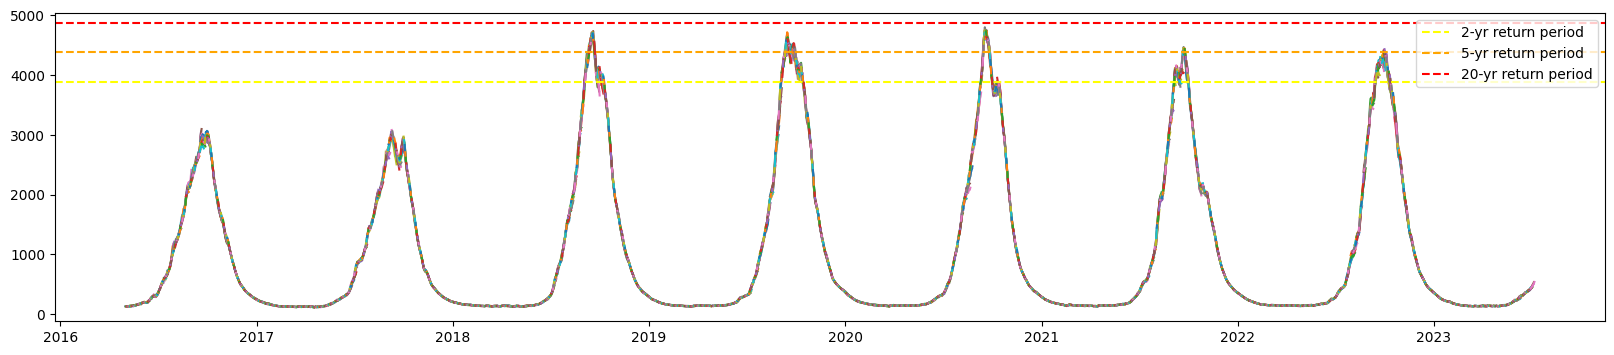

In [24]:
issue_time_start_date = '2016-05-01'
issue_time_end_date = '2024-10-30'

analyse.plot_reforecast(issue_time_start_date, issue_time_end_date,
                        ds_reforecast_1120714900, ds_return_ps_1120714900)

Importeer hier de andere timeseries data, om plotje vierkant te maken van 0-day lead time van alle modellen in kwestie voor in Sectie 2 van report; obs data ook alvast; plaats TODO of GloFAS v3 er ook bij moet nog eventueel

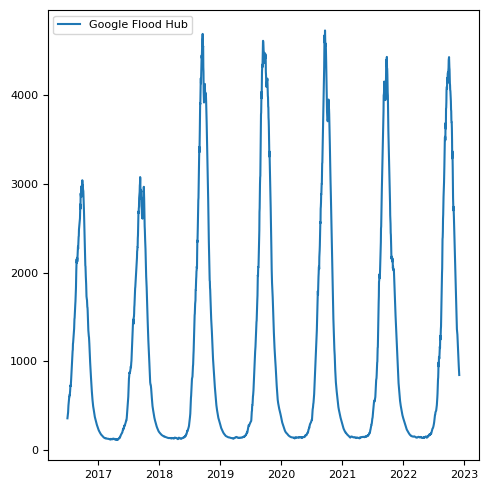

In [25]:
issue_time_start = '2016-07-01'
issue_time_end = '2022-12-01'

from typing import Tuple
import datetime
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# 0-day lead time Google Flood Hub
ds = ds_reforecast_1120714900.sel(lead_time = pd.Timedelta(days = 0))
fig, ax = plt.subplots(figsize = (5, 5))
ds_selected = ds.sel(issue_time = slice(issue_time_start, issue_time_end))
issue_times = ds_selected['issue_time']
forecast_dates = pd.to_datetime(issue_times.values)
streamflow = ds_selected.streamflow.values
ax.plot(forecast_dates, streamflow, label = 'Google Flood Hub')

# 0-day lead time GloFAS v4.0

# 0-day lead time observation data (0-day by definition)


plt.legend(loc = 'upper left', fontsize = 8)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.tight_layout()
# plt.savefig('../data/figures/timeseries_plot_section2.pdf')
plt.show()

In [26]:
import sys
# sys.exit()

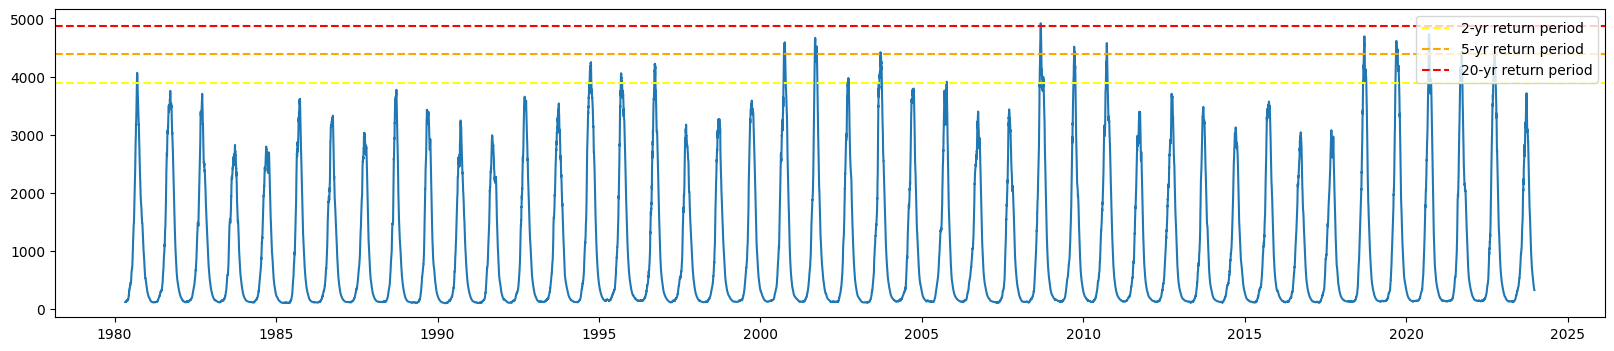

In [27]:
issue_time_start_date = '1980-05-01'
issue_time_end_date = '2024-10-30'

analyse.plot_reanalysis(issue_time_start_date, issue_time_end_date,
                        ds_reanalysis_1120714900, ds_return_ps_1120714900)

In [28]:
# # Plot all reanalysis data for Mali, 2016 - 2024:
# issue_time_start_date = '2016-05-01'
# issue_time_end_date = '2024-10-30'

# for hybas_id in dict_ds_data_Mali.keys():
#     ds_reanalysis = dict_ds_data_Mali[hybas_id]['reanalysis']
#     ds_return_ps = dict_ds_data_Mali[hybas_id]['return_periods']

#     analyse.plot_reanalysis(issue_time_start_date, issue_time_end_date,
#                             ds_reanalysis, ds_return_ps)

In [29]:
# # Plot all reforecast data for Mali, 2016 - 2024:
# issue_time_start_date = '2016-05-01'
# issue_time_end_date = '2024-10-30'

# for hybas_id in dict_ds_data_Mali.keys():
#     ds_reforecast = dict_ds_data_Mali[hybas_id]['reforecast']
#     ds_return_ps = dict_ds_data_Mali[hybas_id]['return_periods']

#     analyse.plot_reforecast(issue_time_start_date, issue_time_end_date,
#                             ds_reforecast, ds_return_ps)

In [30]:
ds_reanalysis_1120714900

<xarray.Dataset>
Dimensions:     (time: 16063)
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2023-12-23
    gauge_id    object ...
Data variables:
    streamflow  (time) float32 ...

## **Preprocessing**

Because not all gauges, i.e. most of the unverified ones, contain return period threshold (or in public phrasing in the UI (https://sites.research.google/floods/), "danger level") information, and because we want to analyse more thresholds than available, we recalculate the thresholds. We use the reanalysis data for the calculations. In the official paper (https://www.nature.com/articles/s41586-024-07145-1), the threshold calculation is done using a Log-Pearson Type III fit; it remains ambiguous, however, on what data and how exactly. Nonetheless, we recalculate using a Gumbel fit.

In [31]:
from typing import Any
import matplotlib.pyplot as plt
from scipy import stats
from pyextremes import EVA
# the final step before analysis is to calculate the return periods
# for the reforecast data datasets using the reanalysis data. We do
# this because not all reforecast data contain more than the 5-yr RP
# in the return period datasets, and we need more of them for our analysis.
# They can be calculated using a Gumbel distribution or Log-Pearson III
def calculate_annual_max(ds: xr.Dataset) -> xr.DataArray:
    """
    Given a reanalysis dataset, it computes the annual maximum
    discharge values for the dataset

    :param ds: the reanalysis dataset
    :return: the dataset with annual maximum values
    """
    # exclude non-complete years from the reanalysis dataset, because
    # these might not include the rain season, and, consequently, neither
    # the annual water rises and/or floodings, and thus the annual maxima
    # ... this subsetting procedure is moved elsewhere

    if not pd.api.types.is_datetime64_any_dtype(ds['time']):
        ds['time'] = pd.to_datetime(ds['time'].values)
    return ds['streamflow'].resample(time = 'Y').max()


def calculate_RP_Gumbel(ds: xr.Dataset, RP: float) -> float:
    """
    Given a reanalysis dataset and a return period (in years),
    it calculates the discharge value that corresponds to the
    given return period using a Gumbel distribution fit

    :param ds: the reanalysis dataset
    :param RP: the return period in years
    :return: the discharge value corresponding to the return period
    """                     
    annual_max = calculate_annual_max(ds).to_series()
    # print(annual_max)
                            # fit a Gumbel distribution to maxima
    loc, scale = stats.gumbel_r.fit(annual_max)
    return stats.gumbel_r.ppf(1 - (1 / RP), loc = loc, scale = scale)


def calculate_RP_LogPearsonIII(ds: xr.Dataset, RP: float) -> float:
    """ 
    Given a reanalysis dataset and a return period (in years),
    it calculates the discharge value that corresponds to the
    given return period using a Log-Pearson Type-III dist. fit

    :param ds: the reanalysis dataset
    :param RP: the return period in years
    :return: the discharge value corresponding to the return period
    """                     
    annual_max = calculate_annual_max(ds).to_series()
                            # log-transform the maxima and fit
                            # a Log-Pearson Type-III distribution
    shape, loc, scale = stats.pearson3.fit(np.log10(annual_max))
                            # calculate z-value for the given return period,
                            # and then the return period value by inverting
    return 10 ** stats.pearson3.ppf(1 - (1 / RP), shape, loc = loc, scale = scale)


def calculate_RP_GEV(ds: xr.Dataset, RP: float) -> float:
    """ 
    Given a reanalysis dataset and a return period (in years),
    it calculates the discharge value that corresponds to the
    given return period using a Generalized Extreme Value dist. fit

    :param ds: the reanalysis dataset
    :param RP: the return period in years
    :return: the discharge value corresponding to the return period
    """                     
    annual_max = calculate_annual_max(ds).to_series()
                            # fit a Generalized Extreme Value distribution to maxima
    loc, scale, shape = stats.genextreme.fit(annual_max)
                            #! Deze werkt niet goed, niet gebruiken
    return stats.genextreme.ppf(1 - (1 / RP), loc = loc, scale = scale, c = shape)


def calculate_RP_EVA(ds: xr.Dataset, RP: Any, method: str = 'GEV') -> float:
    """ 
    Given a reanalysis dataset and a return period (in years),
    it calculates the discharge value for the RP using the
    pyextremes.eva.EVA package for a method of choice
    
    URL: https://georgebv.github.io/pyextremes/api/eva/

    :param ds: the reanalysis dataset
    :param RP: the return period(s) in years, as float or array
    :param method: the method to use for the calculation
    :return: the discharge value corresponding to the return period
    """
    model = EVA(ds['streamflow'].to_series())

    if method == 'GEV':    # Generalized Extreme Value distribution with:
                           # block method for block maxima, default freq is annual
        model.get_extremes(method = 'BM')
        model.fit_model(distribution = 'genextreme')
    else:
        raise ValueError(f'Unknown method: {method}')
                            #! Deze werkt ook niet goed, niet gberuiken
    return_value = model.get_return_value(return_period = RP)
    # print(type(return_value))
    # print(return_value)
    return return_value[0]


print('Gumbel and Log-Pearson III return periods for RP 2-20:')
for idx in range(2, 21):
    print(f'RP {idx}: {calculate_RP_Gumbel(ds_reanalysis_1120714900, idx):.0f}, '
          f'{calculate_RP_LogPearsonIII(ds_reanalysis_1120714900, idx):.0f}, '
          f'{calculate_RP_GEV(ds_reanalysis_1120714900, idx):.0f}, '
          f'{calculate_RP_EVA(ds_reanalysis_1120714900, idx):.0f}')

Gumbel and Log-Pearson III return periods for RP 2-20:
RP 2: 3687, 3633, 508, 2804
RP 3: 3956, 3929, 627, 3021
RP 4: 4127, 4129, 637, 4704
RP 5: 4254, 4281, 639, 12068
RP 6: 4356, 4404, 639, 35399
RP 7: 4440, 4508, 640, 95460
RP 8: 4511, 4599, 640, 229278
RP 9: 4574, 4678, 640, 497365
RP 10: 4630, 4750, 640, 992449
RP 11: 4680, 4814, 640, 1849735
RP 12: 4726, 4874, 640, 3258771
RP 13: 4767, 4928, 640, 5476933
RP 14: 4806, 4979, 640, 8844581
RP 15: 4842, 5027, 640, 13801919
RP 16: 4875, 5071, 640, 20907586
RP 17: 4906, 5113, 640, 30859012
RP 18: 4936, 5153, 640, 44514565
RP 19: 4964, 5190, 640, 62917518
RP 20: 4990, 5226, 640, 87321863


In [32]:
from typing import List, Dict, Any


def add_return_periods_to_dataset(
        ds_rf: xr.Dataset,
        ds_ra: xr.Dataset,
        method: str = 'Gumbel',
        rps: List[str] = ['1.5', '2', '5', '7', '10', '20']
    ) -> xr.Dataset:
    """
    Adds return period values to the dataset for the given return periods

    :param ds_rf: the (reforecast) dataset to add return periods to
    :param ds_ra: the (reanalysis) dataset to use for the calculations
    :param method: the method to use for the calculation: either 
                   'Gumbel', 'Log-Pearson III', 'GEV', or 'EVA'
    :param rps: the return periods to calculate, default is
                [1.5, 2, 5, 7, 10, 20]
    """
    if method not in ['Gumbel', 'Log-Pearson III', 'GEV', 'EVA']:
        raise ValueError(f'Unknown method: {method}')
    if method == 'Gumbel':
        for rp in rps:
            ds_rf.attrs[f'RP_{rp}'] = calculate_RP_Gumbel(ds_ra, float(rp))
    elif method == 'Log-Pearson III':
        for rp in rps:
            ds_rf[f'RP_{rp}'] = calculate_RP_LogPearsonIII(ds_ra, float(rp))
    elif method == 'GEV':
        for rp in rps:
            ds_rf[f'RP_{rp}'] = calculate_RP_GEV(ds_ra, float(rp))
    elif method == 'EVA':
        for rp in rps:
            ds_rf[f'RP_{rp}'] = calculate_RP_EVA(ds_ra, float(rp))
    return ds_rf


def add_percentiles_to_dataset(
        ds_receiver: xr.Dataset,
        ds_provider: xr.Dataset,
        percentiles: List[int] = [95, 98, 99]
) -> xr.Dataset:
    """
    Adds percentile values to the dataset for the given percentiles

    :param ds_receiver: the (reforecast) dataset to add percentiles to
    :param ds_provider: the (reanalysis) dataset to use for the calculations
    :param percentiles: the percentiles to calculate, default is
                        [95, 98, 99]
    """
    for perc in percentiles:
        ds_receiver.attrs[f'pc_{perc}th'] = np.percentile(ds_provider['streamflow'], perc)
    return ds_receiver
    

def get_common_IDs(
        dict_rf: Dict[str, xr.Dataset],
        dict_ra: Dict[str, xr.Dataset]
    ) -> List[str]:
    """
    Returns the common IDs between the two dictionaries

    :param dict_rf: dictionary with reforecast datasets
    :param dict_ra: dictionary with reanalysis datasets
    :return: the list of common IDs
    """
    # extract only the ID part from the keys, e.g.
    # ds_reforecast_hybas_1120724680 -> 1120724680; and
    # ds_reanalysis_hybas_112072468 -> 1120724680, to match IDs
    rf_IDs = [key.split('_')[-1] for key in dict_rf.keys()]
    ra_IDs = [key.split('_')[-1] for key in dict_ra.keys()]
    return list(set(rf_IDs).intersection(set(ra_IDs)))


def assure_all_attributes_added(
        dict_rf: Dict[str, xr.Dataset],
        common_keys: List[str],
        rps: List[str],
        percentiles: List[int]
    ) -> None:
    """
    Loops over all datasets and checks if all attributes were added

    :param dict_rf: dictionary with reforecast datasets
    :param common_keys: the common keys between the dictionaries
    :param rps: the return periods to calculate
    :param percentiles: the percentiles to calculate
    """
    for key in common_keys:
        ds_rf = dict_rf[f'ds_reforecast_{key}']
        for rp in rps:
            if f'RP_{rp}' not in ds_rf.attrs:
                raise ValueError(f'RP_{rp} not added to {key}')
        for perc in percentiles:
            if f'pc_{perc}th' not in ds_rf.attrs:
                raise ValueError(f'pc_{perc}th not added to {key}')


def add_thresholds_to_dataset(
        ds_receiver: xr.Dataset,
        ds_provider: xr.Dataset,
        method: str = 'Gumbel',
        rps: List[str] = ['1.5', '2', '5', '10'],
        percentiles: List[int] = [95, 98, 99]
) -> xr.Dataset:
    """ Adds thresholds to a given dataset, calculated on another dataset.
    These can, of course, be the same one (e.g. reanalysis to reanalysis).

    :param ds_receiver: the dataset to add thresholds to
    :param ds_provider: the dataset to use for the calculations
    :param method: the method to use for the calculation
    :param rps: the return periods to calculate
    :param percentiles: the percentiles to calculate
    :return: the updated dataset
    """
    ds_receiver = add_return_periods_to_dataset(
        ds_receiver, ds_provider, method, rps
    )
    ds_receiver = add_percentiles_to_dataset(
        ds_receiver, ds_provider, percentiles
    )
    return ds_receiver


def add_RPs_and_percentiles(
        dict_rf: Dict[str, xr.Dataset],
        dict_ra: Dict[str, xr.Dataset],
        rps: List[str] = ['1.5', '2', '5', '7', '10', '20'],
        percentiles: List[int] = [95, 98, 99],
        method: str = 'Gumbel',
        verbose = True
) -> Dict[str, xr.Dataset]:
    """
    Helper function to add return periods and percentiles to all datasets

    :param dict_rf: dictionary with reforecast datasets
    :param dict_ra: dictionary with reanalysis datasets
    :param rps: the return periods to calculate
    :param percentiles: the percentiles to calculate
    :param method: the method to use for the calculation
    :param verbose: whether to print messages
    :return: the updated dictionary with all datasets
    """
    common_keys = get_common_IDs(dict_rf, dict_ra)
    
    if len(common_keys) == 0:
        raise ValueError('No common keys found between the dictionaries')
    if len(common_keys) != len(dict_rf) or len(common_keys) != len(dict_ra):
        raise ValueError('Dictionaries have different lengths')

                            # add the RPs and %'s
    idx = 1
    for key in common_keys:
        if verbose:
            if idx % 120 == 0:
                print(f'{idx/len(common_keys)*100:.2f}% done')
            idx += 1

        ds_rf = dict_rf[f'ds_reforecast_{key}']
        ds_ra = dict_ra[f'ds_reanalysis_{key}']
                            # add to reforecast dict datasets
        if rps:
            dict_rf[f'ds_reforecast_{key}'] = add_return_periods_to_dataset(
                ds_rf, ds_ra, method, rps
            )
        if percentiles:
            dict_rf[f'ds_reforecast_{key}'] = add_percentiles_to_dataset(
                ds_rf, ds_ra, percentiles
            )
                            # check if all attributes were added
    assure_all_attributes_added(dict_rf, common_keys, rps, percentiles)

    print('100% done')
    return dict_rf

In [33]:
# add return periods and percentiles to all datasets and create
# a dictionary with all values recalculated (rc) for reference
dict_datasets = \
    add_RPs_and_percentiles(dict_datasets, dict_reanalysis, ['5'], [])

1.26% done
2.51% done
3.77% done
5.03% done
6.28% done
7.54% done
8.80% done
10.05% done
11.31% done
12.57% done
13.82% done
15.08% done
16.34% done
17.59% done
18.85% done
20.11% done
21.36% done
22.62% done
23.88% done
25.13% done
26.39% done
27.65% done
28.90% done
30.16% done
31.42% done
32.67% done
33.93% done
35.19% done
36.44% done
37.70% done
38.96% done
40.21% done
41.47% done
42.73% done
43.98% done
45.24% done
46.50% done
47.75% done
49.01% done
50.27% done
51.52% done
52.78% done
54.04% done
55.29% done
56.55% done
57.81% done
59.06% done
60.32% done
61.58% done
62.83% done
64.09% done
65.35% done
66.60% done
67.86% done
69.12% done
70.37% done
71.63% done
72.89% done
74.14% done
75.40% done
76.66% done
77.91% done
79.17% done
80.43% done
81.68% done
82.94% done
84.20% done
85.45% done
86.71% done
87.97% done
89.22% done
90.48% done
91.74% done
92.99% done
94.25% done
95.51% done
96.76% done
98.02% done
99.28% done
100% done


In [34]:
dict_datasets['ds_reforecast_1120040380']

<xarray.Dataset>
Dimensions:     (issue_time: 2738, lead_time: 8)
Coordinates:
  * issue_time  (issue_time) datetime64[ns] 2016-01-01 2016-01-02 ... 2023-06-30
    gauge_id    object ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 1 days ... 6 days 7 days
Data variables:
    streamflow  (issue_time, lead_time) float32 ...
Attributes:
    RP_5:     239.01527224744933

#### **Filter insignificant gauges**

As our research focuses on "high-impact gauges" for a theoretically practical response, we filter out datasets which do not fit this purpose. In other words, we set a (admittedly, somewhat arbittrary) threshold for filtering some gauges: if the 5-year RP is below 100 $m^3/s$, a gauge is discarded. Since we will chiefly use maxima of the data later, the only real effect of this is some districts now being "left out" as they have no gauge, and a significant speed-up of the calculations.

In [35]:
# # compare some of the calculated return periods with the actual values from Google
# import matplotlib.pyplot as plt
# import seaborn as sns

# original_5YR_RP_values = [float(ds['return_period_5']) for ds in dict_return_periods.values() if\
#                            'return_period_5' in ds]
# calculated_5YR_RP_values = [float(ds.attrs['RP_5']) for ds in dict_datasets.values() if\
#                              'RP_5' in ds.attrs]
# df = pd.concat([pd.DataFrame({'rp': original_5YR_RP_values,
#                               'type': 'original'}),
#                 pd.DataFrame({'rp': calculated_5YR_RP_values,
#                               'type': 'calculated'})])
# sns.histplot(data = df, x = 'rp', hue = 'type', alpha = 0.5, edgecolor = None)
# plt.axvline(x = 100, color = 'red', linestyle = '--')
# plt.show()

In [36]:
dict_datasets_non_filtered = dict_datasets.copy()
dict_reanalysis_non_filtered = dict_reanalysis.copy()

In [ ]:
sys.exit()

In [37]:
# exclude all datasets where the 5-yr RP is below 100
dict_datasets = {key: value for key, value in dict_datasets.items() if \
                    float(value.attrs['RP_5']) >= 100}

def extract_number_part(s):
    return s.split('_')[2]

datasets_numbers = set(extract_number_part(k) for k in dict_datasets.keys())
dict_reanalysis = {key: value
                   for key, value in dict_reanalysis.items()
                   if extract_number_part(key) in datasets_numbers}


print(len(dict_datasets))
print(len(dict_datasets_non_filtered))
print(len(dict_reanalysis))

709
9549
709


#### **Create a specific use-case**

We create a timeseries plot for Bamako with the GFH-, GloFAS-, and DNH-station/gauge for a visual comparison in the paper. As they have different return periods, we normalise by the return period to make the lines more comparable. We take the 7-day lead time forecasts and a 5-year return period threshold.

We find the gauge ID that is placed in the admin unit of Bamako, in the city named Bamako, Mali's capital. The pcode of admin unit is ML0901, and the river gauge ID 1120714900 (EDIT: changed to 1121916250).

In [39]:
# first, we select the Bamako station reforecast data out of the GRRR
ds_Bamako = dict_datasets['ds_reforecast_1121916250']
df_Bamako = ds_Bamako['streamflow'].to_dataframe().drop(columns = 'gauge_id')
df_Bamako = df_Bamako.unstack(level = 'lead_time')
df_Bamako.columns = df_Bamako.columns.droplevel()
df_Bamako.index = pd.to_datetime(df_Bamako.index)
df_Bamako.to_csv('../data/processed/Bamako/Bamako_streamflow.csv')
df_Bamako_7d = pd.DataFrame(df_Bamako['7 days'])
df_Bamako_7d.columns = ['Q']
df_Bamako_7d['actual_date'] = df_Bamako_7d.index + pd.Timedelta(days = 7)
df_Bamako_7d.set_index('actual_date', inplace = True)
print(type(df_Bamako_7d))
print(df_Bamako_7d.head(2))
print(df_Bamako_7d.tail(2))

# we also select the return period values for the Bamako station
add_return_periods_to_dataset(ds_Bamako, ds_reanalysis_1120714900)
Bamako_GFH_5yr_RP = ds_Bamako.attrs['RP_5']
print('\n', Bamako_GFH_5yr_RP)

<class 'pandas.core.frame.DataFrame'>
                      Q
actual_date            
2016-01-08   302.472321
2016-01-09   298.740051
                      Q
actual_date            
2023-07-06   532.951965
2023-07-07   531.686951

 4254.4640287331495


In [40]:
# second, we import the appropriate timeseries for GloFAS
df_Bamako_GloFAS = pd.read_csv('../../GloFAS/data/timeseries/discharge_timeseries_Bamako_168.csv')
df_Bamako_GloFAS = df_Bamako_GloFAS[['ValidTime', 'percentile_40.0']]
# rename columns
df_Bamako_GloFAS.columns = ['ValidTime', 'Q']
df_Bamako_GloFAS.columns = ['actual_date', 'Q']
df_Bamako_GloFAS['actual_date'] = pd.to_datetime(df_Bamako_GloFAS['actual_date'])
df_Bamako_GloFAS.set_index('actual_date', inplace = True)
df_Bamako_GloFAS.sort_index(inplace = True)
print(type(df_Bamako_GloFAS))
print(df_Bamako_GloFAS.head(2))
print(df_Bamako_GloFAS.tail(2))

# we also select the return period values for the GloFAS station
# TBC...

<class 'pandas.core.frame.DataFrame'>
                      Q
actual_date            
2004-01-08   323.109375
2004-01-11   311.709375
                     Q
actual_date           
2023-03-28   166.10625
2023-04-01   168.38125


### **Checkpoint: adjust comparison type, lead time, or threshold from here**

From here, with the datasets and various return period calculated, the script can be ran with different configurations to generate different kinds of plots and metrics, which will all be exported (except for the plots) to the `data/` folder. The options are:

* For comparison type (**COMP_TYPE**): IMPACT or OBS (observation), giving a comparison to either events as entailed by the impact event data or observational timeseries data. Impact data is provided per administrative unit, and to accomodate this, the forecast data is aggregated to this level. Observation data is just station-based. Note that the comparison will differ in sample size due to differing data types and data sizes, and the fact that flood events are discarded based on some criteria from the used comparative dataset (see below).
* For lead time (**LEAD_TIME**), the options are 1 to 7, since the GFH model does an autoregressive 7-day horizon forecast at each issue time.
* For threshold (**THRESHOLD**), the options are 1.5-, 2-, 5-, 10-year return period thresholds, as calculated through the timeseries maxima, or the 95th, 98th, 99th percentile thresholds, as calculated through the mean. For OBSERVATION though, because we only have 2 years of overlap between the data, we discard more extreme threshold, i.e. the 10-year one.

One calculation can take up to 30 minutes, depending on whether some common precalculations are done (and stored) already.
```
comp_types = ['IMPACT', 'OBS']
thresholds = [1.5, 2, 5, 7, 10, 20, 95, 98, 99]
lead_times = [1, 2, 3, 4, 5, 6, 7]
```

In [41]:
COMP_TYPE = 'OBS'
THRESHOLD = 5
LEAD_TIME = 7

#### **Creating forecasted/ground truth "events" to later calculate their overlap**

Now that we have preprocessed (re)forecast datasets per gauge with a lead time of up to 7 days and with attributes such as coordinates and return period thresholds, we can process them further. We take all datasets in an administrative unit (level 2) and:
* subset a certain lead time (LEAD_TIME) to analyse;
* aggregate them using the maximum per timestep;
* aggregate the return periods with the maximum per threshold; and
* create new datasets per administrative unit with the aggregated timeseries and updated attributes.

With datasets per admin unit ready, we loop through them to create "flood events": periods of consecutive flooding in an administrative unit. A flood event is "triggered" once the maximum chosen lead time (LEAD_TIME) predicted discharge in an administrative unit surpasses the return period threshold (THRESHOLD) for more than one day. 

Later, these can be compared to impact events (IMPACT) or observation events (OBSERVATION) to determine overlap, e.g. through boolean masking, and calculate metrics.

In [ ]:
from typing import Dict
# add a the qualityVerified flag from the ListGauges() API call
# to the gauge datasets as attribute, for plotting and matching
def add_quality_verified_flag(
        d_ds: Dict[str, xr.Dataset],
        df_flags: pd.DataFrame
    ) -> xr.Dataset:
    """ Adds an attribute to each dataset in the dictionary of datasets
    from the column 'qualityVerified' in the DataFrame of flags,
    corresponding to the matching 'gaugeId' column in the df.

    Keys in the dict look like: 'ds_1120040380',
    and the gaugeId column like: 'hybas_1120040380',
    so the strings need to be adjusted to match.

    :param d_ds: dictionary of datasets
    :param df_flags: DataFrame with cols 'gaugeId' and 'qualityVerified'
    :return: dictionary of datasets with added attribute 'qualityVerified'
    """
    for key in d_ds.keys():
        if key.startswith('ds_reforecast_'):
            gauge_id = key.replace('ds_reforecast_', 'hybas_')
        elif key.startswith('ds_reanalysis_'):
            gauge_id = key.replace('ds_reanalysis_', 'hybas_')
        else:
            raise ValueError(f'Unknown key: {key}')

        quality_verified = df_flags[df_flags['gaugeId'] == gauge_id]['qualityVerified'].values[0]
        d_ds[key].attrs['qualityVerified'] = quality_verified

    return d_ds

In [63]:
dict_datasets = add_quality_verified_flag(dict_datasets, df_Mali_gauges)
dict_datasets_non_filtered = add_quality_verified_flag(dict_datasets_non_filtered, df_Mali_gauges)
dict_reanalysis = add_quality_verified_flag(dict_reanalysis, df_Mali_gauges)

In [65]:
gauge_id = [key for key, value in dict_datasets.items() if value.attrs['qualityVerified'] == 1][0]
print(gauge_id)

ds_reforecast_1120641660


In [66]:
# To automate the classification of the gauges into administrative units,
# we first need to add coordinates to of every gauge dataset
from typing import Dict
import pandas as pd
import xarray as xr


def index_country_gauge_coords(df_gauges: pd.DataFrame) -> pd.DataFrame:
    """
    Return the DataFrame with gauge names and coordinates of a specific country

    :param df_gauges: DataFrame with gauge information
    :param country_name: Name of the country
    :return: DataFrame with gauge names and coordinates of a specific country
    """
    return df_gauges.set_index('gaugeId')[['latitude', 'longitude']]


def export_country_gauge_coords(
        df_gauges: pd.DataFrame, country_name: str = None
    ) -> None:
    """
    Export gauge names and coordinates of a specific country to .csv.
    Optionally prints them as well (default = False)

    :param df_gauges: DataFrame with gauge information
    :param country_name: Name of the country
    """
    df_subset = index_country_gauge_coords(df_gauges)
    df_subset.to_csv(f"../data/processed/gauge_coords/{country_name}_gauge_coords.csv",
                     index = True,
                     sep = ';',
                     decimal = '.',
                     encoding = 'utf-8')
    

def get_country_gauge_coords(country: str) -> pd.DataFrame:
    """
    Get the coordinates of the gauges in a country, stored in data/ folder

    :param country: name of the country
    :return: DataFrame with the gaugeId, latitude and longitude
    """
    if country[0].islower():
        country = country.capitalize()
    return pd.read_csv(f'../data/processed/gauge_coords/{country}_gauge_coords.csv',
                       index_col = None, sep = ';', decimal = '.')


def assign_coords_to_datasets(
        datasets: Dict[str, xr.Dataset], country: str
    ) -> xr.Dataset:
    """
    Takes a dict of datasets and assigns their coordinates, which it gets
    from get_country_gauge_coords(), and assigns it to each dataset. The
    dict contains the names of the datasets as keys and the datasets as values

    :param datasets: dict of datasets
    :param country: name of the country
    :return: dict of datasets with coordinates
    """
    df_coords = get_country_gauge_coords(country)

    for gauge_id, dataset in datasets.items():
        # assumes full name, e.g. 'hybas_1120661040', in df_coords, thus creating
        # a comparison of solely the hybas numbers, not the full name or dataset identifier
        coords = df_coords[
            df_coords['gaugeId'].apply(lambda x: x.split('_')[-1]) == gauge_id.split('_')[-1]
        ]

        if not coords.empty:
            # add the coordinates to the dataset as attributes
            dataset.attrs['latitude'] = coords['latitude'].values[0]
            dataset.attrs['longitude'] = coords['longitude'].values[0]
            # add the hybas_id to the dataset as well (e.g. '1120661040')
            dataset.attrs['gauge_id'] = gauge_id.split('_')[-1]
        else:
            print(f'No coordinates found for gauge {gauge_id}') 

    return datasets

In [76]:
# With the coordinates added, we can classify the gauges into administrative units
import analyse
from typing import Dict
import warnings
import pandas as pd
import geopandas as gpd
import xarray as xr


def create_coords_df_from_ds(dict_ds: Dict[str, xr.Dataset]) -> pd.DataFrame:
    """
    Create a DataFrame with all gauge ID's and coordinates in a
    dictionary with xarray Datasets

    :param dict_ds: xarray Dataset
    :return: DataFrame with the coordinates
    """
    return pd.DataFrame([
        {
            'gauge_id': ds.attrs['gauge_id'],
            'longitude': ds.attrs['longitude'],
            'latitude': ds.attrs['latitude']
        }
        for ds in dict_ds.values()
    ])


def assure_admin_units_assigned(dict_ds: Dict[str, xr.Dataset]) -> None:
    """
    Check if all datasets have been assigned an admin unit

    :param dict_ds: dict of datasets
    """
    for ds in dict_ds.values():
        if 'admin_unit' not in ds.attrs:
            print(f'No admin unit assigned to dataset {ds.attrs["gauge_id"]}')
            continue
        admin_unit = ds.attrs['admin_unit']
        if any(pd.isna(unit) for unit in admin_unit):
            print(f'No admin unit assigned to dataset {ds.attrs["gauge_id"]} (NaN found)')


def handle_NaN_admin_units(codes: pd.Series) -> list:
    """
    Handle NaN values in the series of administrative unit assignments for gauges

    :param codes: Series containing administrative unit codes (ADM2_PCODE) for a gauge
    :return: list of valid administrative unit codes (ADM2_PCODE)
    """
    if codes.isna().any():
        # This usually is because a gauge will be just outside Mali
        print(f"Warning: Found NaN in administrative unit assignment "
              f"for gauge IDs: {codes[codes.isna()].index.tolist()}")
    return list(codes.dropna())


def assign_admin_unit_to_datasets(
        dict_ds: Dict[str, xr.Dataset],
        country: str = 'Mali',
        verbose: bool = False,
        # Path to the shape file with admin level 2 units for Mali
        path: str = 'mali_ALL/mli_adm_ab_shp/mli_admbnda_adm2_1m_gov_20211220.shp',
        buffer_radius: int = 5000
    ) -> Dict[str, xr.Dataset]:
    """
    Assigns the administrative unit to each dataset in the dictionary by:
    (1) assiging coordinates to the datasets, with assign_coords_to_datasets(),
        which takes information queried by ListGauges() in the 'extract' package
    (2) creating a GeoDataFrame from the dataset coordinates, which includes a
        5 km buffer around the gauges, to account for shape file inaccuracies and,
        more importantly, the fact that gauges are usually located in rivers, which,
        in turn, are usually borders between administrative units, causing gauges to
        be located in only onr of the units, while they effectively tell about both.
        With a buffer, this is accounted for, and, as a result, gauges can be assigned
        to multiple administrative units, if they simply intersect with multiple units
    (3) creating a GeoDataFrame from the shape file with the admin units, source:
        (https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/)
    (4) classifying the gauges into the administrative units by joining the two above
    (5) adding the admin unit names to the datasets by matching the gauge ID's and
        the found administrative units
    (6) returning the updated dictionary with the datasets, with datasets that now have
        the attributes 'longitude', 'latitude', and 'admin_unit'

    :param dict_ds: dict of datasets
    :param country: name of the country
    :param verbose: whether to print some test print-s's
    :param path: path to the shape file with the admin units
    :param buffer_radius: radius of the buffer around the gauges, standard is 5 km
    :return: dict of datasets with administrative units
    """
    #* (1): assign coordinates to the datasets
    dict_ds = assign_coords_to_datasets(dict_ds, country)
    # print(next(iter(dict_ds.items()))) if verbose else None

    #* (2): create a GeoDataFrame from the dataset coordinates;
    # geometry is a point for each gauge, with coords (x, y)
    df_gauge_coords = create_coords_df_from_ds(dict_ds)
    gpd_Mali_gauge_coords = gpd.GeoDataFrame(
        df_gauge_coords,
        geometry = gpd.points_from_xy(
            df_gauge_coords['longitude'], df_gauge_coords['latitude']
        ),
        crs = 'EPSG:4326'
    )
    # add a buffer of 5 km around the points to account for inaccuracies,
    # where 1 degree is approx. 111,32 km at the equator, so in degrees (which
    # we have to use as the coordinate system is WGS84), 5 km is 5000 meter \
    # divided by 111.320 meters (5000 / 111320). This is a rough estimate, but
    # should be sufficient, since the number of 5 km is too mostly arbirtrary.
    # Also, surpress the warning that the buffer is not exact, as we are aware
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gpd_Mali_gauge_coords['geometry'] = \
            gpd_Mali_gauge_coords.geometry.buffer(buffer_radius / 111320)

    #* (3): read the shape file into a GeoDataFrame and convert it to WGS84
    # (which is the coordinate system used by the gauge data)
    gpd_adm_units_Mali = analyse.get_shape_file(path).to_crs('EPSG:4326')
    # check if the coord systems are the same
    if gpd_adm_units_Mali.crs != gpd_Mali_gauge_coords.crs:
        gpd_adm_units_Mali = gpd_adm_units_Mali.to_crs(gpd_Mali_gauge_coords.crs)
    analyse.assert_same_coord_system(gpd_adm_units_Mali, gpd_Mali_gauge_coords)

    #* (4) now we can classify the gauges into the administrative units:
    # creating a joined dataframe with the gauges as basis, meaning
    # that gauges get assigned to the admin unit they are within,
    # including their metadata (such as the shape of the admin unit).
    # (And, thus, the rest of the admin units are not considered.)
    gpd_gauges_classified = gpd.sjoin(
        gpd_Mali_gauge_coords, gpd_adm_units_Mali,
        how = 'left',           # joins left, i.e. the gauges serve as basis
                                # checks if the gauge intersects with the admin unit
        predicate = 'intersects',
        lsuffix = 'gauge', rsuffix = 'adm'
    )
    print(gpd_gauges_classified.head(1)) if verbose else None
    # make a mapping of the gauge ID's and the admin unit names:
    # group by gauge ID; select the admin unit names; check for NaNs;
    # convert to list; then dictionary with {gauge_id: [admin_unit]}
    mapping = gpd_gauges_classified.groupby('gauge_id')['ADM2_PCODE']\
        .apply(handle_NaN_admin_units).to_dict()

    #* (5) lastly, we add the admin unit names to the datasets
    print(mapping) if verbose else None
    for gauge_id, admin_units in mapping.items():
        dict_ds[f'ds_{gauge_id}'].attrs['admin_unit'] = admin_units

    #* (6) check result and return
    assure_admin_units_assigned(dict_ds)
    print('\n\n', next(iter(dict_ds.items()))) if verbose else None
    return dict_ds

Using coordinates gathered through the API, the GRRR dataset, and shape files for Mali's administrative level 2, we assign each gauge dataset an admin unit. A caveat here is that gauges are often located in or near rivers, and that rivers (and waterbodies in general) often form borders between certain regions. In this case, administrative units of level 2. As such, an on-border gauge will arbitrarily fall into one of its nearby regions, while a flood at its location will affect all its nearby regions. To account for this, we change a gauge's location from a point to a circle with a radius of 5 km, and all regions that overlap are considered a match.

After this step, the datasets contain a:
* **gauge ID**: unique identifier;
* **quality flag**: whether the gauge's forecasts are "verified" or "unverified"
* **administrative unit ID**: the administrative units te gauge falls into; and
* **coordinates**: a latitude and longitude,

which are assured below.

In [72]:
# make sure country gauge coords are available and then assign them
export_country_gauge_coords(df_Mali_gauges, 'Mali')

dict_datasets = {key.replace('ds_reforecast_', 'ds_'): value \
                 for key, value in dict_datasets.items()}
dict_datasets_non_filtered = {key.replace('ds_reforecast_', 'ds_'): value \
                              for key, value in dict_datasets_non_filtered.items()}
dict_reanalysis = {key.replace('ds_reanalysis_', 'ds_'): value \
                   for key, value in dict_reanalysis.items()}

In [77]:
print('\t\tAssigning for dict_datasets...')
dict_datasets = assign_admin_unit_to_datasets(dict_datasets)
print('\n\n\t\tAssigning for dict_datasets_non_filtered...')
dict_datasets_non_filtered = assign_admin_unit_to_datasets(dict_datasets_non_filtered)
print('\n\n\t\tAssigning for dict_reanalysis...')
dict_reanalysis = assign_admin_unit_to_datasets(dict_reanalysis)

		Assigning for dict_datasets...


		Assigning for dict_datasets_non_filtered...


		Assigning for dict_reanalysis...


In [78]:
# check if all datasets in dict_datasets have been assigned the 
# attributes: 'longitude', 'latitude', and 'admin_unit'
def assure_admin_units_assigned(dict_datasets: Dict[str, xr.Dataset]):
    """ 
    Check if all datasets have been assigned an admin unit,
    including coordinates, gauge_id, and qualityVerified

    :param dict_datasets: dict of datasets
    """
    for ds in dict_datasets.values():
        assert 'gauge_id' in ds.attrs, f'No gauge ID assigned to dataset {ds}'
        assert 'qualityVerified' in ds.attrs, f'No qualityVerified assigned to dataset {ds.attrs["gauge_id"]}'
        assert 'admin_unit' in ds.attrs, f'No admin unit assigned to dataset {ds.attrs["gauge_id"]}'
        assert 'latitude' in ds.attrs, f'No latitude assigned to dataset {ds.attrs["gauge_id"]}'
        assert 'longitude' in ds.attrs, f'No longitude assigned to dataset {ds.attrs["gauge_id"]}'


assure_admin_units_assigned(dict_datasets)
assure_admin_units_assigned(dict_datasets_non_filtered)
assure_admin_units_assigned(dict_reanalysis)

In [79]:
def count_admin_units(dict_datasets: Dict[str, xr.Dataset]) -> int:
    """
    Count how many admin units all gauges have in total in their 'admin_unit' attribute (list)

    :param dict_datasets: dict of datasets
    :return: total number of admin units
    """
    return sum(len(ds.attrs['admin_unit']) for ds in dict_datasets.values())


def count_gauge_ids(dict_datasets: Dict[str, xr.Dataset]) -> int:
    """
    Count how many gauge IDs are in the dictionary of datasets

    :param dict_datasets: dict of datasets
    :return: total number of gauge IDs
    """
    return len(dict_datasets)


print(count_admin_units(dict_datasets))
print(count_gauge_ids(dict_datasets))
print(count_admin_units(dict_datasets_non_filtered))
print(count_gauge_ids(dict_datasets_non_filtered))
print(count_admin_units(dict_reanalysis))
print(count_gauge_ids(dict_reanalysis))

968
709
10842
9549
968
709


In [80]:
print(dict_datasets['ds_1120766460'])

<xarray.Dataset>
Dimensions:     (issue_time: 2738, lead_time: 8)
Coordinates:
  * issue_time  (issue_time) datetime64[ns] 2016-01-01 2016-01-02 ... 2023-06-30
    gauge_id    object ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 1 days ... 6 days 7 days
Data variables:
    streamflow  (issue_time, lead_time) float32 ...
Attributes:
    RP_5:             984.7522319527934
    qualityVerified:  True
    latitude:         11.222916666665526
    longitude:        -8.485416666669323
    gauge_id:         1120766460
    admin_unit:       ['ML0306']


In [81]:
def import_DNH_station_coords(
        path = '../data/processed/gauge_coords/DNH_station_coords.csv'
) -> pd.DataFrame:
    """ Import the coordinates of the DNH stations from the .csv file

    :param path: path to the .csv file with the DNH station coordinates
    :return: DataFrame with the DNH station coordinates
    """
    df = pd.read_csv(path, index_col = None, sep = ',', decimal = '.')
    df = df.rename(columns = {'Lat': 'latitude',
                              'Lon': 'longitude',
                              'Station names': 'name'})
    df['name'] = df['name'].str.strip()
    return df.drop(columns = 'Catchment area (km2)')

def exclude_DNH_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """ Excludes Guelelinkoro from the DNH stations because
    of its location close to a dam (which is not accounted
    for in the forecasting models)
    
    :param df: DataFrame with the DNH station coordinates
    :return: DataFrame with the DNH station coordinates, excluding Guelelinkoro
    """
    return df[df['name'] != 'Guelelinkoro']    


df_DNH_station_coords = exclude_DNH_outliers(import_DNH_station_coords())

In [98]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


def plot_admin_units_with_gauges(
        dict_ds: Dict[str, xr.Dataset],
        dict_ds_all: Dict[str, xr.Dataset] = None,
        add_dots: bool = False,
        add_quality_verified: bool = False,
        add_DNH_stations: bool = False,
        df_DNH_stations: pd.DataFrame = None,
        path = 'mali_ALL/mli_adm_ab_shp/mli_admbnda_adm2_1m_gov_20211220.shp'
    ) -> None:
    """
    Plot the administrative units of a country with the gauges contained in them

    :param dict_ds: dict of gauge datasets
    :param dict_ds_all: dict of all gauge datasets
    :param add_dots: whether to add dots for the gauges
    :param add_quality_verified: whether to distinct between (un)verified gauges
    :param add_DNH_stations: whether to add the DNH stations to the plot
    :param path: path to the shape file with the admin units
    """
    # create a GeoDataFrame with the coordinates of the gauges
    # (code copied from assign_admin_unit_to_datasets())
    df_gauge_coords = create_coords_df_from_ds(dict_ds)
    gpd_Mali_gauge_coords = gpd.GeoDataFrame(
        df_gauge_coords,
        geometry = gpd.points_from_xy(
            df_gauge_coords['longitude'], df_gauge_coords['latitude']
        ),
        crs = 'EPSG:4326'
    )
    # add a buffer of 5 km around the points to account for inaccuracies,
    # where 1 degree is approx. 111,32 km at the equator, so in degrees (which
    # we have to use as the coordinate system is WGS84), 5 km is 5000 meter \
    # divided by 111.320 meters (5000 / 111320). This is a rough estimate, but
    # should be sufficient, since the number of 5 km is too mostly arbirtrary.
    # Also, surpress the warning that the buffer is not exact, as we are aware
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gpd_Mali_gauge_coords['geometry'] = \
            gpd_Mali_gauge_coords.geometry.buffer(5000 / 111320)

    # create a GeoDataFrame with the coordinates of all gauges
    # to add them to the plot, but only when they're provided
    if dict_ds_all is not None:
        df_gauge_coords_all = create_coords_df_from_ds(dict_ds_all)
        df_extra_gauge_coords = df_gauge_coords_all.loc[~df_gauge_coords_all.index.isin(df_gauge_coords.index)]
        gpd_extra_gauge_coords = gpd.GeoDataFrame(
            df_extra_gauge_coords,
            geometry = gpd.points_from_xy(
                df_extra_gauge_coords['longitude'], df_extra_gauge_coords['latitude']
            ),
            crs = 'EPSG:4326'
        )


    # make a GeoDataFrame with the administrative units
    gpd_adm_units_Mali = analyse.get_shape_file(path).to_crs('EPSG:4326')
    # A quick intermediary plot to see which admin units are contained in the datasets:
    # We want to make a plot where each administrative unit with a gauge gets a tinted
    # colour. Thus, we now join the GeoDataFrames the other way around
    gpd_adm_units_with_gauges = gpd.sjoin(
        gpd_adm_units_Mali, gpd_Mali_gauge_coords,
        how = 'left',
        predicate = 'intersects', # see if they intersect with one another
        lsuffix = 'adm', rsuffix = 'gauge'
    )

    print('Administrative units in Mali:', len(gpd_adm_units_Mali))
    # Drop the column where index_gauge (aka index_right) is NaN,
    # because that means that the admin unit does not contain a gauge
    gpd_adm_units_with_gauges = gpd_adm_units_with_gauges.dropna(subset = ['index_gauge'])
    # 15 gauges left, so there's one administrative unit with two gauges
    print('Administrative units with a gauge: ', end = '')
    print(len(gpd_adm_units_with_gauges['ADM2_PCODE'].unique()))
    # Plot using 510 colours
    red, blue, dot_c, green, yellow = '#DB0A13', '#3674B5', '#80C4E9', '#118B50', '#FFE31A'
    fig, ax = plt.subplots(figsize = (10, 10))

    # New version:
    ax.set_facecolor('#C6C6C6')  # sets the background (outside Mali) to gray
    gpd_adm_units_Mali.plot(ax = ax, color = '#686D76', edgecolor = 'black', linewidth = 0.5)
    gpd_adm_units_with_gauges.plot(ax = ax, color = 'white', edgecolor = 'black', linewidth = 0.5)
    # Old version:
    # gpd_adm_units_Mali.plot(ax = ax, color = blue, edgecolor = 'black', linewidth = 0.5)
    # gpd_adm_units_with_gauges.plot(ax = ax, color = red, edgecolor = 'black', linewidth = 0.5)

    # Add legend handles as list (which gives the option to add more later)
    legend_handles = [
        Patch(color = 'white', label = 'district with gauge'),
        Patch(color = '#686D76', label = 'district without gauge'),
    ]
    # If add dots, add all coordinates of the gauges as dots, including as legend;
    # if add_quality_verified, add a different colour for the qualityVerified gauges
    if add_dots:

        if dict_ds_all is not None:
            ax.scatter(
                gpd_extra_gauge_coords.geometry.x,
                gpd_extra_gauge_coords.geometry.y,
                color = dot_c, s = 3, alpha = 1, marker = 'x'
            )
            legend_handles.append(
                Line2D([0], [0], marker = 'x', color = dot_c, markersize = 5, alpha = 1, linestyle = '',
                       label = 'excluded gauge')
            )

        latitudes = [ds.latitude for ds in dict_ds.values()]
        longitudes = [ds.longitude for ds in dict_ds.values()]
        if add_quality_verified:
            quality_verified = [ds.qualityVerified for ds in dict_ds.values()]
            x_verified = [lon for lon, qv in zip(longitudes, quality_verified) if qv]
            y_verified = [lat for lat, qv in zip(latitudes, quality_verified) if qv]
            x_unverified = [lon for lon, qv in zip(longitudes, quality_verified) if not qv]
            y_unverified = [lat for lat, qv in zip(latitudes, quality_verified) if not qv]
            ax.scatter(x_unverified, y_unverified, color = blue, s = 12, alpha = 1)
            ax.scatter(x_verified, y_verified, color = red, s = 30, alpha = 1)
            legend_handles.extend([
                Line2D([0], [0], marker = 'o', color = red, markersize = 7, alpha = 1, linestyle = '',
                          label = 'verified gauge'),
                Line2D([0], [0], marker = 'o', color = blue, markersize = 7, alpha = 1, linestyle = '',
                            label = 'unverified gauge')
                # Patch(color = green, label = 'Verified gauge'),
                # Patch(color = dot_c, label = 'Unverified gauge')
            ])
        else:
            ax.scatter(longitudes, latitudes, color = dot_c, s = 7, alpha = 1)
            legend_handles.append(
                Line2D([0], [0], marker = 'o', color = dot_c, markersize = 7, alpha = 1, linestyle = '',
                       label = 'FloodHub gauges')
            )

        if add_DNH_stations:
            gpd_DNH_stations = gpd.GeoDataFrame(df_DNH_stations,
                                                geometry = gpd.points_from_xy(
                                                    df_DNH_stations['longitude'], df_DNH_stations['latitude']
                                                ), crs = 'EPSG:4326')
            ax.scatter(
                gpd_DNH_stations.geometry.x, gpd_DNH_stations.geometry.y,
                color = 'orange', s = 30, alpha = 1, marker = 'D'
            )
            legend_handles.append(
                Line2D([0], [0], marker = 'D', color = 'orange', markersize = 5, alpha = 1, linestyle = '',
                       label = 'DNH station')
            )
            
            # # create 10 km buffer around the DNH stations    
            # gpd_buffer = gpd.GeoDataFrame(geometry = gpd_DNH_stations.geometry.buffer(10 / 111320),
            #                               crs = 'EPSG:4326')
            # gpd_buffer.plot(ax = ax, facecolor = 'none', edgecolor = yellow,
            #                 linewidth = 1, alpha = 1)
            # legend_handles.append(
            #     Patch(facecolor = 'none', edgecolor = yellow, linewidth = 1, alpha = 0.5, label = f'10 km buffer')
            # )

    # This comment is now irrelevant but kept for reference (e.g. to use as example in paper)
    # # The coordinates of gauge 1120766460 seem to be slightly off, and
    # # coincidentally, it is placed outside of Mali and not within an admin unit   
    # # ax.plot(-8.485416666669321, 11.22291666666553, 'go', markersize = 2)
    ax.legend(handles = legend_handles, loc = 'upper right', fontsize = 16)
    # ax.set_xlabel('longitude (degrees)', fontsize = 20)
    # ax.set_ylabel('latitude (degrees)', fontsize = 20)
    # plt.xticks(fontsize = 20)
    # plt.yticks(fontsize = 20)
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_title('Verified and unverified GRRR gauges in Mali', fontsize = 20)
    plt.tight_layout()
    # erase the black border around the picture
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    # save as pdf
    plt.savefig('../data/figures/Mali_gauges.pdf')
    plt.show()

Administrative units in Mali: 53
Administrative units with a gauge: 41


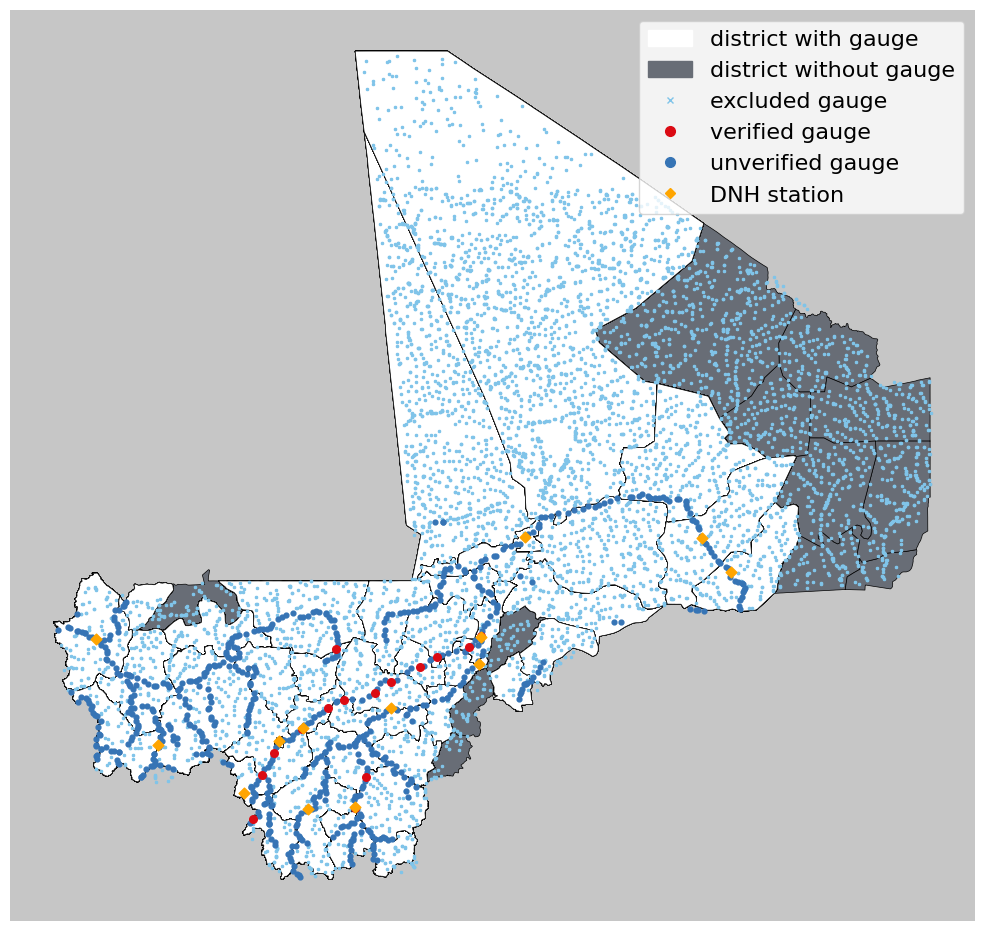

In [99]:
# Give None as second argument to not plot the non-filtered gauges
plot_admin_units_with_gauges(dict_datasets, dict_datasets_non_filtered,
                             True, True, True, df_DNH_station_coords)

In [ ]:
sys.exit()

In [100]:
print(len(dict_datasets.keys()), len(dict_reanalysis.keys()))

709 709


In [ ]:
# del dict_datasets_non_filtered

In [102]:
# we match DNH stations to either a verified unit within a radius of
# 10 km, or else, to the closest gauge available. We export a mapping.
from scipy.spatial import cKDTree
import json


def haversine(
        lon1: float, lat1: float, lon2: float, lat2: float
    ) -> float:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees);
    https://stackoverflow.com/questions/4913349/haversine-formula
    -in-python-bearing-and-distance-between-two-gps-points

    :param lon1: longitude of point 1
    :param lat1: latitude of point 1
    :param lon2: longitude of point 2
    :param lat2: latitude of point 2
    :return: distance in km
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * \
        np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6367 * c


def match_DNH_stations_to_gauges(
        df_DNH: pd.DataFrame,
        dict_gauges: Dict[str, xr.Dataset],
        radius: int = 10
    ) -> Dict[str, str]:
    """
    Match DNH stations to the closest gauges using a KDTree O(NlogN)
    if no verified gauge is available within a radius of 10 km

    :param df_DNH: DataFrame with the DNH station coordinates
    :param dict_gauges: the dictionary with gauge datasets
    :param radius: the radius to search for verified gauges
    :return: mapping of DNH to closest gauge
    """
    verified_gauges = [gauge_id for gauge_id, ds in dict_gauges.items() \
            if ds.attrs['qualityVerified'] == True]
    verified_tree = cKDTree(np.array([
        [dict_gauges[g].attrs['latitude'], dict_gauges[g].attrs['longitude']] \
            for g in verified_gauges
    ]))
    # for every DNH station, see if a gauge is within 10 km radius by calculating th
    # radius of a 10 km circle (without adjusting for the earth's curvature) and then
    # seeing if there is a verified gauge within that Euclidian distance. If not, just
    # pick the closest one from the normal Tree
    all_gauges = list(dict_gauges.keys())
    normal_tree = cKDTree(np.array([
        [dict_gauges[g].attrs['latitude'], dict_gauges[g].attrs['longitude']] \
        for g in all_gauges
    ]))
    
    mapping_to_PCODE = {}       # make a mapping to admin unit just for later; and
    mapping = {}                # for every DNH station, get a verified gauge
                                # from the verified tree, see if it's within
                                # the radius, else get one from the normal tree 
    for _, row in df_DNH.iterrows():
        coords = np.array([row['latitude'], row['longitude']])
        distances, idx = verified_tree.query(coords, k = 1)
        # print(distances, idx)

        g_id = verified_gauges[idx]
        lat = dict_gauges[verified_gauges[idx]].attrs['latitude']
        lon = dict_gauges[verified_gauges[idx]].attrs['longitude']
                                # calculate the distance in km using haversine's formula,
                                # where we omit the earth's curvature for simplicity
        dist_km = haversine(lon, lat, row['longitude'], row['latitude'])

        if dist_km <= radius:
            closest_gauge_id = g_id
            print('Found verified gauge within radius')
        else:
            _, idx = normal_tree.query(coords, k = 1)
            closest_gauge_id = all_gauges[idx]

        mapping[row['name']] = closest_gauge_id
        mapping_to_PCODE[row['name']] = dict_gauges[closest_gauge_id].attrs['admin_unit']

    with open('../data/mappings/DNH_to_gauge.json', 'w') as f:
        json.dump(mapping, f, indent = 4)
    with open('../data/mappings/DNH_to_PCODE.json', 'w') as f:
        json.dump(mapping_to_PCODE, f, indent = 4)

    return mapping

For the comparison with observational data, we do not aggregate per administrative unit, but just compare point-to-point. For every DNH station location, we search for any verified gauge within 10 km (with the gauge now as point again, not a circle with a radius of 5 km used in the administrative unit assignment), and match this one if available. If not, we take the nearest unverified gauge. This way, give a slight prioritization to verified gauges. This results in a subset of the forecast data with similar locations and thus good, theoretical, comparative quality.

TODO: Do the matching manually, see Grey's comment in the Docs.

In [105]:
# mapping_DNH = match_DNH_stations_to_gauges(df_DNH_station_coords, dict_datasets, 10)
# n_verified = len([g for g in mapping_DNH.values() if g in [ds for ds in dict_datasets.keys() if\
#                                                             dict_datasets[ds].attrs['qualityVerified']]])
# print(f'Of the {len(mapping_DNH)} DNH stations, {n_verified} are matched to verified gauges\n')
# print(mapping_DNH)

# {'Banankoro': 'ds_1120748680',
#  'Bamako': 'ds_1120714900',
#  'Koulikoro': 'ds_1120705070',
#  'Mopti': 'ds_1120641660',
#  'Dire': 'ds_1121862050',
#  'Ansongo': 'ds_1120599600',
#  'Gao': 'ds_1120577750',
#  'Sofara': 'ds_1120659990',
#  'Douna': 'ds_1120690000',
#  'Bougouni': 'ds_1120761040',
#  'Pankourou': 'ds_1120758950',
#  'Kayes': 'ds_1120644270',
#  'Bafing Makana': 'ds_1120718150'}

Some have multiple, as stations or gauges can be placed just below or above river joints

In [ ]:
mapping_DNH = {
    'Banankoro': ['ds_1120748210'],
    'Bamako': ['ds_1121916250'],
    'Koulikoro': ['ds_1121912140'],
    'Mopti': ['ds_1120641660', 'ds_1120641670'],
    'Dire': ['ds_1121862050'],
    'Ansongo': ['ds_1120599600', 'ds_1120599610'],
    'Gao': ['ds_1120577750', 'ds_1120577760'],
    'Sofara': ['ds_1120658110'],
    'Douna': ['ds_1120690110'],
    'Bougouni': ['ds_1121935350'],
    'Pankourou': ['ds_1120758950', 'ds_1120758780'],
    'Kayes': ['ds_1120644460', 'ds_1120644920'],
    'Bafing Makana': ['ds_1120713990'],
}

#### **Aggregate over districts**

With the datasets classified into admin units, we will now aggregate
the data per admin unit and create a dataset with just the maximum value of
the reforecast data at each possible timestep available in the datasets for
each admin units (resulting in one dataset per admin unit).

This is done specifically for the comparison with impact data, which is provided
per admin unit, (in contrast to observation data, which is per station).

In [107]:
import os
from typing import Dict, List
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd


def export_datasets_to_netcdf(
        d_ds: Dict[str, xr.Dataset], path: str, lt: int
    ) -> None:
    """
    Export a dataset to a netCDF file

    :param d_ds: dict of datasets
    :param path: path to the file
    :param lt: lead time of the dataset
    """
    for key, ds in d_ds.items():
        try:
            if os.path.dirname(path) and not os.path.exists(os.path.dirname(path)):
                os.makedirs(os.path.dirname(path), exist_ok = True)
            ds.to_netcdf(f'{path}{key}_{lt * 24}lt.nc')
        except FileNotFoundError as fnf_error:
            print(f"File not found error: {fnf_error}")
        except PermissionError as perm_error:
            print(f"Permission error: {perm_error}")
        except TypeError as type_error:
            print(f"Type error: {type_error}")
        except Exception as exc:
            print(f"Failed to dataset to '{path}': {exc}")


def import_datasets_from_netcdf(path: str, lt: int) -> Dict[str, xr.Dataset]:
    """
    Import a dictionary of datasets from a folder with netCDF files:
    the inverse of export_datasets_to_netcdf()

    :param path: path to the files
    :param lt: lead time of the datasets to import
    :return: dict of datasets
    """
    d_ds = {}
    if not os.path.exists(path):
        raise ValueError('Path does not exist')
    for filename in os.listdir(path):
        if filename.endswith(f'_{lt * 24}lt.nc'):
            key = filename.split('_')[0]
            file_path = os.path.join(path, filename)
            try:
                ds = xr.open_dataset(file_path)
                d_ds[key] = ds
            except Exception as exc:
                print(f"Failed to import dataset from '{file_path}': {exc}")
    return d_ds


def create_admin_unit_set(dict_ds: Dict[str, xr.Dataset]) -> set:
    """
    Create a unique set of the admin units in the datasets

    :param dict_ds: dict of datasets
    :return: set of admin units
    """
    admin_units = set()
    for ds in dict_ds.values():
        if 'admin_unit' in ds.attrs:
            if ds.attrs['admin_unit'] is None:
                print(f'No admin unit found in dataset {ds.attrs["gauge_id"]}')
            else:
                admin_units.update(ds.attrs['admin_unit'])
        else:
            raise ValueError('No admin unit found in dataset')
    return admin_units


def get_dict_ds_per_admin_unit(
        dict_ds: Dict[str, xr.Dataset]
    ) -> Dict[str, list]:
    """ Get a dictionary with the datasets per admin unit

    :param dict_ds: dict of datasets
    :return: dict of datasets per admin unit
    """
    admin_units = create_admin_unit_set(dict_ds)
    dict_ds_per_admin_unit = {unit: [] for unit in admin_units}
    for ds in dict_ds.values():
        for unit in ds.attrs['admin_unit']:
            dict_ds_per_admin_unit[unit].append(ds)
    return dict_ds_per_admin_unit


def pretty_print_list(l: list) -> None:
    """
    Pretty print a list

    :param l: list
    """
    print(', '.join(l))


def print_gauge_ids_per_admin_unit(
        dict_ds: Dict[str, xr.Dataset]
    ) -> None:
    """ Prints the gauge IDs in an admin unit/district """
    print("[admin unit ID] : list([gauge ID's])")
    for unit, datasets in dict_ds.items():
        print(unit, end = ' : ')
        pretty_print_list([ds.attrs['gauge_id'] for ds in datasets])
    print('\n')


def subset_lead_time(ds: xr.Dataset, lt: int) -> xr.Dataset:
    """
    Subset the dataset to a certain lead time

    :param ds: xarray Dataset
    :param lt: lead time to subset to
    :return: xarray Dataset with subsetted lead time
    """
    if lt < 0 or lt > 7:
        raise ValueError('Lead time must be between 0 and 7 days')
    return ds.sel(lead_time = pd.Timedelta(days = lt))


def assign_actual_dates_to_rf_dataset(ds: xr.Dataset) -> xr.Dataset:
    """ Assign the actual dates to a reforecast dataset as new coordinates

    :param ds: xarray Dataset
    :return: xarray Dataset with actual dates as coordinates
    """
    actual_dates = ds['issue_time'] + ds['lead_time']
    return ds.assign_coords(actual_date = ('issue_time', actual_dates.data))


def assign_actual_dates_to_ra_dataset(ds: xr.Dataset) -> xr.Dataset:
    """ Assign the actual dates to a reanalysis dataset as new coordinates

    :param ds: xarray Dataset
    :return: xarray Dataset with actual dates as coordinates
    """
    actual_dates = ds['time']
    return ds.assign_coords(actual_date = ('time', actual_dates.data))


def aggregate_district_datasets_maximally(
        datasets: List[xr.Dataset],
        lt: int,
        district_name: str
) -> xr.Dataset:
    """ Takes in a dictionary of datasets belonging to one district,
    subsets lead time and converts to 'actual time', aggregates them
    by taking the maximum at every timestep, and returns a dataset
    with the aggregated timeseries and updates the attributes to:
        - identifier: district_name;
        - gauge_ids: list of gauge ID's in the district.
        
    :param datasets: list of datasets
    :param lt: lead time to subset to
    :param district_name: name of the district
    :return: aggregated dataset
    """
    # (1) concatenate the datasets into one dataset and add gauge_id dimension;
    ds_combined = xr.concat(datasets, dim = 'gauge_id')
    # (2) check if it contains the 'lead_time' dimension, if so, subset it and
    #     assign 'actual data' with the lead time, else, it must be a reanalysis
    #     dataset, for which we just assign the actual dates immediately
    if 'lead_time' in ds_combined.dims:
        ds_combined_subset = subset_lead_time(ds_combined, lt)
        ds_combined_actual_dates = assign_actual_dates_to_rf_dataset(ds_combined_subset)
    else:
        ds_combined_actual_dates = assign_actual_dates_to_ra_dataset(ds_combined)
    # (3) aggregate the data (using the maximum) by 'actual date'
    ds_aggregated = ds_combined_actual_dates.groupby('actual_date').max(dim = 'gauge_id')
    # (4) reset attributes and add new ones: since we're now "up" a level from gauges
    #     to units, we drop longitude, latitude, gauge_id, and admin_unit, and add the
    #     admin_unit and the gauge_id's of the gauges in the unit
    ds_aggregated.attrs = {}
    ds_aggregated.attrs['identifier'] = district_name
    ds_aggregated.attrs['gauge_ids'] = [ds.attrs['gauge_id'] for ds in datasets]

    return ds_aggregated


def aggregate_per_admin_unit(
        d_rf_datasets: Dict[str, xr.Dataset],
        d_ra_datasets: Dict[str, xr.Dataset],
        lead_time: int = 7,
        verbose: bool = True
    ) -> Tuple[Dict[str, xr.Dataset], Dict[str, xr.Dataset]]:
    """
    Aggregate the data per administrative unit:
    - with lead time, subset the forecast horizon can be subsetted
    - verbose, whether to print some test print-s's

    At every timestep, the maximum value present over all stations in the 
    district is chosen. Thresholds are calculated using reanalysis data:
    the reanalysis data is aggregated too, and from the resulting hydrograph
    thresholds are determined.

    The process therefore consists of:
    (1) aggregating the reanalysis data;
    (2) aggregating the reforecast data;
    (3) adding the thresholds to the reforecast data (as attributes).

    Time complexity is O(n), where n is the number of admin units.

    :param d_rf_datasets: dict of reforecast datasets
    :param d_ra_datasets: dict of reanalysis datasets
    :param lead_time: lead time of the forecast to aggregate
    :param verbose: whether to print some test print-s's
    :return: dict of datasets with aggregated data, dict with return periods
    """
    # (1) aggregate the reanalysis data
    d_ra_ds_grouped = get_dict_ds_per_admin_unit(d_ra_datasets)
    print_gauge_ids_per_admin_unit(d_ra_ds_grouped) if verbose else None

    d_ra_agg_ds = {}
    for district, datasets in d_ra_ds_grouped.items():
        print(f'aggregating {district}')
        d_ra_agg_ds[district] = aggregate_district_datasets_maximally(datasets, lead_time, district)
    
    # (2) aggregate the reforecast data
    d_rf_ds_grouped = get_dict_ds_per_admin_unit(d_rf_datasets)
    print_gauge_ids_per_admin_unit(d_rf_ds_grouped) if verbose else None

    d_rf_agg_ds = {}
    for district, datasets in d_rf_ds_grouped.items():
        print(f'aggregating {district}')
        d_rf_agg_ds[district] = aggregate_district_datasets_maximally(datasets, lead_time, district)

    # (3) add the thresholds to the reforecast data
    for district, ds in d_rf_agg_ds.items():
        add_thresholds_to_dataset(ds, d_ra_agg_ds[district])
        
    return d_rf_agg_ds

In [108]:
def aggregate_or_load_per_admin_unit(
        d_rf: Dict[str, xr.Dataset],
        d_ra: Dict[str, xr.Dataset],
        lt: int = 7,
        verbose: bool = True,
) -> Dict[str, xr.Dataset]:
    """ Helper function to aggregate the data per gauge (with aggregate_per_admin_unit())
    to per admin unit if not done already (then load the datasets instead)

    :param d_rf: dict of datasets
    :param d_ra: dict of datasets
    :param lt: lead time of the forecast to aggregate (eg 7)
    :param verbose: whether to print some test print-s's
    :return: dict of datasets with aggregated data
    """
    if type(lt) != int or lt < 0 or lt > 7:
        raise ValueError('Lead time must be an integer between 0 and 7')
    if not os.path.exists('../data/GRRR/aggregated/'):
        os.makedirs('../data/GRRR/aggregated/', exist_ok = True)
    
    print('Checking if datasets are already loaded...')

    n_to_load = len(create_admin_unit_set(d_rf))
    n_datasets_loaded = len([f for f in os.listdir('../data/GRRR/aggregated/') if \
                             f.endswith(f'_{lt * 24}lt.nc')])
    
    if (n_to_load == n_datasets_loaded):
        print('Loading in datasets...')
        d_datasets_au = import_datasets_from_netcdf('../data/GRRR/aggregated/', lt)
        print('Loading complete')
    else:
        print('Datasets not loaded yet; aggregating...\n')
        d_datasets_au = aggregate_per_admin_unit(d_rf, d_ra, lt, verbose)
        export_datasets_to_netcdf(d_datasets_au, '../data/GRRR/aggregated/', lt)
        print('\nAggregation complete')

    return d_datasets_au

In [ ]:
# # test the code with just 10 gauges from the dict_datasets and dict_return_periods
# n_datasets = 3
# dict_datasets_aggregated = aggregate_or_load_per_admin_unit(
#     {key: dict_datasets[key] for key in list(dict_datasets.keys())[:n_datasets]},
#     {key: dict_reanalysis[key] for key in list(dict_reanalysis.keys())[:n_datasets]},
# )

In [109]:
print(dict_datasets)

{'ds_1120040380': <xarray.Dataset>
Dimensions:     (issue_time: 2738, lead_time: 8)
Coordinates:
  * issue_time  (issue_time) datetime64[ns] 2016-01-01 2016-01-02 ... 2023-06-30
    gauge_id    object ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 1 days ... 6 days 7 days
Data variables:
    streamflow  (issue_time, lead_time) float32 ...
Attributes:
    RP_5:             239.01527224744933
    qualityVerified:  False
    latitude:         16.552083333332178
    longitude:        -4.918750000002717
    gauge_id:         1120040380
    admin_unit:       ['ML0602'], 'ds_1120550010': <xarray.Dataset>
Dimensions:     (issue_time: 2738, lead_time: 8)
Coordinates:
  * issue_time  (issue_time) datetime64[ns] 2016-01-01 2016-01-02 ... 2023-06-30
    gauge_id    object ...
  * lead_time   (lead_time) timedelta64[ns] 0 days 1 days ... 6 days 7 days
Data variables:
    streamflow  (issue_time, lead_time) float32 ...
Attributes:
    RP_5:             1873.8035887289275
    qualityVerified:

In [139]:
def sum_hydrographs(
        gauge_IDs: List[str],
        datasets: Dict[str, xr.Dataset]
    ) -> xr.Dataset:
    """ Sum the hydrographs of the datasets with the given gauge IDs

    :param gauge_IDs: list of gauge IDs
    :param datasets: dict of datasets
    :return: summed dataset
    """
    print('Summing hydrographs of gauges:', gauge_IDs)
    list_ids = [datasets[gauge_ID] for gauge_ID in gauge_IDs]
    ds_summed = list_ids[0].copy()
    for ds in list_ids[1:]:
        ds_summed["streamflow"] += ds["streamflow"]

    ds_summed.attrs['gauges_used'] = gauge_IDs

    return ds_summed


def preprocess_obs_datasets(
    d_rf: Dict[str, xr.Dataset],
    d_ra: Dict[str, xr.Dataset],
    mapping: Dict[str, List[str]],
    lt: int,
    thresholds: List[int] = [1.5, 2, 5, 10],
    percentiles: List[int] = [95, 98, 99]
) -> Dict[str, xr.Dataset]:
    """ An important step of preprocessing the matched datasets is
    summing the hydrographs where multiples gauges match a single
    station. After that, they're processed by:
    - subsetting correct lead time;
    - converting to 'actual dates';
    - assigning attributes;
    - calculating the thresholds of interest with
      the reanalysis data;
    - returning a dictionary with as key the DNH station
      names and as values the newfound datasets.

    :param d_rf: dict of reforecast datasets
    :param d_ra: dict of reanalysis datasets
    :param mapping: mapping of DNH stations to gauges
    :param lt: lead time of the forecast to aggregate
    :param thresholds: list of thresholds to calculate
    :param percentiles: list of percentiles to calculate
    :return: dict of preprocessed datasets
    """
    if not (0 <= lt <= 7):
        raise ValueError("Lead time must be between 0 and 7 days")
    
    dict_out = {}

    for obs_id, gauge_id in mapping.items():
        ds_rf_summed = sum_hydrographs(gauge_id, d_rf)
        ds_ra_summed = sum_hydrographs(gauge_id, d_ra)

        ds_sub = ds_rf_summed.sel(lead_time = pd.Timedelta(days = lt))
                                # assign actual dates to the dataset
        actual_dates = ds_sub['issue_time'] + ds_sub['lead_time']
        ds_sub = ds_sub.assign_coords(actual_date = ('issue_time', actual_dates.data))

        ds_sub.attrs['identifier'] = obs_id
                                # calculate RPs and percentiles
        add_thresholds_to_dataset(ds_sub, ds_ra_summed,
                                  'Gumbel', thresholds, percentiles)

        dict_out[obs_id] = ds_sub
        
    return dict_out

In [ ]:
# # loop through all datasets and print out all administrative unit names
# idx = 0
# for hybas, ds in dict_datasets.items():
#     print(idx, hybas, ds.attrs['admin_unit'])
#     idx += 1

For the **impact data versus forecast data** analysis, all gauges within an admin unit are grouped, and then aggregated into a new dataset using the maximum at each timestep. As each issue time contains multiple lead times, we subset the lead time as well.

For the **observational data versus forecast data** analysis, we just subset the lead time and bring the datasets to uniform data structure. The final step for enabling the sampling of events for the observation data-analysis is to add the thresholds to the DNH-matched gauges as well.

In [125]:
# aggregate the data per gauge to per admin unit if not done already
dict_datasets_au = aggregate_or_load_per_admin_unit(
    dict_datasets, dict_reanalysis, LEAD_TIME
)

Checking if datasets are already loaded...
Loading in datasets...
Loading complete


In [140]:
# re-include specifically matched previously excluded datasets
dict_datasets['ds_1120599610'] = dict_datasets_non_filtered['ds_1120599610']
dict_reanalysis['ds_1120599610'] = dict_reanalysis_non_filtered['ds_reanalysis_1120599610']
dict_datasets['ds_1120577760'] = dict_datasets_non_filtered['ds_1120577760']
dict_reanalysis['ds_1120577760'] = dict_reanalysis_non_filtered['ds_reanalysis_1120577760']
dict_datasets['ds_1120758780'] = dict_datasets_non_filtered['ds_1120758780']
dict_reanalysis['ds_1120758780'] = dict_reanalysis_non_filtered['ds_reanalysis_1120758780']
dict_datasets['ds_1120644460'] = dict_datasets_non_filtered['ds_1120644460']
dict_reanalysis['ds_1120644460'] = dict_reanalysis_non_filtered['ds_reanalysis_1120644460']

# make a dictionary with as key the station name and as value the dataset
# using the mapping of the DNH stations to the gauges
dict_DNH_datasets = preprocess_obs_datasets(dict_datasets, dict_reanalysis, mapping_DNH, LEAD_TIME)

Summing hydrographs of gauges: ['ds_1120748210']
Summing hydrographs of gauges: ['ds_1120748210']
Summing hydrographs of gauges: ['ds_1121916250']
Summing hydrographs of gauges: ['ds_1121916250']
Summing hydrographs of gauges: ['ds_1121912140']
Summing hydrographs of gauges: ['ds_1121912140']
Summing hydrographs of gauges: ['ds_1120641660', 'ds_1120641670']
Summing hydrographs of gauges: ['ds_1120641660', 'ds_1120641670']
Summing hydrographs of gauges: ['ds_1121862050']
Summing hydrographs of gauges: ['ds_1121862050']
Summing hydrographs of gauges: ['ds_1120599600']
Summing hydrographs of gauges: ['ds_1120599600']
Summing hydrographs of gauges: ['ds_1120577750', 'ds_1120577760']
Summing hydrographs of gauges: ['ds_1120577750', 'ds_1120577760']
Summing hydrographs of gauges: ['ds_1120658110']
Summing hydrographs of gauges: ['ds_1120658110']
Summing hydrographs of gauges: ['ds_1120690110']
Summing hydrographs of gauges: ['ds_1120690110']
Summing hydrographs of gauges: ['ds_1121935350']
S

In [143]:
# print(dict_DNH_datasets)

In [ ]:
from typing import List, Tuple
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr
# make a plot to visualise the aggregated data for a certain admin unit
# by plotting the individual gauges in the admin unit and the aggregated data
# which should nicely visualise the aggregation process, while also serving as a check
def add_RPs_to_plot(
        ax: mpl.axes, ds: xr.Dataset, thr: Tuple[int], set_legend: bool = True
    ) -> None:
    """
    Adds horizontal lines with return periods to a plot

    :param ax: axis to add the return periods to
    :param ds: dataset with attributes for the return periods
    :param thr: list of thresholds to add return periods for
    """
    colors = ['yellow', 'orange', 'red', 'brown', 'black']
    ys = [ds.attrs[f'RP_{threshold}'].item() for threshold in thr]

    # if there is only one colour, set it to orange
    # add legend, make a legend with a line 
    for threshold, y, color in zip(thr, ys, colors):
        ax.axhline(
            y = y,
            color = color if len(thr) > 1 else 'orange',
            label = f'{threshold}-yr return period' if set_legend else None,
            linestyle = '--'
        )
    if set_legend:
        ax.legend(loc = 'upper right')

        
def plot_aggregated_reforecast(
        issue_time_start_date: str, issue_time_end_date: str,
        l_ds_gauges: List[xr.Dataset],
        ds_au: xr.Dataset,
        thresholds: Tuple[int] = (2, 5, 20)
    ) -> None:
    """ 
    Plots the gauges in an administrative unit and the aggregated data
    for that same administrative unit, showing if the aggregation process
    was processed correctly. (In contrast to plot_reforecast(), this function
    does not plot distinct lead times, since they're already filtered out
    in the aggregation process.)

    :param issue_time_start_date: start date for the issue time
    :param issue_time_end_date: end date for the issue time
    :param l_ds_gauges: list of xarray datasets for individual gauges
    :param ds_au: aggregated xarray dataset for the admin unit
    :param thresholds: tuple with the thresholds for the return periods
    """
    fig, ax = plt.subplots(figsize = (20, 4))
    
    # plot individual gauges in the administrative unit
    for ds in l_ds_gauges:
        # for the gauge datasets, we still need to subset the lead time
        ds_7_day = ds.sel(lead_time = pd.Timedelta(days = 7))
        issue_time_slice = ds_7_day.sel(issue_time = \
                            slice(issue_time_start_date, issue_time_end_date))
        ax.plot(
            pd.to_datetime(issue_time_slice['issue_time'].values),
            issue_time_slice['streamflow'].values,
            alpha = 0.5,        # make the lines little bit transparent
            label = f'gauge {ds_7_day.attrs["gauge_id"]}'
        )
    
    # plot the aggregated timeseries (usually the maximum)
    ds_aggregated_slice = ds_au.sel(issue_time = \
                            slice(issue_time_start_date, issue_time_end_date))
    ax.plot(
        pd.to_datetime(ds_aggregated_slice['issue_time'].values),
        ds_aggregated_slice['streamflow'].values,
        color = '#092448',
        linewidth = 2,
        label = 'aggregated',
        zorder = 3              # make sure the aggregated data is on top
    )
    
    # # add the return periods for all gauges in the admin unit,
    # # only add the legend for the return periods once
    # set_legend = True
    # for gauge_ID in ds_au.attrs['gauge_ids']:
    #     print(gauge_ID)
    #     # Here, I'd need the dict_datasets attributes for the RPs, but let's forget them for now.
    #     add_RPs_to_plot(ax, ds, thresholds, set_legend)
    #     set_legend = False
        
    # set title, labels
    ax.set_title(f'aggregated forecast')
    ax.set_xlabel('issue time')
    ax.set_ylabel(r'streamflow ($\mathrm{m}^3/\mathrm{s}$)')
    # plt.legend(loc = 'upper right')
    plt.show()


def get_datasets_for_xth_admin_unit(
        dict_ds_agg: Dict[str, xr.Dataset],
        dict_ds: Dict[str, xr.Dataset],
        x: int
    ) -> Tuple[List[xr.Dataset], str]:
    """
    Finds the administrative unit with the xth most gauges and returns 
    the gauge datasets belonging to that unit in a list, taken from
    the non-aggregated dictionary of datasets

    :param dict_ds_agg: dict with the datasets
    :param dict_ds: dict with the datasets
    :param x: the xth admin unit to get the datasets for
    :return: list with the datasets of the admin unit with most gauges and unit name
    """
    aus_sorted = sorted(dict_ds_agg.keys(),
                        key = lambda k: len(dict_ds_agg[k].attrs['gauge_ids']), 
                        reverse = True)
    if x < 1 or x > len(aus_sorted):
        raise ValueError(f'x must be between 1 and {len(aus_sorted)}')
    xth_admin_unit = aus_sorted[x - 1]

    datasets_for_admin_unit = [
        ds for ds in dict_ds.values() if ds.attrs['gauge_id'] in dict_ds_agg[xth_admin_unit].attrs['gauge_ids']
    ]

    # for the datasets in datasets_for_admin_unit, see if the
    # gauge ID's are correct by comparing them to the gauge ID
    # list in the attributes of the dataset for the admin unit
    gauge_ids = dict_ds_agg[xth_admin_unit].attrs['gauge_ids']
    for ds in datasets_for_admin_unit:
        if ds.attrs['gauge_id'] not in gauge_ids:
            # raise ValueError(f'gauge ID {ds.attrs["gauge_id"]} not in gauge ID list')
            datasets_for_admin_unit.remove(ds)

    return datasets_for_admin_unit, xth_admin_unit

In [169]:
def plot_aggregated_reforecast_paper(
        issue_time_start_date: str, issue_time_end_date: str,
        l_ds_gauges: List[xr.Dataset],
        ds_au: xr.Dataset,
    ) -> None:
    """ 
    Same as before, but now for the paper, where we don't need the return periods,
    and make certain aspects a bit more clear

    :param issue_time_start_date: start date for the issue time
    :param issue_time_end_date: end date for the issue time
    :param l_ds_gauges: list of xarray datasets for individual gauges
    :param ds_au: aggregated xarray dataset for the admin unit
    :param thresholds: tuple with the thresholds for the return periods
    """
    fig, ax = plt.subplots(figsize = (5 * 1.618, 5))
    
    # plot individual gauges in the administrative unit
    for ds in l_ds_gauges:
        # for the gauge datasets, we still need to subset the lead time
        ds_7_day = ds.sel(lead_time = pd.Timedelta(days = 7))
        issue_time_slice = ds_7_day.sel(issue_time = \
                            slice(issue_time_start_date, issue_time_end_date))
        ax.plot(
            pd.to_datetime(issue_time_slice['issue_time'].values),
            issue_time_slice['streamflow'].values,
            alpha = 0.5,        # make the lines little bit transparent
            label = f'gauge {ds_7_day.attrs["gauge_id"]}'
        )
    
    # plot the aggregated timeseries (usually the maximum)
    ds_aggregated_slice = ds_au.sel(issue_time = \
                            slice(issue_time_start_date, issue_time_end_date))
    ax.plot(
        pd.to_datetime(ds_aggregated_slice['issue_time'].values),
        ds_aggregated_slice['streamflow'].values,
        color = '#092448',
        linewidth = 2,
        label = 'aggregated',
        zorder = 3              # make sure the aggregated data is on top
    )
    from matplotlib.ticker import MaxNLocator
    from matplotlib import dates as mdates
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    fs = 12
    # ax.set_title(f'zonal aggregation of GRRR for district Kita, Mali', fontsize = fs)
    ax.set_xlabel('issue date', fontsize = fs)
    ax.set_ylabel(r'streamflow [$\mathrm{m}^3/\mathrm{s}$]', fontsize = fs)
    # move y-label slightlt to the right
    ax.yaxis.set_label_coords(-0.07, 0.5)
    plt.xticks(fontsize = fs)
    plt.yticks(fontsize = fs)
    # plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.savefig('../data/figures/aggregated_timeseries.pdf', format = 'pdf', bbox_inches = 'tight')
    plt.show()

In [202]:
l_gauges_10th_admin_unit, admin_unit_10th_gauges = \
    get_datasets_for_xth_admin_unit(dict_datasets_au, dict_datasets, 10)

In [204]:
l_gauges_admin_unit_most, admin_unit_most_gauges = \
    get_datasets_for_xth_admin_unit(dict_datasets_au, dict_datasets, 1)

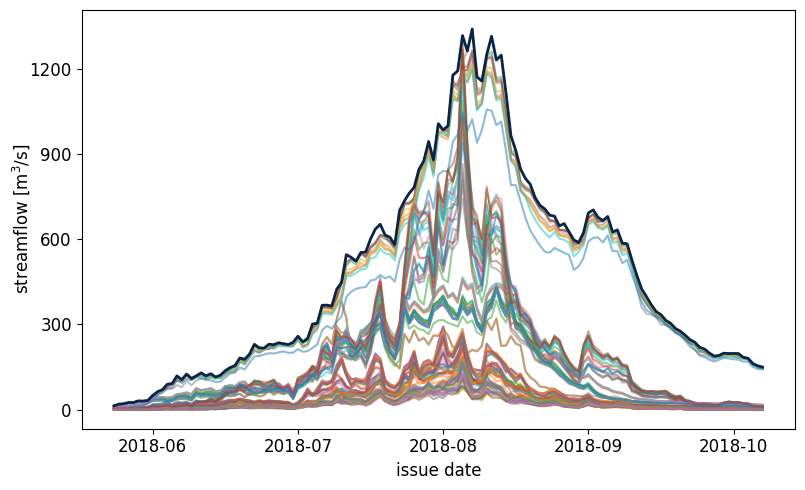

In [205]:
plot_aggregated_reforecast_paper('2018-06-20', '2018-11-01',
                                 l_gauges_admin_unit_most,
                                 dict_datasets_au[admin_unit_most_gauges]
                                 )

In [206]:
print(dict_datasets_au[admin_unit_most_gauges])

<xarray.Dataset>
Dimensions:      (issue_time: 2738)
Coordinates:
  * issue_time   (issue_time) datetime64[ns] 2016-01-01 ... 2023-06-30
    lead_time    timedelta64[ns] ...
    actual_date  (issue_time) datetime64[ns] ...
Data variables:
    streamflow   (issue_time) float32 ...
Attributes:
    identifier:  ML0105
    gauge_ids:   ['1120645770', '1120646230', '1120646950', '1120648650', '11...
    RP_1.5:      844.1071288187046
    RP_2:        968.0026442432999
    RP_5:        1272.9060280197439
    RP_10:       1474.7785985985752
    pc_95th:     758.7179443359374
    pc_98th:     887.0293969726563
    pc_99th:     980.1514575195306


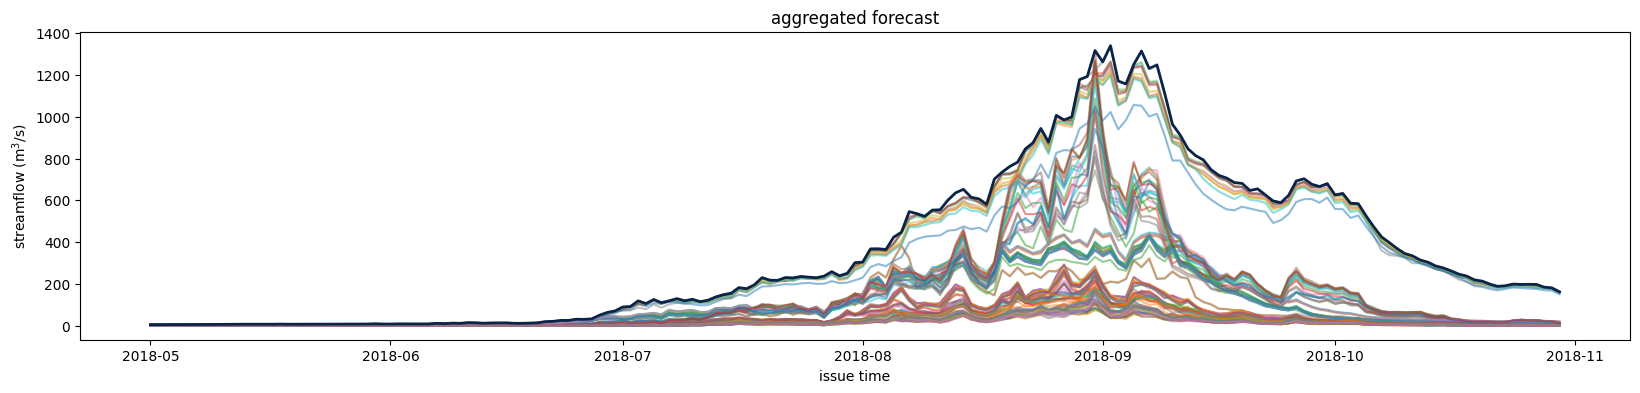

In [207]:
plot_aggregated_reforecast('2018-05-01', '2018-10-30',
                           l_gauges_admin_unit_most,
                           dict_datasets_au[admin_unit_most_gauges])

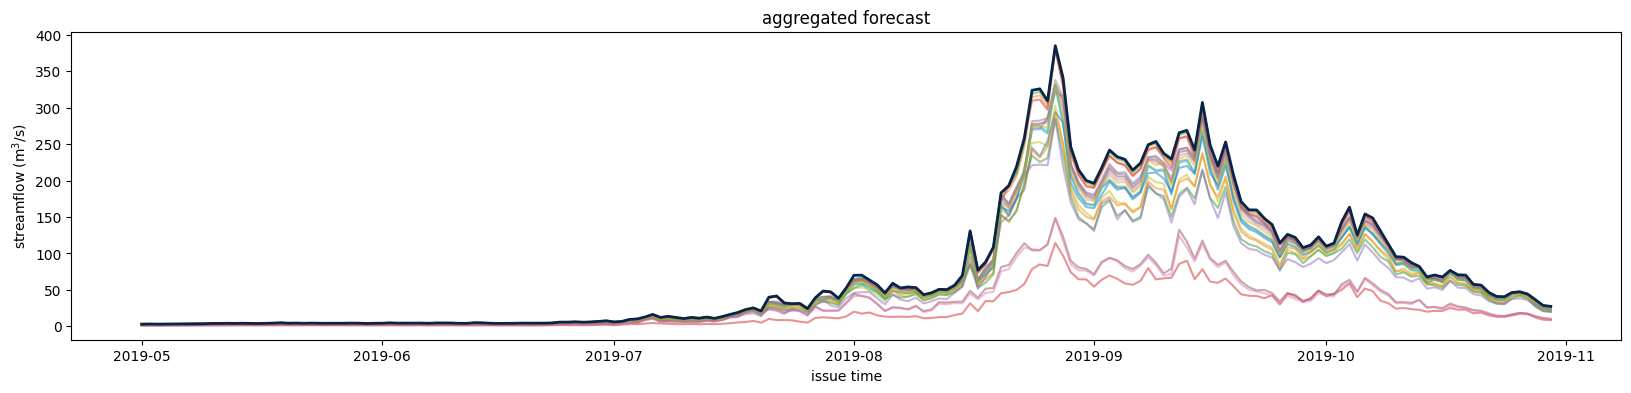

In [208]:
l_gauges_xth_admin_unit, admin_unit_xth_gauges = \
    get_datasets_for_xth_admin_unit(dict_datasets_au, dict_datasets, 15)

plot_aggregated_reforecast('2019-05-01', '2019-10-30',
                           l_gauges_xth_admin_unit,
                           dict_datasets_au[admin_unit_xth_gauges])

#### **Create events**

In [209]:
def export_dict_flood_events_to_csv(
        dict_flood_events: Dict[str, pd.DataFrame], th: Any,
        lt: int, verbose: bool = False
    ) -> None:
    """
    Export the dictionary with flood events to a csv file
    with a MultiIndex for keys and events

    :param dict_flood_events: dictionary with flood events
    :param th: return period threshold
    :param lt: lead time
    :param verbose: whether to print some test print-s's
    """
    if not dict_flood_events:
        print('No flood events found')
        return
    df_flood_events = pd.concat(dict_flood_events,
                                names = ['identifier', 'events'])
    print(df_flood_events) if verbose else None
                            # sort the index to make the csv file more readable
    df_flood_events = df_flood_events.sort_index()
                            # add n_flood_events to name to
                            # see difference between files
    n_flood_events = df_flood_events.shape[0]
    print(f'exporting {n_flood_events} flood events to csv')
    
    if th in [95, 98, 99]:
        th_str = f'{th}pc'
    else:
        th_str = f'{th}rp'
    df_flood_events.to_csv(
        f'../data/processed/flood_events/flood_events_au_{lt * 24}lt_{th_str}_n{n_flood_events}.csv',
        sep = ';', decimal = '.')
    
    
def create_flood_mask(
        ds: xr.Dataset, threshold: int = 5
    ) -> np.ndarray:
    """
    Creates a boolean mask to identify when the streamflow
    exceeds the return period threshold

    :param ds: dataset with streamflow data
    :param threshold: return period threshold
    :return: boolean mask
    """
    if f'RP_{threshold}' not in ds.attrs and f'pc_{threshold}th' not in ds.attrs:
        raise ValueError(f"No return period key ({threshold}) found for {ds.attrs['identifier']}")
    # if ds.attrs[f'RP_{threshold}'] is None and ds.attrs[f'pc_{threshold}th'] is None:
    #     raise ValueError(f"No return period value ({threshold}) found for {ds.attrs['identifier']}")

    # return a boolean mask where True indicates that the streamflow
    # exceeds the return period threshold for the administrative unit
    if f'RP_{threshold}' in ds.attrs:
        return ds['streamflow'] > ds.attrs[f'RP_{threshold}']
    else:
        return ds['streamflow'] > ds.attrs[f'pc_{threshold}th']


def create_event_dict(df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Create a dictionary with flood events per admin unit

    :param df: DataFrame with flood events
    :return: dict with df of flood events per admin unit
    """
    d = {}
    for admin_unit, group in df.groupby('identifier'):
        d[admin_unit] = group.reset_index(drop = True)
    return d


def merge_sequential_flood_events(
        df: pd.DataFrame, ds: xr.Dataset, action_lifetime: int = 10
    ) -> pd.DataFrame:
    """
    Merge flood events that are within one action lifetime of one another

    :param df: DataFrame with flood events
    :param ds: dataset with streamflow data (for calculation of peak streamflow)
    :param action_lifetime: days allowed between events
    :return: DataFrame with merged flood events
    """
                            # convert the DataFrame to a list of dictionaries
    list_events = [df.iloc[0].to_dict()]
    for idx in range(1, len(df)):
                            # for each flood event, get the current and last event,
                            # check if they are within the action lifetime of one another
                            # and merge them if they are
        current_event = df.iloc[idx]
        last_event = list_events[-1]

        days_between = (pd.Timestamp(current_event['flood_start']) - \
                        pd.Timestamp(last_event['flood_end'])).days
        if days_between <= action_lifetime:
                            # within if-s, merge events
            last_event['flood_end'] = pd.Timestamp(current_event['flood_end'])
            last_event['duration'] = (last_event['flood_end'] - last_event['flood_start']).days + 1
                            # recompute peak_streamflow over the new period
            last_event['peak_streamflow'] = ds['streamflow'].sel(
                issue_time = slice(last_event['flood_start'], last_event['flood_end'])
            ).max().item()
        else:
                            # else, no merge needed
            list_events.append(current_event.to_dict())
    
    return pd.DataFrame(list_events)


def get_admin_unit_name(p: str) -> str:
    """
    Gets the admin unit name given a pcode

    :param p: PCODE
    :return: admin unit name
    """
    with open('../data/mappings/PCODE_to_Cercle.json', 'r') as f:
        mapping = json.load(f)
    return mapping.get(p)


def add_admin_unit_name_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a column to a DataFrame with the Cercle name based on the 
    pcode in the 'admin_unit' column

    :param df: DataFrame with 'admin_unit' column
    :return: DataFrame with added 'admin_unit_NAME' column
    """
    with open('../data/mappings/PCODE_to_Cercle.json', 'r') as f:
        mapping = json.load(f)
    df['admin_unit_NAME'] = df['admin_unit'].apply(lambda x: mapping.get(x, None))
    return df


def create_flood_events(
        dict_ds_au: Dict[str, xr.Dataset],
        merge = True,
        threshold: int = 5,
        action_lifetime: int = 10
    ) -> Dict[str, pd.DataFrame]:
    """
    Creates flood events based on the return period threshold.
    A flood event is defined as a consecutive period where the
    streamflow exceeds the given threshold for the return period

    :param dict_ds_au: dict of ds per admin unit
    :param threshold: rp-value to trigger flood event (default is 5)
    :param action_lifetime: days allowed between events (default is 10)
    :return: dict with df of flood events per admin unit
    """
    if threshold not in [1.5, 2, 5, 10, 95, 98, 99]:
        raise ValueError("threshold must be 1.5, 2, 5, 10, 95, 98, 99")
    
    flood_events_per_au = {}    # for each admin unit ds:
    for admin_unit, ds in dict_ds_au.items():
                                # create a boolean mask to identify when
                                # the streamflow exceeds the return period threshold
        flood_mask = create_flood_mask(ds, threshold)
        
        flood_events = []
                                # find the start and end of flood events by checking
                                # consecutive True values in the mask
        flood_start, flood_end = None, None
        for idx, is_flood in enumerate(flood_mask):
            if is_flood and flood_start is None:
                                # start of a new flood event
                flood_start = ds['actual_date'].values[idx]
            elif not is_flood and flood_start is not None:
                                # end of the current flood event
                flood_end = ds['actual_date'].values[idx - 1]
                                # inclusive difference (+1) between the two dates;
                                # if the flood event is only one day, the duration is 1;
                                # and, if duration == 1, the event is ignored, as,
                                # hydrologically, the river is expected to handle it
                duration = pd.Timedelta(flood_end - flood_start).days + 1
                if duration == 1:
                    flood_start, flood_end = None, None
                    continue
                                # store the flood event details
                flood_events.append({
                    'flood_start': flood_start,
                    'flood_end': flood_end,
                    'duration': duration,
                    'peak_streamflow': \
                        ds['streamflow'].sel(issue_time = slice(flood_start,
                                                                flood_end)).max().item()
                })
                                # reset flood_start and flood_end
                flood_start, flood_end = None, None
                                # by now, if flood_start is not None,
                                # it means the flood event is still going
        if flood_start is not None:
            flood_end = ds['actual_date'].values[-1]
            flood_events.append({
                'flood_start': flood_start,
                'flood_end': flood_end,
                'duration': pd.Timedelta(flood_end - flood_start).days + 1,
                'peak_streamflow': \
                    ds['streamflow'].sel(issue_time = \
                                         slice(flood_start, flood_end)).max().item()
            })

                                # store the flood events per admin unit in a df,
                                # and merge sequential flood events when needed
                                # (as they are likely the same event)
        df = pd.DataFrame(flood_events)
        if df.empty:            # if no flood events are found, skip the admin unit
            print('No flood events found for admin unit', admin_unit)
            continue

        if merge and len(flood_events) > 0:       
            df = merge_sequential_flood_events(df, ds, action_lifetime)
        flood_events_per_au[admin_unit] = df

    return flood_events_per_au

In [210]:
dict_datasets_au

{'ML0101': <xarray.Dataset>
 Dimensions:      (issue_time: 2738)
 Coordinates:
   * issue_time   (issue_time) datetime64[ns] 2016-01-01 ... 2023-06-30
     lead_time    timedelta64[ns] ...
     actual_date  (issue_time) datetime64[ns] ...
 Data variables:
     streamflow   (issue_time) float32 ...
 Attributes:
     identifier:  ML0101
     gauge_ids:   ['1120666460', '1120666890', '1120667360', '1120667560', '11...
     RP_1.5:      865.1875115333212
     RP_2:        972.9904655270907
     RP_5:        1238.2905075919832
     RP_10:       1413.9422199573007
     pc_95th:     852.6673217773437
     pc_98th:     1014.911630859375
     pc_99th:     1145.364641113281,
 'ML0102': <xarray.Dataset>
 Dimensions:      (issue_time: 2738)
 Coordinates:
   * issue_time   (issue_time) datetime64[ns] 2016-01-01 ... 2023-06-30
     lead_time    timedelta64[ns] ...
     actual_date  (issue_time) datetime64[ns] ...
 Data variables:
     streamflow   (issue_time) float32 ...
 Attributes:
     identifie

In [211]:
dict_DNH_datasets

{'Banankoro': <xarray.Dataset>
 Dimensions:      (issue_time: 2738)
 Coordinates:
   * issue_time   (issue_time) datetime64[ns] 2016-01-01 ... 2023-06-30
     gauge_id     object ...
     lead_time    timedelta64[ns] 7 days
     actual_date  (issue_time) datetime64[ns] 2016-01-08 ... 2023-07-07
 Data variables:
     streamflow   (issue_time) float32 162.2 164.1 160.1 ... 320.8 356.9 353.9
 Attributes: (12/14)
     RP_5:             3256.307965776679
     qualityVerified:  False
     latitude:         11.702083333332324
     longitude:        -8.652083333336122
     gauge_id:         1120748210
     admin_unit:       ['ML0203']
     ...               ...
     RP_1.5:           2612.0279852281565
     RP_2:             2798.1837809089257
     RP_10:            3559.6260388597693
     pc_95th:          2670.4341064453124
     pc_98th:          3043.6947265625
     pc_99th:          3234.452031249999,
 'Bamako': <xarray.Dataset>
 Dimensions:      (issue_time: 2738)
 Coordinates:
   * issue

Creating flood events starts with combining the forecast timeseries ($Q(t)$) and a threshold ($Q_{th}$) into a boolean mask per timestep, with **True** / **False** for $Q(t) > Q_{th}$ and $Q(t) < Q_{th}$, respectively.

If the flood is just one day, i.e. only one consecutive **True** value is encountered, the river is assumed to handle the water itself. If not, a flood event is created and stored in a DataFrame per administrative unit or station (depending on assessing impact data or observational data) accessible with the corresponding identifier.

In [212]:
if not (COMP_TYPE == 'IMPACT' or COMP_TYPE == 'OBS'):
    raise ValueError('COMP_TYPE must be either IMPACT or OBS')
# Note that the flood events are already calculated by their "actual date",
# hence, we export it using LEAD_TIME (* 24 hours) as lead time identifier
if COMP_TYPE == 'IMPACT':
    dict_flood_events = create_flood_events(dict_datasets_au, True, THRESHOLD)
if COMP_TYPE == 'OBS':
    dict_flood_events = create_flood_events(dict_DNH_datasets, True, THRESHOLD)
export_dict_flood_events_to_csv(dict_flood_events, THRESHOLD, LEAD_TIME)

exporting 47 flood events to csv


In [213]:
def plot_agg_reforecast(start_date: str, end_date: str,
                        ds_rf: xr.Dataset, threshold: int = 5,
    ) -> None:
    """
    Plots aggregated reforecast data for a given time range

    :param start_date: start date for the time range
    :param end_date: end date for the time range
    :param ds_rf: reforecast dataset of admin unit
    :param thresholds: list of thresholds to add return periods for
    """
    fig, ax = plt.subplots(figsize = (20, 4))
    ds_subset = ds_rf.streamflow.sel(issue_time = slice(start_date, end_date))
    
    ax.plot(ds_subset.issue_time, ds_subset.values)
    ax.axhline(y = ds_rf.attrs[f'RP_{threshold}'], color = 'orange',
               label = f'{threshold}-yr return period', linestyle = '--'
    )
    ax.set_title(f'Reforecast data for {ds_rf.attrs["identifier"]} with {threshold}-yr return period')
    plt.legend(loc = 'upper right')
    plt.show()

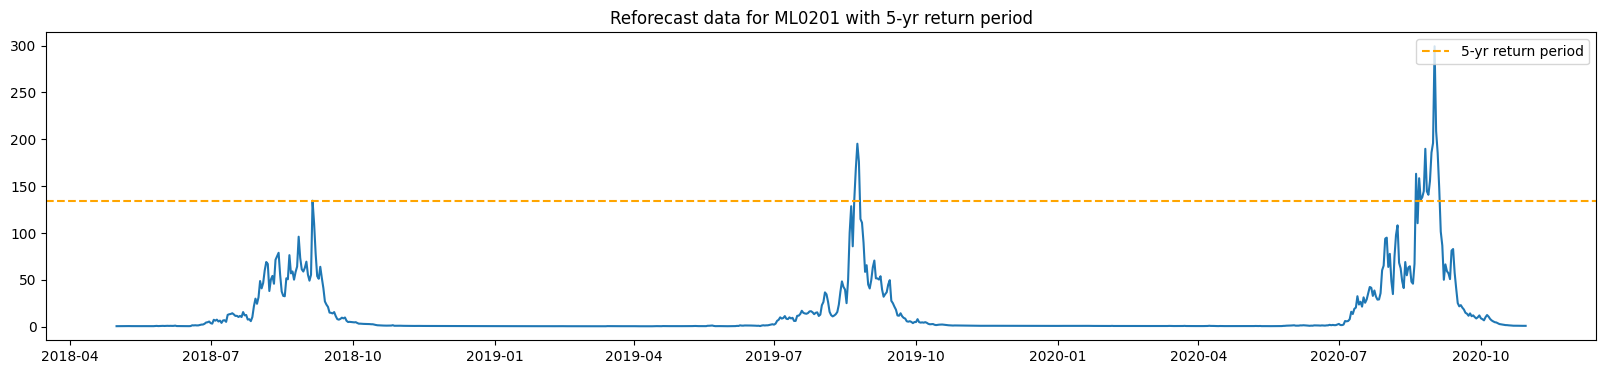

In [214]:
# Check whether the flood events are correctly created using some plots:
"""
ML0201;0;2018-09-05;2018-09-05;0;134.45091247558594
ML0201;1;2019-08-20;2019-08-20;0;128.57044982910156
ML0201;2;2019-08-22;2019-08-26;4;195.2600860595703
ML0201;3;2020-08-20;2020-08-20;0;163.1853790283203
ML0201;4;2020-08-22;2020-09-04;13;299.27252197265625
"""
# ML0201, for example, has 5 flood events, with some having a duration of 1 day
# Let's investigate with a plot and see if this has been processed correctly
issue_time_start_date = '2018-05-01'
issue_time_end_date = '2020-10-30'

plot_agg_reforecast(issue_time_start_date, issue_time_end_date, dict_datasets_au['ML0201'])

#### **Preprocess the impact data**

In [215]:
def read_impact_data(path: str) -> pd.DataFrame:
    """ Reads the impact data from a csv file

    :param path: path to the csv file
    :return: DataFrame with the impact data
    """
    return pd.read_csv('../data/impact_data/impact_data_Mali.csv',
                                    sep = ',',
                                    header = 0,
                                    encoding = 'utf-8')


if COMP_TYPE == 'IMPACT':

    # the next step is to load in the impact data and to transform it to
    # a format that is similar to the flood events, such that we can compare
    # and evaluate the model's performance
    df_impact_data = read_impact_data('../data/impact_data/impact_data_Mali.csv')
                                

    print(df_impact_data.columns)
    print(df_impact_data.head())

In [216]:
import json


def fill_cercle_from_commune(d: Dict[str, List[str]], row: pd.Series) -> str:
    """ 
    Tries to fill in an empty 'Cercle' column with the corresponding
    'Cercle' value from the 'Commune' entry in the dict if there is one

    :param dict: dictionary with commune-cercle mapping
    :param row: row from df
    :return: 'Cercle' value (hopefully)
    """
    if pd.isna(row['Cercle']) or row['Cercle'].strip() == '':
        commune = row['Commune']
        if commune in d and len(d[commune]) == 1:
            return d[commune][0]
        else:
            return row['Cercle']
    else:
        return row['Cercle']


def export_dict_impact_events_to_csv(
        dict_impact_events: Dict[str, pd.DataFrame],
        obs: bool = False, verbose: bool = False
    ) -> None:
    """
    Export the dictionary with impact events to a csv file
    with a MultiIndex for keys and events

    :param dict_flood_events: dictionary with flood events
    :param obs: whether to export observational data
    :param verbose: whether to be verbose
    """
    list_df_impact_events = []
    for admin_unit, df in dict_impact_events.items():
        df = df.copy()
        df.reset_index(inplace = True)
        df['identifier'] = admin_unit
        list_df_impact_events.append(df)

    df_flood_events = pd.concat(list_df_impact_events, ignore_index = True)
    print(df_flood_events) if verbose else None

    if not obs:
        print(f'exporting {df_flood_events.shape[0]} impact events to csv')
        df_flood_events.to_csv(
            f'../data/processed/flood_events/impact_events_au_{df_flood_events.shape[0]}.csv',
            sep = ';', decimal = '.', index = False)
    else:
        print(f'exporting {df_flood_events.shape[0]} observational events to csv')
        df_flood_events.to_csv(
            f'../data/processed/flood_events/obs_events_au_{df_flood_events.shape[0]}.csv',
            sep = ';', decimal = '.', index = False)
    

def map_cercle_names_to_pcodes(
        df: pd.DataFrame,
        path: str = 'mali_ALL/mli_adm_ab_shp/mli_admbnda_adm2_1m_gov_20211220.shp',
        verbose: bool = False
        ) -> Dict[str, str]:
    """
    Maps the Cercle names in the impact data to the pcodes found in the
    shape file of the administrative units and used for the flood events

    :param df: dataframe with impact data
    :param path: path to the shape file
    :param verbose: whether to print some test prints
    :return: dictionary with Cercle names mapped to pcodes
    """
                        # load shape file and normalise columns of interest
    gdf = analyse.get_shape_file(path).to_crs('EPSG:4326')
    gdf['ADM2_FR'] = gdf['ADM2_FR'].str.strip().str.upper()\
                        .str.normalize('NFKD').str.encode('ascii',errors = 'ignore')\
                            .str.decode('utf-8') 
                        # use the print statements to compare admin unit names
                        # of the shape file and of the impact data
    # print(np.sort(gdf['ADM2_FR'].unique()))
                        # print out the identifiers in the impact data which are not
                        # found in the shape file, so we can manually check and correct
    if verbose:
        print('Identifiers in impact data not found in shape file:')
        print(np.sort(np.setdiff1d(df['Cercle'].unique(), gdf['ADM2_FR'].unique())))
                        # the print statement above and this one produce:
    """
    ['ABEIBARA' 'ANDERAMBOUKANE' 'ANSONGO' 'BAFOULABE' 'BAMAKO' 'BANAMBA'
    'BANDIAGARA' 'BANKASS' 'BARAOUELI' 'BLA' 'BOUGOUNI' 'BOUREM' 'DIEMA'
    'DIOILA' 'DIRE' 'DJENNE' 'DOUENTZA' 'GAO' 'GOUNDAM' 'GOURMA-RHAROUS'
    'INEKAR' 'KADIOLO' 'KANGABA' 'KATI' 'KAYES' 'KENIEBA' 'KIDAL' 'KITA'
    'KOLOKANI' 'KOLONDIEBA' 'KORO' 'KOULIKORO' 'KOUTIALA' 'MACINA' 'MENAKA'
    'MOPTI' 'NARA' 'NIAFUNKE' 'NIONO' 'NIORO' 'SAN' 'SEGOU' 'SIKASSO'
    'TENENKOU' 'TESSALIT' 'TIDERMENE' 'TIN-ESSAKO' 'TOMBOUCTOU' 'TOMINIAN'
    'YANFOLILA' 'YELIMANE' 'YOROSSO' 'YOUWAROU']
    <class 'numpy.ndarray'>
    ['GOUMERA' 'ESSOUK' 'INTACHDAYTE' 'AGUELHOK' 'TAMKOUTAT' 'ZEGOUA' 'SONA'
    'KOURY' 'BIRAMABOUGOU' 'SANDIA' 'TOUBAKORO' 'KENEKOUN']
    """
                        # create a mapping from Cercle names to pcodes
    mapping = gdf.set_index('ADM2_FR')['ADM2_PCODE'].to_dict()
                        # some manual corrections made by searching Google Maps and GeoView
    manual_corrections = {
        'GOUMERA' : mapping.get('KAYES'),
        'ESSOUK' : mapping.get('KIDAL'),
        'INTACHDAYTE' : mapping.get('KIDAL'),
        'AGUELHOK' : mapping.get('TESSALIT'),
        'TAMKOUTAT' : mapping.get('GAO'),
        'ZEGOUA' : mapping.get('KADIOLO'),
        'SONA' : mapping.get('YOROSSO'),
        'KOURY' : mapping.get('YOROSSO'),
        'BIRAMABOUGOU' : mapping.get('SIKASSO'),
        'SANDIA' : mapping.get('KAYES'),
        'TOUBAKORO' : mapping.get('KOULIKORO'),
        'KENEKOUN' : mapping.get('KANGABA')
    }
                        # update the mapping with the manual corrections
                        # and apply the mapping to the 'Cercle' column    
    mapping.update(manual_corrections)
                        # save PCODE as the standard an NAME as subsidiary
    df['admin_unit'] = df['Cercle'].apply(lambda x: mapping.get(x, None))
    df['admin_unit_NAME'] = df['Cercle']
    print(df.head()) if verbose else None
                        # handle unmapped Cercle values
    unmapped_cercles = df[df['admin_unit'].isnull()]['Cercle'].unique()
    if unmapped_cercles.size > 0:
        raise ValueError(f'Unmapped Cercle values: {unmapped_cercles}')
    
                        # at last, export the mapping as a .json file with
                        # as keys the pcodes and as values the Cercle names,
                        # and also the inverse mapping (it should exist)
    with open('../data/mappings/Cercle_to_PCODE.json', 'w') as f:
        json.dump(mapping, f, indent = 4)
    inverse_mapping = {v: k for k, v in mapping.items()}
    with open('../data/mappings/PCODE_to_Cercle.json', 'w') as f:
        json.dump(inverse_mapping, f, indent = 4)

    return df


def overlaps_dry_season(row: pd.Series) -> bool:
    """ Checks whether the flood event overlaps the dry season
    (the months March, April, May, June)

    :param row: row from the DataFrame
    :return: whether the flood event overlaps the dry season
    """
    date_range = pd.date_range(row['flood_start'], row['flood_end'])
    return any(d.month in [3, 4, 5, 6] for d in date_range)


def filter_dry_season_events(df: pd.DataFrame) -> pd.DataFrame:
    """ Filters out the flood events that overlap the dry season

    :param df: DataFrame with flood events
    :return: DataFrame with flood events that do not overlap the dry season
    """
    return df[~df.apply(overlaps_dry_season, axis = 1)]


def merge_duplicate_events(d_events: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    """
    Filter out double impact events by checking whether events have the 
    same start date, and then merge them to an event with the start date
    of the first, and end date of the last event with the same start date.
    Added later: also adjacent or overlapping events are merged.

    :param dict_events: dict with au codas keys and events dfs as values
    :return: same dict, but merged
    """
    d_events_merged = {}

    for admin_unit, df_events in d_events.items():
                            # bring event_ID back as column
        df_events = df_events.reset_index()
        # grouped = df_events.groupby('flood_start')

        merged_rows = []
        current_event = df_events.iloc[0].to_dict()
        # for flood_start, group in grouped:
        for idx in range(1, len(df_events)):
            next_event = df_events.iloc[idx].to_dict()

            if next_event['flood_start'] <= current_event['flood_end']:
                current_event['flood_end'] = max(current_event['flood_end'], next_event['flood_end'])
                current_event['duration'] = (current_event['flood_end'] - \
                                             current_event['flood_start']).days + 1
            else:
                merged_rows.append(current_event)
                current_event = next_event.copy()
        merged_rows.append(current_event)

        
            #                 # if one event, don't merge
            # if len(group == 1):
            #     merged_rows.append(group.iloc[0])
            # else:
            #                 # find the latest flood end
            #                 # and update columns accordingly
            #     idx_max_end = group['flood_end'].idxmax()
            #     max_end_row = group.loc[idx_max_end].to_dict()
            #     max_end_row['flood_end'] = group['flood_end'].max()
            #     max_end_row['duration'] = (max_end_row['flood_end'] - \
            #                                max_end_row['flood_start']).days + 1
            #     merged_rows.append(max_end_row)
                     
        merged_events = pd.DataFrame(merged_rows)
        merged_events.set_index('event_ID', inplace = True)
        merged_events.sort_values('flood_start', inplace = True)
        d_events_merged[admin_unit] = merged_events            

    return d_events_merged


def process_impact_data_to_events(
        df: pd.DataFrame, verbose: bool = False
    ) -> Dict[str, pd.DataFrame]:
    """
    Process the "raw" impact data to events similar
    to the events created from the flood data, with
    specifically, per administative unit:
    - start date of the event;
    - end date of the event;
    - duration of the event; and
    
    Here, especially classification into administrative units
    is problematic, as some data is missing. How this is handled
    can vary per your specific use case, and for missing rows
    information is printed when verbose is True

    :param df: dataframe with impact data
    :param verbose: whether to be verbose
    :return: dictionary with events per administrative unit
    """                  
                        # keep only (possitbly) relevant columns, of which notable:
                        # - 'Start date' and 'End date': self-explanatory
                        # - 'Cercle': administrative unit
                        # - the rest gives more location information, which might be
                        #   useful if administrative unit information is missing
    df = df[['Start Date', 'End Date', 'Région', 'Cercle', 'Commune', 'Quartier/Villages']].copy()
                        # rename 'Start date' and 'End date' to 'flood_start' and 'flood_end'
                        # and convert them to datetime objects with flag 'raise' for errors:
                        # if any dates are missing they can be reconstructed using the
                        # 'Années', 'Mois', and 'Jours' columns, but was not needed here
    df.rename(columns = {'Start Date': 'flood_start', 'End Date': 'flood_end'}, inplace = True)
    df['flood_start'] = pd.to_datetime(df['flood_start'], format = '%d/%m/%Y', errors = 'raise')
    df['flood_end'] = pd.to_datetime(df['flood_end'], format = '%d/%m/%Y', errors = 'raise')
                        # after printing out rows with missing dates with the following line:
    """
    print(df[df['flood_start'].isnull() | df['flood_end'].isnull()]) if verbose else None
    """ 
                        # row 133 was empty, so we drop it
    df.dropna(subset = ['flood_start', 'flood_end'], inplace = True)
                        # double check if no dates are missing
    if df['flood_start'].isnull().values.any() or df['flood_end'].isnull().values.any():
        raise ValueError('Missing dates in impact data')
                        # next, we normalise 'Cercle' column to no whitespace and uppercase,
                        # and also delete any accents on top of letters or dashes etc to make
                        # sure the 'Cercle' column is as clean and uniform as possible
    df['Cercle'] = df['Cercle'].str.strip().str.upper()
    df['Cercle'] = df['Cercle'].str.normalize('NFKD').str.encode('ascii', errors = 'ignore').str.decode('utf-8')
                        # solve some other specific naming ambiguities:
    df['Cercle'] = df['Cercle'].str.replace(r'\bTOMBOUCTO\b', 'TOMBOUCTOU', regex = True)
    df['Cercle'] = df['Cercle'].str.replace(r'\bGOURMA-RH\b', 'GOURMA-RHAROUS', regex = True)
    df['Cercle'] = df['Cercle'].str.replace('NIAFUNKE + MORE LOCATIONS', 'NIAFUNKE')
    df['Cercle'] = df['Cercle'].str.replace(r'\bBANDIAGAR\b', 'BANDIAGARA', regex = True)
    df['Cercle'] = df['Cercle'].str.replace('BAROUELI', 'BARAOUELI')
    df['Cercle'] = df['Cercle'].str.replace('DIOLA', 'DIOILA')
    df['Cercle'] = df['Cercle'].str.replace('NIANFUNKE', 'NIAFUNKE')
    df['Cercle'] = df['Cercle'].str.replace('ASANGO', 'ANSONGO')
    df['Cercle'] = df['Cercle'].str.replace('KOLONDIEB', 'KOLONDIEBA')

                        # to handle missing 'Cercle' information, we make a mapping/dict
                        # with as key the Commune (which is a subset of Cercle) and as
                        # value the corresponding Cercle, which can be used after to fill
                        # in missing Cercle information. We also check if there are not
                        # illogical double entries, which would need manual handling. We
                        # also change Cercle names with 'District' to NaN, so they can maybe
                        # be picked up by the Commune-Cercle mapping
    df['Cercle'] = df['Cercle'].replace('DISTRICT', np.nan)
    df['Commune'] = df['Commune'].str.strip().str.upper()
    dict_communce_cercle = df.groupby('Commune')['Cercle'].unique().to_dict()
                        # delete NaN's from the arrays itself in the dictionary;
                        # loop over all dictionary items and remove NaN's
    for commune, cercles in dict_communce_cercle.items():
        dict_communce_cercle[commune] = [cercle for cercle in cercles if isinstance(cercle, str)]
                        # check whether a commune is associated w/ a missing or multiple cercles
    for commune, cercles in dict_communce_cercle.items():
        if len(cercles) == 1 and (not isinstance(cercles[0], str) or cercles[0].strip() == ''):
            if verbose:
                print(f"Commune '{commune}' is associated with a missing Cercle")
    for commune, cercles in dict_communce_cercle.items():
        if len(cercles) > 1:
            if verbose:
                print(f"Commune '{commune}' is associated with multiple Cercles: {cercles}")
                        # which prints:
    """
    Commune 'BLA' is associated with multiple Cercles: ['SAN', 'BLA']
    Commune 'LOGO' is associated with multiple Cercles: ['YELIMANE', 'KAYES']
    Commune 'TIENFALA' is associated with multiple Cercles: ['BOUGOUNI', 'KOULIKORO']
    """
                        # so we handle these manually (after checking Google Maps etc.)
    dict_communce_cercle['BLA'] = ['SEGOU']
    dict_communce_cercle['LOGO'] = ['KAYES']
    dict_communce_cercle['TIENFALA'] = ['KOULIKORO']

                        # next, we fill in missing 'Cercle' information with the dictionary
                        # we created above, and we print out the rows with missing 'Cercle'
    df['Cercle'] = df.apply(lambda row: fill_cercle_from_commune(dict_communce_cercle, row),
                            axis = 1)
    df_missing_cercle = df[df['Cercle'].isnull() | \
        df['Cercle'].apply(lambda x: not isinstance(x, str) or x.strip() == '')]
    if verbose:         # Note: the above modifications "saved" 13 flood events
        print(f'\nImpact events without Cercle info: {df_missing_cercle.shape[0]}')
        print(f'Impact events with Cercle info: {df.shape[0] - df_missing_cercle.shape[0]}\n')
                        # Note: if after above, 'Cercle' is still missing, we *could* try
                        # and see if the 'Region' column is (coincidently?) the same as a
                        # 'Cercle' column, but we ignore this possibility for now.
                        # Next, we separate the data which has no 'Cercle' information
                        # and drop the three unnecessary remaining columns 
    df = df[~df.index.isin(df_missing_cercle.index)]
                        #! Comment this to not drop the indicated columns and also
                        #! add them to the line: df_events = df_group[[...]] column list
                        #! Don't forget the line which gets rid of the accent in Region
    df = df.drop(columns = ['Région', 'Commune', 'Quartier/Villages'])
    # df = df.rename(columns = {'Région': 'Region'})
                        # calculate the duration of each flood event and add as column,
                        # where the difference is inclusive, so we add 1 to the result
    df['duration'] = (df['flood_end'] - df['flood_start']).dt.days + 1

                        # next, we map the names of the 'Cercle' column to the admin units
                        # in the flood data, and we check if all 'Cercle' values are mapped
    df = map_cercle_names_to_pcodes(df) 
    df_missing_mapping = df[df['admin_unit'].isnull()]
    if df_missing_mapping.shape[0] > 0:
        print(f'unmapped Cercle values: {df_missing_mapping["Cercle"].unique()}')
    # df.to_csv('../data/impact_data/impact_data_Mali_tidied.csv')
                        # lastly, we group the data by 'Cercle' and create a dictionary
                        # with the 'Cercle' as key and the corresponding dataframe as value
    dict_events = {}
                        # order the data and store in dictionary
    for cercle, df_group in df.groupby('admin_unit'):
                        # ensure chronological order of the events
        df_group = df_group.sort_values(by = ['flood_start', 'flood_end']).reset_index(drop = True)
                        # give events an identifier and set as index
        df_group['event'] = df_group.index
        df_group['event_ID'] = df_group.apply(lambda x: f"{cercle}_{x['event']}",
                                              axis = 1)
        df_group.set_index('event_ID', inplace = True)
        df_events = df_group[['admin_unit_NAME', 'admin_unit',
                              'flood_start', 'flood_end', 'duration',]]
                                # 'Region', 'Commune', 'Quartier/Villages']]
        dict_events[cercle] = df_events
        
                        # merge duplicate events
    dict_events_merged = merge_duplicate_events(dict_events)
                        # filter out dry season by removing events with at least one day
                        # in the period of March to June (inclusive)
    for _, df in dict_events_merged.items():
        df = filter_dry_season_events(df.copy())
                        # sort again
        df.sort_values(by = ['flood_start', 'flood_end'], inplace = True)

                        # export to csv and return
    export_dict_impact_events_to_csv(dict_events_merged, False, verbose)
    return dict_events_merged

The counterpart to the flood events are created here: "impact events" and "observational events".

In [217]:
if COMP_TYPE == 'IMPACT':
    dict_impact_events = process_impact_data_to_events(df_impact_data, False)

#### **Preprocess the observational data**

In [218]:
def get_obs_events(thr: int = 5) -> Dict[str, pd.DataFrame]:
    """
    Gets the observation data events for the given threshold and transforms
    them to the same format as the flood events and impact events

    :param thr: return period threshold
    :return: dictionary with observation events
    """
    if thr not in [1.5, 2, 5, 10, 95, 98, 99]:
        raise ValueError("threshold must be 1.5, 2, 5, 7, 10, 20")
    if thr in [1.5, 2, 5, 10]:
        thr = float(thr) # convert to float to import decimal values
        path_obs = f'../../comparison/observation/data/observationalStation_flood_events_RP_{thr}yr.csv'
    if thr in [95, 98, 99]:
        thr = float(thr) # convert to float to import decimal values
        path_obs = f'../../comparison/observation/data/observationalStation_flood_events_percentile{thr}.csv'

    df_obs = pd.read_csv(path_obs, sep = ',', index_col = 0, header = 0, encoding = 'utf-8')
    df_obs = df_obs[['StationName', 'Start Date', 'End Date']]
    df_obs = df_obs[df_obs['Start Date'] >= '2016-01-01']
    df_obs.rename(columns = {'Start Date': 'flood_start',
                             'End Date': 'flood_end',
                             'StationName': 'identifier'},
                  inplace = True)
    df_obs['flood_start'] = pd.to_datetime(df_obs['flood_start']).dt.date
    df_obs['flood_end'] = pd.to_datetime(df_obs['flood_end']).dt.date
    df_obs['flood_start'] = pd.to_datetime(df_obs['flood_start'])
    df_obs['flood_end'] = pd.to_datetime(df_obs['flood_end'])
    df_obs['duration'] = (df_obs['flood_end'] - df_obs['flood_start']).dt.days + 1
    df_obs.sort_values(['identifier', 'flood_start'], inplace = True)
    df_obs.reset_index(drop = True, inplace = True)
    df_obs['event'] = df_obs.groupby('identifier').cumcount()
    df_obs['event_ID'] = df_obs.apply(lambda x: f"{x['identifier']}_{x['event']}", axis = 1)
    df_obs = df_obs[['event_ID', 'identifier', 'flood_start', 'flood_end', 'duration']]
    df_obs.sort_values('event_ID', inplace = True)
    df_obs.reset_index(drop = True, inplace = True)
    dict_obs_events = create_event_dict(df_obs)
    dict_obs_events = merge_duplicate_events(dict_obs_events)
    if 'Guelelinkoro' in dict_obs_events:
        del dict_obs_events['Guelelinkoro']
    for _, value in dict_obs_events.items():
        value.sort_values(by = ['flood_start', 'flood_end'], inplace = True)
    export_dict_impact_events_to_csv(dict_obs_events, True, False)
    return dict_obs_events

In [219]:
if COMP_TYPE == 'OBS':
    dict_obs_events_final = get_obs_events(THRESHOLD)

exporting 16 observational events to csv


#### **Subsetting impact events on time and comparator availability**

Next and final step of impact data preprocessing is subsetting by the available dates
in the forecast data and by the available administrative units in the forecast data.

For the observational data, this is not necessary.

In [220]:
def determine_min_max_date_of_dataset(d_ds: Dict[str, xr.Dataset]) -> Tuple[str, str]:
    """
    Determine the earliest and latest date of the datasets

    :param d_ds: dictionary with datasets
    :return: tuple with earliest and latest date
    """
    earliest_dates = []
    latest_dates = []
    for ds in d_ds.values():
        earliest_dates.append(ds['issue_time'].values[0])
        latest_dates.append(ds['issue_time'].values[-1])

    return min(earliest_dates), max(latest_dates)


def subset_events_on_unit_and_date(
        d_impact_events: Dict[str, pd.DataFrame],
        d_forecast_units: Dict[str, xr.Dataset],
        earliest_date: str, latest_date: str
    ) -> Dict[str, pd.DataFrame]:
    """
    Subset impact events based on available forecast administrative units 
    and specified date range. Events are filtered to include only those 
    within the specified date range and belonging to administrative units 
    present in the forecast data. Administrative units with no valid impact 
    data within the date range or not in the forecast data are logged
    
    :param d_impact_events: dictionary with impact events
    :param d_units: dictionary with available administrative units, i.e.
                    the units for which forecast data is available
    :param earliest_date: earliest date
    :param latest_date: latest date
    :return: dictionary with subsetted events
    """
    d_subsetted = {}
    l_no_impact_data = []
    earliest_date = pd.to_datetime(earliest_date)
    latest_date = pd.to_datetime(latest_date)
                            # for every admin unit in the impact data:
    for admin_unit, df in d_impact_events.items():
                            # check if it is in the forecast data
                            # and, if so, if it is in the time range
        if admin_unit in d_forecast_units:
            df_c = df.copy()
            df_c['flood_start'] = pd.to_datetime(df_c['flood_start'])
            df_c['flood_end'] = pd.to_datetime(df_c['flood_end'])

            df_subset = df_c[(df_c['flood_start'] >= earliest_date) & \
                             (df_c['flood_end'] <= latest_date)]
                            # if the subset is not empty, add to dict
            if not df_subset.empty:
                d_subsetted[admin_unit] = df_subset
            else:
                print(f'\tno impact data found for {admin_unit}')
                l_no_impact_data.append(admin_unit)
        else:
            print(f'{admin_unit} impact data discarded due to lack of forecast data')
    
    return d_subsetted, l_no_impact_data


def subset_events_on_date(
        d_events: Dict[str, pd.DataFrame],
        earliest_date: str, latest_date: str
    ) -> Dict[str, pd.DataFrame]:
    """
    Subset events based on specified date range

    :param d_events: dictionary with events
    :param earliest_date: earliest date
    :param latest_date: latest date
    :return: dictionary with subsetted events
    """
    d_subsetted = {}
    earliest_date = pd.to_datetime(earliest_date)
    latest_date = pd.to_datetime(latest_date)
    for identifier, df in d_events.items():
        df_c = df.copy()
        df_c['flood_start'] = pd.to_datetime(df_c['flood_start'])
        df_c['flood_end'] = pd.to_datetime(df_c['flood_end'])

        df_subset = df_c[(df_c['flood_start'] >= earliest_date) & \
                         (df_c['flood_end'] <= latest_date)]
        if not df_subset.empty:
            d_subsetted[identifier] = df_subset
        else:
            print(f'\tno (obs) data found for {identifier}')
    
    return d_subsetted

Because the impact data and/or forecast data don't necessarily have the same time range and/or spatial coverage per year, we subset them here on a year-to-year basis for a fair comparison.

In [221]:
if COMP_TYPE == 'IMPACT':
                            # determine available units and earliest and latest dates
    available_admin_units = set(dict_datasets_au.keys())
    earliest_date, latest_date = determine_min_max_date_of_dataset(dict_datasets_au)
                            # subset the impact events on the available units and dates
    dict_impact_events_final, _ = subset_events_on_unit_and_date(
        dict_impact_events, available_admin_units, earliest_date, latest_date)
    export_dict_impact_events_to_csv(dict_impact_events_final, False, False)

In [222]:
def filter_flood_events_by_impact_per_year(
    d_floods: Dict[str, pd.DataFrame], d_impacts: Dict[str, pd.DataFrame]
) -> Dict[str, pd.DataFrame]:
    """
    Filters flood events per administrative unit and per year, excluding flood
    events for years where there is no impact data for that administrative unit

    :param d_floods: dict of flood events per admin unit
    :param d_impacts: dict of impact events per admin unit
    :return: filtered dict of flood events per admin unit
    """
    d_floods_filtered = {}

    for admin_unit, df_floods in d_floods.items():
                            # if there is impact data at all for the flood
                            # events, then start filtering by year; if not,
                            # the flood events are discarded entirely
        if admin_unit in d_impacts:
                            # make copy and ensure datatypes
            df_floods_c = df_floods.copy()
            df_impacts_c = d_impacts[admin_unit].copy()
            df_floods_c['flood_start'] = pd.to_datetime(df_floods_c['flood_start'])
            df_floods_c['flood_end'] = pd.to_datetime(df_floods_c['flood_end'])
            df_impacts_c['flood_start'] = pd.to_datetime(df_impacts_c['flood_start'])
            df_impacts_c['flood_end'] = pd.to_datetime(df_impacts_c['flood_end'])
                            # get set of impact years, and add a 'year' column
                            # to flood events for filtering
            impact_years = set(df_impacts_c['flood_start'].dt.year.unique())
            df_floods_c['year'] = df_floods_c['flood_start'].dt.year
                            # get set of original flood event years
                            # and filter, getting a df with just flood events for
                            # years where there is impact data available
            original_years = set(df_floods_c['year'].unique())
            df_floods_c = df_floods_c[df_floods_c['year'].isin(impact_years)]
                            # get set of excluded years and drop the 'year' column again
            excluded_years = original_years - impact_years
            df_floods_c.drop(columns = ['year'], inplace = True)

                            #* explanation of printing statements:
                            #* no \t:  best case scenario, all flood events retained
                            #* one \t: 2nd best, excluding some years of flood events
                            #* two \t: worst casr, no flood events retained after looking
                            #*         for impact data (years), so all flood events discarded

                            # there are flood events remaining, add to result
            if not df_floods_c.empty:
                d_floods_filtered[admin_unit] = df_floods_c
                            # if some years are excluded, print them
                if not excluded_years:
                    print(f'{admin_unit}: all flood events retained')
                else:  
                    excluded_years = ', '.join([str(year) for year in excluded_years])
                    print(f'\t{admin_unit}: excluding flood events of years {excluded_years}')
                            # else, no flood events left after filtering for years
                            # with impact data (so there potentially was no impact
                            # data to match with the flood events); print this out
            else:
                print(f'\t\t{admin_unit}: all flood events discarded due to lack of impact data')
        else:
            print(f'\t\t{admin_unit}: all flood events discarded due to lack of impact data')

    return d_floods_filtered

#### **Subset flood events on availability of impact data per year**

We use the impact events per administrative unit per year to get the admin units with no impact data out of the flood events entirely, and flood events for which there is no impact data are also removed

In [223]:
if COMP_TYPE == 'IMPACT':
    dict_flood_events_final = filter_flood_events_by_impact_per_year(
        dict_flood_events, dict_impact_events_final)

In [224]:
# if COMP_TYPE == 'OBS':
#     dict_flood_events_final = filter_flood_events_by_impact_per_year(
#         dict_flood_events, dict_obs_events_final)
if COMP_TYPE == 'OBS':
    dict_flood_events_final = dict_flood_events

In [225]:
print(dict_flood_events_final.keys())

dict_keys(['Banankoro', 'Bamako', 'Koulikoro', 'Mopti', 'Dire', 'Ansongo', 'Gao', 'Sofara', 'Douna', 'Bougouni', 'Pankourou', 'Kayes', 'Bafing Makana'])


In [226]:
export_dict_flood_events_to_csv(dict_flood_events_final, THRESHOLD, LEAD_TIME)

exporting 47 flood events to csv


In [227]:
# make a map of all the admin units with at least one flood event
# and impact event in the same year, i.e. all admin units that are
# relevant for the analysis
from typing import Any, Dict


def plot_leftover_admin_units(
        d: Dict[str, Any],
        path: str = 'mali_ALL/mli_adm_ab_shp/mli_admbnda_adm2_1m_gov_20211220.shp'
    ) -> None:
    """ 
    Plots the admin units that are leftover after filtering out

    :param d: dictionary with admin units as keys, the values can be Any
    :param path: path to the shape file
    """
    red, blue = '#DB0A13', '#092448'
    gpd_adm_units_Mali = analyse.get_shape_file(path).to_crs('EPSG:4326')
    gpd_adm_units_Mali['col'] = gpd_adm_units_Mali['ADM2_PCODE'].apply(
        lambda x: red if x in d else blue
    )
    fig, ax = plt.subplots(figsize = (10, 10))
    gpd_adm_units_Mali.plot(
        ax = ax, color = gpd_adm_units_Mali['col'], edgecolor = 'black', linewidth = 0.5
    )
    red_patch = Patch(color = red, label = 'Admin units with flood and impact data')
    blue_patch = Patch(color = blue, label = 'Admin units without flood and impact data')
    plt.legend(handles = [red_patch, blue_patch], loc = 'upper right')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Administrative units after filtering')
    plt.show()

In [228]:
if COMP_TYPE == 'IMPACT':
    plot_leftover_admin_units(dict_impact_events_final)

In [229]:
dict_flood_events_final

{'Banankoro':   flood_start  flood_end  duration  peak_streamflow
 0  2018-09-10 2018-09-15         6      3213.555664
 1  2019-09-13 2019-09-19         7      3221.967285
 2  2020-09-14 2020-09-25        12      3425.115723,
 'Bamako':   flood_start  flood_end  duration  peak_streamflow
 0  2018-09-07 2018-09-23        17      4695.316895
 1  2019-09-12 2019-09-29        18      4540.186523
 2  2020-09-13 2020-09-26        14      4764.615234
 3  2021-09-23 2021-09-24         2      3930.846436
 4  2022-09-23 2022-09-28         6      4276.210938,
 'Koulikoro':   flood_start  flood_end  duration  peak_streamflow
 0  2018-09-10 2018-09-23        14      4621.810547
 1  2019-09-12 2019-09-29        18      4525.568359
 2  2020-09-14 2020-09-30        17      4772.896484
 3  2021-09-19 2021-09-26         8      4283.659180
 4  2022-09-23 2022-10-08        16      4351.759277,
 'Mopti':   flood_start  flood_end  duration  peak_streamflow
 0  2018-09-08 2018-10-15        38     13153.19335

## **Calculate overlap and metrics**

In [230]:
def combine_dict_events_to_df(d_events: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    """
    Combine the dictionary of events to a single dataframe

    :param d_events: dictionary with events
    :return: dataframe with all events
    """
    column_list = ['identifier', 'flood_start', 'flood_end']
    if not d_events:
        return pd.DataFrame(columns = column_list)
    events_list = []
    for admin_unit, df in d_events.items():
        df = df.copy()
        if 'identifier' not in df.columns:
            df['identifier'] = admin_unit
        events_list.append(df)
    df = pd.concat(events_list, ignore_index = True)
    df = df[column_list]
    df['flood_start'] = pd.to_datetime(df['flood_start'])
    df['flood_end'] = pd.to_datetime(df['flood_end'])
    return df[column_list]


def calculate_metrics(d_metrics: Dict[str, Dict[str, int]]) -> pd.DataFrame:
    """
    Calculate the performance metrics from the metrics dictionary;
    metrics:
    - probability of detection (POD) / recall: TP / (TP + FN)
    - false alarm ratio (FAR): FP / (TP + FP)
    - precision: TP / (TP + FP)
    - f1-score: 2 * (precision * recall) / (precision + recall)

    :param d_metrics: dictionary with metrics per admin unit
    :return: dataframe with metrics
    """
    metrics_list = []       # init storages
    total_TP, total_FP, total_FN = 0, 0, 0

    for admin_unit, metrics in d_metrics.items():
        TP = metrics['TP']
        FP = metrics['FP']
        FN = metrics['FN']
        total_TP += TP      # count-based metrics
        total_FP += FP
        total_FN += FN
                            # calculate ratio's, assign NaN if denominator is zero
        POD = TP / (TP + FN) if TP + FN > 0 else np.nan
        FAR = FP / (TP + FP) if TP + FP > 0 else np.nan
        precision = TP / (TP + FP) if TP + FP > 0 else np.nan
        f1 = 2 * (precision * POD) / (precision + POD) if precision + POD > 0 else np.nan
                            # store metrics
        metrics_list.append({
            'identifier': admin_unit,
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'POD': POD,	
            'FAR': FAR,
            'precision': precision,
            'f1': f1
        })
                            # calculate total metrics
    total_POD = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else np.nan
    total_FAR = total_FP / (total_TP + total_FP) if total_TP + total_FP > 0 else np.nan
    total_precision = total_TP / (total_TP + total_FP) if total_TP + total_FP > 0 else np.nan
    total_f1 = 2 * (total_precision * total_POD) / (total_precision + total_POD) if \
        total_precision + total_POD > 0 else np.nan
                            # store total metrics at first index (0th)
    metrics_list.insert(0, {
        'identifier': 'total',
        'TP': total_TP,
        'FP': total_FP,
        'FN': total_FN,
        'POD': total_POD,
        'FAR': total_FAR,
        'precision': total_precision,
        'f1': total_f1	
    })

                            # round floats to 3 decimals 
    for metric in metrics_list:
        for key, value in metric.items():
            if isinstance(value, float):
                metric[key] = np.round(value, 3)
    df = pd.DataFrame(metrics_list).\
            sort_values('identifier').\
                reset_index(drop = True)
    # if identifier starts with 'ML', then we have admin units
    # and can add their names as a column as well
    if df['identifier'][0].startswith('ML'):
        with open('../data/mappings/PCODE_to_Cercle.json', 'r') as f:
            inverse_mapping = json.load(f)
        df['admin_unit_NAME'] = df['identifier'].map(inverse_mapping)
    
    return df


def match_events_and_get_metrics(
        d_flood_events: Dict[str, pd.DataFrame],
        d_impact_events: Dict[str, pd.DataFrame],
        action_lifetime: int = 10
) -> Dict[str, int]:
    """
    Matches flood events to impact events and calculates performance metrics;
    it calculates the following metrics per administrative unit:
    - True Positives (TP): the number of correctly predicted flood events;
    - False Positives (FP): the number of incorrectly predicted flood events; and
    - False Negatives (FN): the number of missed flood events,
    and returns them as a dictionary with admin unit as key, metrics as value.

    :param d_flood_events: dictionary with flood events
    :param d_impact_events: dictionary with impact events
    :param action_lifetime: margin of error for comparison of dates (or could
                            also be called, in a practical sense, the action lifetime)
    :return: df with total and per unit metrics (through helper function)
    """
                            # convert the event dictionaries back to dataframes
    df_flood_events = combine_dict_events_to_df(d_flood_events)
    df_impact_events = combine_dict_events_to_df(d_impact_events)
    metrics = {}
                            # get the set of unique administrative units from
                            # the flood and impact events, although they should
                            # be the same, we take the union anyway
    admin_units = set(df_flood_events['identifier']).union(set(df_impact_events['identifier']))
    for admin_unit in admin_units:
                            # zero-init metrics
        TP, FP, FN = 0, 0, 0
                            # get the flood and impact events for the admin unit
        events_pred = \
            df_flood_events[df_flood_events['identifier'] == admin_unit].reset_index(drop = True)
        events_true = \
            df_impact_events[df_impact_events['identifier'] == admin_unit].reset_index(drop = True)
                            # check if there are any events for the admin unit, if not
                            # we can skip the calculation and add metrics immediately;
                            # if no events at all, all metrics are zero
        if events_pred.empty and events_true.empty:
            metrics[admin_unit] = {'TP': TP, 'FP': FP, 'FN': FN}
            continue        # if no predicted events, all true events are false negatives
        if events_pred.empty:
            metrics[admin_unit] = {'TP': TP, 'FP': FP, 'FN': events_true.shape[0]}
            continue        # if no true events, all predicted events are false positives
        if events_true.empty:
            metrics[admin_unit] = {'TP': TP, 'FP': events_pred.shape[0], 'FN': FN}
            continue
                            # convert the events to intervals for comparison, with
                            # closed as 'both' and add margin of error for the preds:
                            # https://pandas.pydata.org/docs/reference/api/pandas.Interval.html
        intervals_pred = events_pred.apply(
            lambda row: pd.Interval(row['flood_start'] - pd.Timedelta(days = action_lifetime),
                                    row['flood_end'] + pd.Timedelta(days = action_lifetime),
                                    closed = 'both'), axis = 1)
        intervals_true = events_true.apply(
            lambda row: pd.Interval(row['flood_start'],
                                    row['flood_end'],
                                    closed = 'both'),axis = 1)
        
                            # sets to keep track of matched events and avoid double counting;
                            # loop over the predicted events and check if they
                            # match with the true events, and update the metrics
                            # (matched_pred is unused, but might be useful later)
        matched_pred = set()
        matched_true = set()
        for idx_pred, interval_pred in intervals_pred.items():
                            # set flag to False
            is_match = False
                            # look for overlap of prediction with an impact event
            for idx_imp, interval_imp in intervals_true.items():
                            # skip if event already matched (although this
                            # wouldn't be triggered in practice)
                if idx_imp in matched_true:
                    continue
                            # if overlap, update metrics and set flag to True
                if interval_pred.overlaps(interval_imp):
                    TP += 1
                    matched_pred.add(idx_pred)
                    matched_true.add(idx_imp)
                    is_match = True
                            # stop looking for impact events once a match is found;
                            # the question is whether to do this yes/no. Will discuss on Monday
                    # break
                            # no match found, so false positive is added
            if not is_match:
                FP += 1
                            # any impact events not matched are false negatives
        for idx_imp in intervals_true.index:
            if idx_imp not in matched_true:
                FN += 1
                            # store the metrics for the admin unit
        metrics[admin_unit] = {'TP': TP, 'FP': FP, 'FN': FN}

    return calculate_metrics(metrics)


def export_results(
        df: pd.DataFrame, ct: str, lt: int, th: int
    ) -> None:
    """ 
    Simple function that exports the results df in correct name format
    
    :param df: DataFrame with results
    :param ct: comparison type (e.g. 'IMPACT')
    :param lt: lead time in days (e.g. 7)
    :param th: threshold (e.g. 5)
    """
    if th in [95, 98, 99]:
        th_str = f'{th}pc'
    else:
        th_str = f'{th}rp'
    df.to_csv(
        f'../data/results/GFH_vs_{ct}_{lt * 24}lt_{th_str}.csv'
    )

We can now calculate the performance of the model by comparing the
flood events to the impact events, and we will do this by calculating
the following metrics:
* **True Positives (TP)**: the number of correctly predicted flood events;
* **False Positives (FP)**: the number of incorrectly predicted flood events; and
* **False Negatives (FN)**: the number of missed flood events,

and with these a bunch of other metrics such as:
* **Precision**: TP / (TP + FP);
* **Probability of Detection (POD) / Recall**: TP / (TP + FN);
* **F1-score**: 2 * Precision * Recall / (Precision + Recall); and
* **False Alarm Rate (FAR)**: FP / (TP + FP).

Because we're comparing one "type" of event only, we have a sort of "one-class classification" or "anamoly detection", and therefore no True Negatives (TN).

In [231]:
if COMP_TYPE == 'IMPACT':
    dict_comp = dict_impact_events_final
elif COMP_TYPE == 'OBS':
    dict_comp = dict_obs_events_final

# margin of error for the comparison of dates; argumentation for this
# can be that the impact data is inexact and that for practical preparation-
# wise purposes, a little margin of error does not make a big difference
action_lifetime = 10 # also called the margin of error
df_metrics = match_events_and_get_metrics(dict_flood_events_final,
                                          dict_comp,
                                          action_lifetime)
# note that when action_lifetime is set to an arbitrarily large number such as
# 10000, you'd expect only true positives, but that's not the case, since there
# might be impact events for which *the* threshold is not passed within those
# 10000 days, i.e. when the threshold is so high it is not passed within the timeframe
inevitable_FNs = sum([len(dict_comp[admin_unit]) for admin_unit in \
                      dict_comp.keys() if admin_unit not in dict_flood_events_final])
print(f'Admin units with impact data without a flood event for threshold {THRESHOLD} is',
      len(dict_comp.keys()) - len(dict_flood_events_final.keys()),
      f'\nleading to {inevitable_FNs} inevitable False Negatives')
print()

export_results(df_metrics, COMP_TYPE, LEAD_TIME, THRESHOLD)
print(df_metrics)

Admin units with impact data without a flood event for threshold 5 is -4 
leading to 0 inevitable False Negatives

       identifier  TP  FP  FN    POD    FAR  precision     f1
0         Ansongo   1   2   1  0.500  0.667      0.333  0.400
1   Bafing Makana   0   2   0    NaN  1.000      0.000    NaN
2          Bamako   1   4   0  1.000  0.800      0.200  0.333
3       Banankoro   1   2   0  1.000  0.667      0.333  0.500
4        Bougouni   1   2   0  1.000  0.667      0.333  0.500
5            Dire   0   4   0    NaN  1.000      0.000    NaN
6           Douna   1   3   1  0.500  0.750      0.250  0.333
7             Gao   0   1   0    NaN  1.000      0.000    NaN
8           Kayes   0   3   0    NaN  1.000      0.000    NaN
9       Koulikoro   1   4   0  1.000  0.800      0.200  0.333
10          Mopti   1   2   1  0.500  0.667      0.333  0.400
11      Pankourou   1   5   1  0.500  0.833      0.167  0.250
12         Sofara   2   4   2  0.500  0.667      0.333  0.400
13          total

Aside: we calculate the Kling-Gupta efficiency (KGE) goodness-of-fit indicator for the forecast vs. observational data at the station of Bamako (`ds_reforecast_1120714900`). For this, we need the predicted and ground truth timeseries for the different lead times (1 to 7 days), and can make a Table accordingly.

In [ ]:
# import pandas as pd

# df_Bamako_pred = pd.read_csv('../data/processed/Bamako/Bamako_streamflow.csv', index_col = None, sep = ',')
# df_Bamako_gt = 

#### **Visualize some of the results**

In [232]:
import matplotlib.dates as mdates
import matplotlib.patches as patches
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict


def prepare_plot_df(d_events: Dict[str, pd.DataFrame], e_type: str) -> pd.DataFrame:
    """
    Combines events from dictionary of events (i.e. flood or impact events)
    to a DataFrame, with, as addition (and opposed to prior functions), an
    extra column with 'event_type' to distinguish between flood and impact,
    which is handy for plotting

    :param d_events: dictionary with events
    :param e_type: type of events (flood or impact)
    :return: dataframe with all events
    """
    events = []
    for au, df in d_events.items():
        df = df.copy()
        df['admin_unit'] = au
        df['event_type'] = e_type
        events.append(df)
                        # combine, ensure datetime columns, return
    df = pd.concat(events, ignore_index = True)
    df['flood_start'] = pd.to_datetime(df['flood_start'])
    df['flood_end'] = pd.to_datetime(df['flood_end'])

    return df


def get_plot_df_for_admin_unit(
        d_floods: Dict[str, pd.DataFrame], d_impacts: Dict[str, pd.DataFrame], admin_unit: str
    ) -> pd.DataFrame:
    """ 
    Takes the dictionary of events and the dictionary of flood events,
    combines them to a DataFrame with prepare_plot_df(), and subsets
    for admin unit, giving a DataFrame with all events for that admin unit

    :param d_floods: dictionary with events
    :param d_impacts: dictionary with flood events
    :param admin_unit: administrative unit
    :return: dataframe with all events for admin unit
    """
    if not admin_unit in d_floods.keys() or not admin_unit in d_impacts.keys():
        print(f'Cannot continue with plot, {admin_unit} not in events')
        return None
    
    df_floods = prepare_plot_df(d_floods, 'flood')
    df_impacts = prepare_plot_df(d_impacts, 'impact')
    df_all_events = pd.concat([df_floods, df_impacts],
                               ignore_index = True).sort_values(['admin_unit', 'flood_start'])
    df_all_events = df_all_events[df_all_events['admin_unit'] == admin_unit]

    return df_all_events


def hex_to_rgb(c: str) -> tuple:
    """
    Converts a hex color string to RGB tuple

    :param c: hex color string (e.g., '#DB0000')
    :return: tuple of (R, G, B) in 0 - 255 range
    """
    return tuple(int(c.lstrip('#')[idx : idx + 2], 16) for idx in (0, 2, 4))


def get_opacity_adjusted_hex(c: str, o: float = 1) -> str:
    """ 
    Adjusts a colour for a given opactiy level:
    https://graphicdesign.stackexchange.com/questions/126031/
    make-color-transparent-and-keep-the-same-visual-color

    :param c: colour in hex
    :param o: opacity level (0 - 1)
    :return: adjusted colour in hex
    """
    foreground_c = hex_to_rgb(c)
    background_c = (255, 255, 255) # white

    return '#{:02x}{:02x}{:02x}'.format(*tuple(
        max(0, min(255, int((fg - (1 - o) * bg) / o)))
        for fg, bg in zip(foreground_c, background_c)
    ))


def plot_flood_and_impact_events(
    d_floods: Dict[str, pd.DataFrame], d_impacts: Dict[str, pd.DataFrame],
    ds_reforecast: xr.Dataset,
    admin_unit: str, start_time: str, end_time: str, threshold: float, action_lifetime: int = 10
) -> None:
    """ 
    Timeseries met discharge van FloodHub (en GloFAS) met transparante
    boxes(/lijnen bij 1-daagse events) voor events, plus ook return
    periods als y. Geeft impressie van wat de modellen doen, wanneer ze
    triggeren, alsook hoe ze (niet) matchen met impact
    
    :param d_floods: dictionary with flood events
    :param d_impacts: dictionary with impact events
    :param ds_reforecast: reforecast dataset
    :param admin_unit: administrative unit
    :param start_time: start time of the plot
    :param end_time: end time of the plot
    :param threshold: return period threshold
    :param action_lifetime: margin of error/action lifetime for comparison of dates
    """
    df = get_plot_df_for_admin_unit(d_floods, d_impacts, admin_unit)
    if df is None:
        return

    fig, ax = plt.subplots(figsize = (20, 6))
    alpha = 0.5                 # transparency
    red, blue = '#DB0A13', '#092448'
    red = get_opacity_adjusted_hex(red, alpha)
    blue = get_opacity_adjusted_hex(blue, alpha)
    
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    
    ds_subset = ds_reforecast.streamflow.sel(issue_time = slice(start_time, end_time))
    ax.plot(ds_subset.actual_date, ds_subset.values, color = 'black', linewidth = 2)
    thr_string = f'RP_{threshold}' if threshold not in [95, 98, 99] else f'pc_{threshold}th'
    ax.axhline(y = ds_reforecast.attrs[thr_string], color = 'orange',
               label = f'{threshold}-yr return period', linestyle = '--'
    )
    # analyse.add_return_periods(ax, ds_return_periods, [5], True)

    # if event is of type impact, add margin of error to start and end
    for idx, row in df.iterrows():
                                # subtract one day because of indexing error of the boxes
        start = row['flood_start'] - pd.Timedelta(days = 1)
        end = row['flood_end'] - pd.Timedelta(days = 1)
                                # add action lifetime to the flood events
        if row['event_type'] == 'flood':
            start = start - pd.Timedelta(days = action_lifetime)
            end = end + pd.Timedelta(days = action_lifetime)
                                # inclusive duration
        duration = (end - start).days + 1
                                # add rectangle to plot for each event
        rect = patches.Rectangle(
                                # (x, y) position, starting from y = 0
            (mdates.date2num(start), 0),
            duration,           # width in days
            ax.get_ylim()[1],   # height from y = 0 to max y (spans entire height)
            facecolor = red if row['event_type'] == 'flood' else blue,
            alpha = alpha
        )
        ax.add_patch(rect)
    
    ax.set_xlim(start_time, end_time)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate() 
    ax.set_xlabel('time')
    ax.set_ylabel(r'discharge ($\mathrm{m}^3/\mathrm{s}$)')

    legend_handles = [
        patches.Patch(color = blue, alpha = alpha, label = 'impact events'),
        patches.Patch(color = red, alpha = alpha, label = 'forecasted events'),
        plt.Line2D([0], [0], color = 'black', linewidth = 2, label = 'forecasted discharge')
    ]
    ax.legend(handles = legend_handles, loc = 'upper right')
    
    plt.tight_layout()
    plt.show()

In [233]:
au_plot = 'ML0305'
plot_flood_and_impact_events(dict_flood_events_final, dict_comp,
                             dict_datasets_au[au_plot],
                             au_plot, '2018-07-01', '2019-12-31', THRESHOLD)

Cannot continue with plot, ML0305 not in events


In [ ]:
au_plot = 'ML0305'
plot_flood_and_impact_events(dict_flood_events_final, dict_comp,
                             dict_datasets_au[au_plot],
                             au_plot, '2016-07-01', '2022-12-31', THRESHOLD)

In [ ]:
# make a list of admin units:
admin_units = list(dict_flood_events_final.keys())
print(admin_units)

In [ ]:
au_plot = 'ML0206'
plot_flood_and_impact_events(dict_flood_events_final, dict_comp,
                             dict_datasets_au[au_plot],
                             au_plot, '2016-07-01', '2022-12-31', THRESHOLD)

In [ ]:
au_plot = 'ML0406'
plot_flood_and_impact_events(dict_flood_events_final, dict_comp,
                             dict_datasets_au[au_plot],
                             au_plot, '2016-07-01', '2022-12-31', THRESHOLD)

In [ ]:
au_plot = 'ML0406'
plot_flood_and_impact_events(dict_flood_events_final, dict_comp,
                             dict_datasets_au[au_plot],
                             au_plot, '2022-07-01', '2022-12-31', THRESHOLD)

In [ ]:
au_plot = 'ML0401'
plot_flood_and_impact_events(dict_flood_events_final, dict_comp,
                             dict_datasets_au[au_plot],
                             au_plot, '2016-07-01', '2022-12-31', THRESHOLD)

In [ ]:
au_plot = 'ML0401'
plot_flood_and_impact_events(dict_flood_events_final, dict_comp,
                             dict_datasets_au[au_plot],
                             au_plot, '2022-07-01', '2022-12-31', THRESHOLD)

In [ ]:
au_plot = 'ML0301'
plot_flood_and_impact_events(dict_flood_events_final, dict_comp,
                             dict_datasets_au[au_plot],
                             au_plot, '2016-07-01', '2022-12-31', THRESHOLD)

In [ ]:
au_plot = 'ML0301'
plot_flood_and_impact_events(dict_flood_events_final, dict_comp,
                             dict_datasets_au[au_plot],
                             au_plot, '2022-07-01', '2022-12-31', THRESHOLD)

In [ ]:
au_plot = 'ML0103'
plot_flood_and_impact_events(dict_flood_events_final, dict_comp,
                             dict_datasets_au[au_plot],
                             au_plot, '2016-07-01', '2022-12-31', THRESHOLD)

#### **Add geospatial metadata**

Add GeoJSON information to the impact data result dataframes for smooth plotting later

In [234]:
import geopandas as gpd
import os
import pandas as pd

def add_shape_data_to_df(df: pd.DataFrame, path: str) -> gpd.GeoDataFrame:
    """
    Adds shape data to a DataFrame with admin units
    """
    gpd_adm_units = gpd.read_file(path)
    gpd_adm_units = gpd_adm_units[['ADM2_PCODE', 'ADM2_FR', 'geometry']]
    df.rename(columns = {'identifier': 'admin_unit'}, inplace = True)
    gpd_adm_units.rename(columns = {'ADM2_PCODE': 'admin_unit'}, inplace = True)
    merged_df = pd.merge(df, gpd_adm_units, on = 'admin_unit', how = 'left')
    merged_gdf = gpd.GeoDataFrame(merged_df, geometry = 'geometry', crs = gpd_adm_units.crs)
    return merged_gdf


def export_all_results_to_geojson(results_folder: str, geojson_folder: str) -> None:
    """
    Loop through results, merge with shapefile data, export to geojson
    """
    path_shp = '../data/shape_files/mali_ALL/mli_adm_ab_shp/mli_admbnda_adm2_1m_gov_20211220.shp'

    if not os.path.exists(geojson_folder):
        os.makedirs(geojson_folder)

    for file in os.listdir(results_folder):
        if file.startswith('GFH_vs_IMPACT'):
            csv_path = os.path.join(results_folder, file)
            df = pd.read_csv(csv_path, index_col = None)
            gdf = add_shape_data_to_df(df, path_shp)
            out_geojson_path = os.path.join(geojson_folder, file.replace('.csv', '.geojson'))
            gdf.to_file(out_geojson_path, driver = 'GeoJSON')

In [235]:
export_all_results_to_geojson('../data/results', '../data/results_geojson')

## **Automatically generate all metrics**

The cell below generates all metrics for the given configs, and is commented out by default (recommended)

In [237]:
# comp_types = ['IMPACT']
# thresholds = [1.5, 2, 5, 10, 95, 98, 99]
# lead_times = [1, 2, 3, 4, 5, 6, 7]

# comp_types = ['OBS']
# thresholds = [1.5, 2, 5, 10, 95, 98, 99]
# # thresholds = [95, 98, 99]
# lead_times = [1, 2, 3, 4, 5, 6, 7]

comp_types = ['IMPACT', 'OBS']
thresholds = [1.5, 2, 5, 10, 95, 98, 99]
lead_times = [1, 2, 3, 4, 5, 6, 7]

# comp_types = ['IMPACT', 'OBS']
# thresholds = [5]
# lead_times = [1]

for comp_type in comp_types:
    for th in thresholds:
        for lt in lead_times:
            COMP_TYPE = comp_type
            THRESHOLD = th
            LEAD_TIME = lt
            print(f'\n\n\t{comp_type}: calculating metrics for threshold',
                  THRESHOLD, 'and lead time', LEAD_TIME, '\n\n')

            # PREPARE DATA
            if COMP_TYPE == 'IMPACT':
                dict_datasets_au = aggregate_or_load_per_admin_unit(
                    dict_datasets, dict_reanalysis, LEAD_TIME
                )
            if COMP_TYPE == 'OBS':
                dict_DNH_datasets = preprocess_obs_datasets(
                    dict_datasets, dict_reanalysis, mapping_DNH, LEAD_TIME
                )

            # SAMPLING EVENTS
            if COMP_TYPE == 'IMPACT':
                dict_flood_events = create_flood_events(dict_datasets_au, True, THRESHOLD)
            if COMP_TYPE == 'OBS':
                dict_flood_events_final = create_flood_events(dict_DNH_datasets, True, THRESHOLD)
            export_dict_flood_events_to_csv(dict_flood_events, THRESHOLD, LEAD_TIME)

            if COMP_TYPE == 'IMPACT':
                df_impact_data = read_impact_data('../data/impact_data/impact_data_Mali.csv')
                dict_impact_events = process_impact_data_to_events(df_impact_data, False)
            if COMP_TYPE == 'OBS':
                dict_obs_events_final = get_obs_events(THRESHOLD)

            if COMP_TYPE == 'IMPACT':
                available_admin_units = set(dict_datasets_au.keys())
                earliest_date, latest_date = determine_min_max_date_of_dataset(dict_datasets_au)
                dict_impact_events_final, _ = subset_events_on_unit_and_date(
                    dict_impact_events, available_admin_units, earliest_date, latest_date
                )
                export_dict_impact_events_to_csv(dict_impact_events_final, False, False)
                dict_flood_events_final = filter_flood_events_by_impact_per_year(
                    dict_flood_events, dict_impact_events_final
                )

            # EVALUATE
            if COMP_TYPE == 'IMPACT':
                dict_comp = dict_impact_events_final
                # print(type(dict_comp))
                # print(dict_comp)
            elif COMP_TYPE == 'OBS':
                dict_comp = dict_obs_events_final
                # print(type(dict_comp))
                # print(dict_comp)
                # print('\n\n\n\n')
                # print(type(dict_flood_events_final))
                # print(dict_flood_events_final)
            df_metrics = match_events_and_get_metrics(
                dict_flood_events_final, dict_comp, 10
            )
            export_results(df_metrics, COMP_TYPE, LEAD_TIME, THRESHOLD)
            
            print('\n\n\t\tCalculated metrics for threshold', THRESHOLD, 'and lead time', LEAD_TIME, '\n\n')

if 'IMPACT' in comp_types:
    print('Adding GeoJSON metadata to IMPACT results')
    export_all_results_to_geojson('../data/results', '../data/results_geojson')
    print('Done adding GeoJSON metadata to IMPACT results')	

print('Done with all calculations')



	IMPACT: calculating metrics for threshold 1.5 and lead time 1 


Checking if datasets are already loaded...
Loading in datasets...
Loading complete
exporting 244 flood events to csv
exporting 525 impact events to csv
	no impact data found for ML0102
	no impact data found for ML0104
ML0106 impact data discarded due to lack of forecast data
	no impact data found for ML0201
	no impact data found for ML0303
	no impact data found for ML0306
ML0307 impact data discarded due to lack of forecast data
	no impact data found for ML0403
ML0407 impact data discarded due to lack of forecast data
ML0501 impact data discarded due to lack of forecast data
	no impact data found for ML0502
	no impact data found for ML0507
ML0801 impact data discarded due to lack of forecast data
ML0802 impact data discarded due to lack of forecast data
ML0803 impact data discarded due to lack of forecast data
ML1001 impact data discarded due to lack of forecast data
exporting 110 impact events to csv
		ML0101: all flo